# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5 #0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 5


Using matplotlib, I look at the noisy time series I just simulated:

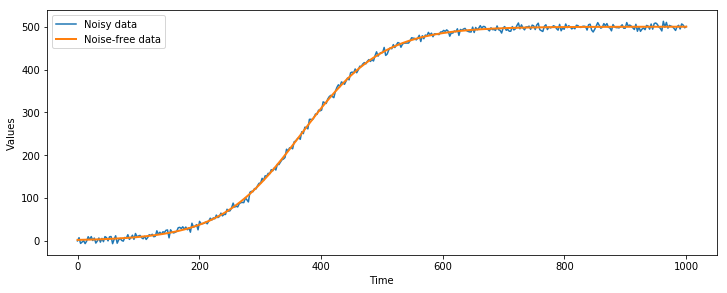

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

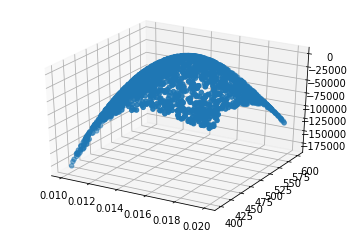

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
__________

In [15]:
emu([0.015, 500])

array([[-1218.7245]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1216.578183140665

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


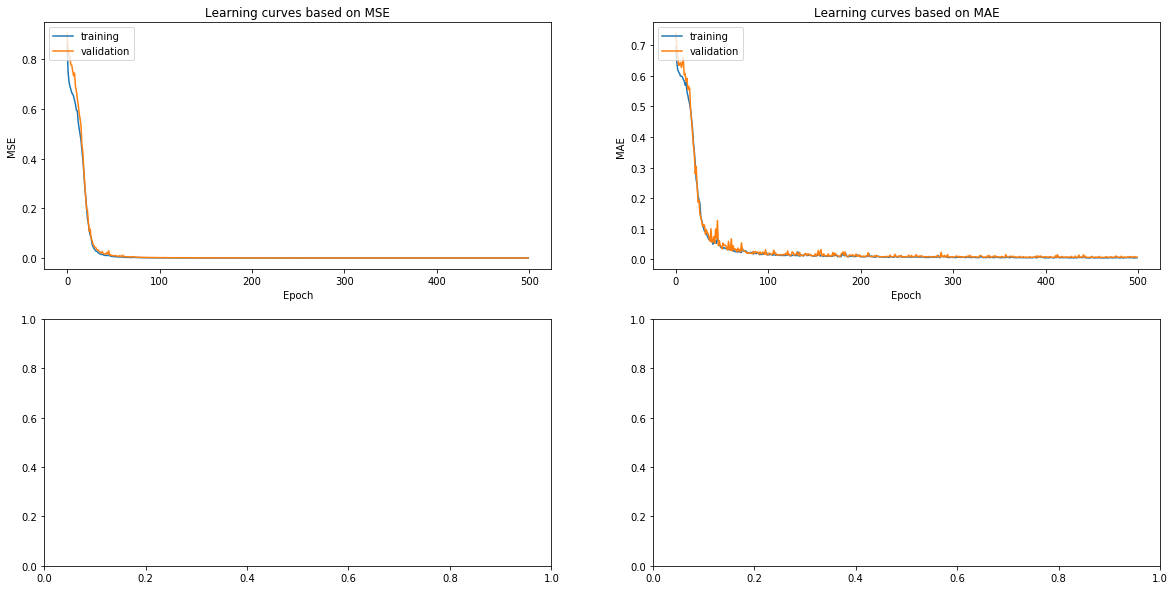

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")

val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 0.0002577919698281524
Best epoch based on validation MSE: 494


Minimum MAE during validation: 0.005781888322283824
Best epoch based on validation MAE: 460


0.00027013948614088197
0.006720666829496622


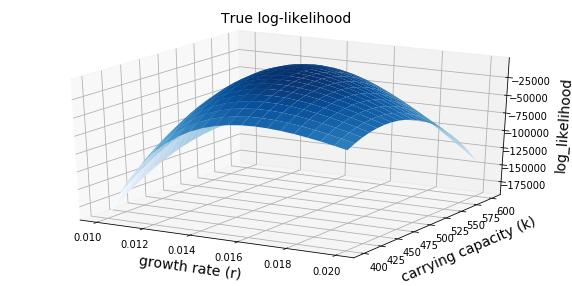

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

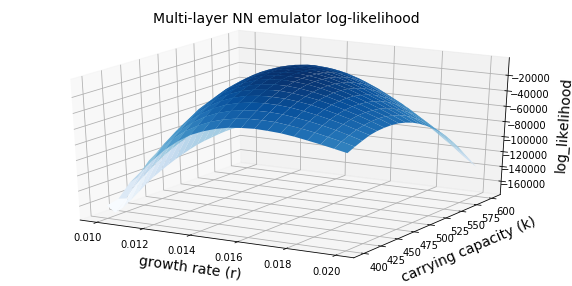

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.009930855369964988

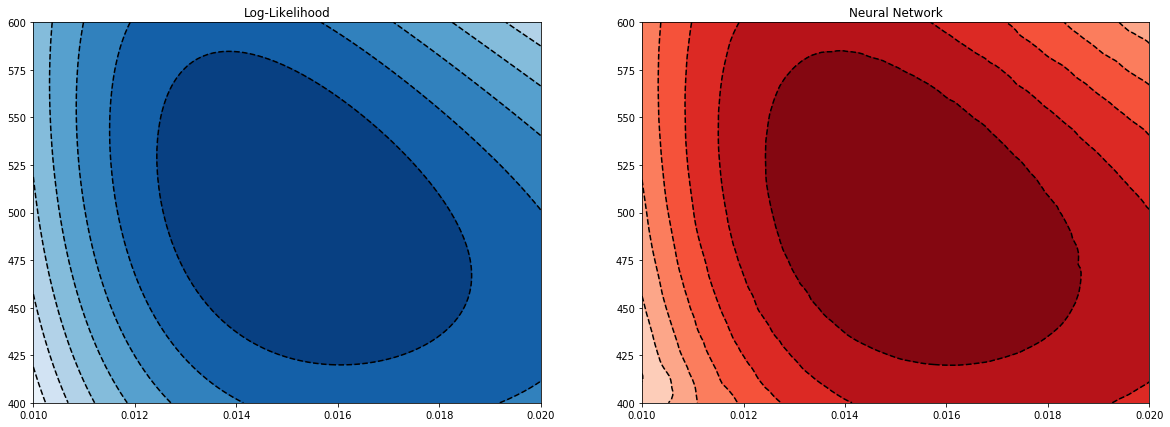

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

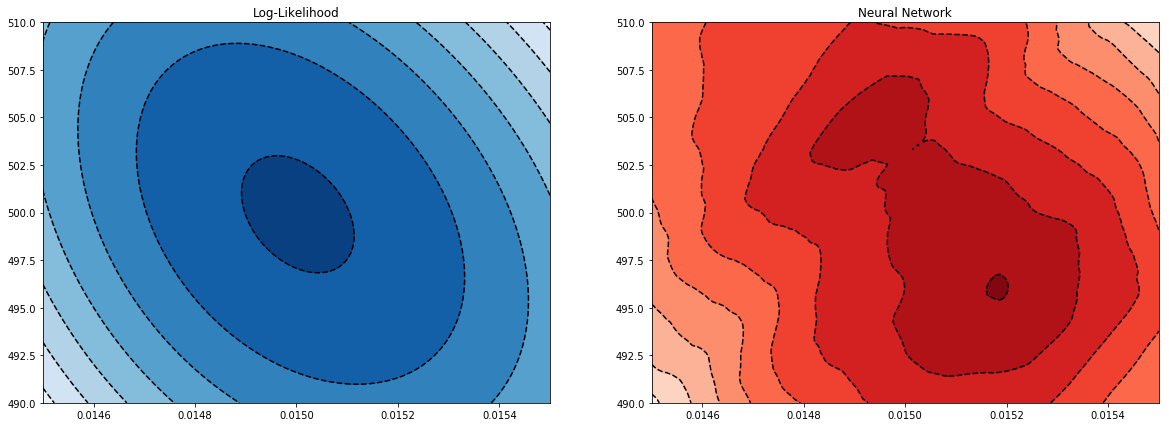

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[1.61961473e-02 4.44081758e+02]
-13111.177181794788
accepted


[3.68060989e-04 5.25914567e+02]
-inf


[5.71383503e-03 5.73280794e+02]
-inf


[1.75216062e-02 4.44710341e+02]
-18732.141636024793


[3.26394985e-02 5.23223829e+02]
-inf


[2.02198026e-02 5.73299195e+02]
-inf


[3.81973845e-02 4.46810790e+02]
-inf


[1.75217900e-02 5.25532482e+02]
-25245.565904179362


[8.81050441e-03 5.72151702e+02]
-inf


[1.33737042e-02 4.42437380e+02]
-30627.052401434674


[2.01102957e-02 5.22783210e+02]
-inf


[3.88048180e-02 5.77615682e+02]
-inf


[2.24781342e-02 4.44364108e+02]
-inf


[1.42542727e-02 5.26370023e+02]
-4217.450176571486
accepted


[-7.0505072e-03  5.7480065e+02]
-inf


[3.54314369e-02 4.41170047e+02]
-inf


[7.23718193e-03 5.28187172e+02]
-inf


[3.02572049e-02 5.79630700e+02]
-inf


[3.39438306e-02 4.43498543e+02]
-inf


[4.57556078e-03 5.26028669e+02]
-inf


[4.73637027e-02 5.77215203e+02]
-inf


[1.26916440e-02 4.45697875e+02]
-42250.05906863092


[3.61816804e-02 5.2559451

[2.06293578e-02 4.51175711e+02]
-inf


[1.62671857e-02 5.16545168e+02]
-8615.561590663521


[4.02062126e-02 5.75291269e+02]
-inf


[1.27074697e-02 4.48788350e+02]
-40186.430801913055


[3.01193634e-02 5.19682825e+02]
-inf


[3.49674575e-03 5.71431805e+02]
-inf


[-2.69381723e-03  4.46944582e+02]
-inf


[1.06784122e-03 5.17969878e+02]
-inf


[-1.78536423e-02  5.69852038e+02]
-inf


[1.66966419e-02 4.46873616e+02]
-13659.75490090914


[2.50101655e-02 5.17063665e+02]
-inf


[3.06045208e-02 5.71923521e+02]
-inf


[1.61561102e-02 4.50493608e+02]
-10717.720799516308


[2.45695098e-02 5.21446010e+02]
-inf


[-9.52931010e-04  5.71470833e+02]
-inf


[1.82617286e-02 4.48811770e+02]
-23242.76951225111


[1.23871979e-03 5.21021048e+02]
-inf


[-1.12967033e-02  5.77772733e+02]
-inf


[7.26167445e-03 4.46948440e+02]
-inf


[2.86924669e-02 5.21705939e+02]
-inf


[8.17302379e-03 5.73014910e+02]
-inf


[1.6591006e-02 4.4971532e+02]
-12327.761746106193


[2.10733698e-02 5.18350546e+02]
-inf


[1.9617435

[3.86754270e-02 4.46990963e+02]
-inf


[2.23778370e-02 5.16673875e+02]
-inf


[4.64624238e-02 5.75599311e+02]
-inf


[2.25817448e-02 4.54534247e+02]
-inf


[1.71719910e-02 5.15079574e+02]
-16958.01600403413


[1.44123053e-02 5.73064449e+02]
-19730.752986089276


[1.01951564e-02 4.48109507e+02]
-142663.93387691028


[9.63906692e-03 5.21294813e+02]
-inf


[3.84151297e-02 5.70574438e+02]
-inf


[2.62113609e-02 4.49838440e+02]
-inf


[1.93025430e-02 5.17157129e+02]
-47101.407570494586


[3.50200424e-02 5.71545641e+02]
-inf


[-5.21905816e-03  4.53620487e+02]
-inf


[1.35257019e-03 5.16716593e+02]
-inf


[2.69424715e-02 5.69610607e+02]
-inf


[2.37429553e-02 4.52030861e+02]
-inf


[-1.76462789e-03  5.12820798e+02]
-inf


[8.67445957e-03 5.72111253e+02]
-inf


[2.53381239e-02 4.53417473e+02]
-inf


[2.33431652e-02 5.14147331e+02]
-inf


[2.60595741e-02 5.70326066e+02]
-inf


[3.88536563e-03 4.48662336e+02]
-inf


[2.05031036e-02 5.14944232e+02]
-inf


[-4.20511369e-03  5.70750555e+02]
-inf




[1.40248456e-02 5.71769488e+02]
-18481.379896725524
accepted


[1.54612586e-02 4.51929389e+02]
-9684.6694443087


[1.47860235e-02 5.14267054e+02]
-1940.5306212503806
accepted


[1.40379030e-02 5.71769452e+02]
-18481.129079907587
accepted


[1.54069788e-02 4.52084174e+02]
-9683.009808212264


[1.48261412e-02 5.13530524e+02]
-1866.6589693183507
accepted


[1.40248047e-02 5.71736676e+02]
-18466.13591262015
accepted


[1.54626968e-02 4.52414204e+02]
-9506.874891671272
accepted


[1.49227530e-02 5.13639139e+02]
-1911.6212725492198


[1.39963443e-02 5.71711466e+02]
-18460.12788280155
accepted


[1.54270898e-02 4.52559495e+02]
-9487.282191143075
accepted


[1.47951918e-02 5.13396721e+02]
-1856.5975600462345
accepted


[1.39906161e-02 5.71717940e+02]
-18465.086191701404


[1.54046763e-02 4.52598915e+02]
-9497.074346156867


[1.4799256e-02 5.1377420e+02]
-1891.1191327545562


[1.39825548e-02 5.71692760e+02]
-18456.76886647029
accepted


[1.54670524e-02 4.52494016e+02]
-9474.415839690868
accept

[1.47498357e-02 4.61999577e+02]
-8016.0396933598995
accepted


[1.5002089e-02 5.0874139e+02]
-1535.2784226292522


[1.43652376e-02 5.68920751e+02]
-17523.94081290354


[1.45895749e-02 4.64034532e+02]
-8135.886728119329


[1.48208368e-02 5.04160014e+02]
-1331.371389852267
accepted


[1.44682561e-02 5.68094885e+02]
-17399.144576914467
accepted


[1.49596351e-02 4.59163116e+02]
-8157.858438141058


[1.48671719e-02 5.05884560e+02]
-1353.0017930993624


[1.40624800e-02 5.71067087e+02]
-18156.86379691359


[1.52305192e-02 4.55254271e+02]
-8809.888382344778


[1.47393180e-02 5.02654457e+02]
-1409.9150807095382


[1.45467310e-02 5.67419319e+02]
-17324.843123324237
accepted


[1.48951550e-02 4.60188902e+02]
-8034.343215530141


[1.49207433e-02 5.06162757e+02]
-1354.89578104541


[1.45782880e-02 5.67301162e+02]
-17381.088829144035


[1.44594624e-02 4.65972204e+02]
-8266.295010183436


[1.46873831e-02 5.00952999e+02]
-1514.2388156733682


[1.44708333e-02 5.67774259e+02]
-17250.72708604836
accepte

[1.42260653e-02 5.25603406e+02]
-4197.184466261803


[1.49514737e-02 5.00709835e+02]
-1224.5479622753817


[1.40815805e-02 5.39618923e+02]
-7217.448584424457


[1.45306152e-02 4.85310476e+02]
-3356.1833046765178


[1.50038653e-02 5.00247960e+02]
-1217.775744845904
accepted


[1.39775897e-02 4.88593713e+02]
-6280.028162918995


[1.45006847e-02 4.89779454e+02]
-2865.8501349548806


[1.49775597e-02 5.01101909e+02]
-1222.5187286565415


[1.47733754e-02 5.82243078e+02]
-26842.30407312365


[1.45695571e-02 4.93852505e+02]
-2188.5151469044804


[1.49566480e-02 5.01947713e+02]
-1233.00634203427


[1.43398918e-02 5.30895793e+02]
-4763.452934130449


[1.46157856e-02 4.97669799e+02]
-1793.124239212514
accepted


[1.49892119e-02 4.99173045e+02]
-1220.7254334408512
accepted


[1.44261334e-02 5.15152057e+02]
-2514.9515948341223
accepted


[1.47942380e-02 4.66434198e+02]
-6465.3460831786815


[1.50195318e-02 4.97964757e+02]
-1230.7825784779957


[1.45713749e-02 5.30739814e+02]
-4502.768515599555


[1

[1.48804052e-02 5.01566522e+02]
-1258.601339060405


[1.50634598e-02 4.98634612e+02]
-1229.1207056563092


[1.50400568e-02 5.08330307e+02]
-1537.968290876229


[1.50350488e-02 5.00819215e+02]
-1226.531677804832


[1.50452822e-02 4.98961430e+02]
-1223.3324209906102


[1.48924273e-02 4.87544307e+02]
-1987.6053568614545


[1.49179897e-02 5.03984408e+02]
-1278.7102213570904


[1.50252596e-02 4.99509015e+02]
-1218.8027729469518
accepted


[1.48718239e-02 5.08548527e+02]
-1480.2642671630622


[1.49353539e-02 4.98012648e+02]
-1256.253901854631


[1.50340101e-02 4.99395160e+02]
-1220.141208052177


[1.47703925e-02 5.00147928e+02]
-1384.6833410192878


[1.50611315e-02 5.01596667e+02]
-1248.0533149071287


[1.50223020e-02 4.98931046e+02]
-1220.7712281762665


[1.45695579e-02 5.15761997e+02]
-2264.939072074406


[1.49364279e-02 4.99114425e+02]
-1237.6381094714277


[1.50452423e-02 4.99187572e+02]
-1222.5945978796228


[1.49718832e-02 5.06652816e+02]
-1388.4415925734145


[1.52070173e-02 5.0001101

[1.50426538e-02 4.99332396e+02]
-1221.795155423385


[1.50080130e-02 5.00101934e+02]
-1217.6021378226014
accepted


[1.50652831e-02 4.99646988e+02]
-1228.5882948418778


[1.50267920e-02 5.00137675e+02]
-1219.841532505892
accepted


[1.50419915e-02 4.99174677e+02]
-1221.981335001648


[1.4885585e-02 5.0420589e+02]
-1293.732097017114


[1.50617128e-02 5.00029069e+02]
-1228.97834563842


[1.49880729e-02 5.00773400e+02]
-1219.9108937538276


[1.50484323e-02 4.98798651e+02]
-1224.7054903307364


[1.50439367e-02 5.00715413e+02]
-1228.185837935452


[1.49833451e-02 4.99574249e+02]
-1219.2977543330633
accepted


[1.49379784e-02 5.02979462e+02]
-1252.2676385463128


[1.50044423e-02 4.97780726e+02]
-1235.2750844934765


[1.49588261e-02 4.99490526e+02]
-1225.2963256188496


[1.50197117e-02 4.96830577e+02]
-1252.362814329646


[1.50394093e-02 4.99160941e+02]
-1221.5570663434244


[1.50032927e-02 4.99325296e+02]
-1218.561555572496
accepted


[1.49906210e-02 5.02403086e+02]
-1240.6872424989115


[1.

[1.50048722e-02 5.00178368e+02]
-1217.628490811956


[1.50204401e-02 4.99972615e+02]
-1218.4138009006906
accepted


[1.50074420e-02 5.01649021e+02]
-1230.492696553682


[1.50220764e-02 5.00011198e+02]
-1218.7097642498186
accepted


[1.49550470e-02 5.00042249e+02]
-1223.7285429620235


[1.49909807e-02 4.99911835e+02]
-1217.616959672811
accepted


[1.50090883e-02 4.99921019e+02]
-1217.402943655112
accepted


[1.50248748e-02 5.00150348e+02]
-1219.568971587156
accepted


[1.49981810e-02 4.99782552e+02]
-1217.3874237553177
accepted


[1.50043213e-02 5.00052418e+02]
-1217.368973904241
accepted


[1.49695275e-02 4.99263057e+02]
-1223.9718507971322


[1.50055541e-02 4.99062848e+02]
-1219.9363927386064


[1.50022818e-02 4.99778312e+02]
-1217.3031834548055
accepted


[1.50107410e-02 5.00394261e+02]
-1218.7964303951208
accepted


[1.49986815e-02 5.00142151e+02]
-1217.4346643145345
accepted


[1.50381204e-02 5.00087075e+02]
-1221.9681702118223


[1.50046001e-02 5.00991541e+02]
-1222.2899520897643


[1.50026236e-02 5.00367550e+02]
-1218.1284407554047
accepted


[1.50414027e-02 4.99365901e+02]
-1221.499874086271


[1.49832211e-02 5.00197131e+02]
-1218.2407018910098
accepted


[1.49778006e-02 5.00190484e+02]
-1218.84086675201


[1.50271292e-02 4.99619242e+02]
-1218.9432630973495
accepted


[1.49572644e-02 5.00229078e+02]
-1222.7695004697496


[1.50171811e-02 5.00184928e+02]
-1218.6192997356036
accepted


[1.50334893e-02 4.99163423e+02]
-1220.6453411593263


[1.49850736e-02 5.00237643e+02]
-1218.1230325484114
accepted


[1.50451756e-02 5.01317354e+02]
-1236.2070904412344


[1.50253642e-02 4.99871565e+02]
-1218.8736051907213
accepted


[1.50095111e-02 5.00529552e+02]
-1219.3812879879522
accepted


[1.50665687e-02 5.01472337e+02]
-1248.5813379718622


[1.50252485e-02 4.99937120e+02]
-1218.981844064039
accepted


[1.50252997e-02 5.00354781e+02]
-1220.609719304692
accepted


[1.49722864e-02 5.00457132e+02]
-1219.8970931059016


[1.50032527e-02 5.00007318e+02]
-1217.2945327110347
accepted

[1.49886499e-02 4.99113145e+02]
-1221.244804583578


[1.50203263e-02 5.00662207e+02]
-1221.7565805480363


[1.50250801e-02 4.99266318e+02]
-1219.3489227001153


[1.49671350e-02 5.00445965e+02]
-1220.6923966487038


[1.49956512e-02 5.00432852e+02]
-1218.217491181151
accepted


[1.50227883e-02 5.00057118e+02]
-1218.9331531274568
accepted


[1.50083709e-02 4.98988629e+02]
-1220.3216462904863


[1.50182691e-02 4.99859466e+02]
-1218.0067329419082
accepted


[1.50337312e-02 5.01681573e+02]
-1237.8954580008756


[1.50089243e-02 4.99842065e+02]
-1217.3667913368279
accepted


[1.50163411e-02 4.99551513e+02]
-1217.9718295635928
accepted


[1.50419898e-02 4.99368823e+02]
-1221.6152009597276


[1.50121242e-02 4.99825747e+02]
-1217.5153974644816
accepted


[1.50130649e-02 4.99816742e+02]
-1217.5691798290136
accepted


[1.50668636e-02 4.99643910e+02]
-1229.1715072970871


[1.49858877e-02 5.00032626e+02]
-1217.952623824056
accepted


[1.50434591e-02 4.99712803e+02]
-1222.072060247243


[1.50320820e-0

[1.50154585e-02 4.99705013e+02]
-1217.7429597581508
accepted


[1.50501414e-02 4.99879171e+02]
-1224.3356837382344
accepted


[1.50078694e-02 5.00020778e+02]
-1217.4528953843865
accepted


[1.50238836e-02 4.99764720e+02]
-1218.553494176654


[1.51095721e-02 4.99625382e+02]
-1250.8444060144068


[1.50249955e-02 4.99204414e+02]
-1219.5631230956092


[1.49932815e-02 5.00209469e+02]
-1217.6334152290278
accepted


[1.50645683e-02 5.00507738e+02]
-1233.985187363295


[1.49845385e-02 5.00472268e+02]
-1218.684064681923
accepted


[1.49932626e-02 4.99760648e+02]
-1217.672534230797
accepted


[1.51217130e-02 4.99599188e+02]
-1258.8482872134052


[1.49779074e-02 5.01054334e+02]
-1222.1410268370794


[1.49907009e-02 4.99879227e+02]
-1217.6699922802986
accepted


[1.50678580e-02 4.99613016e+02]
-1229.4542947339207


[1.49920146e-02 5.00491934e+02]
-1218.464813489999
accepted


[1.49572539e-02 4.99484545e+02]
-1225.8285059352056


[1.49706439e-02 5.01589135e+02]
-1227.4914334641865


[1.49998818e-02

[1.50199391e-02 4.98960439e+02]
-1220.4931138016323


[1.49967938e-02 4.99132905e+02]
-1220.1013332574703


[1.50036384e-02 4.98045495e+02]
-1231.132792871252


[1.50145875e-02 4.99189240e+02]
-1219.0862426937367


[1.50071606e-02 5.00772900e+02]
-1220.7489605387414


[1.49667535e-02 4.99531485e+02]
-1222.8145389107137


[1.49704477e-02 5.00162865e+02]
-1219.9695194809917


[1.50088155e-02 5.00580077e+02]
-1219.6099744411415


[1.49899098e-02 5.00037340e+02]
-1217.6380469993162
accepted


[1.50115637e-02 4.99524310e+02]
-1217.817094878679


[1.49545944e-02 5.00266471e+02]
-1223.4313211330905


[1.50103384e-02 4.99157801e+02]
-1219.2278499297752


[1.50087934e-02 4.99562733e+02]
-1217.6713585342977
accepted


[1.49575659e-02 4.99118411e+02]
-1228.8782786040308


[1.49857718e-02 5.00847458e+02]
-1220.409720955808


[1.50116891e-02 5.00556462e+02]
-1219.7714399739907


[1.50033036e-02 4.99643713e+02]
-1217.4978467430724
accepted


[1.49849336e-02 4.99714580e+02]
-1218.577458409669
accepte

[1.49516910e-02 5.00130257e+02]
-1224.483085451622


[1.50173575e-02 4.99957618e+02]
-1218.0464753801841
accepted


[1.49884216e-02 4.99600416e+02]
-1218.5463954313134


[1.50073838e-02 4.98884988e+02]
-1221.134911780852


[1.50476821e-02 4.99661997e+02]
-1223.046126003197


[1.50034978e-02 4.99851009e+02]
-1217.2509829969547
accepted


[1.49596226e-02 5.00662989e+02]
-1222.569004151254


[1.50246860e-02 5.00528854e+02]
-1221.586183723494


[1.50175528e-02 4.99922016e+02]
-1218.010744924515
accepted


[1.50104827e-02 5.00117319e+02]
-1217.789538923901
accepted


[1.50061467e-02 4.99672617e+02]
-1217.4350173969672
accepted


[1.50168842e-02 5.00659878e+02]
-1221.1678464712481


[1.50174577e-02 5.00199160e+02]
-1218.703380363732


[1.49568140e-02 5.00426882e+02]
-1222.8243700242442


[1.50502327e-02 4.98646041e+02]
-1225.939362165417


[1.49928587e-02 5.01418923e+02]
-1225.6769056072278


[1.50280205e-02 4.99374149e+02]
-1219.357818874735


[1.50017017e-02 4.99912450e+02]
-1217.238791707



[1.50547750e-02 4.98562523e+02]
-1227.4152227796367


[1.49642779e-02 4.99992848e+02]
-1221.4780662347723


[1.50091664e-02 5.01011950e+02]
-1223.0335495278214


[1.50685105e-02 4.98001562e+02]
-1235.34215386033


[1.50428714e-02 4.99193716e+02]
-1222.1009771746594


[1.50103735e-02 4.99735924e+02]
-1217.456661410276
accepted


[1.50209584e-02 4.99277706e+02]
-1218.9864883912408
accepted


[1.49715029e-02 4.99677009e+02]
-1220.9590606305198


[1.50227902e-02 4.98846265e+02]
-1221.3537683137663


[1.49544161e-02 5.00169635e+02]
-1223.61500654389


[1.50026032e-02 4.99571368e+02]
-1217.682199159046
accepted


[1.49873378e-02 4.99900368e+02]
-1217.9235782150756
accepted


[1.50119262e-02 5.00319703e+02]
-1218.5780885612155
accepted


[1.49969805e-02 5.00276155e+02]
-1217.7209397203012
accepted


[1.49764464e-02 4.98596032e+02]
-1229.0623591170788


[1.49994466e-02 5.01587110e+02]
-1228.4142803823565


[1.49874149e-02 4.99843652e+02]
-1218.0010031937145
accepted


[1.49774204e-02 5.00221

[1.50289974e-02 5.00061539e+02]
-1219.9492396997043


[1.49712630e-02 4.99961588e+02]
-1220.0837531764976


[1.50509525e-02 4.99388426e+02]
-1223.686141883652


[1.4984290e-02 5.0074483e+02]
-1219.8590400147018


[1.49292483e-02 4.99645259e+02]
-1235.7849458140724


[1.49886847e-02 5.00299402e+02]
-1217.9925489704735
accepted


[1.50112953e-02 5.00093356e+02]
-1217.7914161649933
accepted


[1.49830595e-02 5.00401359e+02]
-1218.589010444982
accepted


[1.50078725e-02 5.00299452e+02]
-1218.1639765502462


[1.49731792e-02 4.98822093e+02]
-1227.2291012637388


[1.50169042e-02 4.99452143e+02]
-1218.212775572893
accepted


[1.49379208e-02 5.00456037e+02]
-1228.5016863127235


[1.49936756e-02 4.99384713e+02]
-1218.9289695848863


[1.50584363e-02 5.00086465e+02]
-1228.104640276449


[1.49702508e-02 4.99414203e+02]
-1222.6910702168484


[1.50134592e-02 4.99196948e+02]
-1219.031025032795


[1.50076629e-02 4.99145377e+02]
-1219.3476428651336
accepted


[1.49543191e-02 4.99626892e+02]
-1225.818360

[1.49855876e-02 5.00452433e+02]
-1218.5585879568414
accepted


[1.49478700e-02 5.00456192e+02]
-1225.2383874912875


[1.50003373e-02 4.99974964e+02]
-1217.2569870447098
accepted


[1.50297013e-02 4.98809699e+02]
-1222.0302983482966


[1.49741082e-02 5.01034863e+02]
-1222.2655177110112


[1.49780577e-02 4.99152691e+02]
-1222.8521505121414


[1.49412543e-02 5.00873231e+02]
-1227.814591319211


[1.50354653e-02 4.99938232e+02]
-1220.8133688651526


[1.50210081e-02 4.99460137e+02]
-1218.4749807365158
accepted


[1.50485084e-02 4.99470538e+02]
-1223.062267379658


[1.49435736e-02 5.01268030e+02]
-1228.9565710576726


[1.51018711e-02 4.97404042e+02]
-1253.0944661044844


[1.49758763e-02 5.00981423e+02]
-1221.7664674581233


[1.49797332e-02 5.00490156e+02]
-1219.1101925422317


[1.50704974e-02 4.98237713e+02]
-1233.7424095359463


[1.50032016e-02 5.01011645e+02]
-1222.3293195270496


[1.49667261e-02 4.98703574e+02]
-1230.5569722943771


[1.49945922e-02 4.99360393e+02]
-1218.9649620723662


[1.

[1.49842646e-02 4.98259504e+02]
-1231.7059945709113


[1.50230543e-02 5.01138216e+02]
-1226.9516208497632


[1.49964149e-02 4.99890626e+02]
-1217.3460278724965
accepted


[1.50408382e-02 4.99389202e+02]
-1221.361950857233


[1.50460010e-02 4.99954512e+02]
-1223.4413103669904


[1.50442136e-02 4.98992065e+02]
-1223.0061454986983


[1.50579240e-02 4.99480424e+02]
-1225.7250258393199


[1.50446937e-02 4.99519413e+02]
-1222.151501447074


[1.4959410e-02 4.9976674e+02]
-1223.5208146339037


[1.49861046e-02 5.00023569e+02]
-1217.936015584143
accepted


[1.49927689e-02 4.98762378e+02]
-1223.7229021348594
accepted


[1.50188359e-02 4.99288555e+02]
-1218.820114627961
accepted


[1.50234255e-02 4.99636813e+02]
-1218.4858216426976


[1.49763342e-02 4.99778156e+02]
-1219.6513934335167
accepted


[1.50195895e-02 4.97630820e+02]
-1236.0474391772939


[1.49991315e-02 4.99807404e+02]
-1217.3289320612025
accepted


[1.49596237e-02 5.00977327e+02]
-1223.8039492751939


[1.50612684e-02 4.98951223e+02]
-1

[1.49783964e-02 4.99611472e+02]
-1219.9232556970098
accepted


[1.50765569e-02 4.99431583e+02]
-1232.47293361061


[1.50302913e-02 5.00111597e+02]
-1220.3790201585105


[1.50315158e-02 4.99596291e+02]
-1219.5847615947807
accepted


[1.50069599e-02 5.00636222e+02]
-1219.7828073616427


[1.49620194e-02 5.02016240e+02]
-1233.4022805283996


[1.50395846e-02 4.98385661e+02]
-1226.361886243341


[1.49500660e-02 4.99699193e+02]
-1226.7993307413774


[1.49919021e-02 5.02296300e+02]
-1238.8303056132108


[1.50255238e-02 4.98731052e+02]
-1222.3199658052454


[1.50264139e-02 5.00637838e+02]
-1222.7508027553615


[1.49677102e-02 5.00153479e+02]
-1220.486348459295


[1.50101732e-02 5.00011116e+02]
-1217.5600422700256
accepted


[1.49793724e-02 5.00048215e+02]
-1218.6662116524599


[1.49323044e-02 5.01083509e+02]
-1231.4102695056804


[1.50350851e-02 4.98615616e+02]
-1223.9239232376292


[1.49969003e-02 5.00898881e+02]
-1220.9140621618433


[1.50003747e-02 5.00839838e+02]
-1220.670381449184


[1.496

[1.50018376e-02 4.99478124e+02]
-1217.9945740482997
accepted


[1.49953464e-02 5.01143061e+02]
-1222.9271836505432


[1.49751470e-02 5.01100292e+02]
-1222.656895728268


[1.50477116e-02 4.99820459e+02]
-1223.4386960587738


[1.50193015e-02 4.98474516e+02]
-1224.4982780154933


[1.50034249e-02 5.00495429e+02]
-1218.7261572843556


[1.50040417e-02 5.00410126e+02]
-1218.3685659572557
accepted


[1.50260805e-02 5.00485645e+02]
-1221.563148485216


[1.49787892e-02 5.01669107e+02]
-1228.1984494677106


[1.49578265e-02 5.00120539e+02]
-1222.786484429952


[1.49793167e-02 5.00898180e+02]
-1221.0004049314014


[1.50159746e-02 4.99703854e+02]
-1217.7789981723654
accepted


[1.50093088e-02 5.00765492e+02]
-1220.929826557733


[1.50340704e-02 4.99236606e+02]
-1220.4958630204233


[1.50100514e-02 5.00163644e+02]
-1217.8789667965514
accepted


[1.50214356e-02 4.99456226e+02]
-1218.5184131612327
accepted


[1.49454148e-02 4.99743143e+02]
-1228.2002831575687


[1.49677499e-02 5.00080041e+02]
-1220.561

[1.49837167e-02 5.00712683e+02]
-1219.7174607537575


[1.49731222e-02 5.00380501e+02]
-1219.6445348319655


[1.50824758e-02 5.00575781e+02]
-1243.610644255543


[1.49699153e-02 5.00698849e+02]
-1220.9300057993335


[1.49389536e-02 5.00326603e+02]
-1228.2978847655809


[1.50543864e-02 4.99152060e+02]
-1224.8247223419799


[1.49975784e-02 4.99684119e+02]
-1217.5847039850103
accepted


[1.50716249e-02 4.98247227e+02]
-1233.99407262262


[1.50150835e-02 4.99713478e+02]
-1217.7137283097186
accepted


[1.50037704e-02 4.98884486e+02]
-1221.3636111621233


[1.50166243e-02 4.99998708e+02]
-1218.0485424097008


[1.49897178e-02 4.99449640e+02]
-1219.0308363886747
accepted


[1.49583731e-02 5.01039158e+02]
-1224.3632575697764


[1.50357786e-02 4.96968516e+02]
-1247.872046252237


[1.49884442e-02 4.99096838e+02]
-1221.4005605348998


[1.49815717e-02 4.99778628e+02]
-1218.8352598158028
accepted


[1.50328824e-02 4.98331826e+02]
-1226.3198833643335


[1.50325770e-02 4.99501509e+02]
-1219.793374474085

[1.50429638e-02 4.99604422e+02]
-1221.8058489071511


[1.49152289e-02 5.00473065e+02]
-1238.2654261313003


[1.50130070e-02 4.99240838e+02]
-1218.8193250995332


[1.50178701e-02 4.98156981e+02]
-1228.229330507406


[1.49894072e-02 4.98947899e+02]
-1222.4863692929357


[1.49888898e-02 4.99736835e+02]
-1218.0823145751042
accepted


[1.49331671e-02 4.99753721e+02]
-1233.145913726217


[1.49843463e-02 4.98055101e+02]
-1234.8997984611806


[1.49907146e-02 4.97866828e+02]
-1236.5145626375033


[1.49872360e-02 4.99707047e+02]
-1218.331750265688
accepted


[1.50211208e-02 4.99268527e+02]
-1219.0302988162264
accepted


[1.49816732e-02 5.00086873e+02]
-1218.3679707690064
accepted


[1.50081417e-02 5.00355831e+02]
-1218.4049273027504
accepted


[1.49913598e-02 4.98925232e+02]
-1222.3886838114292


[1.49884884e-02 4.97643077e+02]
-1241.238149788534


[1.50062270e-02 4.99725646e+02]
-1217.3641413959108
accepted


[1.50086667e-02 4.99135890e+02]
-1219.3771022766466


[1.49875387e-02 5.00539804e+02]


[1.50268083e-02 5.00712200e+02]
-1223.4542391981286


[1.49688989e-02 5.00640914e+02]
-1220.870559345807


[1.49919536e-02 5.00136517e+02]
-1217.580945426696
accepted


[1.48952110e-02 5.01320237e+02]
-1248.969269411011


[1.50084372e-02 4.98900088e+02]
-1220.9678035106722


[1.49891382e-02 4.99942247e+02]
-1217.7271850231698
accepted


[1.49487728e-02 4.99219400e+02]
-1231.1072530626382


[1.50222534e-02 4.99500677e+02]
-1218.507891753638
accepted


[1.49807106e-02 4.99340178e+02]
-1220.9707286482314


[1.49422280e-02 4.99961018e+02]
-1228.2415365336442


[1.50128718e-02 4.98463584e+02]
-1224.811948285918


[1.49831961e-02 5.00488515e+02]
-1218.8249552762534


[1.49896588e-02 5.00135270e+02]
-1217.6978499959769
accepted


[1.50278106e-02 4.99696773e+02]
-1219.0429486633338
accepted


[1.49829379e-02 5.00414353e+02]
-1218.6311165774232


[1.50128470e-02 5.00921743e+02]
-1222.71615317291


[1.49962306e-02 5.00492662e+02]
-1218.4631103784052
accepted


[1.50285139e-02 4.99057831e+02]
-12

[1.50252570e-02 4.99993475e+02]
-1219.1183847366792
accepted


[1.50138676e-02 5.00694829e+02]
-1220.982321100986


[1.50661265e-02 4.97948910e+02]
-1235.305994408836


[1.49842077e-02 5.00097020e+02]
-1218.1023346555667
accepted


[1.49945346e-02 5.01290138e+02]
-1224.3594628045282


[1.50078172e-02 5.00056920e+02]
-1217.5067850466382
accepted


[1.50424927e-02 5.00293819e+02]
-1224.2464383712081


[1.50154651e-02 4.99747686e+02]
-1217.7280040324417
accepted


[1.49943406e-02 5.00857216e+02]
-1220.5029893964884


[1.50017296e-02 4.99044290e+02]
-1220.2940122417613


[1.49939423e-02 4.98815845e+02]
-1223.0253247828678


[1.49980112e-02 4.99352995e+02]
-1218.7235459970236


[1.49973782e-02 4.99821724e+02]
-1217.3686071242798
accepted


[1.49844167e-02 4.98430213e+02]
-1229.2464138021812


[1.49588705e-02 5.01449851e+02]
-1227.2796879330144


[1.50154301e-02 4.99345136e+02]
-1218.463378483183


[1.50328344e-02 4.99767071e+02]
-1219.919723810085


[1.50138315e-02 5.00442087e+02]
-1219.365

[1.50070826e-02 5.00301293e+02]
-1218.1181219493355
accepted


[1.50384614e-02 4.98883783e+02]
-1222.5659696980856


[1.49806856e-02 5.00595925e+02]
-1219.3874038562235
accepted


[1.50417912e-02 4.99455287e+02]
-1221.5096864913824


[1.50793672e-02 4.99543167e+02]
-1234.0137370413415


[1.50541114e-02 5.00666930e+02]
-1231.3191191603169


[1.50304114e-02 4.99169338e+02]
-1220.2390732289525


[1.50153971e-02 5.01367998e+02]
-1228.1264887267882


[1.49471155e-02 5.00149437e+02]
-1225.8669098918217


[1.5003987e-02 4.9970780e+02]
-1217.3794778964368
accepted


[1.49849164e-02 5.00003930e+02]
-1218.0583781234861
accepted


[1.49784558e-02 5.00973154e+02]
-1221.5371684034824


[1.49980251e-02 5.00636910e+02]
-1219.2213498597218


[1.50075098e-02 5.00074912e+02]
-1217.523687388444
accepted


[1.49901822e-02 5.00751940e+02]
-1219.762883018496


[1.50000114e-02 4.99999534e+02]
-1217.270996930614
accepted


[1.49986252e-02 5.00159579e+02]
-1217.4645613132686
accepted


[1.49470859e-02 5.000716

[1.49862854e-02 4.98753977e+02]
-1224.9323855482235


[1.49689582e-02 5.00467900e+02]
-1220.4222455313752


[1.50437025e-02 5.00122044e+02]
-1223.5785691285448


[1.50510797e-02 4.97529596e+02]
-1238.1896679163617


[1.49458714e-02 5.01453483e+02]
-1229.7165209473358


[1.49977377e-02 4.99515355e+02]
-1218.0598085041113
accepted


[1.50371548e-02 4.98308436e+02]
-1226.8776610210282


[1.48972936e-02 5.01257795e+02]
-1247.6516780436841


[1.49684233e-02 5.00696714e+02]
-1221.1327726864106


[1.49556987e-02 4.99525384e+02]
-1226.0392201718864


[1.49738663e-02 4.98225756e+02]
-1235.150753716813


[1.50469191e-02 4.99227054e+02]
-1222.8747621825523


[1.49955401e-02 4.99400345e+02]
-1218.6878839407734
accepted


[1.50121007e-02 4.98839602e+02]
-1221.3135479547086


[1.49910874e-02 4.98693934e+02]
-1224.7077207131426


[1.49873572e-02 4.98688349e+02]
-1225.4422428908485


[1.50640421e-02 4.97828947e+02]
-1236.194189723226


[1.50083189e-02 4.99659657e+02]
-1217.4822025658505
accepted


[1.

[1.49543643e-02 5.00728565e+02]
-1223.895004670528


[1.50252236e-02 5.00857117e+02]
-1224.4286245373978


[1.50011194e-02 4.97428873e+02]
-1242.4768042631938


[1.50604096e-02 4.99835509e+02]
-1227.5118662293296


[1.50308922e-02 4.99705392e+02]
-1219.519976248489
accepted


[1.50142929e-02 4.99824812e+02]
-1217.6518392406222
accepted


[1.50680711e-02 5.00948225e+02]
-1240.9260162476876


[1.50426927e-02 4.98961048e+02]
-1222.8609672606567


[1.50306960e-02 5.00658616e+02]
-1223.8932721103035


[1.50156076e-02 5.00645072e+02]
-1220.8681344358577


[1.50245626e-02 4.98431363e+02]
-1224.9619795458054


[1.50310586e-02 4.99932778e+02]
-1219.9306445795496


[1.50235955e-02 5.01432989e+02]
-1230.923634086409


[1.50532991e-02 4.99679719e+02]
-1224.6637950418


[1.50625770e-02 4.99585648e+02]
-1227.4465299650758


[1.50789831e-02 4.99225517e+02]
-1233.1765762314615


[1.50645908e-02 4.99623904e+02]
-1228.264948658374


[1.50734732e-02 5.00581364e+02]
-1238.944814075457


[1.4984981e-02 5.0

[1.49522296e-02 5.00878870e+02]
-1224.8840704600664


[1.50273170e-02 4.97429503e+02]
-1239.1215800818218


[1.50191149e-02 5.00531404e+02]
-1220.625157738468


[1.49438256e-02 4.99587256e+02]
-1229.853066307322


[1.50459909e-02 4.99294953e+02]
-1222.5592298917036


[1.49999124e-02 4.98932321e+02]
-1221.2956836999722


[1.49601991e-02 4.98512112e+02]
-1235.4739062163171


[1.49972984e-02 5.00930627e+02]
-1221.1830095226564
accepted


[1.49840098e-02 4.98050697e+02]
-1235.0618659464885


[1.49050590e-02 4.98743291e+02]
-1261.7503980166182


[1.50267399e-02 5.01176854e+02]
-1228.3276075653723


[1.50141116e-02 4.99554917e+02]
-1217.8472930863884
accepted


[1.50213412e-02 4.98662091e+02]
-1222.7391257953896


[1.50623678e-02 5.01107146e+02]
-1240.450514883977


[1.50072724e-02 4.98754651e+02]
-1222.240297537216


[1.50650239e-02 5.00219497e+02]
-1231.6035093537087


[1.50375774e-02 4.99659052e+02]
-1220.6974370615167
accepted


[1.50309073e-02 4.99232770e+02]
-1220.0830840299418


[1.49

[1.49632734e-02 5.01306022e+02]
-1225.4458384374916


[1.50013269e-02 5.00127192e+02]
-1217.4255371289503
accepted


[1.49736314e-02 5.01254953e+02]
-1224.0079022670704


[1.49772571e-02 4.99306359e+02]
-1221.8620515626878


[1.50174662e-02 4.99515772e+02]
-1218.1064237515786
accepted


[1.50109195e-02 4.98274985e+02]
-1227.1524486223573


[1.50573243e-02 4.99313299e+02]
-1225.4714645265626


[1.50411974e-02 4.99458402e+02]
-1221.384794629443


[1.49503170e-02 5.01072041e+02]
-1226.1963160611888


[1.49900860e-02 5.00818298e+02]
-1220.1729271564418


[1.50472623e-02 4.98701022e+02]
-1225.0378521316413


[1.49560096e-02 4.98881327e+02]
-1232.074008235921


[1.50425124e-02 4.99086636e+02]
-1222.3437427163308


[1.50050068e-02 4.99959524e+02]
-1217.2903698061714
accepted


[1.49862703e-02 5.00917879e+02]
-1220.866820111277


[1.50050594e-02 4.99250396e+02]
-1218.8597962728184
accepted


[1.50347457e-02 4.98999766e+02]
-1221.4797389094256


[1.48907840e-02 5.00437496e+02]
-1252.66684899998

[1.49787312e-02 5.00876845e+02]
-1220.9075604261163
accepted


[1.50796633e-02 4.98593960e+02]
-1234.560958381169


[1.50020039e-02 4.99580063e+02]
-1217.674324426703
accepted


[1.49656178e-02 5.03571200e+02]
-1265.0152799437612


[1.49930173e-02 5.00574856e+02]
-1218.8154411365415
accepted


[1.50008338e-02 4.99293628e+02]
-1218.8366676509934


[1.49981663e-02 5.00480922e+02]
-1218.4465632635886
accepted


[1.50496957e-02 5.00541104e+02]
-1228.4588717063245


[1.50079431e-02 4.98053231e+02]
-1230.4609151130796


[1.50212188e-02 5.00328434e+02]
-1219.7827106638827
accepted


[1.50144560e-02 5.00623945e+02]
-1220.5569844515846


[1.50142399e-02 4.99552110e+02]
-1217.858541632928
accepted


[1.49796246e-02 5.00593397e+02]
-1219.4631560662303
accepted


[1.50447362e-02 4.98519491e+02]
-1225.882258834552


[1.50029358e-02 4.99645275e+02]
-1217.5001330129737
accepted


[1.49752341e-02 5.01011061e+02]
-1222.013482212016
accepted


[1.49845605e-02 5.03622930e+02]
-1269.0783660834973


[1.501

[1.49654408e-02 5.00990083e+02]
-1222.9462842687378


[1.49786137e-02 5.00468908e+02]
-1219.1588475758265
accepted


[1.49199986e-02 5.01271902e+02]
-1236.7914746937277


[1.50292508e-02 4.99639776e+02]
-1219.2383469773238
accepted


[1.50213448e-02 4.99991067e+02]
-1218.5659678666423
accepted


[1.50262133e-02 4.98831744e+02]
-1221.6312316886278
accepted


[1.50047513e-02 5.00135770e+02]
-1217.5270710003724
accepted


[1.50203038e-02 4.99836161e+02]
-1218.1937387650764
accepted


[1.50433933e-02 4.99308370e+02]
-1221.9814146853964
accepted


[1.50420832e-02 5.01409014e+02]
-1236.4396262182124


[1.50232364e-02 4.98304198e+02]
-1226.318146370676


[1.50124569e-02 5.00225518e+02]
-1218.2673807762194
accepted


[1.49981368e-02 4.99192724e+02]
-1219.5948921889556


[1.50163171e-02 4.99349354e+02]
-1218.4845579860048
accepted


[1.50133676e-02 5.00143252e+02]
-1218.0896501532231
accepted


[1.49942938e-02 5.01368458e+02]
-1225.201502822353


[1.49838482e-02 4.98567947e+02]
-1227.5919357980

[1.49278537e-02 5.02036288e+02]
-1239.9605789617046


[1.49700176e-02 5.01789854e+02]
-1229.9108777496542


[1.49354070e-02 5.00367849e+02]
-1229.5490786152704


[1.50155056e-02 4.98904350e+02]
-1220.7890856491222
accepted


[1.50276956e-02 4.99700023e+02]
-1219.0278919987966
accepted


[1.49652890e-02 5.00419967e+02]
-1220.993696362724


[1.50072549e-02 5.00139342e+02]
-1217.6448463516424
accepted


[1.50558554e-02 4.98610090e+02]
-1227.3505469626673


[1.50113289e-02 4.98856007e+02]
-1221.2056445872279


[1.50776255e-02 4.99054127e+02]
-1232.6162377675703


[1.49623629e-02 5.00835773e+02]
-1222.6509882474368


[1.49854439e-02 4.99379445e+02]
-1219.9574177553948


[1.49928276e-02 5.00750321e+02]
-1219.7635547752277
accepted


[1.50436133e-02 5.00342886e+02]
-1224.9022512077179


[1.49614391e-02 5.01020968e+02]
-1223.7320308336837


[1.50349238e-02 4.99538335e+02]
-1220.1619817735273
accepted


[1.50560779e-02 4.98390762e+02]
-1228.94394771792


[1.50137826e-02 4.99662069e+02]
-1217.67

[1.49746363e-02 5.02305480e+02]
-1237.59118528821


[1.50081309e-02 5.00266190e+02]
-1218.063138226509
accepted


[1.49678523e-02 4.98995143e+02]
-1226.865202909699


[1.50307098e-02 4.99813850e+02]
-1219.6173917865133


[1.50099327e-02 5.01492545e+02]
-1228.7301318480295


[1.50043086e-02 4.99652405e+02]
-1217.4704011592182
accepted


[1.49690259e-02 5.00708632e+02]
-1221.090640890877


[1.49682652e-02 5.00957978e+02]
-1222.3851638738345


[1.50141555e-02 5.00140144e+02]
-1218.1536832609409
accepted


[1.49359788e-02 5.01358738e+02]
-1231.629457519244


[1.49885358e-02 5.00383346e+02]
-1218.2040259078576
accepted


[1.49770618e-02 5.00892069e+02]
-1221.1163530130823


[1.49828237e-02 5.01021601e+02]
-1221.6899582147535


[1.50367998e-02 4.98885583e+02]
-1222.3284559532933


[1.50143361e-02 5.01432988e+02]
-1228.7711313475259


[1.50483264e-02 5.00237863e+02]
-1225.6277272664945


[1.50288652e-02 4.99972534e+02]
-1219.6475108415261


[1.49728911e-02 5.01420121e+02]
-1225.5855706658188


[1.49478187e-02 5.03415622e+02]
-1260.8220058666548


[1.50449777e-02 4.98540161e+02]
-1225.7595972783424


[1.49917079e-02 5.00155214e+02]
-1217.6124953538117
accepted


[1.49921510e-02 5.01624647e+02]
-1228.1705031828806


[1.49548354e-02 5.01521483e+02]
-1228.5529626718169


[1.50506091e-02 5.00721968e+02]
-1230.5795103374599


[1.50206728e-02 4.99985114e+02]
-1218.468602201967
accepted


[1.49859548e-02 5.00214522e+02]
-1218.026345437631
accepted


[1.49958848e-02 5.00828143e+02]
-1220.3505462764915


[1.50563279e-02 4.98858551e+02]
-1226.1915935837662


[1.49588250e-02 5.01676663e+02]
-1229.5334224931719


[1.49987524e-02 5.00131695e+02]
-1217.4177696939696
accepted


[1.50488474e-02 4.99819413e+02]
-1223.753593428825


[1.50112653e-02 4.99318974e+02]
-1218.4651646621503
accepted


[1.50128392e-02 5.01035153e+02]
-1223.8083151030812


[1.50985031e-02 4.98522835e+02]
-1242.8603511596125


[1.50271340e-02 5.00152399e+02]
-1219.9604623505472


[1.50267734e-02 5.00211150e+02]
-1220.14

[1.49526747e-02 5.00323827e+02]
-1223.9073444289775


[1.49747482e-02 4.99744351e+02]
-1220.0485057636663


[1.50165376e-02 4.99309648e+02]
-1218.6336854407052
accepted


[1.50504385e-02 4.98731431e+02]
-1225.471020526602


[1.4988847e-02 4.9946405e+02]
-1219.0647801228451


[1.50162961e-02 4.99917355e+02]
-1217.8863776954697
accepted


[1.49857843e-02 4.98365980e+02]
-1229.8111861526759


[1.50552504e-02 4.99808930e+02]
-1225.6576099136842


[1.50621604e-02 5.00087937e+02]
-1229.5154074373922


[1.50801165e-02 4.99181435e+02]
-1233.624775184836


[1.49514647e-02 5.00221600e+02]
-1224.3694390995909


[1.50110909e-02 5.00406412e+02]
-1218.8880329880908
accepted


[1.49418724e-02 4.97987276e+02]
-1253.1489913683897


[1.50271048e-02 5.00310713e+02]
-1220.7038766602925


[1.50573345e-02 4.99490231e+02]
-1225.5535938682672


[1.50028245e-02 4.98277994e+02]
-1227.9558229153959


[1.50449256e-02 4.99333296e+02]
-1222.2759497859875


[1.49720651e-02 5.00731348e+02]
-1220.7847920590355


[1.49

[1.50126921e-02 5.01678356e+02]
-1231.9627765352864


[1.49714393e-02 5.01360217e+02]
-1225.1038950475568


[1.49648770e-02 5.00213659e+02]
-1221.0165751685993


[1.50199565e-02 5.00181922e+02]
-1218.9583179001547
accepted


[1.50860162e-02 4.98029128e+02]
-1240.5002191388269


[1.50287616e-02 4.99469016e+02]
-1219.2807262103681
accepted


[1.50428257e-02 4.99500259e+02]
-1221.7242747617788


[1.50315851e-02 4.98748899e+02]
-1222.6068906445644


[1.50253293e-02 5.00254843e+02]
-1220.0974967879272
accepted


[1.50114707e-02 5.00748124e+02]
-1221.062536962612


[1.50031520e-02 4.99199491e+02]
-1219.2169423561556


[1.50488593e-02 4.99152341e+02]
-1223.4670445952863


[1.49899850e-02 4.99942278e+02]
-1217.6634089922159
accepted


[1.50667764e-02 4.98103655e+02]
-1233.907117291179


[1.50700781e-02 4.99153066e+02]
-1229.700809853053


[1.49680929e-02 5.01696412e+02]
-1228.8745574591044


[1.49314529e-02 5.01023381e+02]
-1231.4953881718795


[1.50300189e-02 4.99564157e+02]
-1219.36659060828

[1.50487842e-02 4.98405956e+02]
-1227.4455762135624


[1.50965172e-02 4.98802633e+02]
-1241.254431328423


[1.50007700e-02 4.99716337e+02]
-1217.4111194807508
accepted


[1.50259648e-02 5.02156270e+02]
-1244.1424841700614


[1.50345819e-02 4.98338927e+02]
-1226.3624971594581


[1.49849976e-02 4.99737253e+02]
-1218.5042624541534
accepted


[1.50045159e-02 4.97573162e+02]
-1238.9983165234778


[1.49949434e-02 4.99065364e+02]
-1220.775405042866


[1.49602453e-02 5.00459818e+02]
-1222.0617711565126


[1.49503706e-02 4.99627006e+02]
-1227.1456606469337


[1.51522729e-02 4.97011983e+02]
-1285.1842760976062


[1.49547525e-02 4.99809968e+02]
-1224.6832057658753


[1.50510718e-02 4.99233175e+02]
-1223.8438008712367


[1.51154693e-02 4.98908949e+02]
-1251.7399588411295


[1.49425584e-02 5.03642102e+02]
-1266.7250146692866


[1.50046870e-02 4.97229644e+02]
-1245.9178234087644


[1.50671262e-02 4.98401516e+02]
-1231.5666607801493


[1.49571948e-02 5.00398298e+02]
-1222.720909514781


[1.49853801e-

[1.49615594e-02 5.00374429e+02]
-1221.7122904476964


[1.50199446e-02 5.00232876e+02]
-1219.1573527889716


[1.50123799e-02 4.99744966e+02]
-1217.540840503068
accepted


[1.49975209e-02 5.00869088e+02]
-1220.720029274538


[1.50119853e-02 4.99947207e+02]
-1217.5876156206516
accepted


[1.50432076e-02 4.98886417e+02]
-1223.2972736108263


[1.50174701e-02 5.01636851e+02]
-1232.4095185092594


[1.50435006e-02 5.00160130e+02]
-1223.726530234942


[1.49680283e-02 4.99717075e+02]
-1221.549040446412


[1.50394782e-02 4.99821581e+02]
-1221.37278148436


[1.49830448e-02 5.01071981e+02]
-1222.0727906515365


[1.50099578e-02 5.01508895e+02]
-1228.9580625798667


[1.49968353e-02 4.98524894e+02]
-1225.703889636171


[1.49328019e-02 5.02602410e+02]
-1246.4482638239751


[1.50094390e-02 5.00248786e+02]
-1218.096740875709


[1.49890141e-02 5.02472929e+02]
-1241.8418873652429


[1.50359336e-02 4.99248440e+02]
-1220.7439956367564


[1.50088627e-02 4.99425299e+02]
-1218.0575345126413


[1.50230147e-02 5.

[1.50623381e-02 4.99370758e+02]
-1227.0439160097842


[1.49788917e-02 5.01044912e+02]
-1222.0188169022922


[1.50163353e-02 5.00992287e+02]
-1223.97163673498


[1.50612966e-02 4.99019139e+02]
-1227.0269299577187


[1.49816955e-02 5.00900277e+02]
-1220.887663647686


[1.49520233e-02 4.99681319e+02]
-1226.2418083418052


[1.49746793e-02 4.98794768e+02]
-1227.1363965532564


[1.49855929e-02 4.99492619e+02]
-1219.3475473318301
accepted


[1.50240122e-02 4.99470721e+02]
-1218.7287601941182
accepted


[1.51266242e-02 4.96409920e+02]
-1279.3042330434812


[1.49822732e-02 5.00032292e+02]
-1218.3224854838033
accepted


[1.50812345e-02 4.98534753e+02]
-1235.4150682856146


[1.50420600e-02 4.98775392e+02]
-1223.713109299544


[1.49356324e-02 4.99698915e+02]
-1232.4416476075003


[1.50168649e-02 4.98127368e+02]
-1228.668410636692


[1.50891413e-02 4.96770110e+02]
-1258.4647267723767


[1.49620635e-02 5.01695432e+02]
-1229.3704695684453


[1.50012268e-02 4.99661163e+02]
-1217.5027084562932
accepted

[1.49623894e-02 5.00236860e+02]
-1221.5389133617734


[1.49769796e-02 5.00279864e+02]
-1219.0028188240815


[1.49376851e-02 5.01009144e+02]
-1229.3603810974714


[1.5007402e-02 4.9935469e+02]
-1218.3263612556798
accepted


[1.49791430e-02 5.00135237e+02]
-1218.6629114875252


[1.49798718e-02 5.00730477e+02]
-1220.0349472626685


[1.50309905e-02 4.98711525e+02]
-1222.8251579429405


[1.50095855e-02 5.01076220e+02]
-1223.7278049313643


[1.49636295e-02 5.00870443e+02]
-1222.5941854697858


[1.49888750e-02 4.98861684e+02]
-1223.3695174546451


[1.49973787e-02 4.98746281e+02]
-1223.2445093647832


[1.49692235e-02 5.00037649e+02]
-1220.333572144365


[1.50355209e-02 5.00041584e+02]
-1221.181859508808


[1.49973121e-02 4.98984704e+02]
-1221.1348397348193


[1.50128769e-02 4.99503661e+02]
-1217.9067784148574
accepted


[1.49692529e-02 5.00093690e+02]
-1220.2485844886728


[1.49985353e-02 4.99843403e+02]
-1217.311526193971
accepted


[1.50413765e-02 4.99004242e+02]
-1222.4507314509026


[1.509

[1.50381594e-02 4.97626030e+02]
-1235.7496417607097


[1.49818207e-02 4.99140609e+02]
-1222.1911655985605


[1.49809641e-02 4.98708107e+02]
-1226.5718628653826


[1.50803565e-02 4.97094264e+02]
-1250.4416290064855


[1.50368728e-02 4.97922197e+02]
-1231.3967575986078


[1.50779461e-02 4.97675518e+02]
-1241.4923000796662


[1.49977382e-02 5.01101816e+02]
-1222.695911816829


[1.49776399e-02 5.00339173e+02]
-1218.9956971028257
accepted


[1.49666711e-02 4.99083039e+02]
-1226.33446819723


[1.50031439e-02 5.00834766e+02]
-1220.8407723026585


[1.49686235e-02 5.00345906e+02]
-1220.3166228234388


[1.49899003e-02 4.98929033e+02]
-1222.5769704059353


[1.50436754e-02 4.99502234e+02]
-1221.9137029410394


[1.49448060e-02 5.02087542e+02]
-1236.5710208474986


[1.50654929e-02 4.97503110e+02]
-1240.7764442957634


[1.50013361e-02 5.00382288e+02]
-1218.135239083193
accepted


[1.50066032e-02 5.00352819e+02]
-1218.2842784699915
accepted


[1.49965502e-02 4.99910264e+02]
-1217.3312429485793
accepte

[1.50039411e-02 5.00048351e+02]
-1217.3540061091321
accepted


[1.50356375e-02 4.98857465e+02]
-1222.3389142298922


[1.49377018e-02 5.00779250e+02]
-1228.7313133143346


[1.49816479e-02 5.00348920e+02]
-1218.5938249737785


[1.50049229e-02 4.99099252e+02]
-1219.7311627164224
accepted


[1.49885545e-02 4.99939326e+02]
-1217.7761923167966
accepted


[1.49925368e-02 4.98449112e+02]
-1227.328020612418


[1.50241542e-02 4.98014434e+02]
-1229.9273523463175


[1.50138566e-02 4.98016901e+02]
-1230.4057966435996


[1.49661373e-02 5.01538788e+02]
-1227.286367142972


[1.50536326e-02 4.99155151e+02]
-1224.622723915292


[1.50033796e-02 4.97106362e+02]
-1248.9310814868595


[1.49935863e-02 5.00975495e+02]
-1221.3727270183292


[1.50198517e-02 4.98642662e+02]
-1222.889979755818


[1.49669886e-02 5.00530168e+02]
-1220.8728001324748


[1.50331722e-02 4.97775884e+02]
-1233.325847798067


[1.49890532e-02 4.99447683e+02]
-1219.1180422192317
accepted


[1.49634393e-02 4.99121050e+02]
-1226.9355886355886

[1.50094099e-02 4.99396648e+02]
-1218.1584737776668
accepted


[1.49956477e-02 5.00138783e+02]
-1217.4635503719335
accepted


[1.49476113e-02 5.00886504e+02]
-1226.0568504375676


[1.50419093e-02 4.99734743e+02]
-1221.7448209577046


[1.50194586e-02 5.00329056e+02]
-1219.5232614295824


[1.49613408e-02 5.00384947e+02]
-1221.7648287455095


[1.50752073e-02 4.98089435e+02]
-1236.3769545172822


[1.50296955e-02 4.99894592e+02]
-1219.5974420716277


[1.50097276e-02 5.00918332e+02]
-1222.2428754453142


[1.49933451e-02 4.99280733e+02]
-1219.5222114956894
accepted


[1.50408069e-02 4.99575119e+02]
-1221.307149630208


[1.49862590e-02 5.00825954e+02]
-1220.263785657063


[1.49688332e-02 4.99772716e+02]
-1221.1403976445158


[1.49926467e-02 5.01063427e+02]
-1222.0714134894329


[1.50017021e-02 5.00281145e+02]
-1217.8005486797058
accepted


[1.49737122e-02 4.98319005e+02]
-1233.7395121205132


[1.49953704e-02 5.00408973e+02]
-1218.1297685060442
accepted


[1.50553425e-02 5.01851045e+02]
-1250.1

[1.50140183e-02 4.98948033e+02]
-1220.4875582313132


[1.49399082e-02 4.98764590e+02]
-1240.5528534328955


[1.50133583e-02 5.00697358e+02]
-1220.9308852351628


[1.50198510e-02 4.99893389e+02]
-1218.210209641171


[1.50220481e-02 5.01107509e+02]
-1226.3642007572828


[1.50377716e-02 4.99767729e+02]
-1220.8862882294368


[1.49646774e-02 4.99357529e+02]
-1224.5446858651057


[1.50339394e-02 4.99385399e+02]
-1220.1455618845957


[1.50533034e-02 5.00180995e+02]
-1226.8900434172283


[1.50066012e-02 5.00397330e+02]
-1218.4710725399884


[1.50238762e-02 4.99143676e+02]
-1219.7254606743109
accepted


[1.49968989e-02 5.00517079e+02]
-1218.5813642720168
accepted


[1.50464463e-02 4.99489452e+02]
-1222.557963033303


[1.50301346e-02 5.00438914e+02]
-1222.0956362075628
accepted


[1.49770794e-02 5.01427995e+02]
-1225.4804519506665


[1.50045734e-02 4.98876495e+02]
-1221.3718597034674


[1.50969165e-02 5.02036876e+02]
-1280.4841766511497


[1.49733798e-02 5.01397727e+02]
-1225.3372457531495


[1.

accepted


[1.49547895e-02 5.00508231e+02]
-1223.3808513877605


[1.49764453e-02 5.00828149e+02]
-1220.8027634635343


[1.50023905e-02 4.99354294e+02]
-1218.467090464332
accepted


[1.50358275e-02 5.00304449e+02]
-1222.5568736886457


[1.50487259e-02 4.97978824e+02]
-1231.775396924492


[1.50508904e-02 4.98764239e+02]
-1225.3852893996277


[1.50517060e-02 4.98775802e+02]
-1225.4978390984681


[1.49939832e-02 4.98768702e+02]
-1223.4794255630566


[1.50084865e-02 4.99923164e+02]
-1217.3782670326946
accepted


[1.49573569e-02 4.99425792e+02]
-1226.2286232981521


[1.50479138e-02 4.98892939e+02]
-1224.1442266378808


[1.50320939e-02 5.00500118e+02]
-1222.9707191931427


[1.50210670e-02 5.00678677e+02]
-1222.017862863939


[1.50276893e-02 5.00054558e+02]
-1219.6945632339562
accepted


[1.50038762e-02 5.01287839e+02]
-1225.2399638663717


[1.4927020e-02 5.0045889e+02]
-1232.7972646382736


[1.50553324e-02 5.00719648e+02]
-1232.3673964504965


[1.50141412e-02 4.99577753e+02]
-1217.80809119864

[1.50122107e-02 5.01532119e+02]
-1229.7106528740512


[1.50605168e-02 4.98715183e+02]
-1227.913819273417


[1.49980062e-02 4.99889110e+02]
-1217.2965010710868
accepted


[1.49963300e-02 4.99223713e+02]
-1219.5645780792004


[1.49920926e-02 4.99472512e+02]
-1218.6735979607818


[1.50258873e-02 5.00307244e+02]
-1220.4592477403853


[1.50013639e-02 5.00972268e+02]
-1221.811740001658


[1.50066464e-02 4.99334997e+02]
-1218.4200379821839


[1.49664228e-02 4.98964647e+02]
-1227.6062291617252


[1.49881409e-02 5.01493999e+02]
-1226.2879985125799


[1.50416404e-02 4.98928086e+02]
-1222.8318394068942


[1.49971664e-02 4.98398051e+02]
-1227.2022085621263


[1.49809751e-02 4.99277728e+02]
-1221.3360687164852


[1.49770415e-02 4.99527936e+02]
-1220.5650815188353


[1.49935839e-02 4.99892945e+02]
-1217.4727458107343
accepted


[1.49006352e-02 5.01122175e+02]
-1245.5591750916801


[1.50280019e-02 4.98269190e+02]
-1226.7774915237471


[1.49943023e-02 5.01245167e+02]
-1223.87368448491


[1.50437880e-0

[1.49803587e-02 5.00595208e+02]
-1219.4101646539882
accepted


[1.50396236e-02 4.99290246e+02]
-1221.2761415150135


[1.49620216e-02 5.00003045e+02]
-1221.988131915491


[1.4923007e-02 5.0190850e+02]
-1240.145584273378


[1.49872128e-02 4.98789213e+02]
-1224.3861351867174


[1.49700727e-02 5.01415979e+02]
-1225.7332037587432


[1.49892542e-02 4.99706530e+02]
-1218.125295007469
accepted


[1.50075909e-02 4.98491596e+02]
-1224.8557520603017


[1.49986654e-02 5.00069539e+02]
-1217.3369483340646
accepted


[1.49793912e-02 4.99244630e+02]
-1221.8715692668602


[1.50691373e-02 4.99781932e+02]
-1230.5992714513231


[1.50130596e-02 4.99911982e+02]
-1217.6228460306959


[1.49243920e-02 5.00803677e+02]
-1233.7663201966586


[1.49660350e-02 5.00228391e+02]
-1220.7733122147395


[1.49421634e-02 5.00092124e+02]
-1227.7452244849799


[1.49738867e-02 5.02053409e+02]
-1233.4946630984498


[1.50050596e-02 5.00371470e+02]
-1218.2646314639521


[1.49719323e-02 5.01441324e+02]
-1225.8541246277107


[1.502

[1.50294456e-02 5.00468194e+02]
-1222.1433390441691


[1.50558368e-02 5.00612023e+02]
-1231.4212810837387


[1.50241444e-02 4.98888032e+02]
-1221.1379382755931


[1.50392005e-02 4.99930050e+02]
-1221.6166029923615


[1.49303637e-02 5.02062787e+02]
-1239.5501487159565


[1.49683917e-02 5.00688022e+02]
-1221.1059463022948


[1.49475863e-02 4.99603418e+02]
-1228.3036245679673


[1.50113776e-02 4.99747265e+02]
-1217.4914043684375
accepted


[1.50083380e-02 4.99591949e+02]
-1217.6024436858152
accepted


[1.49346298e-02 5.00636462e+02]
-1229.6536081699294


[1.51040892e-02 4.98084081e+02]
-1247.6994084794599


[1.49803859e-02 4.99804476e+02]
-1218.9340731973832


[1.50567845e-02 4.97929635e+02]
-1233.5953300543333


[1.50622022e-02 4.99678128e+02]
-1227.5690272761733


[1.49679311e-02 4.99797024e+02]
-1221.2486995030906


[1.49683149e-02 4.99515374e+02]
-1222.522509329359


[1.50439789e-02 4.99146546e+02]
-1222.441039387188


[1.49708615e-02 5.00101451e+02]
-1219.9420551897808


[1.50578428e

[1.49453544e-02 5.01656562e+02]
-1231.605046012236


[1.49714459e-02 5.00413429e+02]
-1219.94058677615
accepted


[1.50693877e-02 4.99581939e+02]
-1229.953313087028


[1.50067150e-02 5.00992647e+02]
-1222.5383277199808


[1.50340497e-02 4.99856157e+02]
-1220.3102013452838


[1.50734940e-02 5.00432256e+02]
-1237.3398184863113


[1.49894834e-02 4.99292064e+02]
-1219.9097976119524


[1.49587578e-02 5.00913066e+02]
-1223.6476057528932


[1.50012929e-02 5.00497427e+02]
-1218.6274361859914
accepted


[1.49831140e-02 5.00281594e+02]
-1218.3477148368863
accepted


[1.49434098e-02 5.02627030e+02]
-1244.9618617558972


[1.49573671e-02 5.00014351e+02]
-1223.1598833772641


[1.49294698e-02 5.00521921e+02]
-1231.6864905840673


[1.49647124e-02 5.02393644e+02]
-1239.1127444406904


[1.50125879e-02 5.01034614e+02]
-1223.76257636718


[1.50539333e-02 4.99702690e+02]
-1224.9131785072032


[1.49572770e-02 5.02099997e+02]
-1234.9937759612114


[1.50017707e-02 5.00086189e+02]
-1217.3662526282753
accepted


[1.50859161e-02 5.00378249e+02]
-1243.2528988762026


[1.50653457e-02 4.99328536e+02]
-1228.033888140419


[1.50152377e-02 5.00947527e+02]
-1223.3411965814746


[1.49724458e-02 5.01388984e+02]
-1225.3082758987357


[1.50118609e-02 5.00862907e+02]
-1222.0484967336324
accepted


[1.50102361e-02 4.98480030e+02]
-1224.787236771677


[1.50391795e-02 4.99405740e+02]
-1221.0231225856758


[1.50387410e-02 4.98506735e+02]
-1225.1949138931577


[1.49562735e-02 4.99175473e+02]
-1228.761031945751


[1.50049573e-02 4.99826922e+02]
-1217.2717059025156
accepted


[1.49758989e-02 5.02379604e+02]
-1238.94061640027


[1.49921106e-02 5.00673810e+02]
-1219.3168628162273


[1.50433319e-02 5.00573921e+02]
-1226.6514632976973


[1.49980391e-02 5.02506072e+02]
-1243.975239663099


[1.49656950e-02 4.99794028e+02]
-1221.776123336125


[1.49847369e-02 4.99696371e+02]
-1218.6576976610002


[1.49758630e-02 5.02239467e+02]
-1236.500555456067


[1.50478606e-02 4.98740006e+02]
-1224.9171701003363


[1.50086669e-02 5.

[1.50368029e-02 4.99159170e+02]
-1221.1384462043375


[1.49851631e-02 4.99381693e+02]
-1219.9863312741534


[1.50211787e-02 5.00704117e+02]
-1222.241615539665


[1.49985918e-02 5.00192733e+02]
-1217.528016793756
accepted


[1.49709917e-02 5.00047975e+02]
-1219.9826840794492


[1.50352362e-02 4.99671932e+02]
-1220.2545948855761


[1.50075447e-02 5.01116655e+02]
-1223.8574315129626


[1.49615003e-02 4.99616140e+02]
-1223.7175381760208


[1.50549510e-02 4.99069419e+02]
-1225.1500787808156


[1.50062677e-02 4.99473850e+02]
-1217.9070142074063
accepted


[1.49919866e-02 5.01201620e+02]
-1223.314402116586


[1.49799301e-02 5.01511330e+02]
-1226.3276012562226


[1.49838045e-02 4.98635062e+02]
-1226.7865816237481


[1.50211142e-02 5.00379996e+02]
-1220.036403703466


[1.49892507e-02 5.02915379e+02]
-1251.4542136366451


[1.50298297e-02 4.97377701e+02]
-1239.9659281550942


[1.50065111e-02 5.00228917e+02]
-1217.8439742149649


[1.50016115e-02 5.03306433e+02]
-1264.2436675762108


[1.50155220e-0

[1.49729616e-02 4.99379520e+02]
-1222.289759997567


[1.50132132e-02 4.99612954e+02]
-1217.708977733544
accepted


[1.50844885e-02 5.00452110e+02]
-1243.2756136623898


[1.49810969e-02 4.99507575e+02]
-1219.9531731884624


[1.49890022e-02 5.00079438e+02]
-1217.706561796051
accepted


[1.49794818e-02 5.00671599e+02]
-1219.7918361091408


[1.49117670e-02 5.00516794e+02]
-1239.9302018817502


[1.50198698e-02 5.00980502e+02]
-1224.5231871687117


[1.49589915e-02 4.99296911e+02]
-1226.7425203532455


[1.50007693e-02 4.97971825e+02]
-1232.7179190084066


[1.50187552e-02 5.00454559e+02]
-1220.094455687952


[1.50823086e-02 4.99196367e+02]
-1234.5777111452514


[1.49949373e-02 4.98059008e+02]
-1232.4027077778278


[1.49751850e-02 5.00257064e+02]
-1219.2234677276965
accepted


[1.50131193e-02 5.00630885e+02]
-1220.4266089593136


[1.49420784e-02 5.01343140e+02]
-1229.8291573545534


[1.50499701e-02 5.00770689e+02]
-1230.8725951604818


[1.50023531e-02 5.00135776e+02]
-1217.458942147985
accepted

[1.49902737e-02 4.99286780e+02]
-1219.841187367547


[1.49863446e-02 4.99974271e+02]
-1217.9413931753993
accepted


[1.49594903e-02 5.01930174e+02]
-1232.4723071596475


[1.50110841e-02 4.99534154e+02]
-1217.7814768183973
accepted


[1.49538578e-02 4.99932338e+02]
-1224.4371467357735


[1.49765786e-02 5.01506043e+02]
-1226.3241321196858


[1.49740509e-02 4.99661464e+02]
-1220.508188967978


[1.49713171e-02 4.99898071e+02]
-1220.222792246754


[1.50200027e-02 5.02487709e+02]
-1249.2733495557834


[1.50220807e-02 4.99436826e+02]
-1218.6144703660618


[1.49452523e-02 5.00665234e+02]
-1226.1672275974008


[1.50347339e-02 4.98979176e+02]
-1221.5768614284589


[1.49983753e-02 5.00580354e+02]
-1218.9274646446495


[1.49701394e-02 4.99217371e+02]
-1224.1838800168155


[1.50160274e-02 5.00822297e+02]
-1222.3315026433554


[1.50441099e-02 4.98022952e+02]
-1230.7015119214768


[1.49939536e-02 4.99323238e+02]
-1219.2207959616755
accepted


[1.49345136e-02 5.01028278e+02]
-1230.458991156094


[1.50



[1.49945888e-02 5.00401220e+02]
-1218.1050980966354
accepted


[1.50326431e-02 4.97881008e+02]
-1231.7973121999096


[1.49919724e-02 5.00442132e+02]
-1218.279337140959
accepted


[1.49664684e-02 5.00977689e+02]
-1222.7329432455306


[1.50868556e-02 4.97003851e+02]
-1253.6958644511335


[1.50186373e-02 4.99689554e+02]
-1217.9929548076163
accepted


[1.50286261e-02 4.98403152e+02]
-1225.3709429087935


[1.50533829e-02 5.00289776e+02]
-1227.6721596522048


[1.49941075e-02 5.00528000e+02]
-1218.6022459929266
accepted


[1.49675710e-02 5.01053179e+02]
-1223.0542379066383


[1.50732223e-02 4.98663868e+02]
-1231.9752204656806


[1.49799820e-02 5.01681848e+02]
-1228.3636343314986


[1.49905407e-02 4.99321333e+02]
-1219.6054609252203


[1.50506162e-02 4.98017775e+02]
-1231.5827432498452


[1.49399805e-02 5.02612720e+02]
-1245.2511890042824


[1.49920095e-02 4.99749101e+02]
-1217.7853584973964
accepted


[1.50344435e-02 4.97773507e+02]
-1233.3893499418793


[1.50880915e-02 4.98692975e+02]
-123

[1.49941695e-02 4.99526575e+02]
-1218.268573407872


[1.49669448e-02 5.00140762e+02]
-1220.649835496413


[1.50229486e-02 4.99984962e+02]
-1218.7637109992347


[1.50004468e-02 5.00092195e+02]
-1217.3624646496758
accepted


[1.49331987e-02 5.00727970e+02]
-1230.2401605847704


[1.50008174e-02 5.01423785e+02]
-1226.4763202473368


[1.49900184e-02 5.01226270e+02]
-1223.477296157811


[1.50354588e-02 4.98475811e+02]
-1225.1300924145482


[1.50631980e-02 4.98983174e+02]
-1227.681609916036


[1.49970486e-02 5.00119626e+02]
-1217.4136359849012
accepted


[1.50456578e-02 4.99610789e+02]
-1222.4538635973386


[1.50690820e-02 5.00017853e+02]
-1231.873896488897


[1.50038482e-02 4.99541698e+02]
-1217.7372429093139
accepted


[1.49773284e-02 5.02279920e+02]
-1237.2430303547962


[1.49581777e-02 4.99930039e+02]
-1223.2015761100474


[1.49494352e-02 5.00781585e+02]
-1225.2535417504355


[1.50413727e-02 4.99059765e+02]
-1222.2337763475257


[1.50203465e-02 4.99229505e+02]
-1219.1312786980036


[1.495

[1.49714134e-02 4.99375498e+02]
-1222.6750583023402


[1.50439802e-02 4.96891608e+02]
-1249.428369909199


[1.49864883e-02 4.99662315e+02]
-1218.5536683181786
accepted


[1.49593623e-02 5.00572367e+02]
-1222.4176065180584


[1.50054357e-02 5.00230814e+02]
-1217.7943766012424
accepted


[1.50197336e-02 4.98610966e+02]
-1223.1741237506815


[1.49876793e-02 5.00048609e+02]
-1217.7983401478823
accepted


[1.50375255e-02 5.00476522e+02]
-1224.1648142674162


[1.49600413e-02 5.00695364e+02]
-1222.5751246463883


[1.49775701e-02 5.00273755e+02]
-1218.923133581615
accepted


[1.50083465e-02 5.00620490e+02]
-1219.8144436244445
accepted


[1.49813047e-02 4.98561588e+02]
-1228.2633613801581


[1.4934169e-02 5.0029471e+02]
-1230.185638809655


[1.50346448e-02 5.00448522e+02]
-1223.2153757402073


[1.50064946e-02 5.00376071e+02]
-1218.3726348420785
accepted


[1.49595501e-02 5.02015563e+02]
-1233.601955172002


[1.50214120e-02 4.99366244e+02]
-1218.7362526059198
accepted


[1.50037476e-02 5.0166910

[1.49829651e-02 5.01602207e+02]
-1227.4178443195678


[1.50368310e-02 4.98984435e+02]
-1221.8320707375678


[1.50277701e-02 4.98665291e+02]
-1222.9559360088379


[1.50642519e-02 5.00773891e+02]
-1236.8176091417454


[1.50769277e-02 5.00601187e+02]
-1240.9367614070018


[1.49923083e-02 5.01439643e+02]
-1225.8809272256449


[1.49746750e-02 4.99920106e+02]
-1219.5581105913939
accepted


[1.50117312e-02 5.00962766e+02]
-1222.9303389111294


[1.49856534e-02 5.00310094e+02]
-1218.1969737096026
accepted


[1.49583468e-02 5.00087202e+02]
-1222.7184494940332


[1.50186369e-02 4.98337961e+02]
-1225.9924001353384


[1.49539375e-02 5.01636762e+02]
-1229.8125312180648


[1.50481289e-02 4.98351062e+02]
-1227.814536262801


[1.50052526e-02 5.00927350e+02]
-1221.7920711461122


[1.49830837e-02 4.99672046e+02]
-1218.9566578754554


[1.50094763e-02 5.01264189e+02]
-1225.765650190061


[1.49589250e-02 5.00769139e+02]
-1223.0343096147178


[1.49763229e-02 5.01382226e+02]
-1225.044133378912


[1.49333317e-

[1.49702570e-02 5.00391817e+02]
-1220.093330228536


[1.49934755e-02 5.00390517e+02]
-1218.0802607516462
accepted


[1.49500140e-02 5.00751404e+02]
-1225.0230900199203


[1.50126686e-02 4.98221378e+02]
-1227.7027220047241


[1.50007255e-02 5.00033573e+02]
-1217.2958413781957
accepted


[1.49914890e-02 4.98994451e+02]
-1221.7748687639796


[1.48979853e-02 4.99827854e+02]
-1252.1679903089896


[1.49906826e-02 5.01174807e+02]
-1223.0069121426907


[1.50061935e-02 4.99015174e+02]
-1220.228365486925


[1.50333673e-02 5.00958246e+02]
-1227.5435344239497


[1.49917334e-02 5.00581480e+02]
-1218.8527734640863


[1.50165670e-02 4.99933252e+02]
-1217.9324919182372


[1.49217032e-02 5.00827018e+02]
-1234.9292894793107


[1.49942283e-02 5.00124567e+02]
-1217.482536173989


[1.49865988e-02 4.99863639e+02]
-1218.0480546797962
accepted


[1.50370092e-02 4.99617657e+02]
-1220.5553849034904


[1.49683548e-02 5.00419190e+02]
-1220.443553826463


[1.50290874e-02 4.98675351e+02]
-1222.9585253337307


[1.49

[1.50002251e-02 5.00586260e+02]
-1219.0306702749378
accepted


[1.50026119e-02 4.99117441e+02]
-1219.7425804624802


[1.50000815e-02 4.99875425e+02]
-1217.2594859113226
accepted


[1.50112552e-02 4.98862459e+02]
-1221.1575232056161


[1.49629211e-02 5.00010059e+02]
-1221.7543123668668


[1.49893798e-02 4.99490303e+02]
-1218.8827476907088


[1.50309460e-02 5.00400171e+02]
-1222.020501967974


[1.50205770e-02 4.99415649e+02]
-1218.5425209135917


[1.49942728e-02 4.99971670e+02]
-1217.4029061935714
accepted


[1.49813246e-02 4.99438100e+02]
-1220.280438033755
accepted


[1.49839831e-02 5.01327345e+02]
-1224.3635201058541


[1.49936632e-02 5.00334131e+02]
-1217.907354478362
accepted


[1.49687318e-02 5.01061358e+02]
-1222.971185872576
accepted


[1.49673711e-02 5.00421919e+02]
-1220.6169225576696


[1.50162115e-02 5.01614021e+02]
-1231.7651570937032


[1.50100893e-02 4.99285611e+02]
-1218.6011298312303
accepted


[1.50204931e-02 4.98905295e+02]
-1220.867037352685


[1.49764222e-02 4.999649

[1.49906803e-02 4.99339858e+02]
-1219.4843263429873


[1.50012674e-02 4.97884198e+02]
-1234.0558795053323


[1.49618974e-02 5.00020912e+02]
-1221.974547802466


[1.50209260e-02 4.99927289e+02]
-1218.3861036921269
accepted


[1.50346664e-02 4.99021831e+02]
-1221.3675748385403


[1.49637600e-02 5.00637658e+02]
-1221.7037260695274


[1.50217573e-02 5.01476733e+02]
-1231.0781102844758


[1.49834066e-02 4.98323951e+02]
-1230.9725934612009


[1.49484164e-02 5.00723748e+02]
-1225.379342861611


[1.50246591e-02 4.99928840e+02]
-1218.878863948761


[1.50012671e-02 4.98482148e+02]
-1225.6086008206075


[1.50166768e-02 4.98605728e+02]
-1223.2415177707273


[1.50422926e-02 4.99484256e+02]
-1221.6087592096746


[1.50088086e-02 4.99525059e+02]
-1217.761993331534
accepted


[1.50120768e-02 5.00323475e+02]
-1218.6085233163942
accepted


[1.5024216e-02 5.0006966e+02]
-1219.1811253535434


[1.50525504e-02 4.98486690e+02]
-1227.4895711490428


[1.50041236e-02 4.99879331e+02]
-1217.250341491557
accepted



-1222.890630645667


[1.5039438e-02 5.0035926e+02]
-1223.8358968474483


[1.50374786e-02 5.00845056e+02]
-1227.5046338982438


[1.49683381e-02 5.02469289e+02]
-1240.3960166368877


[1.50087369e-02 5.01247736e+02]
-1225.4594124521327


[1.50152148e-02 5.00829971e+02]
-1222.2668399463423
accepted


[1.50156326e-02 5.00461376e+02]
-1219.6956142098727


[1.49776786e-02 5.01636208e+02]
-1227.8004274481189


[1.50556305e-02 4.99751557e+02]
-1225.5852563756223


[1.50066764e-02 5.01093343e+02]
-1223.5058745867518


[1.49225040e-02 5.01303621e+02]
-1235.9399279252923


[1.50278752e-02 5.01137069e+02]
-1228.134847300257


[1.49998174e-02 5.01672739e+02]
-1229.6479596821223


[1.49902526e-02 4.99542930e+02]
-1218.5672545214904
accepted


[1.49514831e-02 5.01287935e+02]
-1227.2670751462806


[1.49966192e-02 5.00842544e+02]
-1220.4826143687726


[1.49891013e-02 5.00029060e+02]
-1217.693159849941
accepted


[1.49555914e-02 5.01048542e+02]
-1224.9428352886853
accepted


[1.49444673e-02 4.99419200e+0

[1.49521239e-02 4.99732259e+02]
-1225.9154157337962


[1.49814549e-02 5.00913314e+02]
-1220.9828168879385


[1.50097404e-02 4.99497198e+02]
-1217.8469176017877
accepted


[1.49681094e-02 5.00318920e+02]
-1220.3889307789204


[1.49760679e-02 4.99297778e+02]
-1222.1711639777268


[1.49922134e-02 5.00583494e+02]
-1218.8587787501808


[1.50084778e-02 4.99146372e+02]
-1219.3214990955232
accepted


[1.50459401e-02 4.99029805e+02]
-1223.198235565295


[1.49957605e-02 5.01651259e+02]
-1228.8644904814


[1.50050959e-02 4.99523225e+02]
-1217.7703160208564
accepted


[1.50228262e-02 4.98478355e+02]
-1224.4621918669802


[1.50684612e-02 4.98543145e+02]
-1231.060033094438


[1.49923716e-02 4.99156049e+02]
-1220.4278755903931


[1.50126008e-02 5.00800369e+02]
-1221.6275388396996


[1.50086737e-02 4.96823347e+02]
-1254.4889748361088


[1.50231895e-02 4.99777997e+02]
-1218.4771608755302
accepted


[1.50010488e-02 4.98473512e+02]
-1225.7368159888576


[1.50464151e-02 4.98613077e+02]
-1225.4621401326094

[1.50069531e-02 4.99550634e+02]
-1217.6861962318342
accepted


[1.49741128e-02 4.99404440e+02]
-1221.87153529982


[1.50156713e-02 4.99240217e+02]
-1218.880128988365
accepted


[1.50044676e-02 5.00447626e+02]
-1218.5595327985595


[1.50128492e-02 4.99544044e+02]
-1217.815767819093
accepted


[1.49805306e-02 4.97903839e+02]
-1238.5949486513584


[1.49738912e-02 5.00770059e+02]
-1220.7519789460978


[1.49601884e-02 5.00266460e+02]
-1222.0243003700316


[1.50119783e-02 5.00214049e+02]
-1218.1855627265413
accepted


[1.49413648e-02 4.99928188e+02]
-1228.7203373682578


[1.49958112e-02 5.01141797e+02]
-1222.9439522257278


[1.49676754e-02 5.00851320e+02]
-1221.8964853130221


[1.50056004e-02 4.99350668e+02]
-1218.3752436030345


[1.49500483e-02 5.01235789e+02]
-1227.2160362578677


[1.49775364e-02 4.99089558e+02]
-1223.4958225501216


[1.50372712e-02 4.99128044e+02]
-1221.314896171949


[1.49954707e-02 4.98165948e+02]
-1230.675570611917


[1.50255906e-02 4.99311553e+02]
-1219.2559513679857


[1.49817820e-02 5.00746839e+02]
-1219.9944151857856


[1.49330896e-02 5.00504618e+02]
-1230.2638735311166


[1.50010342e-02 5.00394147e+02]
-1218.170569815838


[1.50069798e-02 5.00148249e+02]
-1217.6516952723944
accepted


[1.49487824e-02 5.00812807e+02]
-1225.5130324381637


[1.49726313e-02 5.00861136e+02]
-1221.3425846162438


[1.50005186e-02 5.00733705e+02]
-1219.9315629320552


[1.49979275e-02 5.00012982e+02]
-1217.301417603381
accepted


[1.49947975e-02 4.98702503e+02]
-1224.035912401404


[1.50025656e-02 4.99841248e+02]
-1217.2538846680065
accepted


[1.50286593e-02 5.00087900e+02]
-1219.9827316002486


[1.50163494e-02 4.98737966e+02]
-1222.0702387094748


[1.49713469e-02 5.01184137e+02]
-1223.5994935163026


[1.49603974e-02 5.00390752e+02]
-1221.974847746808


[1.50064776e-02 4.99718473e+02]
-1217.3753145691123
accepted


[1.50296832e-02 4.99498215e+02]
-1219.36934962572
accepted


[1.49559043e-02 5.02085345e+02]
-1234.9321609159126


[1.50303707e-02 4.99855032e+02]
-1219.63206



[1.5027204e-02 4.9997745e+02]
-1219.3823064200226
accepted


[1.49961764e-02 4.99300920e+02]
-1219.13567275551


[1.49820209e-02 5.00744948e+02]
-1219.971038560406


[1.49980473e-02 4.98765170e+02]
-1222.978887154921


[1.49842024e-02 5.01260173e+02]
-1223.7045486610132


[1.50175146e-02 4.99521000e+02]
-1218.0996479429512
accepted


[1.50488842e-02 4.99272036e+02]
-1223.257017858953


[1.49554710e-02 5.00257055e+02]
-1223.2067493363281


[1.49797144e-02 4.99281896e+02]
-1221.5441755703405


[1.50100649e-02 5.00897048e+02]
-1222.0997464478962


[1.49984347e-02 5.00482905e+02]
-1218.4617538498087
accepted


[1.50389763e-02 4.98935633e+02]
-1222.3759000433365


[1.49700798e-02 4.98931726e+02]
-1226.8893420897214


[1.49872461e-02 5.00997105e+02]
-1221.4366810564336


[1.50085008e-02 4.99745064e+02]
-1217.389025032501
accepted


[1.49846132e-02 4.98873261e+02]
-1224.0306085945106


[1.49692003e-02 5.00171055e+02]
-1220.190921875238


[1.50086397e-02 4.98380299e+02]
-1226.0486231855837





[1.49765112e-02 5.00759766e+02]
-1220.4472526074078


[1.49522744e-02 5.01130523e+02]
-1226.0867512301127


[1.50438936e-02 5.00019150e+02]
-1223.1371747436176


[1.49866956e-02 5.00459637e+02]
-1218.5212689065588


[1.50069735e-02 4.98589860e+02]
-1223.8521190918275


[1.50163289e-02 5.00428001e+02]
-1219.6021741206475


[1.50310781e-02 5.00528211e+02]
-1222.9407072807953


[1.50502050e-02 4.98463581e+02]
-1227.2243303881703


[1.49641170e-02 4.99718383e+02]
-1222.4891382767232


[1.50376128e-02 4.99517454e+02]
-1220.6561259605169


[1.50185901e-02 4.97754526e+02]
-1234.0603660288702


[1.50332335e-02 4.99865808e+02]
-1220.1743004353254


[1.49979986e-02 5.00323129e+02]
-1217.85793714429
accepted


[1.49450252e-02 5.01582210e+02]
-1230.9902782047525


[1.50220251e-02 5.00128401e+02]
-1219.0529346163614


[1.50368787e-02 4.99724029e+02]
-1220.631889543062


[1.49810925e-02 5.00889435e+02]
-1220.847658076737


[1.50512085e-02 5.00256368e+02]
-1226.6883074047298


[1.49715288e-02 5.017

[1.50225914e-02 4.99956203e+02]
-1218.651275064136
accepted


[1.49959663e-02 4.99772645e+02]
-1217.494423356003
accepted


[1.49843566e-02 5.00762848e+02]
-1219.9543135544866


[1.50532256e-02 5.00052468e+02]
-1226.0979394492458


[1.49876931e-02 5.00233809e+02]
-1217.9317706327975
accepted


[1.49763994e-02 4.99661346e+02]
-1220.0655000227803


[1.50034620e-02 5.00620602e+02]
-1219.4081702909134


[1.50436681e-02 5.00731160e+02]
-1228.2574471104538


[1.50160628e-02 4.98920656e+02]
-1220.677369066865
accepted


[1.50201350e-02 4.98601842e+02]
-1223.2592839098982


[1.50699879e-02 5.00308012e+02]
-1234.502836290145


[1.50262951e-02 4.98419068e+02]
-1225.1280316924933
accepted


[1.4985633e-02 5.0053612e+02]
-1218.843259301795


[1.49657735e-02 5.00801954e+02]
-1221.948499962431


[1.50551224e-02 4.98906636e+02]
-1225.7027305846038


[1.50019380e-02 4.99723317e+02]
-1217.3770323806666
accepted


[1.49796153e-02 4.99823415e+02]
-1218.9978110419097
accepted


[1.50852632e-02 4.97824597e

[1.49739113e-02 5.00747706e+02]
-1220.6466825616235


[1.49931947e-02 4.99565465e+02]
-1218.2074348152773
accepted


[1.50531455e-02 4.98086224e+02]
-1231.2224506176199


[1.49998861e-02 5.00875507e+02]
-1220.9087297094218


[1.49952443e-02 4.98656859e+02]
-1224.4543598911537


[1.49778991e-02 5.00700302e+02]
-1220.0486139588704


[1.49702843e-02 5.00697496e+02]
-1220.874930099213


[1.49550385e-02 4.99239727e+02]
-1228.5813499868939


[1.49418774e-02 5.00376644e+02]
-1227.1938411086821


[1.49767440e-02 5.00242211e+02]
-1219.0028130219582
accepted


[1.50013962e-02 5.00997091e+02]
-1222.031400559967


[1.50043398e-02 4.97984931e+02]
-1231.9573036627353


[1.50565673e-02 4.98763428e+02]
-1226.6751080511804


[1.49343199e-02 5.00978638e+02]
-1230.3589717759212


[1.50328411e-02 4.98634400e+02]
-1223.5680503742228


[1.50020405e-02 5.00429842e+02]
-1218.3551767910456
accepted


[1.49903125e-02 5.00621253e+02]
-1219.0581782760626
accepted


[1.50097710e-02 5.00873218e+02]
-1221.8556333464

[1.49987644e-02 4.99249097e+02]
-1219.2132291101086


[1.49769378e-02 5.00368639e+02]
-1219.125963783754


[1.50048224e-02 4.98299293e+02]
-1227.4338280892327


[1.50133848e-02 5.00741524e+02]
-1221.2689489500676


[1.4983369e-02 5.0009864e+02]
-1218.1852037581004


[1.50263775e-02 4.98861624e+02]
-1221.4429005479121


[1.50067847e-02 4.98353119e+02]
-1226.5470506509992


[1.49924685e-02 4.99224166e+02]
-1219.9641633364643


[1.50261199e-02 4.99485364e+02]
-1218.933308139292
accepted


[1.49612410e-02 4.99123641e+02]
-1227.6018784222997


[1.4988008e-02 5.0196893e+02]
-1232.7933636899681


[1.50155266e-02 4.99134035e+02]
-1219.3811275267126


[1.49206375e-02 4.99434596e+02]
-1242.215236005688


[1.49813112e-02 5.00310226e+02]
-1218.557908369347


[1.50287382e-02 4.99637484e+02]
-1219.1635170916131
accepted


[1.49764854e-02 4.98918990e+02]
-1225.346031051963


[1.49979170e-02 5.00727789e+02]
-1219.7614858399659


[1.50605248e-02 4.98460809e+02]
-1229.4297558132466


[1.50184997e-02 4.9

[1.50010253e-02 5.00906979e+02]
-1221.2390334532097


[1.49920401e-02 5.00480077e+02]
-1218.4182444718463
accepted


[1.50323670e-02 4.97941162e+02]
-1230.9606988996231


[1.49653094e-02 4.99090014e+02]
-1226.6679413515321


[1.49811812e-02 4.99868339e+02]
-1218.6746235458056
accepted


[1.49752979e-02 5.00314224e+02]
-1219.2578743884708


[1.49829371e-02 4.98569252e+02]
-1227.7826620009125


[1.49839417e-02 5.00125722e+02]
-1218.1330897918335
accepted


[1.50302520e-02 4.98985718e+02]
-1221.0360114243092


[1.50081524e-02 4.99534665e+02]
-1217.7315941460135
accepted


[1.49796602e-02 4.99347299e+02]
-1221.1181053898497


[1.49863691e-02 5.00123553e+02]
-1217.918896181931
accepted


[1.49672799e-02 4.99561470e+02]
-1222.5082314080344


[1.50129439e-02 4.99716935e+02]
-1217.5856277188977
accepted


[1.50077241e-02 4.98486944e+02]
-1224.8965283218197


[1.50114753e-02 4.98881119e+02]
-1221.0083174861209


[1.49932024e-02 5.00532678e+02]
-1218.6235993692114


[1.49924833e-02 4.99008627e+0

-1219.6355440139052


[1.49834450e-02 5.01240673e+02]
-1223.522578919163


[1.49739382e-02 5.00245467e+02]
-1219.3969831995257
accepted


[1.49772113e-02 5.01975092e+02]
-1232.3509109824975


[1.50492250e-02 4.99881472e+02]
-1224.075058326863


[1.49412800e-02 4.99214108e+02]
-1234.283359077898


[1.50446946e-02 4.98554720e+02]
-1225.605781013338


[1.50825475e-02 4.99011151e+02]
-1234.6656352513467


[1.50034129e-02 5.00955113e+02]
-1221.847423457676


[1.50143932e-02 4.98825261e+02]
-1221.383332021521


[1.49890406e-02 5.00668919e+02]
-1219.3171842933136


[1.49162184e-02 5.00497930e+02]
-1237.7110043634527


[1.50258160e-02 4.98068203e+02]
-1229.1923778570144


[1.50293044e-02 4.99870099e+02]
-1219.4805096247248
accepted


[1.49690250e-02 4.99196631e+02]
-1224.6493568172955


[1.50341683e-02 4.98453831e+02]
-1225.219695482481


[1.50425657e-02 5.00257708e+02]
-1224.0370280859083


[1.49157508e-02 5.01006382e+02]
-1237.8119756297049


[1.50000805e-02 4.99725683e+02]
-1217.41327560183

[1.49675207e-02 4.99069320e+02]
-1226.2220003498364


[1.50535079e-02 4.97814418e+02]
-1234.4768088100684


[1.49247129e-02 5.00497035e+02]
-1233.7378475954756


[1.50325423e-02 5.00205255e+02]
-1221.258310341369


[1.49916545e-02 4.99143652e+02]
-1220.6044832338027


[1.49347434e-02 5.00325349e+02]
-1229.8888625804152


[1.50634646e-02 4.99030878e+02]
-1227.653897632288


[1.49840699e-02 4.99292753e+02]
-1220.6980371600948


[1.49819887e-02 5.01454985e+02]
-1225.699061150559


[1.49876576e-02 5.01565120e+02]
-1227.1231870923639


[1.50031066e-02 4.99979716e+02]
-1217.2702654298944
accepted


[1.49816935e-02 5.00906492e+02]
-1220.927776639213
accepted


[1.50279122e-02 4.99711766e+02]
-1219.0648439087763


[1.49994257e-02 5.00905148e+02]
-1221.110008281271


[1.49755583e-02 5.01549037e+02]
-1226.8286155296641


[1.50196520e-02 4.99554984e+02]
-1218.1994063125478


[1.49891354e-02 5.00199967e+02]
-1217.798080812185
accepted


[1.50426684e-02 5.00551302e+02]
-1226.2483634284204


[1.4997

[1.50073680e-02 4.99886652e+02]
-1217.3199902076492
accepted


[1.50048520e-02 4.99192978e+02]
-1219.1748003129653


[1.49793478e-02 5.01472999e+02]
-1225.9088349956353


[1.50810255e-02 4.99178364e+02]
-1234.00980975384


[1.49647622e-02 5.00025585e+02]
-1221.2936865179524


[1.50306904e-02 4.99634305e+02]
-1219.4561551949987


[1.49859499e-02 4.99808524e+02]
-1218.2195123217934
accepted


[1.49953616e-02 5.01842934e+02]
-1231.5928003175602


[1.49746039e-02 5.00315628e+02]
-1219.3540762684654
accepted


[1.49682835e-02 5.00306876e+02]
-1220.351555294174


[1.49706171e-02 5.01089022e+02]
-1222.9592224243045


[1.49996152e-02 5.00035420e+02]
-1217.2987408462957
accepted


[1.49760937e-02 5.01294534e+02]
-1224.2188171597638


[1.50413761e-02 4.99075836e+02]
-1222.1764641733075


[1.49963919e-02 5.00297145e+02]
-1217.777928386408
accepted


[1.49471155e-02 5.00383931e+02]
-1225.4898269336072


[1.49615690e-02 5.00763984e+02]
-1222.508379009083


[1.50375400e-02 4.99817858e+02]
-1220.9382

[1.49718617e-02 4.99507091e+02]
-1221.742873707023


[1.50290633e-02 4.98728506e+02]
-1222.5525126620748


[1.49832140e-02 5.00588297e+02]
-1219.1821182686963


[1.50223292e-02 5.00448201e+02]
-1220.6303905206405


[1.50101609e-02 4.99617768e+02]
-1217.5909172698105
accepted


[1.49938303e-02 5.00032369e+02]
-1217.428705151235
accepted


[1.49516641e-02 5.01100907e+02]
-1226.0495488016154


[1.50121136e-02 5.00733420e+02]
-1221.034212177394


[1.49834071e-02 5.00981784e+02]
-1221.3806522197774


[1.49651462e-02 4.99275330e+02]
-1225.0594966553792


[1.50032198e-02 4.99093336e+02]
-1219.8615469640595


[1.49672756e-02 5.00651346e+02]
-1221.1514223225222


[1.49918626e-02 5.01388967e+02]
-1225.2719080033125


[1.50037466e-02 4.99919285e+02]
-1217.2499932599092
accepted


[1.49571081e-02 5.01173511e+02]
-1225.4102813981306


[1.49692841e-02 5.02159874e+02]
-1235.1732976537223


[1.50256363e-02 5.00522055e+02]
-1221.724550634054


[1.49850823e-02 5.00244528e+02]
-1218.131463722276


[1.499

[1.49005727e-02 5.01688742e+02]
-1247.7365807382882


[1.49994139e-02 5.00645312e+02]
-1219.3249990272998


[1.50066099e-02 4.99348110e+02]
-1218.365208223314
accepted


[1.4990136e-02 5.0009089e+02]
-1217.6395198199136
accepted


[1.49562686e-02 5.00228283e+02]
-1223.0279192946753


[1.49704944e-02 4.99957192e+02]
-1220.2404007000307


[1.49832387e-02 4.98674627e+02]
-1226.446393074061


[1.50483642e-02 4.98540067e+02]
-1226.3176336464708


[1.49907348e-02 4.99735831e+02]
-1217.9173384299893
accepted


[1.49954965e-02 4.99725339e+02]
-1217.6045792977525
accepted


[1.49596698e-02 5.02006424e+02]
-1233.4664583983647


[1.50490661e-02 4.98031722e+02]
-1231.2034021794022


[1.49757920e-02 4.98964756e+02]
-1225.056265696886


[1.49882366e-02 4.99318596e+02]
-1219.915712794683


[1.49801898e-02 4.99948987e+02]
-1218.666364950067


[1.49527321e-02 5.00531529e+02]
-1223.9259196379144


[1.50056251e-02 4.99427480e+02]
-1218.0730603578575


[1.49666788e-02 5.00465270e+02]
-1220.8027444611726



[1.49875845e-02 4.99541636e+02]
-1218.8722781718895


[1.50322380e-02 5.00865986e+02]
-1226.2400817704


[1.49359392e-02 5.00720702e+02]
-1229.2488243158557


[1.50337618e-02 4.99587394e+02]
-1219.9546377955905


[1.50368308e-02 5.01366713e+02]
-1233.9267758354138


[1.50016684e-02 4.98729154e+02]
-1222.9304938668274


[1.50053276e-02 4.99841001e+02]
-1217.271933048962
accepted


[1.50522002e-02 5.01068207e+02]
-1235.4120872378132


[1.50494021e-02 4.99078023e+02]
-1223.7817058688647


[1.49256394e-02 4.99509005e+02]
-1238.7900719693855


[1.49489759e-02 5.00511768e+02]
-1224.9319935179215


[1.50579235e-02 4.98530869e+02]
-1228.3327639145234


[1.49781542e-02 4.98449627e+02]
-1230.5527437405935


[1.50723992e-02 4.99643966e+02]
-1231.368649376986


[1.49556495e-02 4.99314867e+02]
-1227.6952775458333


[1.49932538e-02 4.99697165e+02]
-1217.8112165707105
accepted


[1.50714373e-02 4.99097399e+02]
-1230.2307198743683


[1.50012082e-02 4.98961724e+02]
-1220.947337170707


[1.50107930e-02 

accepted


[1.49706463e-02 4.99504980e+02]
-1222.0304960167805


[1.50016118e-02 4.99351008e+02]
-1218.5177650444205
accepted


[1.49986139e-02 5.00018699e+02]
-1217.2947264202187
accepted


[1.49497563e-02 5.01032891e+02]
-1226.1303718404529


[1.49677237e-02 4.99816350e+02]
-1221.2246893481533


[1.50688835e-02 5.00422383e+02]
-1235.0675791467768


[1.49947711e-02 5.00773845e+02]
-1219.9490021591353
accepted


[1.49453174e-02 4.99381697e+02]
-1230.941373691957


[1.50242927e-02 4.99143103e+02]
-1219.7589929983533


[1.50007224e-02 5.00963581e+02]
-1221.6848187537546


[1.50100745e-02 4.99282732e+02]
-1218.6138598275757
accepted


[1.49290016e-02 4.99561009e+02]
-1236.619825627759


[1.49468855e-02 5.00385219e+02]
-1225.5597833930924


[1.50287089e-02 4.99569006e+02]
-1219.1778835324913
accepted


[1.4980641e-02 5.0172529e+02]
-1228.9298713584938


[1.50175020e-02 5.00656045e+02]
-1221.236453334518
accepted


[1.50345397e-02 4.98004360e+02]
-1230.2048069181503


[1.49633496e-02 5.0054

[1.49583358e-02 5.00665510e+02]
-1222.8438951174523


[1.50200844e-02 4.99008891e+02]
-1220.2055695542208


[1.50807475e-02 4.98085389e+02]
-1238.1821631004361


[1.49788088e-02 4.99585476e+02]
-1219.9676867137973


[1.49833604e-02 5.00018322e+02]
-1218.2106782371202


[1.49969550e-02 5.00520742e+02]
-1218.5991533227134
accepted


[1.5093954e-02 4.9927432e+02]
-1240.2495708690108


[1.49627040e-02 5.00858015e+02]
-1222.690305195935


[1.49859728e-02 5.00768210e+02]
-1219.9282464273574
accepted


[1.50034144e-02 5.00123877e+02]
-1217.4616369231694
accepted


[1.50329126e-02 4.99004210e+02]
-1221.2327088915433


[1.49873978e-02 5.01132397e+02]
-1222.5495333381034


[1.49806613e-02 5.00167297e+02]
-1218.4878450657284
accepted


[1.5030263e-02 5.0032726e+02]
-1221.4284291809372


[1.49072845e-02 5.01540304e+02]
-1243.6489149828228


[1.49468965e-02 5.00155380e+02]
-1225.9233672857106


[1.50206901e-02 5.00410885e+02]
-1220.1408051405037


[1.49993551e-02 5.00848116e+02]
-1220.6668354382573

[1.50159164e-02 5.00999048e+02]
-1223.9648973879553


[1.50530925e-02 4.99108704e+02]
-1224.5822613742478


[1.49927291e-02 4.99902231e+02]
-1217.5134626244349
accepted


[1.49921161e-02 4.99566690e+02]
-1218.296850787536


[1.49656740e-02 4.99210009e+02]
-1225.4598052835695


[1.50546378e-02 4.98059034e+02]
-1231.7684757726568


[1.49909821e-02 4.99782705e+02]
-1217.7973618188441
accepted


[1.49763918e-02 4.99145494e+02]
-1223.2750171472867


[1.50562966e-02 5.00474393e+02]
-1230.2673270067135


[1.49351593e-02 5.00116478e+02]
-1230.3467824375948


[1.50812446e-02 4.99661795e+02]
-1235.3485859395503


[1.50382991e-02 5.00111307e+02]
-1222.1219261454362


[1.49573879e-02 5.00374610e+02]
-1222.669223693376


[1.50139239e-02 4.99161980e+02]
-1219.21081809816


[1.5019385e-02 4.9968695e+02]
-1218.059622522396
accepted


[1.50256476e-02 5.00338247e+02]
-1220.5817705695279


[1.50357223e-02 4.98372326e+02]
-1226.1197768320355


[1.50283667e-02 5.00072786e+02]
-1219.8756800366957


[1.49954

[1.50454749e-02 5.00318286e+02]
-1225.2878168504242


[1.50329935e-02 4.99146375e+02]
-1220.640519678971


[1.50271848e-02 4.99711026e+02]
-1218.9605618086023
accepted


[1.50551787e-02 4.98516415e+02]
-1227.816071545635


[1.49619035e-02 5.00383872e+02]
-1221.6432934481468


[1.50351432e-02 5.00343834e+02]
-1222.6341018939288


[1.49648444e-02 4.99967296e+02]
-1221.4117384697067


[1.49596007e-02 5.00298480e+02]
-1222.1484661550253


[1.50463721e-02 4.98824941e+02]
-1224.1743635518694


[1.49819545e-02 4.99644887e+02]
-1219.216869079012


[1.49849655e-02 4.99969146e+02]
-1218.0799395625234
accepted


[1.50384956e-02 4.99857268e+02]
-1221.2418901622866


[1.50058431e-02 5.00398067e+02]
-1218.4236349609862
accepted


[1.49637407e-02 5.00082719e+02]
-1221.4144009581676


[1.50008946e-02 5.00316457e+02]
-1217.888894783332
accepted


[1.49958295e-02 5.01272301e+02]
-1224.2617581447414


[1.49706890e-02 5.00934821e+02]
-1221.9638583279439


[1.49508035e-02 5.00601877e+02]
-1224.517537277658

[1.50195912e-02 4.98407609e+02]
-1225.199287560204


[1.49584965e-02 5.00402336e+02]
-1222.4131572650006


[1.49605596e-02 5.01935260e+02]
-1232.4354188486782


[1.50192214e-02 4.99376626e+02]
-1218.553657005096
accepted


[1.49584292e-02 5.01152119e+02]
-1225.038924582868


[1.50009399e-02 4.98175505e+02]
-1229.6245461263618


[1.49719586e-02 4.98842206e+02]
-1227.3381481656513


[1.50167472e-02 4.99244628e+02]
-1218.8975255995654


[1.50496734e-02 4.99284209e+02]
-1223.4326291047753


[1.50060067e-02 4.96984732e+02]
-1251.1719326947712


[1.49437528e-02 5.00054005e+02]
-1227.3086597000877


[1.49831822e-02 5.00439997e+02]
-1218.6810909628505


[1.50002439e-02 4.99924869e+02]
-1217.2472163084958
accepted


[1.49770732e-02 5.00335188e+02]
-1219.057529875536


[1.50120869e-02 4.99126438e+02]
-1219.3896123071902


[1.50078756e-02 5.01097301e+02]
-1223.7035109846565


[1.49484199e-02 5.00189480e+02]
-1225.3547419170166


[1.49714754e-02 5.00012071e+02]
-1219.9492495244597


[1.50110386e-0

[1.49860737e-02 4.99268524e+02]
-1220.5388599656353


[1.49433550e-02 4.99477337e+02]
-1230.9063417381642


[1.50682716e-02 5.00792251e+02]
-1238.9396362481366


[1.50197278e-02 5.00779444e+02]
-1222.602826794573


[1.49479209e-02 4.99913375e+02]
-1226.4215784356134


[1.50496717e-02 4.99499012e+02]
-1223.374383719929


[1.49356178e-02 5.00152613e+02]
-1230.0303401703002


[1.50145210e-02 4.98896863e+02]
-1220.8445214211197


[1.49957936e-02 4.98775681e+02]
-1223.1603322473402


[1.50550070e-02 4.99452569e+02]
-1224.8208550275472


[1.50185173e-02 4.99785754e+02]
-1217.9811583798746
accepted


[1.49277187e-02 5.00506141e+02]
-1232.4301309340115


[1.50238055e-02 5.00223156e+02]
-1219.6963855555234


[1.49634511e-02 4.98723874e+02]
-1231.380730373659


[1.50506594e-02 4.99154672e+02]
-1223.8833953838428


[1.49953759e-02 4.98940262e+02]
-1221.7178397939401


[1.50132298e-02 4.99776741e+02]
-1217.5782404066247
accepted


[1.50570140e-02 4.98650905e+02]
-1227.3770892276877


[1.50129544e-

[1.50376809e-02 4.98132859e+02]
-1228.8265638570203


[1.50028149e-02 4.99291896e+02]
-1218.74227846921
accepted


[1.49671488e-02 5.02404506e+02]
-1239.2519477436172


[1.50385002e-02 4.99353004e+02]
-1220.9638746786868


[1.50193441e-02 4.98599459e+02]
-1223.2790477064693


[1.50266455e-02 5.00648671e+02]
-1222.8874256280503


[1.50121753e-02 4.99566250e+02]
-1217.7467940826023
accepted


[1.50368896e-02 4.99096305e+02]
-1221.3708114568021


[1.50265151e-02 4.99494127e+02]
-1218.9672572130874
accepted


[1.49585913e-02 5.00039426e+02]
-1222.7655608089092


[1.50318374e-02 4.98354921e+02]
-1226.0200992293649


[1.49786566e-02 5.00790982e+02]
-1220.429864925486
accepted


[1.49357236e-02 5.00747158e+02]
-1229.3575101200097


[1.50079879e-02 5.01254704e+02]
-1225.4262877630485


[1.49811372e-02 5.01725790e+02]
-1228.9454569893921


[1.50086569e-02 5.00125546e+02]
-1217.6907107673999
accepted


[1.49824787e-02 4.99453540e+02]
-1220.0070039949985


[1.50994761e-02 4.99996047e+02]
-1247.40

[1.49669877e-02 5.00391905e+02]
-1220.649334337054


[1.49312425e-02 4.99504663e+02]
-1236.037197274866


[1.50064701e-02 4.98159377e+02]
-1229.11710729115


[1.49822702e-02 4.99107696e+02]
-1222.3700139316195


[1.49753707e-02 4.99583524e+02]
-1220.6070211105234


[1.49908443e-02 5.00834260e+02]
-1220.2800736871839


[1.50484564e-02 4.99686754e+02]
-1223.2999920377238


[1.49844910e-02 5.00832782e+02]
-1220.3554049446914


[1.50276079e-02 5.00395394e+02]
-1221.2880964364315


[1.50167045e-02 4.98989868e+02]
-1220.228913093749
accepted


[1.49690533e-02 5.00982069e+02]
-1222.4312426751405


[1.50050439e-02 4.99236871e+02]
-1218.930154291831


[1.49974176e-02 4.99882887e+02]
-1217.3167317498278
accepted


[1.50190965e-02 5.01179852e+02]
-1226.5612589196237


[1.49918869e-02 5.00572278e+02]
-1218.8089546106387


[1.50284228e-02 5.00660949e+02]
-1223.3810933521083


[1.49413919e-02 5.00913115e+02]
-1227.8929477026504


[1.50297806e-02 4.98834502e+02]
-1221.8739228579063


[1.49896609e-02 

[1.50538807e-02 4.99384980e+02]
-1224.4764506025208


[1.49929321e-02 4.99998829e+02]
-1217.463544559594
accepted


[1.49862059e-02 5.01843545e+02]
-1230.7746486560973


[1.50787920e-02 4.99239992e+02]
-1233.10862957796


[1.49482042e-02 5.00401529e+02]
-1225.1506074229417


[1.50057596e-02 5.00321623e+02]
-1218.112063979559
accepted


[1.50237090e-02 4.98945943e+02]
-1220.750794234505


[1.49377370e-02 5.00005451e+02]
-1229.7732763454


[1.50198922e-02 5.01290808e+02]
-1228.0995039462264


[1.50565449e-02 5.00316963e+02]
-1229.0224199426714


[1.49388731e-02 4.99628719e+02]
-1231.5643287027365


[1.50081917e-02 4.98939631e+02]
-1220.6802090184374


[1.49932729e-02 5.00144578e+02]
-1217.5376279846068
accepted


[1.49971745e-02 4.99279025e+02]
-1219.1711587875607


[1.49703280e-02 5.00273782e+02]
-1219.9816884466497


[1.49963231e-02 4.98945568e+02]
-1221.5614119267614
accepted


[1.50342581e-02 5.00347807e+02]
-1222.4468689354717


[1.50346693e-02 4.99490274e+02]
-1220.142139353372


[

[1.50134011e-02 5.00854125e+02]
-1222.19609247271


[1.49708489e-02 4.99881134e+02]
-1220.3602366369958


[1.49351038e-02 5.00145040e+02]
-1230.2634643432123


[1.49960705e-02 5.01399747e+02]
-1225.7021950803264


[1.49693778e-02 5.00658953e+02]
-1220.8610743166132


[1.50261734e-02 4.99096655e+02]
-1220.118109423515


[1.49607220e-02 5.00473846e+02]
-1221.9749156101748


[1.50444329e-02 5.00171883e+02]
-1224.0553314657045


[1.49984217e-02 4.99249484e+02]
-1219.2370375246273
accepted


[1.49813182e-02 4.99996628e+02]
-1218.4636490969297
accepted


[1.49727627e-02 4.99834564e+02]
-1220.1236668560666


[1.49512755e-02 4.99873164e+02]
-1225.4869875162342


[1.49925609e-02 4.99542934e+02]
-1218.3440792595168
accepted


[1.49858158e-02 5.00454422e+02]
-1218.5517019062802
accepted


[1.50269602e-02 5.00286841e+02]
-1220.5508244095308
accepted


[1.49276839e-02 5.01569965e+02]
-1235.6907916313241


[1.50069411e-02 5.01118939e+02]
-1223.8006966367452


[1.50481815e-02 5.00901880e+02]
-1231.71

[1.49725828e-02 4.99998950e+02]
-1219.7713676532253
accepted


[1.50229231e-02 4.98319077e+02]
-1226.1502387870855


[1.50400379e-02 5.00630898e+02]
-1226.1600407887825


[1.49697661e-02 4.99284729e+02]
-1223.741137805865


[1.49947489e-02 5.00745641e+02]
-1219.7692377743983
accepted


[1.50021836e-02 5.00364194e+02]
-1218.098041771272
accepted


[1.50050667e-02 5.00611002e+02]
-1219.4674791060322
accepted


[1.50288115e-02 5.00964482e+02]
-1226.3887963056193


[1.50025912e-02 5.00013702e+02]
-1217.291081618456
accepted


[1.50238954e-02 5.00601684e+02]
-1221.959140658504


[1.50245215e-02 5.00204636e+02]
-1219.7330117798142
accepted


[1.49505591e-02 4.99486525e+02]
-1228.0771698568353


[1.50220213e-02 5.02097039e+02]
-1241.6924643312257


[1.49899640e-02 5.01700055e+02]
-1229.0127335141424


[1.50246994e-02 5.00355872e+02]
-1220.5075352756123


[1.50276998e-02 5.01238856e+02]
-1229.3701195368278


[1.50148304e-02 5.00718954e+02]
-1221.3023694106555


[1.49553513e-02 4.97926361e+02]




[1.50546451e-02 4.99748001e+02]
-1225.262194719778


[1.50078816e-02 4.99114906e+02]
-1219.5201051523472
accepted


[1.50223114e-02 5.00082816e+02]
-1218.9435856759187
accepted


[1.50028805e-02 5.01205973e+02]
-1224.2168611311968


[1.49519028e-02 4.98661591e+02]
-1236.6046122465434


[1.50234961e-02 5.01770019e+02]
-1236.159927290361


[1.49812512e-02 4.98365504e+02]
-1230.9194809971154


[1.50475611e-02 4.99029319e+02]
-1223.5328392173158
accepted


[1.50852250e-02 4.97788788e+02]
-1242.4938702721838


[1.50286196e-02 4.99874382e+02]
-1219.3759104363191


[1.50410191e-02 4.97935354e+02]
-1231.5006459390606


[1.50322112e-02 5.00372820e+02]
-1222.1295279074045


[1.50321284e-02 5.00167772e+02]
-1220.9909155000194


[1.49450039e-02 4.99749877e+02]
-1228.3126968509039


[1.50384408e-02 4.99539406e+02]
-1220.8131723121073


[1.49743027e-02 5.01160860e+02]
-1223.183133973221


[1.50524825e-02 4.98927573e+02]
-1224.9905043617903


[1.50233991e-02 4.99919335e+02]
-1218.6856208068418
acce

[1.50073938e-02 4.99031254e+02]
-1220.0669253293302
accepted


[1.49995004e-02 5.00368248e+02]
-1218.0308718389704
accepted


[1.50437079e-02 5.00983735e+02]
-1231.104918946326


[1.49763644e-02 4.99513083e+02]
-1220.7722205655414


[1.50385172e-02 4.99001793e+02]
-1222.0003090638743


[1.50754178e-02 5.00446643e+02]
-1238.4363172961675


[1.50202566e-02 4.98650905e+02]
-1222.8208834235588
accepted


[1.50316122e-02 4.98874641e+02]
-1221.7919049026993


[1.50406758e-02 4.98926998e+02]
-1222.6803409657152


[1.50032094e-02 4.99161083e+02]
-1219.4378982015733
accepted


[1.49650396e-02 5.00574745e+02]
-1221.3120867146292


[1.50165291e-02 5.00496016e+02]
-1220.0187182257184


[1.49663136e-02 5.01296258e+02]
-1225.0039048841368


[1.50178854e-02 5.00482974e+02]
-1220.134233555632


[1.50180284e-02 4.98588291e+02]
-1223.3891501378403


[1.49786246e-02 4.99762584e+02]
-1219.321211257147
accepted


[1.50264326e-02 4.99851869e+02]
-1218.9968871688768


[1.50448055e-02 4.99588226e+02]
-1222.22

[1.49802776e-02 5.00857503e+02]
-1220.69647677695


[1.50063813e-02 4.99625445e+02]
-1217.5188761828417


[1.49858553e-02 4.98259212e+02]
-1231.3253244999705


[1.50063995e-02 5.00261496e+02]
-1217.939671525893
accepted


[1.50170908e-02 4.98032442e+02]
-1229.9544055007584


[1.49880536e-02 4.99013727e+02]
-1222.1333569037176


[1.50283071e-02 5.00389647e+02]
-1221.3940577806768


[1.50384992e-02 4.99314600e+02]
-1221.0276291065004


[1.50110027e-02 4.98918162e+02]
-1220.7441075307672


[1.50241947e-02 5.00160281e+02]
-1219.4982324795126


[1.49809911e-02 5.01019095e+02]
-1221.7338180036816


[1.49845851e-02 5.01569955e+02]
-1227.0654315226816


[1.49737549e-02 4.98702644e+02]
-1228.4669930193324


[1.49645853e-02 4.99827189e+02]
-1221.9155382087968


[1.49843490e-02 5.01662412e+02]
-1228.2114020097558


[1.50306600e-02 5.00605639e+02]
-1223.4451268519774


[1.50031999e-02 4.99776891e+02]
-1217.2988214339935
accepted


[1.49996129e-02 4.99551851e+02]
-1217.8413343161226
accepted


[1.5

[1.50223333e-02 4.99432419e+02]
-1218.6460208453514


[1.49723404e-02 5.00632699e+02]
-1220.371169722301


[1.4976684e-02 4.9929416e+02]
-1222.0664923112327


[1.49720492e-02 5.00598401e+02]
-1220.295297054845


[1.50503080e-02 5.00456312e+02]
-1227.924110994305


[1.49506848e-02 5.00338205e+02]
-1224.459200682984


[1.50414897e-02 4.99670027e+02]
-1221.5440225445461


[1.50393280e-02 5.00806604e+02]
-1227.6596979923904


[1.50346693e-02 4.99580479e+02]
-1220.1120581245943


[1.49833740e-02 4.99004109e+02]
-1223.0422669775323


[1.50009787e-02 5.00345139e+02]
-1217.9878907313275


[1.49621841e-02 4.99647172e+02]
-1223.3564942364928


[1.50063181e-02 5.01507732e+02]
-1228.3192325535197


[1.50165665e-02 4.99513155e+02]
-1218.0566138064166


[1.50021938e-02 4.97839646e+02]
-1234.642845961708


[1.49869477e-02 5.01419484e+02]
-1225.3910073596717


[1.50386061e-02 4.99882653e+02]
-1221.3357660365803


[1.49828318e-02 4.99344561e+02]
-1220.574649715618
accepted


[1.50405642e-02 4.99671800e

-1219.3622912838587


[1.49570181e-02 5.00372197e+02]
-1222.7591828331083


[1.50167782e-02 4.99742249e+02]
-1217.8267277245777
accepted


[1.50288844e-02 4.99513484e+02]
-1219.2446579206062


[1.49888140e-02 5.00478726e+02]
-1218.495118757302
accepted


[1.50626532e-02 4.99252539e+02]
-1227.1304153471247


[1.49870511e-02 5.00851718e+02]
-1220.4114927978442
accepted


[1.49710517e-02 4.99602993e+02]
-1221.405120350793


[1.50367499e-02 4.98043218e+02]
-1229.8342084242388


[1.49616946e-02 5.03167572e+02]
-1254.7410063595532


[1.50169967e-02 4.98596653e+02]
-1223.3222655458042


[1.50069031e-02 5.00770192e+02]
-1220.702231718565


[1.50012833e-02 4.99827615e+02]
-1217.2706305701874
accepted


[1.49842430e-02 5.00338109e+02]
-1218.3552303060678
accepted


[1.49800532e-02 4.99731759e+02]
-1219.1966605644448
accepted


[1.50064195e-02 4.99992549e+02]
-1217.3596636556192
accepted


[1.49826534e-02 5.00412116e+02]
-1218.6478715042801
accepted


[1.49996863e-02 5.00309454e+02]
-1217.8392947

[1.50385889e-02 4.99338471e+02]
-1221.0026283160823


[1.49804706e-02 4.99693445e+02]
-1219.2624288684665
accepted


[1.49856972e-02 4.98663211e+02]
-1226.0565228360629


[1.50365505e-02 5.00718025e+02]
-1225.9592210060216


[1.49679341e-02 5.00558607e+02]
-1220.7834402374406
accepted


[1.49989305e-02 4.99262238e+02]
-1219.1277468128699


[1.50339474e-02 4.99491339e+02]
-1220.0211436765867
accepted


[1.50296656e-02 4.99886461e+02]
-1219.5747908800079
accepted


[1.50408636e-02 4.99836630e+02]
-1221.7304737636853
accepted


[1.50618315e-02 4.98818554e+02]
-1227.8138558067037


[1.50129146e-02 5.00222219e+02]
-1218.2983803748104
accepted


[1.50493247e-02 4.99180626e+02]
-1223.5135361450289


[1.49986380e-02 5.00602279e+02]
-1219.0525730221507
accepted


[1.49886249e-02 5.01419287e+02]
-1225.4494397305489


[1.50733495e-02 5.00452599e+02]
-1237.479067453342


[1.49519994e-02 5.01715731e+02]
-1230.9440758562557


[1.50896036e-02 5.01056525e+02]
-1254.778076803202


[1.50856779e-02 4.995

[1.49905098e-02 5.00111826e+02]
-1217.6310430834196
accepted


[1.50258070e-02 4.99407064e+02]
-1219.0380403112717


[1.49974799e-02 5.00192473e+02]
-1217.529070066485
accepted


[1.49924835e-02 5.00183674e+02]
-1217.6186128693025
accepted


[1.50423089e-02 4.99054402e+02]
-1222.4193797395985


[1.49999033e-02 4.98711405e+02]
-1223.2905937218309


[1.49801319e-02 5.01088315e+02]
-1222.2919315834238


[1.50804352e-02 4.98983506e+02]
-1233.8110125830294


[1.49701852e-02 4.99758245e+02]
-1220.9036164029642


[1.50104563e-02 4.99183642e+02]
-1219.0894923075102


[1.50218471e-02 5.00509960e+02]
-1220.938372956921


[1.49939942e-02 5.01141995e+02]
-1222.8408981098694


[1.49935091e-02 5.02389835e+02]
-1240.8471815764835


[1.49841376e-02 4.99266329e+02]
-1220.8611456395454


[1.49210968e-02 4.99638198e+02]
-1239.988797449734


[1.49304025e-02 5.00227543e+02]
-1231.929969415653


[1.49704829e-02 5.00461622e+02]
-1220.1710287878998


[1.50147786e-02 5.00630941e+02]
-1220.650039014656


[1.497

[1.50489334e-02 4.99200977e+02]
-1223.382390289644


[1.49497922e-02 5.02170545e+02]
-1236.893138998933


[1.50476437e-02 4.98714369e+02]
-1225.0270041153574


[1.49795176e-02 4.99646244e+02]
-1219.590012176161


[1.50214678e-02 5.02545286e+02]
-1251.0784958763245


[1.50322051e-02 4.99352642e+02]
-1219.9472694845213


[1.50205299e-02 4.99564821e+02]
-1218.2599590004831


[1.49986582e-02 5.01200121e+02]
-1223.7349894885283


[1.49549368e-02 5.00676896e+02]
-1223.6293550872147


[1.50308755e-02 4.99702542e+02]
-1219.5151664209652


[1.49884971e-02 4.99928577e+02]
-1217.7905393186145
accepted


[1.50424734e-02 5.00069415e+02]
-1222.98537145439


[1.49857693e-02 4.99126722e+02]
-1221.5958859660052


[1.50087501e-02 4.99981163e+02]
-1217.44322548902
accepted


[1.50145863e-02 4.98861444e+02]
-1221.104554999228


[1.49774597e-02 4.99795110e+02]
-1219.4106957361798
accepted


[1.50237176e-02 5.00382897e+02]
-1220.4858682246836


[1.48898760e-02 5.00173349e+02]
-1254.8624099520887


[1.498367

[1.49976190e-02 5.00483294e+02]
-1218.4450182341648
accepted


[1.50488739e-02 4.99981124e+02]
-1224.37973748297


[1.49832387e-02 4.99987783e+02]
-1218.2473185080287
accepted


[1.49870283e-02 5.00906474e+02]
-1220.7778656867283
accepted


[1.49960425e-02 4.99900120e+02]
-1217.3545025888006
accepted


[1.48908338e-02 5.00084844e+02]
-1254.8550495416714


[1.49331712e-02 5.00373690e+02]
-1230.410243610213


[1.50492683e-02 4.98623301e+02]
-1225.9016485642428


[1.49679240e-02 5.00555139e+02]
-1220.7764822744712


[1.50400120e-02 5.00037025e+02]
-1222.2113462521038
accepted


[1.50564867e-02 4.98993942e+02]
-1225.7555465530563


[1.48443374e-02 5.01344786e+02]
-1285.9537503231293


[1.49880295e-02 5.00228824e+02]
-1217.9035425223904
accepted


[1.50087179e-02 5.00183718e+02]
-1217.844227998199
accepted


[1.49407942e-02 5.00547686e+02]
-1227.4743708267


[1.50102790e-02 4.99736662e+02]
-1217.4525810047303
accepted


[1.50716445e-02 5.00519392e+02]
-1237.35993822983


[1.49335441e-02 5.0

[1.50239054e-02 5.01120004e+02]
-1226.937726670896


[1.49161194e-02 5.01653878e+02]
-1240.5338546629664


[1.49884525e-02 5.01023397e+02]
-1221.6453255283018


[1.49950805e-02 4.99986955e+02]
-1217.3702581739517
accepted


[1.49657062e-02 5.00916047e+02]
-1222.5008379856665


[1.49722640e-02 4.99857173e+02]
-1220.1523563017636
accepted


[1.49769655e-02 5.00632754e+02]
-1219.8534325379428


[1.50818984e-02 4.99156557e+02]
-1234.3736319792902


[1.49500632e-02 5.00963499e+02]
-1225.7399711231303


[1.50054085e-02 5.00033117e+02]
-1217.3744641449994
accepted


[1.49771288e-02 5.02769611e+02]
-1246.6656869298388


[1.49812882e-02 4.99413165e+02]
-1220.4270873701062
accepted


[1.50551601e-02 5.00310821e+02]
-1228.4652791073888


[1.50224331e-02 4.99465568e+02]
-1218.58681058618


[1.50509633e-02 4.99251406e+02]
-1223.7916011248801


[1.49944078e-02 5.01877265e+02]
-1232.007074056639


[1.49445972e-02 4.97594502e+02]
-1260.3320943006267


[1.49472245e-02 4.99696397e+02]
-1227.822303292424

[1.50371728e-02 4.98278184e+02]
-1227.1903017263428


[1.50291547e-02 4.99647048e+02]
-1219.2248749219987
accepted


[1.50187959e-02 5.00046022e+02]
-1218.387811249071
accepted


[1.50647644e-02 5.01496800e+02]
-1248.0775210455179


[1.50279520e-02 5.00539413e+02]
-1222.32578455107


[1.50631049e-02 4.99045504e+02]
-1227.5133580857707


[1.50672651e-02 4.97114009e+02]
-1247.3104913666107


[1.50041089e-02 4.99233377e+02]
-1218.9855684539389
accepted


[1.49903561e-02 5.00140842e+02]
-1217.663572964242
accepted


[1.50193466e-02 4.98788745e+02]
-1221.6755942235789


[1.49616784e-02 5.00041378e+02]
-1221.9804784726552


[1.49664981e-02 5.00108740e+02]
-1220.7775894681731


[1.50405517e-02 4.98606161e+02]
-1224.6286429524775


[1.50043630e-02 5.00117992e+02]
-1217.4782324459986
accepted


[1.49685154e-02 4.99568226e+02]
-1222.1702306325367


[1.50775428e-02 4.99615220e+02]
-1233.4637380176923


[1.50239622e-02 5.02079593e+02]
-1241.9576854810546


[1.50217585e-02 4.99147017e+02]
-1219.569

[1.50281342e-02 4.99747378e+02]
-1219.1226060865647
accepted


[1.50167117e-02 4.99702761e+02]
-1217.8329482982003
accepted


[1.49890100e-02 4.99744011e+02]
-1218.0533159558192
accepted


[1.50348824e-02 4.98429783e+02]
-1225.5011486248047


[1.50200438e-02 4.99990503e+02]
-1218.404226085105
accepted


[1.49961474e-02 5.00910916e+02]
-1220.970240483529


[1.50299313e-02 4.99759656e+02]
-1219.4141945513152
accepted


[1.49992683e-02 5.01168516e+02]
-1223.4666549450733


[1.50001868e-02 5.01333253e+02]
-1225.3301886566771


[1.50612451e-02 4.97592646e+02]
-1238.7122189122335


[1.50660893e-02 5.00075620e+02]
-1231.003607231163


[1.49857717e-02 4.99123332e+02]
-1221.6216344912673


[1.50362641e-02 5.01451018e+02]
-1235.0098444964199


[1.50196242e-02 5.00387578e+02]
-1219.8481231759554


[1.49569781e-02 5.01212813e+02]
-1225.6985435780741


[1.49952738e-02 5.01220741e+02]
-1223.6869772438718


[1.49299287e-02 5.00755143e+02]
-1231.4981217052248


[1.49265609e-02 5.00936992e+02]
-1233.08

-1217.4001038597232
accepted


[1.50414215e-02 5.02097665e+02]
-1248.8315853175534


[1.49915439e-02 5.01466063e+02]
-1226.1421540979534


[1.50329107e-02 4.99507270e+02]
-1219.8417988122594


[1.49710968e-02 5.00263577e+02]
-1219.8496117833986


[1.50419823e-02 5.00360699e+02]
-1224.5535398275347


[1.50500882e-02 5.00374864e+02]
-1227.1852851086514


[1.50930731e-02 4.98606966e+02]
-1240.0502675811845


[1.49733921e-02 5.00385939e+02]
-1219.6145133279617
accepted


[1.50241201e-02 4.98126160e+02]
-1228.455795447762


[1.49950919e-02 5.00862188e+02]
-1220.5634932017097


[1.49515853e-02 5.01683862e+02]
-1230.6812239963294


[1.50039799e-02 5.00577666e+02]
-1219.1947963379216


[1.49875846e-02 5.00424493e+02]
-1218.3675013576287
accepted


[1.50182290e-02 5.00114366e+02]
-1218.5113884864581
accepted


[1.49928651e-02 4.99152301e+02]
-1220.3940202663587


[1.49794919e-02 5.00144007e+02]
-1218.6200396289307
accepted


[1.50980070e-02 5.01475588e+02]
-1268.3454143082192


[1.49860716e-02 

[1.50390962e-02 4.98583305e+02]
-1224.6177978866808


[1.50165979e-02 5.00158449e+02]
-1218.4626010276822
accepted


[1.50016445e-02 4.99720183e+02]
-1217.3867666375027
accepted


[1.50294532e-02 5.00198442e+02]
-1220.5927209061563


[1.50159700e-02 4.99039285e+02]
-1219.9159493629165


[1.49924674e-02 4.98616846e+02]
-1225.328701033556


[1.50088893e-02 4.98228931e+02]
-1227.9214770709118


[1.50809287e-02 4.99887108e+02]
-1236.4291832488016


[1.49937345e-02 5.00933518e+02]
-1221.0482942555138


[1.50007053e-02 5.00776326e+02]
-1220.232901349758


[1.49884205e-02 5.00209941e+02]
-1217.8532103924758
accepted


[1.49650205e-02 5.02702957e+02]
-1244.8069075791552


[1.50706946e-02 4.99287087e+02]
-1229.93187480508


[1.50130834e-02 4.99236409e+02]
-1218.8404833003706
accepted


[1.50013153e-02 5.01031631e+02]
-1222.3344174025585


[1.50825883e-02 4.98805041e+02]
-1234.9941501229193


[1.49966308e-02 4.99676453e+02]
-1217.6489973917842
accepted


[1.49530474e-02 5.00519019e+02]
-1223.832

[1.49751528e-02 5.01573281e+02]
-1227.114094001595


[1.49798774e-02 5.01817755e+02]
-1230.1540849182397


[1.49900560e-02 4.99853121e+02]
-1217.7530585504805
accepted


[1.50173491e-02 5.01656901e+02]
-1232.690686415628


[1.50346694e-02 4.99576437e+02]
-1220.1119916705507


[1.49599268e-02 4.98894152e+02]
-1230.5050825611215


[1.50176806e-02 5.00956023e+02]
-1223.8556008674962


[1.50158293e-02 5.00520880e+02]
-1220.0732832507208
accepted


[1.49694707e-02 4.99635280e+02]
-1221.5981306565052


[1.50021868e-02 4.99930213e+02]
-1217.2410829718265
accepted


[1.50132995e-02 5.00379417e+02]
-1218.9872798235533
accepted


[1.49366377e-02 4.99685259e+02]
-1232.1033359877613


[1.49668447e-02 5.00890377e+02]
-1222.2062415077291


[1.50705579e-02 4.99164961e+02]
-1229.8684405647502


[1.49942053e-02 4.98593704e+02]
-1225.309885640722


[1.49954292e-02 5.01675641e+02]
-1229.165724524535


[1.51084469e-02 4.99437611e+02]
-1249.0513374085488


[1.49114268e-02 5.00255517e+02]
-1241.045134543111

[1.49761774e-02 4.99217179e+02]
-1222.7463540508872


[1.50494240e-02 4.99203299e+02]
-1223.4931801045295


[1.49645003e-02 4.98835653e+02]
-1229.6549806037747


[1.49747794e-02 5.01281429e+02]
-1224.1693504314312


[1.49780501e-02 5.01170359e+02]
-1223.042441305009


[1.49304192e-02 5.00813836e+02]
-1231.3810864347945


[1.49791445e-02 5.01534086e+02]
-1226.590459788056


[1.50048234e-02 5.00850055e+02]
-1221.1106619870218


[1.49341100e-02 4.99880769e+02]
-1231.9214585855314


[1.50056980e-02 5.00095231e+02]
-1217.4825070260235
accepted


[1.50406877e-02 5.01728921e+02]
-1241.2931722474896


[1.50231245e-02 5.00387034e+02]
-1220.4067483894935


[1.50684531e-02 4.98802372e+02]
-1229.8641229450836


[1.50331194e-02 5.00599523e+02]
-1223.9945025152383


[1.49781498e-02 5.01029566e+02]
-1221.9473847867519


[1.50736416e-02 5.00146491e+02]
-1234.8210959414566


[1.50380666e-02 5.00213091e+02]
-1222.5818212079346


[1.49506772e-02 4.99321216e+02]
-1229.4121888247867


[1.50317455e-02 5.002

[1.50185759e-02 4.98419565e+02]
-1225.0873097649749


[1.49395723e-02 4.99502596e+02]
-1232.2710911266697


[1.49939474e-02 4.99182441e+02]
-1220.066254770694


[1.50644521e-02 4.98166320e+02]
-1232.7520021608818


[1.50090690e-02 5.00152765e+02]
-1217.7832333093006
accepted


[1.50180850e-02 4.99691205e+02]
-1217.9458861479256
accepted


[1.50149957e-02 5.00411167e+02]
-1219.3426630666584
accepted


[1.49753656e-02 4.99777455e+02]
-1219.8233044605129


[1.50344586e-02 4.99615911e+02]
-1220.080831704133
accepted


[1.49273806e-02 5.00991788e+02]
-1232.902315907627


[1.49162337e-02 5.00271997e+02]
-1238.4260711781953


[1.50913102e-02 4.98996292e+02]
-1238.6113292226962


[1.50206262e-02 4.99589698e+02]
-1218.239722717082
accepted


[1.50169851e-02 5.00119668e+02]
-1218.3847936118116
accepted


[1.50135792e-02 4.98610123e+02]
-1223.2782260381057


[1.50377688e-02 4.98605854e+02]
-1224.286964506242


[1.50297058e-02 5.00822067e+02]
-1225.1451712841008


[1.49977446e-02 5.01547446e+02]
-

[1.50252982e-02 5.00877821e+02]
-1224.6476272380687


[1.50366906e-02 4.99272382e+02]
-1220.8064898832824


[1.49899924e-02 5.00187681e+02]
-1217.7353119028257
accepted


[1.50350686e-02 4.98712705e+02]
-1223.2016254392342


[1.50228148e-02 4.98661880e+02]
-1222.7738072174018


[1.49959814e-02 4.98438743e+02]
-1226.8755998504967


[1.49822987e-02 5.00063898e+02]
-1218.3044603060057
accepted


[1.50315174e-02 4.99614815e+02]
-1219.5846269232902
accepted


[1.49995632e-02 5.01518425e+02]
-1227.52080596513


[1.49884767e-02 5.00076569e+02]
-1217.7420884539956
accepted


[1.50788434e-02 5.00958537e+02]
-1246.7757780942973


[1.49218678e-02 5.01734615e+02]
-1238.9782980370003


[1.49943364e-02 4.99726671e+02]
-1217.6709247437252
accepted


[1.50556760e-02 4.99037932e+02]
-1225.4195594192445


[1.50573211e-02 4.99584006e+02]
-1225.6951665490976


[1.50203480e-02 4.98504957e+02]
-1224.184669050601


[1.50428269e-02 4.98798946e+02]
-1223.6980640810782


[1.49584972e-02 5.00450699e+02]
-1222.44

[1.49498024e-02 4.99472766e+02]
-1228.4579673854444


[1.51242977e-02 4.99266673e+02]
-1258.626070636769


[1.49547181e-02 5.01964439e+02]
-1233.4565673136283


[1.50024275e-02 4.98991289e+02]
-1220.6271875902376


[1.49449201e-02 4.98858295e+02]
-1236.9188830799214


[1.50829850e-02 4.99080519e+02]
-1234.8273771671477


[1.49626282e-02 4.99896974e+02]
-1222.1492392134867


[1.49648268e-02 4.99855100e+02]
-1221.756537217511


[1.48934458e-02 5.01304589e+02]
-1249.9340179488609


[1.50101900e-02 4.98441793e+02]
-1225.2158042292797


[1.50559880e-02 5.00749728e+02]
-1232.968004030134


[1.49806983e-02 4.99869770e+02]
-1218.7371429358202
accepted


[1.49930397e-02 5.00415374e+02]
-1218.1688793494875
accepted


[1.49768853e-02 4.99621776e+02]
-1220.1458671248652


[1.49663656e-02 5.01028369e+02]
-1223.0497768444006


[1.49601683e-02 5.01805923e+02]
-1230.853038184202


[1.49869836e-02 5.01111270e+02]
-1222.3630868696525


[1.49902324e-02 4.99775303e+02]
-1217.8736927866535
accepted


[1.49

[1.49872308e-02 4.97291470e+02]
-1249.0085467892786


[1.49221501e-02 4.99814029e+02]
-1238.0118554613136


[1.49833504e-02 4.98588239e+02]
-1227.4533098328318


[1.49928023e-02 4.99734119e+02]
-1217.7587713347546
accepted


[1.49710711e-02 5.01086359e+02]
-1222.8958656755185


[1.50041166e-02 4.97872358e+02]
-1233.7875359095842


[1.49771384e-02 5.01296876e+02]
-1224.1938935675344


[1.49453732e-02 5.01096943e+02]
-1227.5315693799685


[1.49998208e-02 5.00169678e+02]
-1217.4878951153523


[1.49136538e-02 5.02117005e+02]
-1245.5977671705102


[1.50405790e-02 5.00259803e+02]
-1223.5034103573591


[1.49847601e-02 4.97593741e+02]
-1243.282664158537


[1.50281759e-02 4.99151272e+02]
-1220.0667170864278


[1.49299788e-02 5.00353036e+02]
-1231.755893808615


[1.49797775e-02 5.00300652e+02]
-1218.7001757090547


[1.49991869e-02 4.99245234e+02]
-1219.203887658205
accepted


[1.49702117e-02 5.01669060e+02]
-1228.4275151524253


[1.49768262e-02 5.00501411e+02]
-1219.4341517308178


[1.50051737e-

[1.50630891e-02 4.98626862e+02]
-1229.0607062548302


[1.50165638e-02 4.99441045e+02]
-1218.2226880163216


[1.49665674e-02 4.98761006e+02]
-1229.890448540574


[1.50297697e-02 4.98334515e+02]
-1226.1277835077963


[1.49069814e-02 4.98458834e+02]
-1265.640752296151


[1.50410348e-02 4.99689550e+02]
-1221.46876219189


[1.50437645e-02 4.99898608e+02]
-1222.634550027106


[1.50275586e-02 4.99256658e+02]
-1219.623417937743


[1.49870268e-02 5.00886096e+02]
-1220.6388150665389


[1.49731354e-02 4.98728588e+02]
-1228.3260370774126


[1.49258736e-02 5.01305259e+02]
-1234.6769435984372


[1.49746936e-02 4.99900944e+02]
-1219.5976378901098
accepted


[1.50534174e-02 4.98638978e+02]
-1226.6354268981972


[1.49506542e-02 5.01352476e+02]
-1227.9066450207567


[1.50522559e-02 4.99043313e+02]
-1224.5469242951565


[1.49761465e-02 5.00348421e+02]
-1219.1913028976705


[1.50224653e-02 4.98172271e+02]
-1227.895064351611


[1.50237076e-02 4.98824987e+02]
-1221.5428382990888


[1.50227456e-02 5.00394080

[1.50347008e-02 5.00828595e+02]
-1226.5298090453466


[1.50775835e-02 4.98889422e+02]
-1232.830360860639


[1.49838805e-02 4.98571840e+02]
-1227.5364426143478


[1.50220319e-02 5.00724469e+02]
-1222.5700842266083


[1.50333996e-02 4.98919015e+02]
-1221.7276817442234


[1.49789913e-02 5.00276074e+02]
-1218.7567675533967
accepted


[1.49716271e-02 5.00046960e+02]
-1219.8687413333787


[1.50289404e-02 4.98839624e+02]
-1221.7718950272201


[1.49250704e-02 5.01476799e+02]
-1235.9511095710347


[1.49675172e-02 5.00472855e+02]
-1220.6703119359931
accepted


[1.49618157e-02 5.00564024e+02]
-1221.8951879485257


[1.49626951e-02 5.00234610e+02]
-1221.4725399363238


[1.49993158e-02 5.00419951e+02]
-1218.2207863431386
accepted


[1.50246067e-02 4.99853272e+02]
-1218.7398845214345


[1.49339723e-02 4.99378540e+02]
-1235.9339944675653


[1.50534221e-02 4.99531626e+02]
-1224.4352716050987


[1.49901237e-02 4.98100200e+02]
-1232.766710104543


[1.49873458e-02 5.02284648e+02]
-1238.0670519048815


[1.

[1.49727596e-02 4.98266653e+02]
-1234.8512781261


[1.50633370e-02 4.98113482e+02]
-1232.9807012894673


[1.49815106e-02 4.99263126e+02]
-1221.3388615968042


[1.50012029e-02 5.00289398e+02]
-1217.8118374021103
accepted


[1.49997191e-02 5.00917115e+02]
-1221.2255059751217


[1.49436968e-02 5.01094511e+02]
-1227.9630813819774


[1.49669069e-02 5.00690334e+02]
-1221.3391264421432


[1.50241291e-02 4.98386446e+02]
-1225.4219270507272


[1.50446095e-02 4.98785965e+02]
-1224.0694705330254


[1.49604504e-02 5.01114289e+02]
-1224.4576064805835


[1.49824915e-02 4.99084477e+02]
-1222.5190320150805


[1.50238725e-02 4.98783335e+02]
-1221.8503628653236


[1.49899277e-02 4.99242046e+02]
-1220.163796021687


[1.50014060e-02 5.01167058e+02]
-1223.6527674656572


[1.49378726e-02 5.01917721e+02]
-1235.981574656645


[1.49975810e-02 5.00380287e+02]
-1218.041062911581
accepted


[1.49720472e-02 5.01785395e+02]
-1229.7752815990323


[1.49556323e-02 5.01168450e+02]
-1225.6474082174748


[1.50403109e-02 

[1.49827566e-02 5.00118691e+02]
-1218.2494720616614
accepted


[1.50192996e-02 4.99566541e+02]
-1218.155181260486
accepted


[1.49745631e-02 5.01138895e+02]
-1222.9925175118778


[1.49857226e-02 5.00343008e+02]
-1218.2604390438912
accepted


[1.50516505e-02 5.00028247e+02]
-1225.4599616628402


[1.49499741e-02 4.99552990e+02]
-1227.7934002545737


[1.50093524e-02 4.99940242e+02]
-1217.4305075380307
accepted


[1.49496944e-02 4.99461049e+02]
-1228.5900212310514


[1.49393650e-02 5.00982845e+02]
-1228.742821750504


[1.49754029e-02 4.98965933e+02]
-1225.1394821066153


[1.50404438e-02 4.99541063e+02]
-1221.2187241777954


[1.49812722e-02 4.99258097e+02]
-1221.4175217352238


[1.50075224e-02 5.00682404e+02]
-1220.13967259146


[1.50649873e-02 5.00179512e+02]
-1231.2839285313423


[1.50224602e-02 4.98031945e+02]
-1229.7267723366167


[1.50012286e-02 4.99694112e+02]
-1217.4389150367185
accepted


[1.50109864e-02 4.98876831e+02]
-1221.0544101265418
accepted


[1.50202571e-02 4.99519419e+02]


[1.49631156e-02 5.00306803e+02]
-1221.3621463832042


[1.50172858e-02 4.97954906e+02]
-1231.0563772501946


[1.50309302e-02 4.99701658e+02]
-1219.523437822932
accepted


[1.49756349e-02 5.01494294e+02]
-1226.2258204607772


[1.50447460e-02 4.99972052e+02]
-1223.168397065817


[1.49865412e-02 4.98998084e+02]
-1222.5194172411739


[1.49434253e-02 5.00878533e+02]
-1227.1859797174325


[1.49893569e-02 5.00575204e+02]
-1218.8634290496611


[1.50464372e-02 4.99578924e+02]
-1222.6121020176313


[1.49568181e-02 5.00569571e+02]
-1222.9771754391131


[1.50011491e-02 4.99754022e+02]
-1217.3471215692018
accepted


[1.50945509e-02 4.99417843e+02]
-1240.9985790780715


[1.50269488e-02 4.99361685e+02]
-1219.2641935160857


[1.50419139e-02 5.00722907e+02]
-1227.6102174576247


[1.50501586e-02 4.99453828e+02]
-1223.481758892124


[1.49521538e-02 5.00568261e+02]
-1224.1177048871102


[1.49789234e-02 4.99989387e+02]
-1218.7841091459659


[1.50112426e-02 5.01528684e+02]
-1229.4731797062843


[1.49355589e-

[1.50286349e-02 4.99330690e+02]
-1219.5325647257962


[1.50238224e-02 4.99621027e+02]
-1218.5377495777032


[1.50423690e-02 4.98740002e+02]
-1223.9758189111135


[1.49710158e-02 4.98942212e+02]
-1226.5191616606285


[1.49355679e-02 5.00714629e+02]
-1229.372679143276


[1.50563048e-02 4.98301870e+02]
-1229.7275723784505


[1.49727670e-02 4.99486876e+02]
-1221.6602394438694


[1.49954886e-02 4.98580235e+02]
-1225.265542231846


[1.49427928e-02 5.00496474e+02]
-1226.8143072141756


[1.49292264e-02 5.01225301e+02]
-1233.0829275412766


[1.50362619e-02 4.99169465e+02]
-1221.022409311282


[1.49548886e-02 5.00463204e+02]
-1223.3195525827641


[1.50296757e-02 4.98918868e+02]
-1221.3480063083337


[1.49461699e-02 5.00382715e+02]
-1225.7839546626542


[1.50119196e-02 5.00673257e+02]
-1220.5684543662148


[1.50126245e-02 4.99792257e+02]
-1217.5416979119962


[1.50092012e-02 5.01517438e+02]
-1228.938719867472


[1.50057857e-02 4.99824812e+02]
-1217.2842349201321
accepted


[1.49936226e-02 4.99796

[1.50405894e-02 4.97852905e+02]
-1232.5607167409041


[1.50035804e-02 5.00590058e+02]
-1219.2382828837053
accepted


[1.49939105e-02 4.99334551e+02]
-1219.1641674841014


[1.50193350e-02 4.99085842e+02]
-1219.748612428376


[1.49130394e-02 5.00364518e+02]
-1239.7293746143573


[1.50688889e-02 4.98868249e+02]
-1229.7909967083854


[1.49276416e-02 4.99222759e+02]
-1240.7849130015625


[1.49746207e-02 5.02249331e+02]
-1236.6342022938256


[1.49955381e-02 4.98813934e+02]
-1222.8269103659175


[1.50041742e-02 4.98702309e+02]
-1222.9572044995298


[1.50079617e-02 5.00346156e+02]
-1218.3516429201718
accepted


[1.49774263e-02 5.00365883e+02]
-1219.0636213299983


[1.49701834e-02 4.99999919e+02]
-1220.213655792016


[1.49915138e-02 4.98576492e+02]
-1225.9562535558741


[1.50083652e-02 5.01036887e+02]
-1223.1668762865866


[1.49731242e-02 5.01112822e+02]
-1222.9039850560682


[1.50146302e-02 5.01158761e+02]
-1225.436460237451


[1.50499837e-02 4.99371366e+02]
-1223.4420342000567


[1.50063066e-

[1.49629925e-02 5.00851161e+02]
-1222.6110861688198


[1.49767227e-02 5.03116352e+02]
-1254.479033940477


[1.50116615e-02 4.98695441e+02]
-1222.5510483885778


[1.50650854e-02 4.99733022e+02]
-1228.8118200297392


[1.50346476e-02 4.99970061e+02]
-1220.7414070305106


[1.49937294e-02 4.99343572e+02]
-1219.134094581551


[1.50109290e-02 5.00557234e+02]
-1219.6911503383426


[1.50157981e-02 4.99314186e+02]
-1218.5880630576432
accepted


[1.49933246e-02 5.01280735e+02]
-1224.1831325796427


[1.50220622e-02 4.99588668e+02]
-1218.3759932598368


[1.49691696e-02 5.00194172e+02]
-1220.1857553152204
accepted


[1.50900641e-02 4.98710883e+02]
-1238.40560035737


[1.49676966e-02 4.99884426e+02]
-1221.0064015122296


[1.50082120e-02 4.99684523e+02]
-1217.4453345305308
accepted


[1.49998835e-02 5.00169818e+02]
-1217.488674566627
accepted


[1.49885462e-02 4.99835150e+02]
-1217.9095191559488
accepted


[1.50642747e-02 5.00056417e+02]
-1230.1439540727363


[1.50439474e-02 5.00515846e+02]
-1226.3402

[1.50090212e-02 5.00611906e+02]
-1219.8277184063752


[1.50067456e-02 4.99253281e+02]
-1218.7948634317834
accepted


[1.50119840e-02 5.01869888e+02]
-1234.8889343966393


[1.50068797e-02 5.00369988e+02]
-1218.373203957773
accepted


[1.50357576e-02 4.97540558e+02]
-1237.06368737469


[1.49717174e-02 5.00792316e+02]
-1221.0987492537963


[1.50414451e-02 4.98788694e+02]
-1223.5397558670757


[1.49610369e-02 5.00367074e+02]
-1221.823247130548
accepted


[1.50367914e-02 4.98454829e+02]
-1225.442420780073


[1.50158611e-02 5.01096415e+02]
-1224.973324976426


[1.49269663e-02 4.99740762e+02]
-1236.143858880361


[1.49429191e-02 5.00805292e+02]
-1227.134104002903


[1.50150705e-02 5.00070031e+02]
-1218.0540298587407
accepted


[1.49730933e-02 5.00176201e+02]
-1219.5188356787035
accepted


[1.49481493e-02 5.01357510e+02]
-1228.4751133024129


[1.49869526e-02 5.01241139e+02]
-1223.5445543804253


[1.49447415e-02 5.00857914e+02]
-1226.746665266107


[1.49666205e-02 5.00945932e+02]
-1222.53262803

[1.50226317e-02 4.99255713e+02]
-1219.1832173450405


[1.50224130e-02 5.00892234e+02]
-1224.1619914162777
accepted


[1.49960737e-02 5.00890148e+02]
-1220.808779910298


[1.50389081e-02 5.01123429e+02]
-1231.2387442096972


[1.50029276e-02 5.00409765e+02]
-1218.31054549019
accepted


[1.50848530e-02 4.97543484e+02]
-1245.19080290693


[1.49717721e-02 4.99504308e+02]
-1221.7788846856854


[1.50207906e-02 4.98650273e+02]
-1222.832661883417


[1.49964233e-02 4.98598855e+02]
-1224.9190923033184


[1.49735264e-02 5.00237178e+02]
-1219.4556357234596


[1.49956630e-02 5.01408888e+02]
-1225.7742370912704


[1.50367390e-02 4.99208232e+02]
-1220.9795643266607


[1.49961693e-02 4.99527336e+02]
-1218.1170075569516


[1.49801876e-02 5.00300958e+02]
-1218.6571821543816


[1.50529200e-02 4.99871553e+02]
-1225.1532944056407


[1.50144798e-02 4.99289020e+02]
-1218.6431609606773
accepted


[1.50029535e-02 5.00175043e+02]
-1217.555298063946
accepted


[1.49899806e-02 4.99660065e+02]
-1218.1876203537238
a

[1.49819339e-02 5.01572257e+02]
-1227.0392402558657


[1.50337245e-02 4.98370344e+02]
-1225.985709290401


[1.5021263e-02 4.9941098e+02]
-1218.6068671486628
accepted


[1.49843580e-02 5.01527504e+02]
-1226.5532201703693


[1.49658744e-02 4.98622412e+02]
-1231.8972498204541


[1.50369261e-02 4.99993473e+02]
-1221.3140476675844


[1.49622399e-02 5.00565761e+02]
-1221.8149964108622


[1.50171164e-02 5.00312114e+02]
-1219.1253762970214


[1.50966391e-02 4.98488021e+02]
-1242.1025847664623


[1.50307896e-02 4.99074561e+02]
-1220.6655466947925
accepted


[1.49808822e-02 5.00143769e+02]
-1218.4565428981343


[1.50226713e-02 4.99045695e+02]
-1220.1243810499254


[1.50110374e-02 4.98506075e+02]
-1224.4548983784225


[1.50085466e-02 4.99787396e+02]
-1217.3645633925564
accepted


[1.49384430e-02 5.00124389e+02]
-1229.0222612901437


[1.50673360e-02 4.98753698e+02]
-1229.6969647086914


[1.50038415e-02 4.99028141e+02]
-1220.2658764916293


[1.49867549e-02 4.98468405e+02]
-1228.2189129412889


[1.5

[1.50115397e-02 5.00561699e+02]
-1219.7864674375464


[1.50167212e-02 5.00257236e+02]
-1218.8393648674933
accepted


[1.49771915e-02 4.99373227e+02]
-1221.4294130421845


[1.50386251e-02 4.97718887e+02]
-1234.3522454973565


[1.49977638e-02 5.00431367e+02]
-1218.2331314700818
accepted


[1.50019243e-02 5.00595604e+02]
-1219.1681327134852
accepted


[1.49986365e-02 5.00512205e+02]
-1218.5999194342385
accepted


[1.50021717e-02 5.00277070e+02]
-1217.8023744231486
accepted


[1.49956176e-02 5.00518685e+02]
-1218.5701489153619
accepted


[1.49574319e-02 5.02583529e+02]
-1242.7736843318944


[1.50108976e-02 4.98839345e+02]
-1221.3504026124026


[1.49474641e-02 5.03879585e+02]
-1272.8547016149357


[1.49816435e-02 4.99639697e+02]
-1219.283033890218


[1.49945508e-02 5.01339647e+02]
-1224.898294954525


[1.50199584e-02 4.98461889e+02]
-1224.622459643552


[1.49264809e-02 5.01557909e+02]
-1236.0086227726586


[1.49425185e-02 5.00984272e+02]
-1227.812349353925


[1.50337814e-02 4.99213748e+02]


[1.49840293e-02 5.00228718e+02]
-1218.198562659421
accepted


[1.49743476e-02 5.01307731e+02]
-1224.4317599842486


[1.50200629e-02 4.97932263e+02]
-1231.2278241550246


[1.49612883e-02 4.99512218e+02]
-1224.4164115620886


[1.49757808e-02 5.01387611e+02]
-1225.119427217769


[1.49847395e-02 4.99828922e+02]
-1218.3123050603292
accepted


[1.50346413e-02 4.99374924e+02]
-1220.2730621755018


[1.49519567e-02 5.01631485e+02]
-1230.0890643036948


[1.50021816e-02 4.99934150e+02]
-1217.241936373779
accepted


[1.49588294e-02 4.99772641e+02]
-1223.6568027026808


[1.5034822e-02 4.9998992e+02]
-1220.8436308956066


[1.50513741e-02 4.99380484e+02]
-1223.7981701262418


[1.49398745e-02 5.01067632e+02]
-1228.9229484146763


[1.49341074e-02 5.01965381e+02]
-1237.4459372940003


[1.50585416e-02 5.00400773e+02]
-1230.4803144520415


[1.49042027e-02 5.00075610e+02]
-1246.2314120020721


[1.49780920e-02 5.00707068e+02]
-1220.0626979337135


[1.50112994e-02 5.00551218e+02]
-1219.6957228040867


[1.503

[1.49586745e-02 5.00108857e+02]
-1222.5896742619977


[1.49800782e-02 4.99530252e+02]
-1220.011121720281


[1.50152078e-02 5.00929029e+02]
-1223.160239294417


[1.49743110e-02 5.01183205e+02]
-1223.3616001495525


[1.50179065e-02 5.01299355e+02]
-1227.7703570558906


[1.50836478e-02 4.98525896e+02]
-1236.3808411235543


[1.50061983e-02 4.99923238e+02]
-1217.2993350468316
accepted


[1.50224419e-02 4.99871606e+02]
-1218.483714989234


[1.49942037e-02 5.01824766e+02]
-1231.185482974677


[1.49679332e-02 5.00578569e+02]
-1220.8349133618763


[1.50006648e-02 5.00106726e+02]
-1217.384992977183
accepted


[1.50001838e-02 4.99933952e+02]
-1217.2481106933715
accepted


[1.50700413e-02 4.99244205e+02]
-1229.6725104289874


[1.50167238e-02 5.00280696e+02]
-1218.937569885874


[1.50326119e-02 5.00466980e+02]
-1222.8539422845872


[1.49956376e-02 5.01460214e+02]
-1226.3842614207463


[1.49736595e-02 5.01098131e+02]
-1222.7521474622538


[1.50008762e-02 5.00166336e+02]
-1217.4928806266064
accepted


[1.49611675e-02 4.99918007e+02]
-1222.4486355259276


[1.50207724e-02 4.99673648e+02]
-1218.1945418071325


[1.49854636e-02 5.00470741e+02]
-1218.623548790352


[1.50347163e-02 5.00292897e+02]
-1222.2220480513056


[1.50103854e-02 5.00804397e+02]
-1221.364728816857


[1.50993548e-02 4.99917719e+02]
-1246.668799862838


[1.50769995e-02 5.00029002e+02]
-1235.5068846837637


[1.49958733e-02 5.00707560e+02]
-1219.5648188863481


[1.50664095e-02 5.00467263e+02]
-1234.3929453837204


[1.50709992e-02 4.99871687e+02]
-1231.8185183426153


[1.50245166e-02 4.98235952e+02]
-1227.1090010175171


[1.50208649e-02 4.99689388e+02]
-1218.1991770133038


[1.49880989e-02 5.00604931e+02]
-1219.0301323187357


[1.49320198e-02 5.00196733e+02]
-1231.3500281412344


[1.50810172e-02 4.98496532e+02]
-1235.51907843423


[1.50082350e-02 5.01375461e+02]
-1226.9127907554612


[1.50572268e-02 4.99714044e+02]
-1225.985492102686


[1.50152623e-02 4.98863949e+02]
-1221.0820338068252


[1.49937965e-02 4.98923360e+02]
-1

[1.50097149e-02 5.01075913e+02]
-1223.7434107824988


[1.49869715e-02 5.00683855e+02]
-1219.4437479984622
accepted


[1.50349199e-02 4.98937824e+02]
-1221.8085187155375


[1.50260635e-02 5.00415410e+02]
-1221.108152571726


[1.49334217e-02 5.02458599e+02]
-1244.0667394285701


[1.50209289e-02 4.98730793e+02]
-1222.160605390992


[1.5002443e-02 5.0004434e+02]
-1217.320949303775
accepted


[1.50041271e-02 5.00453816e+02]
-1218.5680157021777
accepted


[1.49883940e-02 4.98113213e+02]
-1232.956631176178


[1.49727017e-02 5.00824130e+02]
-1221.142814079423


[1.50149462e-02 4.99611592e+02]
-1217.7990210783398
accepted


[1.50038512e-02 4.99109533e+02]
-1219.7210891828474
accepted


[1.49753560e-02 5.01214566e+02]
-1223.5544245777955


[1.49612141e-02 4.99202370e+02]
-1226.8684424967362


[1.49985923e-02 4.98418221e+02]
-1226.735611164306


[1.50120259e-02 5.00105010e+02]
-1217.8745702356357


[1.50261662e-02 4.99576958e+02]
-1218.840594229197


[1.50145748e-02 4.99240306e+02]
-1218.85051535

[1.50494549e-02 4.99936922e+02]
-1224.3609559775764


[1.50111021e-02 4.98763279e+02]
-1221.9731650330666


[1.50056462e-02 4.99929467e+02]
-1217.288041257697
accepted


[1.50157741e-02 4.99697194e+02]
-1217.7686814902984
accepted


[1.50755751e-02 4.98319848e+02]
-1234.6791680531564


[1.49606215e-02 4.99936356e+02]
-1222.529838938803


[1.50366570e-02 5.00502477e+02]
-1224.1322926755133


[1.50019117e-02 4.99136753e+02]
-1219.6641877220313
accepted


[1.50257008e-02 5.00084953e+02]
-1219.4646036673737


[1.50118784e-02 4.99290653e+02]
-1218.5879883541927


[1.50497451e-02 4.99090826e+02]
-1223.823966874661


[1.49711889e-02 4.99895523e+02]
-1220.2543851803373


[1.49791980e-02 4.99721109e+02]
-1219.3650823793187


[1.50229239e-02 4.98266747e+02]
-1226.7496988375794


[1.49950930e-02 5.01132342e+02]
-1222.810589561453


[1.50731009e-02 5.00415774e+02]
-1236.9823952349464


[1.50290077e-02 4.97920906e+02]
-1231.186818320907


[1.49875264e-02 4.99627272e+02]
-1218.5516778386389


[1.497

[1.50414487e-02 4.98337406e+02]
-1227.0264827687752


[1.50001978e-02 4.99392566e+02]
-1218.4050552635283


[1.50181586e-02 5.00784800e+02]
-1222.3690856438407


[1.50409766e-02 5.00769711e+02]
-1227.789052431093


[1.50141740e-02 5.01250012e+02]
-1226.4118878369125


[1.49797772e-02 5.01210905e+02]
-1223.3220450098227


[1.50048766e-02 5.00288869e+02]
-1217.9494167260111
accepted


[1.49801261e-02 4.98882410e+02]
-1224.8732884179005


[1.50256566e-02 5.00168773e+02]
-1219.7720451681778
accepted


[1.50562155e-02 5.00134940e+02]
-1227.6080563807154


[1.49925784e-02 4.99731263e+02]
-1217.781359449692
accepted


[1.50341577e-02 4.99461101e+02]
-1220.081831297859
accepted


[1.50195832e-02 5.00479217e+02]
-1220.3691505678357


[1.49394332e-02 4.99098433e+02]
-1236.411747726537


[1.50288774e-02 4.99252118e+02]
-1219.781844333669
accepted


[1.49743549e-02 4.99563474e+02]
-1220.9078345233866


[1.50349437e-02 4.99595905e+02]
-1220.1624827720086


[1.50144648e-02 4.98659721e+02]
-1222.7857

[1.49966924e-02 4.98750147e+02]
-1223.2934224403432


[1.50047913e-02 5.00715698e+02]
-1220.1165848462374


[1.50509973e-02 4.99232639e+02]
-1223.8260388067447


[1.50094833e-02 4.98387290e+02]
-1225.896968939694


[1.50228886e-02 4.99034110e+02]
-1220.1990743707438


[1.49848524e-02 5.00351887e+02]
-1218.3397568150074


[1.49668379e-02 4.98170814e+02]
-1238.4463078565286


[1.49950886e-02 5.00890735e+02]
-1220.7726966797638


[1.50057311e-02 5.00281359e+02]
-1217.9684067276542
accepted


[1.49991352e-02 4.99764266e+02]
-1217.3816830802834
accepted


[1.50416951e-02 4.99965341e+02]
-1222.3451679138598


[1.50012281e-02 5.00519418e+02]
-1218.7310532095307
accepted


[1.49863634e-02 4.99809745e+02]
-1218.1724128436567
accepted


[1.51018842e-02 5.00001088e+02]
-1248.9344081677725


[1.49990989e-02 4.98894752e+02]
-1221.6874512587567


[1.49362964e-02 4.98942132e+02]
-1239.866765439111


[1.49893188e-02 4.98877762e+02]
-1223.1424366672118


[1.50166626e-02 5.01123340e+02]
-1225.4206617985

[1.50872880e-02 4.97755153e+02]
-1243.5578667908585


[1.49667559e-02 4.99278438e+02]
-1224.5852722484499


[1.50388330e-02 4.98764591e+02]
-1223.31106400664


[1.50228365e-02 5.00536739e+02]
-1221.2941033014847


[1.49730927e-02 4.99658461e+02]
-1220.7122141349048


[1.49918047e-02 4.98739343e+02]
-1224.109354418579


[1.49551874e-02 5.00226110e+02]
-1223.3174297300925


[1.50745960e-02 4.99844712e+02]
-1233.2322553409215


[1.49820961e-02 5.00865802e+02]
-1220.6525650301153


[1.50180684e-02 4.99444334e+02]
-1218.3001654554882
accepted


[1.49467890e-02 5.01016026e+02]
-1226.7838544665892


[1.50031611e-02 4.99752203e+02]
-1217.325280995359
accepted


[1.50064299e-02 4.98159929e+02]
-1229.1141033287868


[1.49747230e-02 5.02119654e+02]
-1234.5242877730807


[1.50029188e-02 4.99228563e+02]
-1219.0669390847252


[1.50222753e-02 4.99860370e+02]
-1218.4479967951781
accepted


[1.49792745e-02 5.00471898e+02]
-1219.101864616037
accepted


[1.49895541e-02 5.01064883e+02]
-1221.9990718319057

[1.50461222e-02 4.99898267e+02]
-1223.2606051918372


[1.49723451e-02 4.99919156e+02]
-1219.9754728599075


[1.50132753e-02 4.99990091e+02]
-1217.738864270258


[1.49402069e-02 4.99528535e+02]
-1231.7859824168092


[1.50503998e-02 4.99707828e+02]
-1223.8850417171334


[1.49739650e-02 5.00447784e+02]
-1219.6486484439852


[1.50824896e-02 4.99189794e+02]
-1234.6515977069203


[1.49961509e-02 5.01693005e+02]
-1229.4867104474658


[1.49861173e-02 4.99248640e+02]
-1220.6634158257439


[1.50264245e-02 5.00776818e+02]
-1223.9423648636348


[1.49644510e-02 4.99734337e+02]
-1222.3316265406245


[1.50206970e-02 4.99360994e+02]
-1218.6985421456382


[1.49854455e-02 5.01440599e+02]
-1225.5848405364095


[1.49925429e-02 5.00258037e+02]
-1217.7485705882852
accepted


[1.50307332e-02 5.01388940e+02]
-1232.3012337959071


[1.49560442e-02 5.00969324e+02]
-1224.4443689456316


[1.50114946e-02 5.00774446e+02]
-1221.2697894346702


[1.50229328e-02 4.99933735e+02]
-1218.6509254000784


[1.50496886e-02 5.00

[1.49811772e-02 4.99746597e+02]
-1218.9834285988507
accepted


[1.49660541e-02 5.00602428e+02]
-1221.20659699359


[1.50372400e-02 5.00789479e+02]
-1226.8580804803403


[1.49631452e-02 4.99299051e+02]
-1225.4449254692026


[1.50305143e-02 4.99608419e+02]
-1219.4281303008918


[1.50765775e-02 4.97673455e+02]
-1241.13220096331


[1.50108143e-02 4.99690895e+02]
-1217.5123146189046
accepted


[1.49681538e-02 5.01516034e+02]
-1226.8802490768912


[1.50447726e-02 4.99409413e+02]
-1222.1785804580054


[1.50165444e-02 4.99646146e+02]
-1217.8598996745682
accepted


[1.50124164e-02 5.00475413e+02]
-1219.3834718452142


[1.50684861e-02 4.99571233e+02]
-1229.573976119102


[1.50241973e-02 4.98188811e+02]
-1227.6746353970761


[1.50192902e-02 4.99720079e+02]
-1218.043454655213
accepted


[1.50201768e-02 4.99620729e+02]
-1218.1702037786024
accepted


[1.50161558e-02 4.99707378e+02]
-1217.7901633328559
accepted


[1.49758182e-02 4.99311412e+02]
-1222.12822084851


[1.50309676e-02 4.99622811e+02]
-121

[1.49431951e-02 5.00983696e+02]
-1227.6176261449161


[1.50639701e-02 4.98467580e+02]
-1230.2593039303836


[1.50357546e-02 4.99562682e+02]
-1220.3059671273988


[1.49241970e-02 5.01914345e+02]
-1239.8095940509486


[1.49242472e-02 4.99785308e+02]
-1237.158411656297


[1.49941321e-02 4.99847209e+02]
-1217.4875381696852
accepted


[1.50273837e-02 5.00085544e+02]
-1219.7486142161654


[1.49794064e-02 5.00631368e+02]
-1219.6288980076395


[1.49680158e-02 4.99679247e+02]
-1221.7224561376854


[1.50233047e-02 5.01984777e+02]
-1239.9380051108174


[1.50210800e-02 4.99326896e+02]
-1218.8292867271591


[1.50250298e-02 4.98328579e+02]
-1226.0579660863857


[1.50126839e-02 5.00225976e+02]
-1218.2898926598132
accepted


[1.50686427e-02 5.00042763e+02]
-1231.8505991367817


[1.49868496e-02 4.99232656e+02]
-1220.6590680615966


[1.49298925e-02 5.00314376e+02]
-1231.8881970835223


[1.50616219e-02 5.00699978e+02]
-1234.7681611087005


[1.50253274e-02 4.99381837e+02]
-1219.0444289610186


[1.50037573

[1.50349020e-02 4.99692761e+02]
-1220.2108314255722


[1.49984618e-02 4.98622008e+02]
-1224.3890929237773


[1.49906622e-02 5.00080568e+02]
-1217.603773045654
accepted


[1.50981006e-02 4.98851410e+02]
-1241.9965480664923


[1.49836332e-02 4.99788951e+02]
-1218.5359654437145


[1.49725564e-02 5.00795481e+02]
-1221.0177303987214


[1.49980487e-02 4.98138321e+02]
-1230.6256198185558


[1.50282636e-02 5.00185648e+02]
-1220.3075501871301


[1.50103274e-02 5.00043097e+02]
-1217.6226662384256
accepted


[1.50029613e-02 5.00624754e+02]
-1219.3994526298095
accepted


[1.50204587e-02 5.00475670e+02]
-1220.4869961793936


[1.50564583e-02 4.99341810e+02]
-1225.2125705928838


[1.50277288e-02 4.99381988e+02]
-1219.3065018869345
accepted


[1.49806633e-02 5.00188791e+02]
-1218.4971781079262


[1.50106115e-02 5.01845401e+02]
-1234.1783020035582


[1.50317357e-02 4.97997552e+02]
-1230.190521944324


[1.50308283e-02 5.00701084e+02]
-1224.294645383472


[1.50286690e-02 4.99712907e+02]
-1219.17715438238

[1.49754470e-02 4.99287824e+02]
-1222.3765115488372


[1.49560392e-02 5.01953620e+02]
-1233.154258051516


[1.50373957e-02 5.01308053e+02]
-1233.261201804311


[1.50124819e-02 4.99526799e+02]
-1217.8397509501117
accepted


[1.49693926e-02 4.98752078e+02]
-1229.1265799728174


[1.50579193e-02 5.00422457e+02]
-1230.4277687520523


[1.50151101e-02 4.99607343e+02]
-1217.81402654062
accepted


[1.49572302e-02 5.00506492e+02]
-1222.7923200427292


[1.50259269e-02 5.00423753e+02]
-1221.1334211953863
accepted


[1.50749376e-02 4.97953298e+02]
-1237.57628105133


[1.50622202e-02 4.99085965e+02]
-1227.1669928339036


[1.49952198e-02 4.99151215e+02]
-1220.1368025757092
accepted


[1.50262317e-02 4.99601922e+02]
-1218.8339616360795


[1.49878595e-02 4.99599552e+02]
-1218.6127773375106


[1.49414444e-02 5.00690285e+02]
-1227.3709156936952


[1.49663200e-02 4.99684506e+02]
-1222.1011055023935


[1.49827715e-02 4.98625669e+02]
-1227.1289608239472


[1.50462790e-02 4.99392612e+02]
-1222.5317443395215


[1.50306934e-02 4.97933225e+02]
-1231.0331391330574


[1.49625212e-02 4.98077608e+02]
-1241.7338679710613


[1.50021514e-02 4.98983489e+02]
-1220.7060340014964
accepted


[1.50369318e-02 4.99118245e+02]
-1221.297135707138


[1.50308628e-02 4.98599918e+02]
-1223.6895201651434


[1.50839553e-02 4.99099348e+02]
-1235.2511284364866


[1.49768687e-02 5.01420865e+02]
-1225.4137337669947


[1.49779213e-02 4.99865573e+02]
-1219.1516215615063
accepted


[1.49698504e-02 4.99181252e+02]
-1224.5626541603244


[1.49299461e-02 4.99215013e+02]
-1239.67684743895


[1.50138809e-02 4.96656996e+02]
-1257.6117865724955


[1.49937911e-02 4.99475147e+02]
-1218.504787109512
accepted


[1.50289294e-02 4.99294903e+02]
-1219.6616201627985


[1.49485835e-02 4.99885822e+02]
-1226.3203614106446


[1.50030915e-02 4.98335601e+02]
-1227.1744739350236


[1.50507872e-02 4.99520882e+02]
-1223.6879484234234


[1.49147291e-02 5.01292497e+02]
-1239.1056259174181


[1.49626967e-02 5.00344419e+02]
-1221.4574800312573


[1.50

[1.50800206e-02 5.00720895e+02]
-1244.0907471297628


[1.49541709e-02 4.99985329e+02]
-1224.1560251360313


[1.50464659e-02 4.98521823e+02]
-1226.1347221077483


[1.50046625e-02 5.00696211e+02]
-1219.974487225648


[1.50664173e-02 4.99880446e+02]
-1229.984019635562


[1.50405254e-02 4.99323919e+02]
-1221.3857710015643
accepted


[1.50449018e-02 5.01646409e+02]
-1241.5065403657784


[1.49873421e-02 4.99936649e+02]
-1217.8826171420546
accepted


[1.50381152e-02 4.99295982e+02]
-1220.995694313445
accepted


[1.50508528e-02 4.99411010e+02]
-1223.6577608713806


[1.50070801e-02 4.99525398e+02]
-1217.7517945063344
accepted


[1.50598592e-02 4.99706866e+02]
-1226.8434141479445


[1.49860527e-02 4.98951671e+02]
-1223.0180942177906


[1.50437050e-02 4.99204139e+02]
-1222.2412836198814


[1.50186375e-02 4.98875577e+02]
-1221.0232784826505
accepted


[1.50271470e-02 4.98969863e+02]
-1220.8436990423443


[1.49879217e-02 4.99164731e+02]
-1220.9722006693776


[1.50126747e-02 4.98385149e+02]
-1225.70

[1.50298907e-02 4.99792857e+02]
-1219.448791039483


[1.49945942e-02 5.00444114e+02]
-1218.259153834436
accepted


[1.49927108e-02 4.99943756e+02]
-1217.4880683565543
accepted


[1.49422375e-02 5.02950463e+02]
-1251.1127000006818


[1.49868025e-02 5.00381693e+02]
-1218.2875251647795
accepted


[1.49922324e-02 5.00294258e+02]
-1217.8380836416875
accepted


[1.49777095e-02 4.99483805e+02]
-1220.6735477849968


[1.49521660e-02 5.00668281e+02]
-1224.2814866943006


[1.49465097e-02 5.01770623e+02]
-1232.5160728033957


[1.49841181e-02 5.00951208e+02]
-1221.1437040904218


[1.49690885e-02 5.00420984e+02]
-1220.3235362162302


[1.49357286e-02 5.00116766e+02]
-1230.1159592638237


[1.50192944e-02 5.00799304e+02]
-1222.6956612762958


[1.49980434e-02 4.99976733e+02]
-1217.2853760138833
accepted


[1.50277542e-02 5.00429970e+02]
-1221.5338991382946


[1.50290999e-02 4.99893410e+02]
-1219.4939837917532


[1.50484232e-02 5.00837362e+02]
-1231.0536308069113


[1.49599395e-02 5.00662171e+02]
-1222.5

[1.49848213e-02 5.00385777e+02]
-1218.4213892161026


[1.50378194e-02 5.00301783e+02]
-1223.0372752325954


[1.49279545e-02 5.01556396e+02]
-1235.5014057053195


[1.50201316e-02 4.99897207e+02]
-1218.2466941743203
accepted


[1.49395025e-02 5.00038266e+02]
-1228.9416757862375


[1.50422065e-02 4.98952808e+02]
-1222.8133611006022


[1.49886657e-02 5.00417402e+02]
-1218.297614885539
accepted


[1.49438932e-02 5.00261786e+02]
-1226.6855609727381


[1.49940596e-02 4.99646250e+02]
-1217.8860614261996
accepted


[1.50506342e-02 5.00048411e+02]
-1225.242605153773


[1.50358968e-02 5.00975295e+02]
-1228.4732117678848


[1.50347427e-02 4.99672271e+02]
-1220.1632166168658


[1.49482396e-02 5.02129797e+02]
-1236.5584186982976


[1.49484959e-02 5.01296314e+02]
-1227.9632030207615


[1.49924208e-02 4.99540126e+02]
-1218.367259217366
accepted


[1.49999111e-02 5.00787672e+02]
-1220.2632728997862


[1.49723376e-02 5.00298481e+02]
-1219.6704943599955


[1.49833067e-02 5.01567956e+02]
-1227.01009404251

[1.50638881e-02 4.98009811e+02]
-1234.1447063967053


[1.49668615e-02 4.99840714e+02]
-1221.3332419008277


[1.49857941e-02 4.99324352e+02]
-1220.2292013474673
accepted


[1.49713248e-02 5.01337102e+02]
-1224.8994493422829


[1.50255052e-02 4.99887054e+02]
-1218.920395634472


[1.50029908e-02 5.01053001e+02]
-1222.6915853843054


[1.49864551e-02 4.99544918e+02]
-1218.9987483035322
accepted


[1.49733749e-02 5.01123618e+02]
-1222.9646210540732


[1.49789257e-02 4.99656530e+02]
-1219.6465024956326
accepted


[1.49560751e-02 4.99725793e+02]
-1224.6987011638373


[1.50319482e-02 5.00259003e+02]
-1221.4078159531614


[1.49046867e-02 5.00955349e+02]
-1243.2168697254574


[1.4998161e-02 4.9984119e+02]
-1217.324006699224
accepted


[1.49781453e-02 5.01110045e+02]
-1222.5511990049538


[1.49914493e-02 4.98863634e+02]
-1222.937826381877


[1.49827778e-02 4.99054509e+02]
-1222.716945272708


[1.49646974e-02 4.99754818e+02]
-1222.179837658358


[1.50059154e-02 4.99339116e+02]
-1218.417344613022
ac

-1220.800390005116


[1.49910554e-02 5.00128170e+02]
-1217.615398259693
accepted


[1.49846434e-02 5.00334266e+02]
-1218.3173891101371
accepted


[1.49923098e-02 5.03292473e+02]
-1261.5261773919276


[1.49989206e-02 5.00622921e+02]
-1219.1766125707127


[1.49642554e-02 5.00735696e+02]
-1221.93153429215


[1.49858425e-02 4.98526056e+02]
-1227.6774370623596


[1.49925423e-02 5.01054486e+02]
-1221.9906130936788


[1.49625832e-02 4.99700581e+02]
-1222.9730300636513


[1.50371086e-02 5.00170734e+02]
-1222.1238337368773


[1.50351019e-02 4.99499635e+02]
-1220.2098348896893


[1.49724733e-02 5.00264869e+02]
-1219.6290577181737


[1.49921102e-02 5.00821363e+02]
-1220.2073088083102
accepted


[1.49980247e-02 5.01851996e+02]
-1232.072561176154


[1.50535578e-02 5.00377996e+02]
-1228.4182181989183


[1.49902792e-02 5.00718186e+02]
-1219.567377862133
accepted


[1.50101185e-02 4.99721865e+02]
-1217.4581795673178
accepted


[1.49287813e-02 5.01309678e+02]
-1233.662364466863


[1.50281378e-02 5.0042

[1.50265526e-02 4.98862862e+02]
-1221.4464051632474


[1.49545492e-02 5.02935450e+02]
-1249.7521075390202


[1.49913015e-02 5.01433575e+02]
-1225.74711874357


[1.49920814e-02 4.99624091e+02]
-1218.1070709130915


[1.49899679e-02 5.00521701e+02]
-1218.623313396069
accepted


[1.50447690e-02 4.99115137e+02]
-1222.6875083605646


[1.50513602e-02 5.00328308e+02]
-1227.259834457207


[1.48918600e-02 5.01432464e+02]
-1251.2072648197038


[1.50499911e-02 5.00066086e+02]
-1225.1341623128271


[1.50052900e-02 5.01068253e+02]
-1223.0881196714379


[1.50731950e-02 4.99348912e+02]
-1230.9521795311587


[1.49973215e-02 4.99967886e+02]
-1217.2996031748323
accepted


[1.50025958e-02 4.99527787e+02]
-1217.8073130487437
accepted


[1.49484594e-02 4.99530037e+02]
-1228.5119232906188


[1.50374148e-02 4.99332464e+02]
-1220.8054916814472


[1.49495536e-02 5.00417623e+02]
-1224.7493905013425


[1.50039431e-02 5.01623261e+02]
-1229.5387462351425


[1.50249947e-02 4.98345152e+02]
-1225.8764282036195


[1.49

[1.50196032e-02 5.00770130e+02]
-1222.5005296919662


[1.50204152e-02 4.99103158e+02]
-1219.7070841214306
accepted


[1.50150023e-02 4.98988132e+02]
-1220.2220665560033


[1.49253475e-02 4.99983216e+02]
-1235.3205344279038


[1.50615710e-02 4.97007953e+02]
-1248.3660859535905


[1.49394548e-02 4.99933382e+02]
-1229.4344946624278


[1.49863265e-02 5.00259743e+02]
-1218.0618222056635
accepted


[1.49757633e-02 4.99353146e+02]
-1221.854083483673


[1.49609177e-02 4.98756149e+02]
-1231.8466664170132


[1.49627891e-02 5.00199858e+02]
-1221.4766610505485


[1.50198021e-02 4.97649101e+02]
-1235.7194318559375


[1.49606732e-02 5.01879018e+02]
-1231.70174050406


[1.50376662e-02 5.00200815e+02]
-1222.4160499848094


[1.50203209e-02 4.99879131e+02]
-1218.2434044000968
accepted


[1.50480798e-02 5.00336888e+02]
-1226.2359900452511


[1.49651404e-02 4.99444528e+02]
-1223.7922093788775


[1.50869250e-02 4.98652928e+02]
-1237.2142448319817


[1.49519021e-02 4.99697086e+02]
-1226.1891461591485


[1.4

[1.50045280e-02 5.00044746e+02]
-1217.3640798219317
accepted


[1.49641448e-02 5.00129460e+02]
-1221.252931969514


[1.50329527e-02 5.00334867e+02]
-1222.0634694827104


[1.50458164e-02 4.98947534e+02]
-1223.493014863585


[1.50239015e-02 4.99998603e+02]
-1218.931140156771


[1.49379479e-02 5.00773175e+02]
-1228.638421840441


[1.49550230e-02 5.00747709e+02]
-1223.7983838021553


[1.50099333e-02 5.00957250e+02]
-1222.6230309133118


[1.49808074e-02 5.01109642e+02]
-1222.43634591276


[1.50280427e-02 4.99124855e+02]
-1220.1624277032327


[1.50691140e-02 4.99782588e+02]
-1230.5928232123358


[1.50236466e-02 4.99746401e+02]
-1218.5140078078243
accepted


[1.50090580e-02 4.99578064e+02]
-1217.642058905537
accepted


[1.50300409e-02 4.98589811e+02]
-1223.7175688908505


[1.49881907e-02 4.98998228e+02]
-1222.2428445009539


[1.50111549e-02 4.99348069e+02]
-1218.350036727443


[1.50249433e-02 4.99223753e+02]
-1219.485933182298


[1.50430870e-02 4.98500194e+02]
-1225.7965930209257


[1.5079748

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[6.80339966e-03 4.48829207e+02]
-inf


[1.40853857e-02 5.25871790e+02]
-4681.06640625
accepted


[2.27402962e-04 5.71691577e+02]
-inf


[1.23682275e-02 4.52505420e+02]
-45863.60546875


[1.49640164e-02 5.25741580e+02]
-3720.370849609375
accepted


[1.49375359e-02 5.75440147e+02]
-23790.181640625
accepted


[4.03573519e-03 4.45223624e+02]
-inf


[-4.10086822e-03  5.26205936e+02]
-inf


[3.51278523e-02 5.74888437e+02]
-inf


[2.89895800e-02 4.50551246e+02]
-inf


[1.12017971e-02 5.25610750e+02]
-62223.875


[1.22323527e-03 5.71076759e+02]
-inf


[1.95893806e-02 4.49885477e+02]
-35756.0078125


[1.58246877e-02 5.26009041e+02]
-7613.046875


[1.30271343e-02 5.77003100e+02]
-25024.283203125


[2.73750943e-02 4.49567417e+02]
-inf


[-3.15878792e-04  5.29720411e+02]
-inf


[-9.50452642e-03  5.76692632e+02]
-inf


[9.69656349e-03 4.50643245e+02]
-inf


[2.03690964e-02 5.25646079e+02]
-inf


[-1.20943005e-03  5.75389376e+02]
-inf


[1.88359400e-02 4.54048407e+02]
-27537.220703125


[

[2.59494275e-02 5.21649245e+02]
-inf


[3.80916261e-02 5.61754224e+02]
-inf


[9.64983454e-03 4.51989250e+02]
-inf


[6.26047550e-03 5.20877964e+02]
-inf


[1.19053368e-02 5.58293575e+02]
-39139.45703125


[1.67107727e-02 4.53181369e+02]
-11981.2734375


[1.46769378e-02 5.21630460e+02]
-2757.531005859375
accepted


[5.95321604e-03 5.64485397e+02]
-inf


[2.26696356e-02 4.50525324e+02]
-inf


[1.98400953e-02 5.22202444e+02]
-58899.3359375


[-3.23455304e-03  5.65308358e+02]
-inf


[2.84733328e-02 4.48323372e+02]
-inf


[3.82723037e-02 5.16929233e+02]
-inf


[1.05048585e-02 5.64893851e+02]
-90526.1484375


[7.17696202e-03 4.48216198e+02]
-inf


[6.47972920e-03 5.20775918e+02]
-inf


[-1.05892404e-02  5.68382903e+02]
-inf


[-1.20527553e-02  4.48792107e+02]
-inf


[1.69999179e-02 5.18960308e+02]
-16181.849609375


[-9.10606023e-04  5.62114466e+02]
-inf


[-7.21334065e-03  4.49105289e+02]
-inf


[1.40730238e-02 5.23520550e+02]
-4457.15234375


[1.01849166e-02 5.66582324e+02]
-107228.671875

[7.04178372e-03 4.54379144e+02]
-inf


[1.29423184e-02 5.18757599e+02]
-15594.8046875


[3.40475632e-02 5.70502053e+02]
-inf


[1.52633514e-02 4.47171047e+02]
-11713.720703125


[8.66366529e-03 5.17892030e+02]
-inf


[1.95871217e-02 5.65581379e+02]
-90064.734375


[2.89319008e-02 4.49529345e+02]
-inf


[4.90717882e-02 5.19784759e+02]
-inf


[1.90379697e-02 5.67447701e+02]
-81016.25


[1.27407446e-03 4.51688004e+02]
-inf


[2.05847748e-02 5.17351737e+02]
-inf


[2.38105684e-02 5.63345764e+02]
-inf


[1.92777449e-02 4.49567102e+02]
-32354.994140625


[6.57353217e-03 5.13409703e+02]
-inf


[1.09436449e-02 5.68004078e+02]
-71361.625


[1.99832518e-02 4.49837192e+02]
-40017.515625


[1.35752581e-02 5.16755698e+02]
-7617.046875


[2.94968541e-02 5.65633641e+02]
-inf


[2.62224366e-02 4.49094800e+02]
-inf


[-5.50157800e-03  5.18927056e+02]
-inf


[-3.86282708e-03  5.64608984e+02]
-inf


[2.52515841e-02 4.49265805e+02]
-inf


[6.66650645e-03 5.19183506e+02]
-inf


[3.09840810e-02 5.61854354e+

[1.68001057e-02 4.52884676e+02]
-12397.216796875


[1.54860366e-02 5.19466923e+02]
-4126.234375


[1.60794064e-02 5.64994093e+02]
-28665.560546875


[1.54851561e-02 4.52779967e+02]
-9185.26171875


[1.62261473e-02 5.19554657e+02]
-8872.12109375


[1.42203360e-02 5.65331482e+02]
-15496.083984375
accepted


[1.58159803e-02 4.52502142e+02]
-9279.09765625


[1.49914474e-02 5.19192268e+02]
-2538.120849609375


[1.45948582e-02 5.65774072e+02]
-16675.93359375


[1.45716134e-02 4.52639227e+02]
-12278.591796875


[1.52513267e-02 5.19503131e+02]
-3183.820068359375


[1.38709154e-02 5.65274456e+02]
-15717.478515625


[1.52293106e-02 4.52658424e+02]
-9922.802734375


[1.41982964e-02 5.19580157e+02]
-3513.546630859375


[1.45851586e-02 5.66040229e+02]
-16820.05078125


[1.60261719e-02 4.52915735e+02]
-9462.236328125


[1.49366495e-02 5.19156540e+02]
-2455.374755859375


[1.44291047e-02 5.65421753e+02]
-15993.138671875


[1.51385488e-02 4.52783313e+02]
-10015.59375


[1.45426791e-02 5.19545780e+02]


[1.55720304e-02 4.52736915e+02]
-9048.77734375


[1.47523563e-02 5.19165278e+02]
-2191.503662109375


[1.41497336e-02 5.64637358e+02]
-15152.5


[1.55710147e-02 4.52738637e+02]
-9048.37890625


[1.48154321e-02 5.19108342e+02]
-2231.531005859375


[1.42502972e-02 5.64304010e+02]
-14968.05078125
accepted


[1.55512074e-02 4.52741258e+02]
-9053.4453125


[1.47875428e-02 5.19171718e+02]
-2209.636474609375


[1.41832758e-02 5.64533134e+02]
-15072.962890625


[1.55591285e-02 4.52748776e+02]
-9047.90234375


[1.48098928e-02 5.19122975e+02]
-2227.187255859375


[1.42898533e-02 5.64216821e+02]
-14941.115234375
accepted


[1.55742238e-02 4.52739337e+02]
-9047.466796875


[1.47510472e-02 5.19150636e+02]
-2189.152099609375
accepted


[1.42950007e-02 5.64268338e+02]
-14968.203125


[1.55709620e-02 4.52742676e+02]
-9046.958984375


[1.47673363e-02 5.19163322e+02]
-2193.218505859375


[1.42088366e-02 5.64498304e+02]
-15056.23046875


[1.55772837e-02 4.52742914e+02]
-9045.763671875


[1.47303955e-02 5

[1.47582827e-02 5.19060344e+02]
-2177.089599609375
accepted


[1.43252823e-02 5.63915974e+02]
-14874.08203125


[1.55442316e-02 4.52958150e+02]
-8983.185546875


[1.47599541e-02 5.19040050e+02]
-2174.351318359375
accepted


[1.43226718e-02 5.63891855e+02]
-14855.412109375
accepted


[1.55198329e-02 4.53061010e+02]
-8988.40625


[1.47614997e-02 5.19042961e+02]
-2174.902099609375


[1.43259415e-02 5.63856068e+02]
-14849.705078125
accepted


[1.55334364e-02 4.53051987e+02]
-8959.611328125
accepted


[1.47569437e-02 5.19052247e+02]
-2175.718505859375


[1.43175959e-02 5.63842577e+02]
-14818.240234375
accepted


[1.55296745e-02 4.53075363e+02]
-8955.798828125
accepted


[1.47690294e-02 5.19063736e+02]
-2178.390380859375


[1.42730170e-02 5.64101266e+02]
-14878.76953125


[1.55508580e-02 4.52976077e+02]
-8973.201171875


[1.47684502e-02 5.19001780e+02]
-2169.999755859375
accepted


[1.43397549e-02 5.63711768e+02]
-14837.5390625


[1.55412824e-02 4.53036020e+02]
-8959.421875


[1.47762333e-02

[1.55297324e-02 4.53466924e+02]
-8830.6484375


[1.47809027e-02 5.17556428e+02]
-2009.4801025390625


[1.41046961e-02 5.61244342e+02]
-13783.7578125
accepted


[1.55358343e-02 4.53458037e+02]
-8825.033203125


[1.47879621e-02 5.17536254e+02]
-2011.8472900390625


[1.41179972e-02 5.61337791e+02]
-13800.341796875


[1.55343673e-02 4.53420220e+02]
-8838.47265625


[1.47724212e-02 5.17924146e+02]
-2049.527099609375


[1.40664837e-02 5.60874045e+02]
-13698.7421875
accepted


[1.55333021e-02 4.53540925e+02]
-8802.04296875
accepted


[1.47916479e-02 5.16727727e+02]
-1908.9136962890625
accepted


[1.40635883e-02 5.61042560e+02]
-13769.6015625


[1.55326349e-02 4.53437823e+02]
-8834.9609375


[1.48053796e-02 5.15406818e+02]
-1704.6636962890625
accepted


[1.40238869e-02 5.60533591e+02]
-13605.55078125
accepted


[1.55247276e-02 4.53455049e+02]
-8848.599609375


[1.48028341e-02 5.15519800e+02]
-1717.5113525390625


[1.40841944e-02 5.61334144e+02]
-13862.111328125


[1.55333612e-02 4.53594336e+02

[1.58031541e-02 4.84815356e+02]
-2862.866943359375


[1.49380401e-02 5.04249448e+02]
-1191.7926025390625


[1.37229243e-02 5.52144470e+02]
-11778.83984375
accepted


[1.56772340e-02 4.70719789e+02]
-4428.4765625


[1.50182525e-02 4.97602823e+02]
-1214.1715087890625


[1.37033734e-02 5.51926609e+02]
-11807.4453125


[1.57545873e-02 4.80145728e+02]
-3165.749755859375


[1.50497869e-02 4.94801129e+02]
-1131.6871337890625
accepted


[1.35594148e-02 5.49639909e+02]
-12138.501953125


[1.58537139e-02 4.90791788e+02]
-3171.355224609375


[1.51135671e-02 4.89515637e+02]
-1480.9449462890625


[1.35810593e-02 5.50449884e+02]
-12184.595703125


[1.57875680e-02 4.83239593e+02]
-2950.097412109375


[1.51694651e-02 4.84652064e+02]
-2004.7730712890625


[1.38375175e-02 5.54589381e+02]
-12014.904296875


[1.58544695e-02 4.90087366e+02]
-3140.394287109375


[1.50606859e-02 4.93911821e+02]
-1129.7574462890625
accepted


[1.37076158e-02 5.50722661e+02]
-11418.236328125
accepted


[1.57961695e-02 4.838620

[1.58101465e-02 4.85738614e+02]
-2806.628662109375


[1.50839850e-02 4.92157238e+02]
-1194.7535400390625


[1.40426667e-02 5.41119372e+02]
-7541.93359375


[1.58572291e-02 4.90875761e+02]
-3185.683349609375


[1.50304466e-02 4.96577210e+02]
-1213.5621337890625


[1.48943415e-02 4.92135084e+02]
-1451.6519775390625


[1.57709344e-02 4.81105800e+02]
-3103.210693359375


[1.50121707e-02 4.98273311e+02]
-1198.5543212890625


[1.49667461e-02 5.03839490e+02]
-1221.8746337890625
accepted


[1.58214540e-02 4.86979059e+02]
-2844.163818359375


[1.50635716e-02 4.93925979e+02]
-1126.2965087890625
accepted


[1.60573653e-02 4.54867284e+02]
-8874.888671875


[1.58754503e-02 4.92998376e+02]
-3327.058349609375


[1.50413629e-02 4.95721895e+02]
-1174.9332275390625


[1.43007606e-02 5.42048344e+02]
-7384.84765625


[1.57736754e-02 4.81461059e+02]
-3067.769287109375


[1.50288858e-02 4.96814963e+02]
-1215.8433837890625


[1.50526196e-02 4.98211991e+02]
-1179.2379150390625
accepted


[1.57065096e-02 4.736


[1.58063455e-02 4.85162103e+02]
-2842.070068359375


[1.50589514e-02 4.94553504e+02]
-1124.6246337890625


[1.50350869e-02 4.97539559e+02]
-1204.2574462890625


[1.57885153e-02 4.83122215e+02]
-2965.913818359375


[1.50827797e-02 4.92451800e+02]
-1179.1597900390625


[1.50858558e-02 5.02191873e+02]
-1208.7965087890625


[1.58336413e-02 4.88262763e+02]
-2971.730224609375


[1.50821586e-02 4.92970324e+02]
-1157.2144775390625


[1.51525521e-02 4.93634229e+02]
-1083.6285400390625


[1.58036421e-02 4.84843360e+02]
-2862.245849609375


[1.50664600e-02 4.93939441e+02]
-1122.8785400390625


[1.49921787e-02 5.02648798e+02]
-1240.9761962890625


[1.58358544e-02 4.88626026e+02]
-3003.046630859375


[1.50813198e-02 4.92970483e+02]
-1157.7144775390625


[1.51426528e-02 4.97965813e+02]
-1089.6754150390625


[1.58335751e-02 4.88312534e+02]
-2975.804443359375


[1.50729695e-02 4.93619707e+02]
-1124.6832275390625


[1.53738708e-02 4.87882023e+02]
-1819.9254150390625


[1.57938454e-02 4.83813007e+02]
-

[1.58131536e-02 4.85965642e+02]
-2800.105224609375


[1.50794536e-02 4.95802826e+02]
-1102.6636962890625


[1.51455446e-02 4.97404374e+02]
-1069.7847900390625


[1.58130163e-02 4.85964033e+02]
-2799.710693359375


[1.51072194e-02 4.94976607e+02]
-1060.7105712890625
accepted


[1.50660438e-02 4.98165203e+02]
-1169.7965087890625


[1.58146086e-02 4.86143968e+02]
-2797.152099609375
accepted


[1.50998164e-02 4.94997288e+02]
-1065.6246337890625


[1.51897320e-02 4.94744432e+02]
-1027.7886962890625


[1.58212202e-02 4.86896767e+02]
-2838.499755859375


[1.51042900e-02 4.94434305e+02]
-1078.8629150390625


[1.51219729e-02 4.96486934e+02]
-1057.8277587890625


[1.58062912e-02 4.85184568e+02]
-2839.624755859375


[1.51273777e-02 4.94543433e+02]
-1060.8629150390625
accepted


[1.52572658e-02 4.90348816e+02]
-1421.3043212890625


[1.58183366e-02 4.86560178e+02]
-2812.941162109375


[1.51299422e-02 4.92792893e+02]
-1136.9488525390625


[1.50248756e-02 4.99910817e+02]
-1183.5191650390625


[1.5811

[1.58147166e-02 4.86063774e+02]
-2799.273193359375


[1.52308449e-02 4.96990211e+02]
-1044.6363525390625


[1.52321734e-02 4.93589270e+02]
-1122.7965087890625


[1.58114397e-02 4.85753550e+02]
-2810.292724609375


[1.51686623e-02 4.96108345e+02]
-994.120849609375


[1.52640912e-02 4.92529603e+02]
-1253.2574462890625


[1.58132631e-02 4.85888157e+02]
-2806.339599609375


[1.51802473e-02 4.95798586e+02]
-984.976318359375


[1.52318172e-02 4.94716474e+02]
-1063.4449462890625


[1.58166122e-02 4.86270179e+02]
-2803.663818359375


[1.51640247e-02 4.95226662e+02]
-1015.698974609375


[1.51611529e-02 4.96025278e+02]
-999.991943359375


[1.58100174e-02 4.85539106e+02]
-2823.101318359375


[1.51349237e-02 4.95932006e+02]
-1024.327880859375


[1.52250507e-02 4.95414353e+02]
-1040.7261962890625


[1.58147170e-02 4.86061837e+02]
-2799.335693359375


[1.51706132e-02 4.96413705e+02]
-997.874755859375


[1.51399135e-02 4.97478300e+02]
-1078.1090087890625


[1.58142742e-02 4.86044450e+02]
-2798.773193

[1.58154229e-02 4.86172022e+02]
-2799.812255859375
accepted


[1.52091426e-02 4.96298637e+02]
-1007.784912109375


[1.51966064e-02 4.95951414e+02]
-991.515380859375


[1.58172080e-02 4.86384482e+02]
-2806.152099609375


[1.51685532e-02 4.95953391e+02]
-993.472412109375


[1.51875950e-02 4.96038074e+02]
-983.183349609375


[1.58157133e-02 4.86227356e+02]
-2800.773193359375
accepted


[1.51920104e-02 4.96195997e+02]
-989.675537109375


[1.51458098e-02 4.97420168e+02]
-1070.1636962890625


[1.58125372e-02 4.85872107e+02]
-2804.855224609375


[1.51826684e-02 4.95899814e+02]
-983.421630859375
accepted


[1.51812276e-02 4.96092668e+02]
-985.366943359375


[1.58148006e-02 4.86110421e+02]
-2798.066162109375
accepted


[1.51667390e-02 4.95868155e+02]
-995.015380859375


[1.51710746e-02 4.97325377e+02]
-1041.1754150390625


[1.58128609e-02 4.85922072e+02]
-2802.277099609375


[1.51967213e-02 4.96056835e+02]
-992.624755859375


[1.52168348e-02 4.94949453e+02]
-1041.5230712890625


[1.58144458e-02

[1.58126918e-02 4.85896151e+02]
-2803.620849609375


[1.51782192e-02 4.95916455e+02]
-986.179443359375


[1.51650609e-02 4.96496348e+02]
-1005.476318359375


[1.58136758e-02 4.85999014e+02]
-2799.710693359375


[1.51799398e-02 4.95677197e+02]
-989.722412109375


[1.51742813e-02 4.96110961e+02]
-989.972412109375


[1.58144202e-02 4.86095764e+02]
-2797.222412109375
accepted


[1.51780762e-02 4.95910819e+02]
-986.191162109375


[1.52038740e-02 4.95631446e+02]
-1008.413818359375


[1.58151259e-02 4.86173171e+02]
-2798.851318359375


[1.51882255e-02 4.95898269e+02]
-982.070068359375
accepted


[1.51955888e-02 4.95652075e+02]
-997.007568359375


[1.58127771e-02 4.85897224e+02]
-2803.859130859375


[1.51911889e-02 4.96016913e+02]
-986.437255859375


[1.51894042e-02 4.95668274e+02]
-988.827880859375


[1.58137974e-02 4.86032013e+02]
-2797.913818359375
accepted


[1.51788266e-02 4.95782506e+02]
-986.222412109375


[1.51735495e-02 4.96004929e+02]
-989.804443359375


[1.58129006e-02 4.85936988e+0

[1.58099028e-02 4.86342870e+02]
-2782.656005859375


[1.51960524e-02 4.95914940e+02]
-991.179443359375


[1.51748786e-02 4.96340492e+02]
-992.140380859375


[1.58075925e-02 4.86184792e+02]
-2774.847412109375
accepted


[1.51800059e-02 4.95696951e+02]
-988.964599609375


[1.51888390e-02 4.95820159e+02]
-982.964599609375
accepted


[1.58048957e-02 4.86106643e+02]
-2766.390380859375
accepted


[1.51911564e-02 4.95852253e+02]
-985.230224609375


[1.51912405e-02 4.95646755e+02]
-992.179443359375


[1.58023088e-02 4.86083821e+02]
-2758.691162109375
accepted


[1.51941002e-02 4.95953685e+02]
-988.753662109375


[1.51928228e-02 4.95784940e+02]
-990.218505859375


[1.57991856e-02 4.86100727e+02]
-2748.273193359375
accepted


[1.51817567e-02 4.95885281e+02]
-983.874755859375
accepted


[1.51866219e-02 4.95857109e+02]
-981.027099609375
accepted


[1.5801597e-02 4.8597516e+02]
-2760.359130859375


[1.51874816e-02 4.95979513e+02]
-982.241943359375
accepted


[1.51870823e-02 4.95828825e+02]
-981.491

[1.53558152e-02 4.84990733e+02]
-1951.6715087890625


[1.51735416e-02 4.95881463e+02]
-989.601318359375


[1.51867191e-02 4.95884486e+02]
-981.070068359375
accepted


[1.52052138e-02 4.84732545e+02]
-1966.3863525390625


[1.51865587e-02 4.95902745e+02]
-981.222412109375
accepted


[1.51868450e-02 4.95832085e+02]
-981.406005859375


[1.51317936e-02 4.84660554e+02]
-2041.9879150390625


[1.51850029e-02 4.95957016e+02]
-982.374755859375
accepted


[1.51861712e-02 4.95970805e+02]
-981.781005859375
accepted


[1.52061017e-02 4.84763503e+02]
-1963.0230712890625


[1.51838033e-02 4.95962492e+02]
-983.105224609375
accepted


[1.51854026e-02 4.95971058e+02]
-982.214599609375
accepted


[1.54135511e-02 4.85195309e+02]
-1994.9215087890625


[1.51848599e-02 4.95876136e+02]
-982.046630859375
accepted


[1.51864852e-02 4.95854195e+02]
-981.132568359375
accepted


[1.53700228e-02 4.85133720e+02]
-1955.1676025390625


[1.51831446e-02 4.95909192e+02]
-983.214599609375


[1.51805588e-02 4.96013839e+02]


accepted


[1.54918825e-02 4.85482572e+02]
-2094.687255859375


[1.51832215e-02 4.96009330e+02]
-983.722412109375
accepted


[1.51813568e-02 4.96170219e+02]
-985.714599609375
accepted


[1.54317034e-02 4.85374590e+02]
-2011.8355712890625


[1.51803673e-02 4.95893474e+02]
-984.765380859375
accepted


[1.51807747e-02 4.96205206e+02]
-986.226318359375
accepted


[1.53079111e-02 4.85093069e+02]
-1901.4918212890625


[1.51781314e-02 4.95935252e+02]
-986.331787109375


[1.51772080e-02 4.96296237e+02]
-989.331787109375


[1.56127301e-02 4.85760420e+02]
-2251.616943359375


[1.51831189e-02 4.95874454e+02]
-983.066162109375
accepted


[1.51794869e-02 4.96145180e+02]
-986.656005859375


[1.54262091e-02 4.85343517e+02]
-2004.3590087890625


[1.51811262e-02 4.95944032e+02]
-984.585693359375


[1.51790918e-02 4.96232625e+02]
-987.382568359375


[1.54196270e-02 4.85367469e+02]
-1991.3238525390625


[1.51804000e-02 4.95936631e+02]
-985.023193359375


[1.51816205e-02 4.96112439e+02]
-985.238037109375


[1.53538846e-02 4.85318095e+02]
-1913.4293212890625


[1.51871476e-02 4.95991528e+02]
-982.120849609375


[1.51848756e-02 4.95877351e+02]
-982.038818359375
accepted


[1.51360196e-02 4.84949279e+02]
-2011.5074462890625


[1.51869245e-02 4.96031494e+02]
-982.441162109375


[1.51846712e-02 4.95949223e+02]
-982.550537109375
accepted


[1.53339356e-02 4.85290959e+02]
-1883.7144775390625


[1.51875293e-02 4.96070134e+02]
-983.566162109375


[1.51800813e-02 4.96180777e+02]
-986.491943359375


[1.53594927e-02 4.85378616e+02]
-1918.4293212890625


[1.51850540e-02 4.95953107e+02]
-982.312255859375
accepted


[1.51844085e-02 4.96036278e+02]
-983.167724609375


[1.53122746e-02 4.85235174e+02]
-1885.0504150390625


[1.51820253e-02 4.95908144e+02]
-983.870849609375
accepted


[1.51871630e-02 4.95889649e+02]
-980.866943359375
accepted


[1.53692886e-02 4.85312013e+02]
-1938.7418212890625


[1.51792957e-02 4.95975730e+02]
-985.886474609375


[1.51852438e-02 4.95986590e+02]
-982.402099609375


[1.5453

[1.52609408e-02 4.85276246e+02]
-1878.8980712890625


[1.51843938e-02 4.95886274e+02]
-982.359130859375
accepted


[1.51858405e-02 4.95874409e+02]
-981.523193359375
accepted


[1.53620897e-02 4.85399157e+02]
-1921.4371337890625


[1.51857394e-02 4.95900116e+02]
-981.640380859375
accepted


[1.51879091e-02 4.95808435e+02]
-982.023193359375


[1.52577379e-02 4.85479741e+02]
-1864.7574462890625


[1.51877127e-02 4.95873127e+02]
-981.261474609375
accepted


[1.51900168e-02 4.95815225e+02]
-984.609130859375


[1.52720054e-02 4.85413491e+02]
-1862.1011962890625


[1.51874359e-02 4.95863157e+02]
-980.831787109375
accepted


[1.51813606e-02 4.95943665e+02]
-984.460693359375


[1.53469930e-02 4.85591258e+02]
-1875.5855712890625


[1.51867782e-02 4.95773770e+02]
-983.183349609375


[1.51875926e-02 4.95897769e+02]
-981.390380859375
accepted


[1.52719955e-02 4.85368223e+02]
-1865.4605712890625


[1.51885714e-02 4.95823909e+02]
-982.605224609375


[1.51895413e-02 4.95892714e+02]
-983.382568359375


[1.52716776e-02 4.86871532e+02]
-1796.2535400390625


[1.51840117e-02 4.95862601e+02]
-982.441162109375


[1.51889431e-02 4.95984902e+02]
-983.765380859375


[1.5317732e-02 4.8697070e+02]
-1775.6910400390625


[1.51837430e-02 4.95793206e+02]
-983.628662109375
accepted


[1.51869438e-02 4.96026062e+02]
-982.363037109375
accepted


[1.53272330e-02 4.87641378e+02]
-1758.3004150390625


[1.51847110e-02 4.95668807e+02]
-988.855224609375


[1.51861427e-02 4.96043641e+02]
-982.195068359375
accepted


[1.53338568e-02 4.87439151e+02]
-1775.4566650390625


[1.51816070e-02 4.95871351e+02]
-983.925537109375
accepted


[1.51851579e-02 4.96043432e+02]
-982.757568359375


[1.52922450e-02 4.87644336e+02]
-1740.0504150390625
accepted


[1.51806128e-02 4.95962529e+02]
-985.007568359375
accepted


[1.51881326e-02 4.96154265e+02]
-985.273193359375


[1.52748858e-02 4.87700869e+02]
-1733.7457275390625
accepted


[1.51813677e-02 4.96099266e+02]
-985.277099609375
accepted


[1.51875428e-02 4.95951057e+02]
-9

[1.52010272e-02 4.93631750e+02]
-1078.2222900390625


[1.51858072e-02 4.95733281e+02]
-984.952880859375


[1.51922778e-02 4.95775832e+02]
-989.624755859375


[1.51817442e-02 4.96832783e+02]
-1001.046630859375


[1.51827447e-02 4.95742808e+02]
-985.988037109375


[1.51887466e-02 4.95734452e+02]
-985.382568359375


[1.52129765e-02 4.96759891e+02]
-1021.714599609375


[1.51879476e-02 4.95819283e+02]
-981.913818359375
accepted


[1.51857982e-02 4.95812029e+02]
-982.331787109375


[1.52263254e-02 4.93850105e+02]
-1092.9488525390625


[1.51860002e-02 4.95757047e+02]
-984.023193359375


[1.51904500e-02 4.95760805e+02]
-987.238037109375


[1.52730842e-02 4.91184626e+02]
-1369.7379150390625


[1.51857544e-02 4.95846097e+02]
-981.464599609375
accepted


[1.51859276e-02 4.95847892e+02]
-981.370849609375
accepted


[1.51376125e-02 4.98693860e+02]
-1107.6402587890625


[1.51914514e-02 4.95780931e+02]
-988.202880859375


[1.51853357e-02 4.95927884e+02]
-982.023193359375
accepted


[1.52617222e-02 4.

[1.51831780e-02 4.97416735e+02]
-1038.0972900390625


[1.51911069e-02 4.95863253e+02]
-985.073974609375


[1.51875420e-02 4.95855575e+02]
-980.863037109375
accepted


[1.51741117e-02 4.97580719e+02]
-1049.5269775390625


[1.51921054e-02 4.95833338e+02]
-987.597412109375


[1.51870693e-02 4.96010814e+02]
-982.284912109375


[1.51511886e-02 4.96076377e+02]
-1009.566162109375


[1.51921590e-02 4.95992486e+02]
-987.163818359375


[1.51841384e-02 4.95760050e+02]
-984.738037109375


[1.52208241e-02 4.94584274e+02]
-1053.6597900390625


[1.51962131e-02 4.95794406e+02]
-995.081787109375


[1.51863373e-02 4.95800848e+02]
-982.515380859375


[1.51324234e-02 4.98806680e+02]
-1113.4488525390625


[1.51921837e-02 4.95898403e+02]
-986.191162109375


[1.51902384e-02 4.95765272e+02]
-986.781005859375


[1.52004101e-02 4.96452193e+02]
-1001.359130859375


[1.51935398e-02 4.95992909e+02]
-988.628662109375


[1.51859055e-02 4.95763714e+02]
-983.816162109375


[1.51985778e-02 4.94778403e+02]
-1023.4138183

[1.51817386e-02 4.96826967e+02]
-1000.827880859375


[1.51853537e-02 4.96164137e+02]
-983.316162109375


[1.51807580e-02 4.95997422e+02]
-985.113037109375


[1.51940216e-02 4.94602257e+02]
-1032.6402587890625


[1.51888388e-02 4.95947251e+02]
-983.257568359375


[1.51822846e-02 4.95795500e+02]
-984.179443359375


[1.51915063e-02 4.95632932e+02]
-992.843505859375


[1.51834675e-02 4.96025778e+02]
-983.679443359375
accepted


[1.51873753e-02 4.95857071e+02]
-980.734130859375
accepted


[1.51715903e-02 4.96683107e+02]
-1005.402099609375


[1.51788174e-02 4.96037972e+02]
-986.472412109375


[1.51869153e-02 4.95863520e+02]
-980.894287109375
accepted


[1.51467631e-02 4.99004282e+02]
-1104.3355712890625


[1.5184730e-02 4.9608088e+02]
-983.218505859375
accepted


[1.51845420e-02 4.95567928e+02]
-994.355224609375


[1.51919151e-02 4.95744800e+02]
-989.995849609375


[1.51852533e-02 4.96154696e+02]
-983.331787109375


[1.51858153e-02 4.95856626e+02]
-981.452880859375
accepted


[1.52042569e-02

[1.51534629e-02 4.98775817e+02]
-1095.1676025390625


[1.51895339e-02 4.95819372e+02]
-983.753662109375
accepted


[1.51696548e-02 4.95899196e+02]
-992.652099609375


[1.51808248e-02 4.96363280e+02]
-987.488037109375


[1.51905055e-02 4.95816674e+02]
-985.437255859375


[1.51731224e-02 4.95902800e+02]
-989.859130859375


[1.51925005e-02 4.96319498e+02]
-991.765380859375


[1.51860393e-02 4.95770159e+02]
-983.558349609375
accepted


[1.51754303e-02 4.95736281e+02]
-989.675537109375


[1.51785987e-02 4.96148084e+02]
-987.195068359375


[1.51928303e-02 4.95323756e+02]
-1002.034912109375


[1.51804813e-02 4.95855829e+02]
-984.495849609375
accepted


[1.51656542e-02 4.97109543e+02]
-1035.9722900390625


[1.51879496e-02 4.95755869e+02]
-983.921630859375


[1.51856913e-02 4.95837387e+02]
-981.632568359375
accepted


[1.51808474e-02 4.96623136e+02]
-994.937255859375


[1.51853777e-02 4.95628811e+02]
-990.976318359375


[1.51856549e-02 4.95919855e+02]
-981.773193359375


[1.51670023e-02 4.97591


[1.51864982e-02 4.96049945e+02]
-982.238037109375
accepted


[1.51843860e-02 4.96028529e+02]
-983.167724609375


[1.51849816e-02 4.96354960e+02]
-984.839599609375


[1.51971711e-02 4.95181149e+02]
-1011.730224609375


[1.51826483e-02 4.96131801e+02]
-984.722412109375


[1.51902493e-02 4.96241485e+02]
-988.503662109375


[1.51894769e-02 4.95755684e+02]
-985.866943359375


[1.51864201e-02 4.95917920e+02]
-981.339599609375
accepted


[1.51812047e-02 4.95952726e+02]
-984.616943359375


[1.51912430e-02 4.95616215e+02]
-992.972412109375


[1.51859680e-02 4.95854737e+02]
-981.363037109375
accepted


[1.51875053e-02 4.96385471e+02]
-987.675537109375


[1.51902940e-02 4.95872683e+02]
-983.945068359375


[1.51830456e-02 4.95790834e+02]
-984.015380859375


[1.51849204e-02 4.96259403e+02]
-984.081787109375


[1.51886562e-02 4.95732285e+02]
-985.296630859375


[1.51819455e-02 4.95740797e+02]
-986.425537109375


[1.51797615e-02 4.96058253e+02]
-985.999755859375


[1.51803705e-02 4.96412651e+02]
-98

[1.51928434e-02 4.95485343e+02]
-997.769287109375


[1.51817446e-02 4.95757122e+02]
-985.909912109375
accepted


[1.51819843e-02 4.95968920e+02]
-984.238037109375
accepted


[1.51824929e-02 4.95860239e+02]
-983.327880859375
accepted


[1.51901081e-02 4.95584381e+02]
-992.460693359375


[1.51801567e-02 4.96056790e+02]
-985.792724609375


[1.51814492e-02 4.95899080e+02]
-984.159912109375
accepted


[1.51765535e-02 4.95231960e+02]
-1011.558349609375


[1.51807983e-02 4.96238683e+02]
-986.382568359375
accepted


[1.51745990e-02 4.96475688e+02]
-995.820068359375


[1.51797144e-02 4.96113654e+02]
-986.339599609375
accepted


[1.51784669e-02 4.96212733e+02]
-987.695068359375


[1.51832601e-02 4.95573307e+02]
-994.163818359375


[1.51825171e-02 4.96139131e+02]
-984.855224609375
accepted


[1.51830546e-02 4.96086581e+02]
-984.269287109375
accepted


[1.51844947e-02 4.95896723e+02]
-982.370849609375
accepted


[1.51857013e-02 4.96232925e+02]
-983.945068359375
accepted


[1.51824486e-02 4.9594352

[1.51862029e-02 4.95785605e+02]
-983.046630859375


[1.51890229e-02 4.95360173e+02]
-1001.644287109375


[1.51821183e-02 4.96207415e+02]
-985.456787109375
accepted


[1.51851429e-02 4.96083104e+02]
-983.038818359375


[1.51898112e-02 4.95779334e+02]
-985.675537109375


[1.51866009e-02 4.95926073e+02]
-981.253662109375
accepted


[1.51873706e-02 4.95777091e+02]
-982.855224609375


[1.51842332e-02 4.95834766e+02]
-982.253662109375


[1.51941011e-02 4.96011013e+02]
-989.402099609375


[1.51835507e-02 4.96082940e+02]
-983.921630859375


[1.51888264e-02 4.95933206e+02]
-983.066162109375


[1.51857768e-02 4.96031958e+02]
-982.351318359375


[1.51894379e-02 4.95754418e+02]
-985.870849609375


[1.51887326e-02 4.96039854e+02]
-984.308349609375


[1.51854513e-02 4.95788154e+02]
-983.214599609375


[1.51827959e-02 4.96104064e+02]
-984.480224609375


[1.51839090e-02 4.96036997e+02]
-983.476318359375


[1.51760665e-02 4.95910928e+02]
-987.538818359375


[1.51942234e-02 4.95182810e+02]
-1008.4450683

[1.51859998e-02 4.95902059e+02]
-981.534912109375
accepted


[1.51880931e-02 4.95937814e+02]
-982.390380859375
accepted


[1.51845289e-02 4.96003824e+02]
-982.921630859375


[1.51862727e-02 4.95967114e+02]
-981.691162109375
accepted


[1.51899000e-02 4.96021378e+02]
-985.210693359375


[1.51807614e-02 4.96043325e+02]
-985.378662109375


[1.51831783e-02 4.96033753e+02]
-983.909912109375


[1.51922208e-02 4.95706815e+02]
-991.648193359375


[1.51810584e-02 4.95853989e+02]
-984.163818359375


[1.51879069e-02 4.95824454e+02]
-981.781005859375
accepted


[1.51873712e-02 4.95889650e+02]
-981.062255859375
accepted


[1.51840789e-02 4.96119495e+02]
-983.823974609375


[1.51910633e-02 4.95489708e+02]
-995.757568359375


[1.51891346e-02 4.95937813e+02]
-983.437255859375


[1.51878914e-02 4.95895109e+02]
-981.679443359375


[1.51855274e-02 4.95937098e+02]
-981.952880859375
accepted


[1.51888890e-02 4.95722376e+02]
-985.999755859375


[1.51874775e-02 4.95786904e+02]
-982.562255859375


[1.5189967

[1.51842392e-02 4.95671060e+02]
-988.765380859375


[1.51827793e-02 4.95932807e+02]
-983.570068359375
accepted


[1.51849806e-02 4.96008095e+02]
-982.659912109375
accepted


[1.51853667e-02 4.95628290e+02]
-990.995849609375


[1.51865610e-02 4.95977227e+02]
-981.605224609375
accepted


[1.51845879e-02 4.96057734e+02]
-983.175537109375


[1.51872413e-02 4.95511507e+02]
-996.366943359375


[1.51824774e-02 4.96111875e+02]
-984.702880859375


[1.51807699e-02 4.95901073e+02]
-984.609130859375


[1.51880997e-02 4.95708451e+02]
-986.417724609375


[1.51921422e-02 4.95971100e+02]
-986.929443359375


[1.51851727e-02 4.96018601e+02]
-982.644287109375
accepted


[1.51836746e-02 4.95918779e+02]
-982.925537109375


[1.51867122e-02 4.95953087e+02]
-981.323974609375
accepted


[1.51789271e-02 4.96279444e+02]
-987.886474609375


[1.51867910e-02 4.95905585e+02]
-981.085693359375
accepted


[1.51843276e-02 4.96075025e+02]
-983.448974609375


[1.51862377e-02 4.96022634e+02]
-982.015380859375
accepted


[

[1.51873558e-02 4.96035042e+02]
-982.886474609375


[1.51829712e-02 4.96053261e+02]
-984.116943359375


[1.51841362e-02 4.96085245e+02]
-983.613037109375
accepted


[1.51844747e-02 4.96123412e+02]
-983.605224609375
accepted


[1.51846053e-02 4.95972597e+02]
-982.698974609375


[1.51836524e-02 4.95912433e+02]
-982.909912109375
accepted


[1.51867902e-02 4.96012104e+02]
-982.058349609375
accepted


[1.51858522e-02 4.95714653e+02]
-986.175537109375


[1.51795912e-02 4.95905874e+02]
-985.281005859375


[1.51894289e-02 4.96009188e+02]
-984.558349609375


[1.51874014e-02 4.95738283e+02]
-984.804443359375


[1.51814982e-02 4.95765099e+02]
-985.706787109375


[1.51851246e-02 4.96033547e+02]
-982.749755859375
accepted


[1.51886166e-02 4.96040579e+02]
-984.175537109375


[1.51848597e-02 4.95884432e+02]
-982.050537109375
accepted


[1.51844821e-02 4.95967476e+02]
-982.753662109375
accepted


[1.51855226e-02 4.95849200e+02]
-981.585693359375
accepted


[1.51784162e-02 4.95879482e+02]
-985.7966308

[1.51863767e-02 4.96052580e+02]
-982.159912109375
accepted


[1.51870887e-02 4.95805810e+02]
-982.124755859375


[1.51870789e-02 4.95732086e+02]
-985.175537109375


[1.51859848e-02 4.96089987e+02]
-982.573974609375
accepted


[1.51870360e-02 4.95777779e+02]
-982.980224609375


[1.51867236e-02 4.95510589e+02]
-996.581787109375


[1.51855687e-02 4.96009294e+02]
-982.335693359375
accepted


[1.51899303e-02 4.95569336e+02]
-993.070068359375


[1.51876895e-02 4.95766669e+02]
-983.206787109375


[1.51869790e-02 4.96037409e+02]
-982.562255859375
accepted


[1.51841909e-02 4.95753550e+02]
-984.941162109375


[1.51862681e-02 4.95870659e+02]
-981.234130859375
accepted


[1.51872211e-02 4.95932981e+02]
-981.409912109375
accepted


[1.51892147e-02 4.96104569e+02]
-985.663818359375


[1.51869532e-02 4.95901861e+02]
-980.991943359375
accepted


[1.51893027e-02 4.95678091e+02]
-988.339599609375


[1.51913662e-02 4.95496219e+02]
-995.913818359375


[1.51901967e-02 4.96040735e+02]
-985.738037109375


[

[1.51816053e-02 4.96420163e+02]
-988.081787109375


[1.51838466e-02 4.95757593e+02]
-984.952880859375


[1.51865741e-02 4.95758111e+02]
-983.687255859375


[1.51837740e-02 4.96163938e+02]
-984.265380859375
accepted


[1.51864482e-02 4.95901704e+02]
-981.277099609375
accepted


[1.51874851e-02 4.95546438e+02]
-994.835693359375


[1.51851304e-02 4.96230809e+02]
-983.804443359375
accepted


[1.51849696e-02 4.96098962e+02]
-983.183349609375


[1.51861679e-02 4.96202044e+02]
-983.972412109375
accepted


[1.51825234e-02 4.96328660e+02]
-985.909912109375


[1.51923350e-02 4.96122803e+02]
-988.976318359375


[1.51846826e-02 4.96053039e+02]
-983.113037109375
accepted


[1.51856883e-02 4.96082759e+02]
-982.675537109375
accepted


[1.51874674e-02 4.96063122e+02]
-983.382568359375


[1.51846915e-02 4.96006027e+02]
-982.816162109375
accepted


[1.51884021e-02 4.96057278e+02]
-984.230224609375


[1.51849978e-02 4.95867326e+02]
-981.937255859375
accepted


[1.51832371e-02 4.96254169e+02]
-985.0192871

[1.51863397e-02 4.96029742e+02]
-981.995849609375


[1.51891155e-02 4.96051517e+02]
-984.847412109375


[1.51863601e-02 4.95906034e+02]
-981.343505859375
accepted


[1.51875533e-02 4.95952821e+02]
-981.960693359375
accepted


[1.51860956e-02 4.96313289e+02]
-985.355224609375


[1.51814614e-02 4.96222698e+02]
-985.925537109375


[1.51880261e-02 4.95904917e+02]
-981.925537109375
accepted


[1.51838714e-02 4.95867816e+02]
-982.573974609375
accepted


[1.51838054e-02 4.96150735e+02]
-984.156005859375


[1.51873734e-02 4.96005286e+02]
-982.519287109375


[1.51821909e-02 4.95662536e+02]
-989.245849609375


[1.51878541e-02 4.95937930e+02]
-982.120849609375
accepted


[1.51875473e-02 4.95941944e+02]
-981.855224609375
accepted


[1.51846529e-02 4.95938245e+02]
-982.488037109375
accepted


[1.51882335e-02 4.95715248e+02]
-986.042724609375


[1.51873803e-02 4.95877029e+02]
-980.968505859375
accepted


[1.51848419e-02 4.96110897e+02]
-983.331787109375


[1.51893431e-02 4.95851249e+02]
-983.1677246

[1.51866888e-02 4.96164874e+02]
-983.960693359375


[1.51865491e-02 4.96050025e+02]
-982.296630859375
accepted


[1.51828062e-02 4.95706327e+02]
-987.370849609375


[1.51872555e-02 4.95992492e+02]
-982.241943359375
accepted


[1.51839915e-02 4.96194148e+02]
-984.277099609375
accepted


[1.51871988e-02 4.95812310e+02]
-981.925537109375
accepted


[1.51877973e-02 4.95982348e+02]
-982.628662109375


[1.51842430e-02 4.96538586e+02]
-989.917724609375


[1.51833848e-02 4.96132361e+02]
-984.292724609375


[1.51901649e-02 4.95777791e+02]
-986.284912109375


[1.51804688e-02 4.96094542e+02]
-985.792724609375


[1.51922372e-02 4.95869096e+02]
-986.312255859375


[1.51882573e-02 4.95861259e+02]
-981.656005859375
accepted


[1.51818092e-02 4.96408653e+02]
-987.679443359375


[1.51860977e-02 4.95995826e+02]
-981.980224609375
accepted


[1.51873328e-02 4.95950520e+02]
-981.730224609375


[1.51761046e-02 4.96287013e+02]
-990.070068359375


[1.51893811e-02 4.96004065e+02]
-984.433349609375


[1.5187564

[1.51857996e-02 4.95965026e+02]
-981.937255859375


[1.51863354e-02 4.96047676e+02]
-982.089599609375
accepted


[1.51829536e-02 4.96168614e+02]
-984.765380859375
accepted


[1.51871748e-02 4.95848443e+02]
-980.823974609375
accepted


[1.51856178e-02 4.96356971e+02]
-985.464599609375


[1.51853557e-02 4.95897110e+02]
-981.823974609375
accepted


[1.51843432e-02 4.96083997e+02]
-983.491943359375


[1.51868527e-02 4.95873457e+02]
-980.960693359375
accepted


[1.51809981e-02 4.96045001e+02]
-985.238037109375


[1.51871900e-02 4.95808281e+02]
-982.027099609375
accepted


[1.51874107e-02 4.95966894e+02]
-982.007568359375


[1.51839126e-02 4.95795307e+02]
-983.488037109375


[1.51868719e-02 4.95812940e+02]
-981.988037109375
accepted


[1.51924346e-02 4.95503485e+02]
-996.906005859375


[1.51894298e-02 4.95535754e+02]
-994.616943359375


[1.51880166e-02 4.95757281e+02]
-983.847412109375
accepted


[1.51960783e-02 4.95737481e+02]
-996.308349609375


[1.51768161e-02 4.95902694e+02]
-986.9802246

[1.51883372e-02 4.95706978e+02]
-986.499755859375


[1.51833573e-02 4.96007296e+02]
-983.636474609375


[1.51893546e-02 4.95725919e+02]
-986.613037109375


[1.51878218e-02 4.95737943e+02]
-984.851318359375


[1.51810369e-02 4.96223117e+02]
-986.179443359375


[1.51823089e-02 4.95888017e+02]
-983.566162109375


[1.51895940e-02 4.95789738e+02]
-984.945068359375


[1.51865931e-02 4.95975800e+02]
-981.538818359375
accepted


[1.51945187e-02 4.95752450e+02]
-993.781005859375


[1.51888338e-02 4.95919531e+02]
-982.917724609375


[1.51871619e-02 4.96266969e+02]
-985.804443359375


[1.51820692e-02 4.96107579e+02]
-984.921630859375


[1.51870179e-02 4.95845947e+02]
-980.948974609375
accepted


[1.51878612e-02 4.96053237e+02]
-983.648193359375


[1.51882456e-02 4.95885660e+02]
-981.945068359375
accepted


[1.51869593e-02 4.95934557e+02]
-981.171630859375
accepted


[1.51887226e-02 4.95804668e+02]
-982.964599609375


[1.51915021e-02 4.96130863e+02]
-988.238037109375


[1.51856845e-02 4.96013201e+

[1.51872136e-02 4.96052544e+02]
-983.011474609375
accepted


[1.51839135e-02 4.95770577e+02]
-984.425537109375
accepted


[1.51814853e-02 4.95906475e+02]
-984.191162109375


[1.51875058e-02 4.96215175e+02]
-985.460693359375


[1.51849430e-02 4.96135729e+02]
-983.417724609375
accepted


[1.51882610e-02 4.95957366e+02]
-982.726318359375


[1.51865542e-02 4.96215128e+02]
-984.503662109375


[1.51871074e-02 4.96015146e+02]
-982.394287109375
accepted


[1.51829060e-02 4.95687808e+02]
-988.003662109375


[1.51865725e-02 4.96094574e+02]
-982.929443359375
accepted


[1.51857878e-02 4.95760994e+02]
-983.976318359375


[1.51830446e-02 4.95918864e+02]
-983.312255859375


[1.51883365e-02 4.95982772e+02]
-983.148193359375


[1.51879195e-02 4.96567253e+02]
-993.913818359375


[1.51785998e-02 4.96180622e+02]
-987.370849609375


[1.51861294e-02 4.95977027e+02]
-981.835693359375
accepted


[1.51881418e-02 4.95996629e+02]
-983.167724609375


[1.51872264e-02 4.95730148e+02]
-985.304443359375


[1.5185249

[1.51862278e-02 4.95623485e+02]
-991.163818359375


[1.51822345e-02 4.95930156e+02]
-983.874755859375
accepted


[1.51889253e-02 4.95746364e+02]
-985.320068359375


[1.51821344e-02 4.95801826e+02]
-984.007568359375


[1.51794703e-02 4.96343636e+02]
-988.089599609375


[1.51879495e-02 4.95782239e+02]
-982.472412109375
accepted


[1.51846297e-02 4.96027647e+02]
-982.995849609375
accepted


[1.51822403e-02 4.95783183e+02]
-984.691162109375
accepted


[1.51837182e-02 4.95744121e+02]
-985.527099609375


[1.51856203e-02 4.95883662e+02]
-981.644287109375
accepted


[1.51808221e-02 4.96090024e+02]
-985.554443359375


[1.51920461e-02 4.95894504e+02]
-986.015380859375


[1.51862636e-02 4.96126764e+02]
-983.070068359375


[1.51770668e-02 4.96368861e+02]
-990.761474609375


[1.51894384e-02 4.95731048e+02]
-986.573974609375


[1.51853594e-02 4.95941553e+02]
-982.101318359375
accepted


[1.51769131e-02 4.96028894e+02]
-987.671630859375


[1.51898179e-02 4.95559656e+02]
-993.503662109375


[1.5180528

[1.51869538e-02 4.95991115e+02]
-981.902099609375
accepted


[1.51868347e-02 4.96036140e+02]
-982.409912109375
accepted


[1.51908639e-02 4.95806144e+02]
-986.546630859375


[1.51881519e-02 4.95806473e+02]
-982.355224609375
accepted


[1.51841554e-02 4.96243602e+02]
-984.425537109375


[1.51913597e-02 4.95929805e+02]
-985.675537109375


[1.51901308e-02 4.95710335e+02]
-988.245849609375


[1.51924472e-02 4.96054416e+02]
-988.187255859375


[1.51886837e-02 4.96087809e+02]
-984.902099609375


[1.51849241e-02 4.95910205e+02]
-982.163818359375
accepted


[1.51878656e-02 4.95909093e+02]
-981.812255859375
accepted


[1.51919529e-02 4.95791897e+02]
-988.656005859375


[1.51842231e-02 4.95806898e+02]
-983.011474609375


[1.51869502e-02 4.95637874e+02]
-990.339599609375


[1.51948234e-02 4.95890535e+02]
-990.034912109375


[1.51870288e-02 4.95721753e+02]
-985.788818359375


[1.51872543e-02 4.95920466e+02]
-981.316162109375
accepted


[1.51876840e-02 4.96231432e+02]
-985.851318359375
accepted


[

[1.51897655e-02 4.95767150e+02]
-985.972412109375


[1.51866432e-02 4.96504399e+02]
-990.441162109375


[1.51872311e-02 4.95956960e+02]
-981.734130859375
accepted


[1.51905166e-02 4.95886436e+02]
-984.316162109375


[1.51868779e-02 4.96383066e+02]
-987.085693359375


[1.51818499e-02 4.96046755e+02]
-984.741943359375
accepted


[1.51909699e-02 4.96064033e+02]
-986.835693359375


[1.51905511e-02 4.96034936e+02]
-986.034912109375


[1.51847841e-02 4.96056121e+02]
-983.070068359375
accepted


[1.51908991e-02 4.95635894e+02]
-992.070068359375


[1.51896694e-02 4.96147039e+02]
-986.683349609375


[1.51720842e-02 4.96211428e+02]
-992.402099609375


[1.51885179e-02 4.95668117e+02]
-988.589599609375


[1.51883831e-02 4.95862863e+02]
-981.866943359375
accepted


[1.51806814e-02 4.96144772e+02]
-985.956787109375


[1.51898265e-02 4.96199830e+02]
-987.546630859375


[1.51921846e-02 4.95910097e+02]
-986.304443359375


[1.51812758e-02 4.96362691e+02]
-987.105224609375


[1.51903052e-02 4.95886336e+

[1.51835282e-02 4.96022102e+02]
-983.628662109375
accepted


[1.51871725e-02 4.96003455e+02]
-982.261474609375
accepted


[1.51807063e-02 4.96345365e+02]
-987.226318359375
accepted


[1.51839637e-02 4.95718667e+02]
-986.402099609375


[1.51879068e-02 4.96022240e+02]
-983.269287109375
accepted


[1.51838815e-02 4.96695363e+02]
-995.929443359375


[1.51834385e-02 4.95885929e+02]
-982.917724609375
accepted


[1.51890145e-02 4.96162428e+02]
-986.238037109375


[1.51877995e-02 4.96555392e+02]
-993.339599609375


[1.51885844e-02 4.95857381e+02]
-982.093505859375
accepted


[1.51884578e-02 4.96116825e+02]
-985.093505859375


[1.51830757e-02 4.96486449e+02]
-988.601318359375


[1.51892311e-02 4.96054890e+02]
-985.023193359375


[1.51848799e-02 4.96151557e+02]
-983.511474609375
accepted


[1.51903888e-02 4.96267042e+02]
-988.980224609375


[1.51886626e-02 4.96092863e+02]
-984.956787109375


[1.51813633e-02 4.96327285e+02]
-986.663818359375


[1.51770673e-02 4.96198411e+02]
-988.636474609375


[

[1.51833449e-02 4.96094491e+02]
-984.136474609375


[1.51901250e-02 4.96334885e+02]
-989.616943359375


[1.51842530e-02 4.96096647e+02]
-983.613037109375


[1.51872615e-02 4.96030784e+02]
-982.741943359375


[1.51940695e-02 4.95944546e+02]
-988.640380859375


[1.51854719e-02 4.95777490e+02]
-983.503662109375


[1.51854508e-02 4.96134269e+02]
-983.077880859375


[1.51874561e-02 4.96179916e+02]
-984.937255859375


[1.51879195e-02 4.95870440e+02]
-981.468505859375
accepted


[1.51885398e-02 4.95840389e+02]
-982.300537109375
accepted


[1.51905416e-02 4.96395324e+02]
-990.835693359375


[1.51857228e-02 4.95811002e+02]
-982.425537109375


[1.51869052e-02 4.95976914e+02]
-981.652099609375
accepted


[1.51846491e-02 4.96437220e+02]
-986.445068359375
accepted


[1.51927322e-02 4.95775577e+02]
-990.398193359375


[1.51890543e-02 4.95830222e+02]
-983.120849609375


[1.51885076e-02 4.95978320e+02]
-983.234130859375
accepted


[1.51899115e-02 4.95444094e+02]
-997.968505859375


[1.51894785e-02 4.9

[1.51888464e-02 4.96170138e+02]
-986.183349609375


[1.51821216e-02 4.95847127e+02]
-983.484130859375


[1.51926168e-02 4.95614735e+02]
-994.480224609375


[1.51857504e-02 4.95809099e+02]
-982.480224609375
accepted


[1.51833495e-02 4.95680878e+02]
-988.050537109375


[1.51885040e-02 4.95791295e+02]
-982.894287109375
accepted


[1.51912735e-02 4.96038889e+02]
-986.777099609375


[1.51850328e-02 4.95809821e+02]
-982.679443359375


[1.51832997e-02 4.96018762e+02]
-983.749755859375
accepted


[1.51896377e-02 4.95859459e+02]
-983.335693359375
accepted


[1.51872562e-02 4.95547463e+02]
-994.870849609375


[1.51774304e-02 4.96106534e+02]
-987.718505859375


[1.51897183e-02 4.96084067e+02]
-985.886474609375


[1.51889594e-02 4.96162635e+02]
-986.202880859375


[1.51835653e-02 4.95791341e+02]
-983.757568359375
accepted


[1.51883421e-02 4.95913357e+02]
-982.355224609375
accepted


[1.51864535e-02 4.95624350e+02]
-991.120849609375


[1.51839491e-02 4.95874079e+02]
-982.511474609375
accepted


[

[1.51830739e-02 4.95946151e+02]
-983.488037109375
accepted


[1.51925286e-02 4.95801239e+02]
-989.257568359375


[1.51902404e-02 4.95833134e+02]
-984.413818359375


[1.51799869e-02 4.95701560e+02]
-988.773193359375


[1.51782368e-02 4.96063957e+02]
-986.964599609375


[1.51850994e-02 4.95974843e+02]
-982.448974609375
accepted


[1.5193931e-02 4.9593790e+02]
-988.437255859375


[1.51914842e-02 4.95975160e+02]
-986.277099609375


[1.51766991e-02 4.96009167e+02]
-987.671630859375


[1.51917227e-02 4.95679132e+02]
-991.734130859375


[1.51906956e-02 4.96051293e+02]
-986.402099609375


[1.51867056e-02 4.95824501e+02]
-981.683349609375
accepted


[1.51742661e-02 4.95742664e+02]
-990.148193359375


[1.51776007e-02 4.95966286e+02]
-986.812255859375


[1.51898048e-02 4.95741110e+02]
-986.835693359375


[1.51854949e-02 4.95901111e+02]
-981.796630859375
accepted


[1.51836829e-02 4.95747481e+02]
-985.425537109375


[1.51884490e-02 4.95808008e+02]
-982.644287109375
accepted


[1.51904179e-02 4.959

[1.51838148e-02 4.95901786e+02]
-982.781005859375
accepted


[1.51856007e-02 4.95622253e+02]
-991.304443359375


[1.51820674e-02 4.95923029e+02]
-983.913818359375


[1.51898673e-02 4.95794962e+02]
-985.202880859375


[1.51858853e-02 4.95591599e+02]
-992.945068359375


[1.51810814e-02 4.95823613e+02]
-984.042724609375


[1.51849885e-02 4.95486067e+02]
-998.140380859375


[1.51817675e-02 4.95586077e+02]
-993.597412109375


[1.51874449e-02 4.96037728e+02]
-983.027099609375
accepted


[1.51860156e-02 4.96050285e+02]
-982.327880859375
accepted


[1.51901425e-02 4.96089584e+02]
-986.327880859375


[1.51860803e-02 4.96178166e+02]
-983.542724609375
accepted


[1.51909001e-02 4.96213086e+02]
-988.773193359375


[1.51913130e-02 4.95974545e+02]
-986.093505859375


[1.51877304e-02 4.96520192e+02]
-991.937255859375


[1.51902457e-02 4.96135898e+02]
-987.077880859375


[1.51876350e-02 4.95995367e+02]
-982.640380859375


[1.51841812e-02 4.96322962e+02]
-984.835693359375


[1.51790612e-02 4.95852180e+

[1.51884326e-02 4.95944610e+02]
-982.800537109375


[1.51916000e-02 4.95258618e+02]
-1004.788818359375


[1.51904569e-02 4.96015812e+02]
-985.706787109375


[1.51814672e-02 4.96295297e+02]
-986.343505859375


[1.51861496e-02 4.95870321e+02]
-981.327880859375


[1.51874948e-02 4.96351951e+02]
-987.257568359375


[1.51870594e-02 4.95922015e+02]
-981.120849609375
accepted


[1.51943354e-02 4.96036588e+02]
-989.948974609375


[1.51854347e-02 4.96023765e+02]
-982.499755859375
accepted


[1.51839268e-02 4.95891162e+02]
-982.640380859375


[1.51875226e-02 4.95962156e+02]
-982.050537109375


[1.51823388e-02 4.95763593e+02]
-985.370849609375


[1.51935366e-02 4.96184386e+02]
-990.968505859375


[1.51888335e-02 4.96039382e+02]
-984.413818359375


[1.51896716e-02 4.96209819e+02]
-987.511474609375


[1.51849758e-02 4.95732632e+02]
-985.366943359375


[1.51855942e-02 4.96262886e+02]
-984.206787109375


[1.51868958e-02 4.96357421e+02]
-986.734130859375


[1.51838573e-02 4.95734388e+02]
-985.85131835

[1.51854640e-02 4.95657631e+02]
-989.402099609375


[1.51845083e-02 4.96082112e+02]
-983.370849609375
accepted


[1.51926376e-02 4.95857332e+02]
-987.554443359375


[1.51840605e-02 4.96152351e+02]
-984.011474609375


[1.51845090e-02 4.95963884e+02]
-982.738037109375
accepted


[1.51844834e-02 4.95934523e+02]
-982.558349609375
accepted


[1.51817904e-02 4.95812817e+02]
-983.749755859375


[1.51903542e-02 4.96062900e+02]
-986.210693359375
accepted


[1.51867745e-02 4.95913206e+02]
-981.120849609375
accepted


[1.51798684e-02 4.96096155e+02]
-986.156005859375


[1.51915103e-02 4.96256356e+02]
-989.948974609375


[1.51877819e-02 4.96007194e+02]
-982.902099609375


[1.51835125e-02 4.96154227e+02]
-984.343505859375


[1.51858989e-02 4.96464700e+02]
-988.331787109375
accepted


[1.51820191e-02 4.95799010e+02]
-984.152099609375


[1.51793072e-02 4.95680704e+02]
-989.874755859375


[1.51840995e-02 4.96653873e+02]
-994.320068359375


[1.51868914e-02 4.96276551e+02]
-985.656005859375


[1.5187628

[1.5186914e-02 4.9638094e+02]
-987.109130859375


[1.51814153e-02 4.96323798e+02]
-986.613037109375


[1.51900521e-02 4.95939933e+02]
-984.421630859375


[1.51816351e-02 4.95788829e+02]
-984.734130859375


[1.5190540e-02 4.9542387e+02]
-998.448974609375


[1.51946544e-02 4.96066579e+02]
-990.605224609375


[1.51847271e-02 4.96356854e+02]
-984.722412109375


[1.51924048e-02 4.95651469e+02]
-993.378662109375


[1.51969977e-02 4.95772140e+02]
-996.890380859375


[1.51856204e-02 4.95540259e+02]
-995.714599609375


[1.51879334e-02 4.95806058e+02]
-982.120849609375
accepted


[1.51919706e-02 4.95890552e+02]
-985.859130859375


[1.51879915e-02 4.96389810e+02]
-988.257568359375


[1.51896099e-02 4.95862696e+02]
-983.273193359375
accepted


[1.51865828e-02 4.95712330e+02]
-986.343505859375


[1.51810094e-02 4.95816084e+02]
-984.132568359375


[1.51930337e-02 4.95991174e+02]
-988.077880859375


[1.51959277e-02 4.96052397e+02]
-991.749755859375


[1.51880950e-02 4.96446713e+02]
-989.448974609375


[1.51830011e-02 4.96055505e+02]
-984.097412109375


[1.51822968e-02 4.96020949e+02]
-984.363037109375
accepted


[1.51767942e-02 4.96209391e+02]
-988.906005859375


[1.51883002e-02 4.95745472e+02]
-984.488037109375


[1.51913502e-02 4.95511346e+02]
-995.546630859375


[1.51868215e-02 4.96009742e+02]
-982.011474609375
accepted


[1.51887061e-02 4.96094344e+02]
-985.034912109375


[1.51785052e-02 4.96351271e+02]
-989.116943359375


[1.51871468e-02 4.95944886e+02]
-981.476318359375
accepted


[1.51891112e-02 4.95974014e+02]
-983.831787109375


[1.51791751e-02 4.96366809e+02]
-988.847412109375


[1.51887226e-02 4.95566294e+02]
-993.601318359375


[1.51847831e-02 4.95894100e+02]
-982.159912109375
accepted


[1.51809671e-02 4.96437467e+02]
-988.980224609375


[1.51808920e-02 4.96137432e+02]
-985.812255859375


[1.51819617e-02 4.96074771e+02]
-984.816162109375


[1.51820253e-02 4.95751537e+02]
-985.980224609375


[1.51813127e-02 4.96101486e+02]
-985.355224609375


[1.51922760e-02 4.95858981e+

[1.51928039e-02 4.95603093e+02]
-994.995849609375


[1.51831134e-02 4.96129340e+02]
-984.425537109375


[1.51915466e-02 4.95852915e+02]
-985.792724609375


[1.51860225e-02 4.96035497e+02]
-982.218505859375


[1.51848645e-02 4.95849120e+02]
-981.956787109375


[1.51891707e-02 4.96043910e+02]
-984.812255859375


[1.51843031e-02 4.96176751e+02]
-983.988037109375


[1.51841308e-02 4.95856250e+02]
-982.359130859375
accepted


[1.51820229e-02 4.96021323e+02]
-984.519287109375


[1.51855199e-02 4.95974549e+02]
-982.167724609375


[1.51821620e-02 4.95937164e+02]
-983.952880859375


[1.51924959e-02 4.95509124e+02]
-996.827880859375


[1.51905346e-02 4.95440420e+02]
-997.777099609375


[1.51874537e-02 4.95842399e+02]
-980.988037109375
accepted


[1.51870097e-02 4.95993527e+02]
-981.988037109375


[1.51824071e-02 4.96161395e+02]
-985.054443359375


[1.51885226e-02 4.95736424e+02]
-984.980224609375


[1.51897925e-02 4.95598954e+02]
-991.882568359375


[1.51917236e-02 4.95851856e+02]
-986.163818359



[1.51874491e-02 4.95909282e+02]
-981.359130859375
accepted


[1.51792518e-02 4.96502071e+02]
-992.335693359375


[1.51853727e-02 4.95584411e+02]
-993.359130859375


[1.51842317e-02 4.96053720e+02]
-983.374755859375


[1.51781988e-02 4.96068387e+02]
-987.023193359375


[1.51856024e-02 4.95609199e+02]
-991.999755859375


[1.51901203e-02 4.95697191e+02]
-988.777099609375


[1.51855033e-02 4.95938300e+02]
-981.960693359375
accepted


[1.51856074e-02 4.96100426e+02]
-982.839599609375


[1.51866840e-02 4.96228113e+02]
-984.820068359375


[1.5188435e-02 4.9594076e+02]
-982.761474609375
accepted


[1.51865471e-02 4.96087430e+02]
-982.820068359375
accepted


[1.51887663e-02 4.95644300e+02]
-989.839599609375


[1.51888354e-02 4.95776976e+02]
-984.097412109375


[1.51906359e-02 4.96179983e+02]
-988.105224609375


[1.51870185e-02 4.95767172e+02]
-983.245849609375


[1.51861944e-02 4.96260813e+02]
-984.788818359375


[1.51871988e-02 4.95976971e+02]
-981.952880859375
accepted


[1.51810689e-02 4.9

[1.51855415e-02 4.95977272e+02]
-982.179443359375
accepted


[1.51856112e-02 4.95707855e+02]
-986.570068359375


[1.51816292e-02 4.95963916e+02]
-984.425537109375


[1.51826679e-02 4.96221093e+02]
-985.191162109375


[1.51868788e-02 4.95940383e+02]
-981.187255859375
accepted


[1.51913915e-02 4.96064797e+02]
-987.261474609375


[1.51893069e-02 4.95702973e+02]
-987.339599609375


[1.51897859e-02 4.95755249e+02]
-986.370849609375


[1.51837987e-02 4.95455967e+02]
-999.816162109375


[1.51839861e-02 4.96058213e+02]
-983.554443359375


[1.51865764e-02 4.95954237e+02]
-981.441162109375
accepted


[1.51815009e-02 4.96258268e+02]
-986.085693359375


[1.51851859e-02 4.96232059e+02]
-983.769287109375


[1.51880897e-02 4.95942343e+02]
-982.433349609375


[1.51895792e-02 4.96246789e+02]
-987.906005859375


[1.51888021e-02 4.96056660e+02]
-984.601318359375


[1.51863275e-02 4.95944399e+02]
-981.515380859375


[1.51876281e-02 4.95684908e+02]
-987.730224609375


[1.51862362e-02 4.96044982e+02]
-982.

[1.51861677e-02 4.95749968e+02]
-984.152099609375


[1.51873623e-02 4.95840055e+02]
-981.042724609375
accepted


[1.51812712e-02 4.96387679e+02]
-987.648193359375
accepted


[1.51875431e-02 4.95690757e+02]
-987.441162109375


[1.51858480e-02 4.95703931e+02]
-986.847412109375


[1.51776911e-02 4.95943148e+02]
-986.652099609375
accepted


[1.51889627e-02 4.95691793e+02]
-987.292724609375


[1.51849961e-02 4.95926211e+02]
-982.218505859375


[1.51839804e-02 4.96225867e+02]
-984.460693359375
accepted


[1.51868323e-02 4.95736416e+02]
-984.874755859375


[1.51858880e-02 4.95985809e+02]
-982.031005859375


[1.51823033e-02 4.96238242e+02]
-985.519287109375


[1.51859755e-02 4.95968914e+02]
-981.878662109375


[1.51842810e-02 4.95833245e+02]
-982.210693359375


[1.51802227e-02 4.96269003e+02]
-986.964599609375


[1.51877180e-02 4.95948719e+02]
-982.081787109375


[1.51904608e-02 4.95696806e+02]
-989.230224609375


[1.51872101e-02 4.96160671e+02]
-984.413818359375
accepted


[1.51829069e-02 4.9

[1.51830843e-02 4.96271738e+02]
-985.198974609375


[1.51800801e-02 4.95792308e+02]
-985.281005859375
accepted


[1.51805760e-02 4.95939713e+02]
-984.913818359375


[1.51863627e-02 4.96103983e+02]
-982.827880859375
accepted


[1.51849997e-02 4.95954990e+02]
-982.409912109375
accepted


[1.51808461e-02 4.95866974e+02]
-984.327880859375
accepted


[1.51844284e-02 4.96468337e+02]
-987.281005859375


[1.51894870e-02 4.95862628e+02]
-983.128662109375


[1.51815785e-02 4.95383941e+02]
-1003.542724609375


[1.51872754e-02 4.96351380e+02]
-987.027099609375


[1.51893239e-02 4.96163956e+02]
-986.562255859375


[1.51771186e-02 4.96094124e+02]
-987.894287109375


[1.51902584e-02 4.96138202e+02]
-987.113037109375


[1.51780376e-02 4.95749835e+02]
-987.823974609375


[1.51837264e-02 4.96316540e+02]
-985.066162109375
accepted


[1.51827196e-02 4.96437018e+02]
-987.581787109375


[1.51805926e-02 4.96246359e+02]
-986.534912109375


[1.51832600e-02 4.96831476e+02]
-1001.159912109375


[1.51878247e-02 4

[1.51885681e-02 4.95852087e+02]
-982.171630859375
accepted


[1.51881680e-02 4.95952856e+02]
-982.585693359375


[1.51845581e-02 4.96104489e+02]
-983.464599609375


[1.51932991e-02 4.95869398e+02]
-988.202880859375


[1.51926982e-02 4.95914151e+02]
-986.886474609375


[1.51777040e-02 4.95865453e+02]
-986.351318359375


[1.51882630e-02 4.95530964e+02]
-995.171630859375


[1.51926577e-02 4.95598308e+02]
-994.929443359375


[1.51841600e-02 4.95762705e+02]
-984.624755859375


[1.51859323e-02 4.96083258e+02]
-982.542724609375


[1.51869466e-02 4.95792234e+02]
-982.589599609375


[1.51810180e-02 4.95899216e+02]
-984.390380859375


[1.51915868e-02 4.95354427e+02]
-1000.503662109375


[1.51883363e-02 4.95699195e+02]
-986.906005859375


[1.51870637e-02 4.95998541e+02]
-982.132568359375
accepted


[1.51853474e-02 4.96031692e+02]
-982.605224609375


[1.51876027e-02 4.96068529e+02]
-983.581787109375


[1.51837075e-02 4.96222453e+02]
-984.585693359375


[1.51922239e-02 4.96121845e+02]
-988.86303710

[1.51888092e-02 4.95974096e+02]
-983.484130859375
accepted


[1.51841826e-02 4.95975454e+02]
-982.948974609375
accepted


[1.51861510e-02 4.96165627e+02]
-983.472412109375


[1.51881747e-02 4.96209149e+02]
-986.038818359375


[1.51717048e-02 4.95902477e+02]
-991.027099609375


[1.51849240e-02 4.95947389e+02]
-982.406005859375
accepted


[1.51864158e-02 4.95935750e+02]
-981.433349609375
accepted


[1.51890811e-02 4.95931600e+02]
-983.320068359375


[1.51828920e-02 4.95939925e+02]
-983.519287109375


[1.51867183e-02 4.95896775e+02]
-981.097412109375
accepted


[1.51857618e-02 4.95929426e+02]
-981.761474609375
accepted


[1.51881300e-02 4.96031743e+02]
-983.581787109375


[1.51943789e-02 4.95645668e+02]
-995.675537109375


[1.51852286e-02 4.96086835e+02]
-982.972412109375
accepted


[1.51817413e-02 4.96257987e+02]
-985.929443359375


[1.51841167e-02 4.96016895e+02]
-983.249755859375
accepted


[1.51866128e-02 4.96207088e+02]
-984.456787109375


[1.51893891e-02 4.95791227e+02]
-984.4997558

[1.51867568e-02 4.96100590e+02]
-983.195068359375


[1.51843828e-02 4.96027238e+02]
-983.167724609375


[1.51831162e-02 4.95711637e+02]
-987.031005859375


[1.51884298e-02 4.95958545e+02]
-982.948974609375


[1.51814980e-02 4.95953847e+02]
-984.433349609375


[1.51823294e-02 4.96210608e+02]
-985.316162109375
accepted


[1.51913097e-02 4.96129432e+02]
-988.062255859375


[1.51903064e-02 4.95754915e+02]
-987.183349609375


[1.51873883e-02 4.96269305e+02]
-986.058349609375


[1.51864832e-02 4.95939283e+02]
-981.413818359375
accepted


[1.51939670e-02 4.95674223e+02]
-994.753662109375


[1.51752270e-02 4.96006157e+02]
-988.667724609375


[1.51882212e-02 4.95841275e+02]
-981.906005859375


[1.51837028e-02 4.95328381e+02]
-1005.159912109375


[1.51791350e-02 4.96148936e+02]
-986.890380859375


[1.51864185e-02 4.95776566e+02]
-983.261474609375


[1.51912141e-02 4.95382557e+02]
-999.605224609375


[1.51776331e-02 4.96612211e+02]
-997.448974609375


[1.51853957e-02 4.96011881e+02]
-982.46850585

[1.51885204e-02 4.96152596e+02]
-985.593505859375


[1.5185389e-02 4.9580739e+02]
-982.659912109375
accepted


[1.51884018e-02 4.95495654e+02]
-996.601318359375


[1.51920497e-02 4.95587118e+02]
-994.534912109375


[1.51789591e-02 4.95995980e+02]
-986.183349609375


[1.51886887e-02 4.96063961e+02]
-984.616943359375


[1.51890915e-02 4.95866082e+02]
-982.613037109375
accepted


[1.51910645e-02 4.95440203e+02]
-997.503662109375


[1.51915224e-02 4.95552601e+02]
-994.773193359375


[1.51869942e-02 4.95896406e+02]
-980.956787109375
accepted


[1.51919962e-02 4.95880379e+02]
-985.804443359375


[1.51904969e-02 4.95944588e+02]
-984.948974609375


[1.51854638e-02 4.96021923e+02]
-982.495849609375
accepted


[1.51888043e-02 4.96018903e+02]
-984.097412109375


[1.51864259e-02 4.95825214e+02]
-981.765380859375
accepted


[1.51846125e-02 4.95947397e+02]
-982.573974609375
accepted


[1.51852006e-02 4.95746634e+02]
-984.761474609375


[1.51881969e-02 4.96074260e+02]
-984.241943359375


[1.51786877e

[1.51896867e-02 4.95931554e+02]
-983.909912109375


[1.51848938e-02 4.95772846e+02]
-983.906005859375


[1.51880812e-02 4.95662207e+02]
-988.941162109375


[1.51855412e-02 4.95731862e+02]
-985.097412109375


[1.51884765e-02 4.96080184e+02]
-984.636474609375


[1.51887996e-02 4.95972510e+02]
-983.511474609375


[1.51845209e-02 4.95880159e+02]
-982.218505859375
accepted


[1.51900626e-02 4.95795670e+02]
-985.503662109375


[1.51867151e-02 4.95861608e+02]
-980.972412109375
accepted


[1.51862217e-02 4.96282099e+02]
-985.042724609375


[1.51831006e-02 4.95981319e+02]
-983.659912109375


[1.51832142e-02 4.95938040e+02]
-983.327880859375


[1.51883988e-02 4.95763619e+02]
-983.831787109375


[1.51872532e-02 4.96250055e+02]
-985.656005859375


[1.51821737e-02 4.96220815e+02]
-985.480224609375


[1.51746792e-02 4.96228142e+02]
-990.632568359375


[1.51862968e-02 4.95625352e+02]
-991.066162109375


[1.51808235e-02 4.95444235e+02]
-1001.284912109375


[1.51857899e-02 4.95974496e+02]
-982.03491210

[1.51925999e-02 4.95984224e+02]
-987.554443359375


[1.51877621e-02 4.96001373e+02]
-982.855224609375
accepted


[1.51954555e-02 4.95639506e+02]
-997.027099609375


[1.51862730e-02 4.95852735e+02]
-981.159912109375
accepted


[1.51864591e-02 4.96022057e+02]
-981.913818359375
accepted


[1.51857130e-02 4.95506932e+02]
-997.077880859375


[1.51839106e-02 4.95876211e+02]
-982.546630859375


[1.51856533e-02 4.96166061e+02]
-983.144287109375
accepted


[1.51966841e-02 4.95847298e+02]
-994.281005859375


[1.51872216e-02 4.95686043e+02]
-987.683349609375


[1.51828603e-02 4.96041422e+02]
-984.120849609375
accepted


[1.51865207e-02 4.95822571e+02]
-981.827880859375
accepted


[1.51849163e-02 4.96227458e+02]
-983.909912109375


[1.51870570e-02 4.95965055e+02]
-981.632568359375
accepted


[1.51891169e-02 4.96037238e+02]
-984.652099609375
accepted


[1.51824174e-02 4.96243950e+02]
-985.456787109375


[1.51859508e-02 4.95592934e+02]
-992.855224609375


[1.51862992e-02 4.95882438e+02]
-981.2770996

[1.51882817e-02 4.95769923e+02]
-983.378662109375
accepted


[1.51868619e-02 4.95785707e+02]
-982.823974609375


[1.51943890e-02 4.95653565e+02]
-995.538818359375


[1.51846737e-02 4.95570165e+02]
-994.210693359375


[1.51864694e-02 4.95769884e+02]
-983.417724609375


[1.51923155e-02 4.95726304e+02]
-991.210693359375


[1.51863066e-02 4.95214084e+02]
-1008.628662109375


[1.51845426e-02 4.95626668e+02]
-991.156005859375


[1.51895961e-02 4.95977491e+02]
-984.359130859375


[1.51862674e-02 4.95673795e+02]
-988.448974609375


[1.51876252e-02 4.95996284e+02]
-982.632568359375


[1.51856713e-02 4.96195569e+02]
-983.370849609375


[1.51906506e-02 4.95455137e+02]
-997.159912109375


[1.51882585e-02 4.95912845e+02]
-982.249755859375


[1.51860931e-02 4.96104161e+02]
-982.570068359375
accepted


[1.51844999e-02 4.96068407e+02]
-983.308349609375
accepted


[1.51872739e-02 4.95788227e+02]
-982.605224609375


[1.51805469e-02 4.96082513e+02]
-985.698974609375


[1.51866330e-02 4.95901508e+02]
-981

[1.51836099e-02 4.95975999e+02]
-983.277099609375


[1.51820854e-02 4.96083709e+02]
-984.820068359375


[1.51880725e-02 4.95718776e+02]
-985.859130859375
accepted


[1.51877760e-02 4.96249969e+02]
-986.191162109375


[1.51794693e-02 4.95976480e+02]
-985.773193359375
accepted


[1.51807811e-02 4.96107333e+02]
-985.683349609375
accepted


[1.51965917e-02 4.95488910e+02]
-1001.808349609375


[1.51711606e-02 4.96113846e+02]
-992.316162109375


[1.51775548e-02 4.96325775e+02]
-989.374755859375


[1.51843416e-02 4.96086567e+02]
-983.499755859375


[1.51779295e-02 4.95916745e+02]
-986.347412109375
accepted


[1.51820609e-02 4.96078744e+02]
-984.796630859375
accepted


[1.51943038e-02 4.95583471e+02]
-997.027099609375


[1.51836328e-02 4.95980320e+02]
-983.339599609375
accepted


[1.51838981e-02 4.96273185e+02]
-984.714599609375
accepted


[1.51778497e-02 4.96413623e+02]
-991.128662109375


[1.51793776e-02 4.95742660e+02]
-987.472412109375


[1.51903993e-02 4.96256244e+02]
-988.835693359375




[1.51857341e-02 4.96013762e+02]
-982.265380859375
accepted


[1.51890462e-02 4.95775765e+02]
-984.531005859375


[1.51869452e-02 4.95983362e+02]
-981.792724609375
accepted


[1.51959876e-02 4.95862081e+02]
-992.788818359375


[1.51870772e-02 4.95832920e+02]
-981.331787109375
accepted


[1.51896627e-02 4.95787307e+02]
-985.148193359375


[1.51845674e-02 4.96253019e+02]
-984.222412109375


[1.51893514e-02 4.96083253e+02]
-985.499755859375


[1.51838628e-02 4.96095089e+02]
-983.827880859375


[1.51821681e-02 4.96123325e+02]
-984.960693359375


[1.51927596e-02 4.95742156e+02]
-991.441162109375


[1.51915875e-02 4.96143800e+02]
-988.495849609375


[1.51908796e-02 4.95802608e+02]
-986.675537109375


[1.51884030e-02 4.95762336e+02]
-983.902099609375


[1.51854401e-02 4.96299422e+02]
-984.527099609375


[1.51790857e-02 4.96098072e+02]
-986.640380859375


[1.51882686e-02 4.95892355e+02]
-982.031005859375


[1.51866480e-02 4.96296472e+02]
-985.679443359375


[1.51892858e-02 4.95842673e+02]
-983.

[1.51874637e-02 4.96061499e+02]
-983.355224609375
accepted


[1.51925186e-02 4.95974136e+02]
-987.390380859375


[1.51845130e-02 4.95911966e+02]
-982.429443359375
accepted


[1.51915318e-02 4.95933762e+02]
-985.894287109375


[1.51858050e-02 4.95911016e+02]
-981.671630859375
accepted


[1.51848399e-02 4.96062091e+02]
-983.066162109375
accepted


[1.51883611e-02 4.96128319e+02]
-985.128662109375


[1.51898415e-02 4.96129143e+02]
-986.577880859375


[1.51850749e-02 4.95445431e+02]
-999.839599609375


[1.51850952e-02 4.96156424e+02]
-983.413818359375
accepted


[1.51900579e-02 4.95870468e+02]
-983.718505859375
accepted


[1.51895120e-02 4.96225346e+02]
-987.581787109375


[1.51892760e-02 4.96067542e+02]
-985.222412109375


[1.51900872e-02 4.95808790e+02]
-985.019287109375


[1.51910678e-02 4.95804844e+02]
-986.890380859375


[1.51872859e-02 4.95817638e+02]
-981.714599609375
accepted


[1.51922219e-02 4.96580203e+02]
-997.827880859375


[1.51808218e-02 4.96290737e+02]
-986.753662109375


[

[1.51866389e-02 4.96138108e+02]
-983.566162109375


[1.51869051e-02 4.96026893e+02]
-982.355224609375


[1.51872754e-02 4.95639072e+02]
-990.245849609375


[1.51840377e-02 4.95975511e+02]
-983.070068359375
accepted


[1.51852647e-02 4.95674177e+02]
-988.523193359375


[1.51881428e-02 4.95941627e+02]
-982.460693359375


[1.51839779e-02 4.96046622e+02]
-983.476318359375
accepted


[1.51863824e-02 4.96068346e+02]
-982.394287109375


[1.51837870e-02 4.96081132e+02]
-983.792724609375
accepted


[1.51866105e-02 4.96266867e+02]
-985.265380859375


[1.51826973e-02 4.95942212e+02]
-983.636474609375


[1.5184161e-02 4.9597622e+02]
-982.980224609375
accepted


[1.51822367e-02 4.95771583e+02]
-985.116943359375


[1.51884451e-02 4.95658149e+02]
-989.120849609375


[1.51809188e-02 4.95774670e+02]
-985.566162109375


[1.51847936e-02 4.96017535e+02]
-982.863037109375
accepted


[1.51933322e-02 4.95929308e+02]
-987.710693359375


[1.51856627e-02 4.95960496e+02]
-982.042724609375
accepted


[1.51856663e

[1.51849129e-02 4.95860830e+02]
-981.976318359375
accepted


[1.51856761e-02 4.96344880e+02]
-985.386474609375


[1.51893899e-02 4.95905559e+02]
-983.331787109375


[1.51827300e-02 4.96094292e+02]
-984.507568359375


[1.51843218e-02 4.96018889e+02]
-983.136474609375
accepted


[1.51891146e-02 4.95858514e+02]
-982.761474609375


[1.51862725e-02 4.96140079e+02]
-983.230224609375


[1.51883930e-02 4.95509353e+02]
-996.089599609375


[1.51844918e-02 4.95854189e+02]
-982.175537109375


[1.51773169e-02 4.95997595e+02]
-987.202880859375


[1.51848210e-02 4.96344649e+02]
-984.593505859375


[1.51958410e-02 4.95713451e+02]
-996.406005859375


[1.51915756e-02 4.95828827e+02]
-986.835693359375


[1.51756975e-02 4.95861094e+02]
-987.937255859375


[1.51892851e-02 4.95709148e+02]
-987.085693359375


[1.51816638e-02 4.95684133e+02]
-988.734130859375


[1.51772507e-02 4.96482768e+02]
-993.554443359375


[1.51857666e-02 4.95851765e+02]
-981.452880859375
accepted


[1.51857049e-02 4.95798972e+02]
-982.

[1.51861267e-02 4.95977012e+02]
-981.816162109375
accepted


[1.51792947e-02 4.95938014e+02]
-985.667724609375


[1.51840207e-02 4.95837391e+02]
-982.351318359375


[1.51848209e-02 4.96042798e+02]
-982.980224609375


[1.51782657e-02 4.96096858e+02]
-987.136474609375


[1.51819441e-02 4.96319093e+02]
-986.222412109375


[1.51872828e-02 4.95763021e+02]
-983.320068359375
accepted


[1.51819762e-02 4.96059300e+02]
-984.741943359375


[1.51848324e-02 4.95886552e+02]
-982.109130859375
accepted


[1.51860834e-02 4.95850152e+02]
-981.281005859375
accepted


[1.51912565e-02 4.95203334e+02]
-1007.925537109375


[1.51907785e-02 4.95930249e+02]
-985.050537109375


[1.51888080e-02 4.95749595e+02]
-985.011474609375


[1.51843012e-02 4.95468141e+02]
-999.144287109375


[1.51818882e-02 4.96098999e+02]
-984.980224609375
accepted


[1.51825897e-02 4.95510724e+02]
-997.573974609375


[1.51830715e-02 4.96194821e+02]
-984.831787109375


[1.51837950e-02 4.96039157e+02]
-983.570068359375
accepted


[1.518862

[1.51896228e-02 4.95698495e+02]
-987.972412109375


[1.51904936e-02 4.96250329e+02]
-988.906005859375


[1.51910446e-02 4.96135225e+02]
-987.855224609375


[1.51850272e-02 4.96054241e+02]
-982.894287109375
accepted


[1.51891022e-02 4.95487086e+02]
-996.773193359375


[1.51859050e-02 4.95928471e+02]
-981.718505859375
accepted


[1.51852391e-02 4.96091264e+02]
-982.988037109375
accepted


[1.51813824e-02 4.96269011e+02]
-986.234130859375


[1.51843047e-02 4.95695854e+02]
-987.202880859375


[1.51842633e-02 4.96144368e+02]
-983.820068359375


[1.51892017e-02 4.96356586e+02]
-989.019287109375


[1.51815977e-02 4.95921577e+02]
-984.198974609375


[1.51898118e-02 4.95764920e+02]
-986.128662109375


[1.51863822e-02 4.95931641e+02]
-981.402099609375


[1.51921857e-02 4.95422759e+02]
-998.511474609375


[1.51814463e-02 4.95963899e+02]
-984.534912109375


[1.51847021e-02 4.95730041e+02]
-985.589599609375


[1.51898015e-02 4.96078934e+02]
-985.898193359375


[1.51826291e-02 4.95823272e+02]
-983.

[1.51815418e-02 4.96101801e+02]
-985.218505859375


[1.51920033e-02 4.95857144e+02]
-986.445068359375


[1.51795297e-02 4.96297711e+02]
-987.640380859375
accepted


[1.51823703e-02 4.95774852e+02]
-984.925537109375


[1.51871890e-02 4.95869041e+02]
-980.765380859375
accepted


[1.51849315e-02 4.96440742e+02]
-986.765380859375
accepted


[1.51874340e-02 4.96199483e+02]
-985.179443359375


[1.51888526e-02 4.95702626e+02]
-986.702880859375


[1.51856512e-02 4.96522699e+02]
-990.390380859375


[1.51899446e-02 4.95873382e+02]
-983.570068359375


[1.51898283e-02 4.95751063e+02]
-986.562255859375


[1.51803045e-02 4.96374792e+02]
-988.124755859375


[1.51823566e-02 4.96264752e+02]
-985.601318359375


[1.51890425e-02 4.95947300e+02]
-983.456787109375


[1.51788901e-02 4.96686351e+02]
-998.757568359375


[1.51840655e-02 4.95988025e+02]
-983.120849609375
accepted


[1.51915019e-02 4.95747607e+02]
-989.312255859375


[1.51884625e-02 4.96564582e+02]
-994.230224609375


[1.51891335e-02 4.95948839e+

[1.51867555e-02 4.96257973e+02]
-985.265380859375


[1.51802498e-02 4.95764066e+02]
-986.273193359375


[1.51826444e-02 4.96034317e+02]
-984.195068359375


[1.51858281e-02 4.96031838e+02]
-982.327880859375
accepted


[1.51899360e-02 4.95372598e+02]
-1000.695068359375


[1.51940056e-02 4.95870460e+02]
-989.448974609375


[1.51874959e-02 4.95935916e+02]
-981.726318359375
accepted


[1.51798160e-02 4.96202958e+02]
-986.769287109375


[1.51836798e-02 4.95994437e+02]
-983.402099609375


[1.51903265e-02 4.95704535e+02]
-988.702880859375


[1.51938582e-02 4.95535309e+02]
-997.671630859375


[1.51932706e-02 4.95943951e+02]
-987.820068359375


[1.51856072e-02 4.96011007e+02]
-982.347412109375
accepted


[1.51902847e-02 4.96028116e+02]
-985.695068359375


[1.51848650e-02 4.95835227e+02]
-981.972412109375
accepted


[1.51829402e-02 4.96187154e+02]
-984.839599609375
accepted


[1.51843814e-02 4.95628293e+02]
-991.066162109375


[1.51877018e-02 4.95878442e+02]
-981.257568359375
accepted


[1.517836

[1.51819103e-02 4.96404059e+02]
-987.499755859375


[1.51902414e-02 4.95476732e+02]
-996.554443359375


[1.51882449e-02 4.96237259e+02]
-986.488037109375


[1.51898507e-02 4.95951461e+02]
-984.343505859375


[1.51878539e-02 4.95751861e+02]
-984.101318359375


[1.51873187e-02 4.96267699e+02]
-985.980224609375


[1.51862203e-02 4.96004117e+02]
-981.913818359375


[1.51867108e-02 4.95739024e+02]
-984.695068359375


[1.51817987e-02 4.96569718e+02]
-992.366943359375


[1.51883398e-02 4.95849634e+02]
-981.956787109375
accepted


[1.51853835e-02 4.95967974e+02]
-982.222412109375
accepted


[1.51790223e-02 4.96604659e+02]
-995.870849609375


[1.51952780e-02 4.95987293e+02]
-990.363037109375


[1.51810690e-02 4.96246283e+02]
-986.273193359375


[1.51838968e-02 4.96279672e+02]
-984.784912109375
accepted


[1.51850832e-02 4.96197336e+02]
-983.632568359375
accepted


[1.51884974e-02 4.95784540e+02]
-983.183349609375


[1.51857266e-02 4.96157282e+02]
-983.042724609375
accepted


[1.51877092e-02 4.9

[1.51854543e-02 4.95625630e+02]
-991.101318359375


[1.51888151e-02 4.95730771e+02]
-985.609130859375


[1.51764960e-02 4.95723963e+02]
-989.531005859375


[1.51910899e-02 4.95504982e+02]
-995.429443359375


[1.51900916e-02 4.95806098e+02]
-985.152099609375


[1.51806989e-02 4.95713340e+02]
-988.011474609375


[1.51843964e-02 4.95870923e+02]
-982.288818359375
accepted


[1.51851573e-02 4.95659126e+02]
-989.335693359375


[1.51779414e-02 4.95545957e+02]
-996.062255859375


[1.51775375e-02 4.95825892e+02]
-986.581787109375


[1.51906603e-02 4.95908373e+02]
-984.702880859375


[1.51756980e-02 4.96495374e+02]
-995.398193359375


[1.51877385e-02 4.96186694e+02]
-985.327880859375


[1.51842230e-02 4.95956023e+02]
-982.843505859375


[1.51754708e-02 4.96089601e+02]
-988.988037109375


[1.51824914e-02 4.95784047e+02]
-984.523193359375


[1.51869263e-02 4.95561314e+02]
-994.402099609375


[1.51799112e-02 4.95519974e+02]
-997.296630859375


[1.51847366e-02 4.95587838e+02]
-993.230224609375


[1.

[1.51837714e-02 4.96337590e+02]
-985.163818359375


[1.51840494e-02 4.95860854e+02]
-982.452880859375


[1.51841904e-02 4.96089031e+02]
-983.577880859375
accepted


[1.51820401e-02 4.96251592e+02]
-985.710693359375


[1.51854834e-02 4.95958080e+02]
-982.124755859375


[1.51829937e-02 4.95750429e+02]
-985.616943359375


[1.51826182e-02 4.96287400e+02]
-985.593505859375


[1.51894908e-02 4.95723755e+02]
-986.874755859375


[1.51805050e-02 4.96393877e+02]
-988.382568359375


[1.51776547e-02 4.96088272e+02]
-987.468505859375


[1.51881202e-02 4.96012176e+02]
-983.363037109375
accepted


[1.51787683e-02 4.96169884e+02]
-987.222412109375


[1.51825975e-02 4.96156100e+02]
-984.902099609375


[1.51870926e-02 4.96105580e+02]
-983.597412109375
accepted


[1.51814423e-02 4.95808306e+02]
-984.070068359375
accepted


[1.51783403e-02 4.95765605e+02]
-987.105224609375


[1.51909848e-02 4.95621755e+02]
-992.527099609375


[1.51800926e-02 4.95675807e+02]
-989.706787109375


[1.51902269e-02 4.96112626e+



[1.51880743e-02 4.95420004e+02]
-999.909912109375


[1.51879277e-02 4.95765290e+02]
-983.343505859375


[1.51852019e-02 4.95610335e+02]
-991.995849609375


[1.51913260e-02 4.95748284e+02]
-988.995849609375


[1.51927377e-02 4.96452076e+02]
-993.757568359375


[1.51873410e-02 4.95499981e+02]
-996.812255859375


[1.51883754e-02 4.95927104e+02]
-982.511474609375
accepted


[1.51806059e-02 4.95781630e+02]
-985.413818359375


[1.51891877e-02 4.95773099e+02]
-984.870849609375
accepted


[1.51812498e-02 4.95894012e+02]
-984.226318359375


[1.51797801e-02 4.95474664e+02]
-999.777099609375


[1.51909068e-02 4.95857747e+02]
-984.866943359375
accepted


[1.51811954e-02 4.95861007e+02]
-984.085693359375


[1.51887327e-02 4.95707058e+02]
-986.448974609375


[1.51920991e-02 4.95642107e+02]
-993.284912109375


[1.51880261e-02 4.95885713e+02]
-981.714599609375
accepted


[1.51848365e-02 4.95802121e+02]
-982.952880859375


[1.51904675e-02 4.95761945e+02]
-987.261474609375


[1.51845167e-02 4.96029808

[1.51847217e-02 4.95370057e+02]
-1003.089599609375


[1.51869737e-02 4.95534595e+02]
-995.495849609375


[1.51940569e-02 4.95777426e+02]
-992.351318359375


[1.51928977e-02 4.95865103e+02]
-987.663818359375


[1.51839154e-02 4.95756837e+02]
-984.948974609375


[1.51814722e-02 4.95609181e+02]
-992.343505859375


[1.51787702e-02 4.95818429e+02]
-985.710693359375


[1.51836608e-02 4.95996453e+02]
-983.398193359375
accepted


[1.51873025e-02 4.95910567e+02]
-981.206787109375
accepted


[1.51827211e-02 4.95769975e+02]
-984.972412109375


[1.51810769e-02 4.96276649e+02]
-986.472412109375


[1.51911675e-02 4.96100218e+02]
-987.534912109375


[1.51876777e-02 4.96000295e+02]
-982.745849609375
accepted


[1.51844592e-02 4.96041507e+02]
-983.152099609375
accepted


[1.51890104e-02 4.96294316e+02]
-987.972412109375


[1.51883976e-02 4.95705674e+02]
-986.550537109375


[1.51874822e-02 4.95781546e+02]
-982.710693359375
accepted


[1.51910131e-02 4.95867509e+02]
-984.863037109375


[1.51904193e-02 4.

[1.51859767e-02 4.95877781e+02]
-981.452880859375
accepted


[1.51818768e-02 4.96169848e+02]
-985.370849609375


[1.51866737e-02 4.95784901e+02]
-982.917724609375


[1.51814746e-02 4.95943202e+02]
-984.378662109375


[1.51843051e-02 4.95841214e+02]
-982.241943359375
accepted


[1.51795210e-02 4.96102642e+02]
-986.370849609375


[1.51879468e-02 4.96068828e+02]
-983.933349609375


[1.51879595e-02 4.95405670e+02]
-1000.495849609375


[1.51824972e-02 4.95666443e+02]
-988.948974609375


[1.51914417e-02 4.95725132e+02]
-989.855224609375


[1.51823239e-02 4.95606203e+02]
-992.448974609375


[1.51987857e-02 4.96215311e+02]
-996.554443359375


[1.51812065e-02 4.95575638e+02]
-994.198974609375


[1.51908237e-02 4.95742563e+02]
-988.378662109375


[1.51939799e-02 4.95531589e+02]
-997.890380859375


[1.51921730e-02 4.96008553e+02]
-987.363037109375


[1.51843419e-02 4.95896984e+02]
-982.445068359375
accepted


[1.51935628e-02 4.96053586e+02]
-989.347412109375


[1.51861079e-02 4.95956518e+02]
-981

[1.51849129e-02 4.96118988e+02]
-983.347412109375
accepted


[1.51893290e-02 4.96114297e+02]
-985.898193359375


[1.51919637e-02 4.96268719e+02]
-990.566162109375


[1.51782930e-02 4.96206265e+02]
-987.781005859375


[1.51912373e-02 4.95905684e+02]
-985.292724609375


[1.51946110e-02 4.95444084e+02]
-1000.589599609375


[1.51947111e-02 4.95950227e+02]
-989.366943359375


[1.51881388e-02 4.95938486e+02]
-982.394287109375
accepted


[1.51843989e-02 4.96192532e+02]
-984.027099609375


[1.51795180e-02 4.96197047e+02]
-986.921630859375


[1.51936575e-02 4.95677892e+02]
-994.316162109375


[1.51778435e-02 4.95572906e+02]
-994.605224609375


[1.51842778e-02 4.95825162e+02]
-982.464599609375
accepted


[1.51905646e-02 4.95595080e+02]
-992.702880859375


[1.51883766e-02 4.95665578e+02]
-988.718505859375


[1.51848245e-02 4.96039982e+02]
-982.956787109375
accepted


[1.51849348e-02 4.95869302e+02]
-981.976318359375
accepted


[1.51910152e-02 4.95659117e+02]
-991.515380859375


[1.51825579e-02 4.

[1.51869522e-02 4.96063857e+02]
-982.870849609375
accepted


[1.51870740e-02 4.95944282e+02]
-981.402099609375
accepted


[1.51874616e-02 4.95911152e+02]
-981.425537109375
accepted


[1.51813022e-02 4.95951878e+02]
-984.546630859375


[1.51899729e-02 4.96321699e+02]
-989.316162109375


[1.51932065e-02 4.95924123e+02]
-987.531005859375


[1.51845962e-02 4.95915446e+02]
-982.394287109375
accepted


[1.51900833e-02 4.95926049e+02]
-984.288818359375


[1.51846505e-02 4.95690401e+02]
-987.577880859375


[1.51837379e-02 4.95556402e+02]
-995.031005859375


[1.51888604e-02 4.95724445e+02]
-985.859130859375


[1.51867116e-02 4.95721804e+02]
-985.820068359375


[1.51961058e-02 4.96030909e+02]
-991.714599609375


[1.51892227e-02 4.95688307e+02]
-987.816162109375


[1.51985880e-02 4.95699972e+02]
-999.886474609375


[1.51885301e-02 4.96043259e+02]
-984.214599609375
accepted


[1.51850473e-02 4.95898673e+02]
-982.046630859375
accepted


[1.51943059e-02 4.96106799e+02]
-990.679443359375


[1.5185925

[1.51772164e-02 4.95851783e+02]
-986.710693359375


[1.51776090e-02 4.95771334e+02]
-987.179443359375
accepted


[1.5197546e-02 4.9566456e+02]
-999.136474609375


[1.51887514e-02 4.95745945e+02]
-985.054443359375


[1.51823638e-02 4.96012331e+02]
-984.261474609375
accepted


[1.51876807e-02 4.95855142e+02]
-981.054443359375
accepted


[1.51954427e-02 4.95916136e+02]
-990.183349609375


[1.51824197e-02 4.95820354e+02]
-983.218505859375
accepted


[1.51845500e-02 4.95939556e+02]
-982.585693359375
accepted


[1.51828591e-02 4.95851283e+02]
-983.066162109375


[1.51821176e-02 4.95911623e+02]
-983.808349609375


[1.51882201e-02 4.95770077e+02]
-983.269287109375
accepted


[1.51861323e-02 4.95978148e+02]
-981.816162109375
accepted


[1.51809965e-02 4.95907987e+02]
-984.484130859375


[1.51881726e-02 4.95324753e+02]
-1003.460693359375


[1.51800517e-02 4.96035348e+02]
-985.745849609375


[1.51840592e-02 4.95848905e+02]
-982.409912109375
accepted


[1.51853081e-02 4.96092934e+02]
-982.94506835

[1.51755468e-02 4.96377682e+02]
-992.406005859375


[1.51732067e-02 4.95962475e+02]
-989.788818359375


[1.51875038e-02 4.96077047e+02]
-983.624755859375


[1.51801317e-02 4.96132291e+02]
-986.226318359375


[1.51886636e-02 4.95914496e+02]
-982.698974609375


[1.51931910e-02 4.95564562e+02]
-996.273193359375


[1.51843819e-02 4.96300810e+02]
-984.605224609375


[1.51901057e-02 4.95614049e+02]
-991.687255859375


[1.51915353e-02 4.95725550e+02]
-989.988037109375


[1.51885921e-02 4.95924836e+02]
-982.726318359375
accepted


[1.51876522e-02 4.96007118e+02]
-982.812255859375
accepted


[1.51836926e-02 4.95890329e+02]
-982.777099609375


[1.51832264e-02 4.95913015e+02]
-983.198974609375
accepted


[1.51874531e-02 4.95850990e+02]
-980.808349609375
accepted


[1.51870001e-02 4.96152882e+02]
-984.116943359375


[1.51832115e-02 4.95961819e+02]
-983.456787109375


[1.51888989e-02 4.95651510e+02]
-989.464599609375


[1.51877335e-02 4.95978019e+02]
-982.511474609375


[1.51925042e-02 4.95988589e+

[1.51800945e-02 4.95498218e+02]
-998.456787109375


[1.51814412e-02 4.96223282e+02]
-985.956787109375


[1.51867387e-02 4.95665390e+02]
-988.902099609375


[1.51877418e-02 4.96054282e+02]
-983.531005859375


[1.51788937e-02 4.95817808e+02]
-985.628662109375


[1.51893902e-02 4.95885635e+02]
-983.148193359375


[1.51910622e-02 4.95936794e+02]
-985.441162109375


[1.51848474e-02 4.96320272e+02]
-984.437255859375
accepted


[1.51862843e-02 4.95827578e+02]
-981.753662109375
accepted


[1.51833044e-02 4.95935545e+02]
-983.265380859375


[1.51776539e-02 4.96343840e+02]
-989.667724609375


[1.51900339e-02 4.95767691e+02]
-986.402099609375


[1.51837816e-02 4.95929673e+02]
-982.956787109375


[1.51872337e-02 4.96408043e+02]
-987.741943359375


[1.51883006e-02 4.95692311e+02]
-987.284912109375


[1.5171335e-02 4.9627193e+02]
-993.855224609375


[1.51826557e-02 4.96351979e+02]
-985.999755859375
accepted


[1.51948598e-02 4.96042996e+02]
-990.538818359375


[1.51839306e-02 4.95783067e+02]
-983.93

[1.51801038e-02 4.95508695e+02]
-997.929443359375


[1.51785967e-02 4.96407811e+02]
-990.257568359375


[1.51822792e-02 4.96055148e+02]
-984.562255859375


[1.51816583e-02 4.95941476e+02]
-984.284912109375


[1.51832607e-02 4.96305207e+02]
-985.323974609375


[1.51881514e-02 4.95805550e+02]
-982.363037109375
accepted


[1.51905725e-02 4.95643779e+02]
-991.495849609375


[1.51843375e-02 4.96006146e+02]
-983.031005859375
accepted


[1.51901305e-02 4.95588239e+02]
-992.382568359375


[1.51799092e-02 4.95937205e+02]
-985.292724609375


[1.51890132e-02 4.96422545e+02]
-989.702880859375


[1.51876034e-02 4.96100937e+02]
-984.031005859375


[1.51861706e-02 4.95917619e+02]
-981.476318359375
accepted


[1.51870322e-02 4.95885466e+02]
-980.894287109375
accepted


[1.51894335e-02 4.95784066e+02]
-984.851318359375


[1.51840302e-02 4.95851962e+02]
-982.390380859375


[1.51851370e-02 4.95924245e+02]
-982.105224609375


[1.51842281e-02 4.95966119e+02]
-982.925537109375
accepted


[1.51858117e-02 4.9

[1.51808420e-02 4.96652614e+02]
-995.937255859375


[1.51855286e-02 4.96046370e+02]
-982.577880859375
accepted


[1.51814820e-02 4.95895661e+02]
-984.136474609375
accepted


[1.51737495e-02 4.95843955e+02]
-989.558349609375


[1.51884099e-02 4.95500908e+02]
-996.421630859375


[1.51832925e-02 4.95805329e+02]
-983.363037109375
accepted


[1.51843381e-02 4.96079651e+02]
-983.476318359375
accepted


[1.51842354e-02 4.95841273e+02]
-982.281005859375
accepted


[1.51827166e-02 4.95738573e+02]
-986.163818359375


[1.51889508e-02 4.96136265e+02]
-985.816162109375
accepted


[1.51844719e-02 4.95746942e+02]
-985.116943359375


[1.51743532e-02 4.95987524e+02]
-989.167724609375


[1.51874280e-02 4.96003671e+02]
-982.550537109375
accepted


[1.51836166e-02 4.95904737e+02]
-982.890380859375


[1.51806636e-02 4.95611850e+02]
-992.198974609375


[1.51813201e-02 4.96004642e+02]
-984.843505859375


[1.51808684e-02 4.96403724e+02]
-988.359130859375


[1.51882867e-02 4.95891262e+02]
-982.038818359375
acc

[1.51881662e-02 4.95763068e+02]
-983.534912109375
accepted


[1.51856690e-02 4.96220279e+02]
-983.714599609375
accepted


[1.51884781e-02 4.95661403e+02]
-988.937255859375


[1.51908157e-02 4.95848059e+02]
-984.859130859375


[1.51842058e-02 4.96387127e+02]
-985.296630859375


[1.51869756e-02 4.95814019e+02]
-981.933349609375
accepted


[1.51860602e-02 4.96183493e+02]
-983.624755859375


[1.51837348e-02 4.96092340e+02]
-983.886474609375
accepted


[1.51878331e-02 4.95859379e+02]
-981.257568359375
accepted


[1.51835911e-02 4.95461685e+02]
-999.652099609375


[1.51894694e-02 4.95619923e+02]
-991.116943359375


[1.51842863e-02 4.95673965e+02]
-988.585693359375


[1.51956775e-02 4.95636132e+02]
-997.347412109375


[1.51798427e-02 4.96017265e+02]
-985.741943359375


[1.51896855e-02 4.95921069e+02]
-983.831787109375


[1.51937337e-02 4.96161395e+02]
-990.843505859375


[1.51821914e-02 4.96425065e+02]
-987.745849609375


[1.51876550e-02 4.95786308e+02]
-982.523193359375


[1.51888205e-02 4.9

[1.51869336e-02 4.96143385e+02]
-983.925537109375


[1.51836884e-02 4.95908397e+02]
-982.894287109375
accepted


[1.51867582e-02 4.95872282e+02]
-981.011474609375
accepted


[1.51874354e-02 4.95785480e+02]
-982.613037109375


[1.51773097e-02 4.96360102e+02]
-990.347412109375


[1.51889678e-02 4.96177711e+02]
-986.406005859375


[1.51837039e-02 4.95741471e+02]
-985.656005859375


[1.51854303e-02 4.95698393e+02]
-987.132568359375


[1.51899520e-02 4.95839767e+02]
-984.011474609375


[1.51892729e-02 4.95909151e+02]
-983.277099609375
accepted


[1.51941357e-02 4.95074567e+02]
-1012.671630859375


[1.51855262e-02 4.96121315e+02]
-982.999755859375


[1.51922622e-02 4.96043933e+02]
-987.835693359375


[1.51849207e-02 4.95575096e+02]
-993.929443359375


[1.51872455e-02 4.95849617e+02]
-980.765380859375
accepted


[1.51892276e-02 4.96184589e+02]
-986.738037109375


[1.51905771e-02 4.95804251e+02]
-986.058349609375


[1.51933315e-02 4.96362067e+02]
-993.144287109375


[1.51912901e-02 4.96130645e



[1.51873295e-02 4.95647650e+02]
-989.773193359375


[1.51838270e-02 4.96236914e+02]
-984.585693359375
accepted


[1.51873089e-02 4.95597293e+02]
-992.503662109375


[1.51878207e-02 4.96037316e+02]
-983.382568359375


[1.51803167e-02 4.95681514e+02]
-989.398193359375


[1.51875917e-02 4.95848848e+02]
-981.038818359375
accepted


[1.51920667e-02 4.96010312e+02]
-987.288818359375


[1.51821706e-02 4.96390605e+02]
-986.991943359375
accepted


[1.51844247e-02 4.95606347e+02]
-992.281005859375


[1.51939894e-02 4.95740835e+02]
-993.366943359375


[1.51755969e-02 4.96069568e+02]
-988.781005859375


[1.51882618e-02 4.95791752e+02]
-982.573974609375


[1.51887751e-02 4.95809860e+02]
-983.003662109375
accepted


[1.5175737e-02 4.9643909e+02]
-993.683349609375


[1.51857724e-02 4.95952172e+02]
-981.886474609375
accepted


[1.51902770e-02 4.95787891e+02]
-986.144287109375


[1.51775555e-02 4.96837921e+02]
-1006.109130859375


[1.51870898e-02 4.96051604e+02]
-982.839599609375


[1.51947188e-02 4.

[1.51857965e-02 4.96110928e+02]
-982.773193359375


[1.51762831e-02 4.95932413e+02]
-987.515380859375


[1.51850844e-02 4.95506177e+02]
-997.308349609375


[1.51806095e-02 4.96066380e+02]
-985.566162109375


[1.51756701e-02 4.95809531e+02]
-988.081787109375


[1.51859426e-02 4.96176917e+02]
-983.370849609375


[1.51883962e-02 4.96028601e+02]
-983.816162109375


[1.51795098e-02 4.95910909e+02]
-985.363037109375


[1.51823122e-02 4.95964870e+02]
-984.015380859375


[1.51918885e-02 4.95845276e+02]
-986.726318359375


[1.51852389e-02 4.96287313e+02]
-984.179443359375


[1.51891383e-02 4.95918775e+02]
-983.265380859375


[1.51920391e-02 4.95960689e+02]
-986.710693359375


[1.51890667e-02 4.96046745e+02]
-984.761474609375


[1.51860021e-02 4.96092305e+02]
-982.550537109375
accepted


[1.51860255e-02 4.96203377e+02]
-983.839599609375


[1.51892081e-02 4.96105212e+02]
-985.663818359375
accepted


[1.51879384e-02 4.96437921e+02]
-989.062255859375


[1.51911106e-02 4.95907673e+02]
-985.156005859

[1.51866773e-02 4.95991221e+02]
-981.632568359375
accepted


[1.51903441e-02 4.96281422e+02]
-989.132568359375


[1.51771098e-02 4.96217625e+02]
-988.753662109375


[1.51894132e-02 4.95894539e+02]
-983.277099609375


[1.51913117e-02 4.96174792e+02]
-988.652099609375


[1.51818304e-02 4.95965961e+02]
-984.327880859375


[1.51924383e-02 4.96227914e+02]
-990.495849609375


[1.51859522e-02 4.96197780e+02]
-983.687255859375


[1.51879546e-02 4.96263176e+02]
-986.542724609375


[1.51830714e-02 4.95872534e+02]
-983.034912109375
accepted


[1.51866700e-02 4.95971039e+02]
-981.476318359375
accepted


[1.51792864e-02 4.96104331e+02]
-986.554443359375


[1.51812759e-02 4.96128424e+02]
-985.546630859375


[1.51884553e-02 4.95669608e+02]
-988.491943359375


[1.51915104e-02 4.96019179e+02]
-986.808349609375


[1.51861209e-02 4.95719483e+02]
-985.898193359375


[1.51909966e-02 4.95590530e+02]
-993.327880859375


[1.51875510e-02 4.95576204e+02]
-993.577880859375


[1.51822015e-02 4.95565936e+02]
-994.

[1.51884422e-02 4.96226308e+02]
-986.519287109375
accepted


[1.51857183e-02 4.95763729e+02]
-983.898193359375


[1.51849853e-02 4.95952801e+02]
-982.386474609375


[1.51954049e-02 4.96131096e+02]
-992.113037109375


[1.51879365e-02 4.96447426e+02]
-989.406005859375


[1.51845791e-02 4.95886935e+02]
-982.222412109375


[1.51978928e-02 4.95988169e+02]
-993.007568359375


[1.51851181e-02 4.95740646e+02]
-985.058349609375


[1.51770847e-02 4.95843955e+02]
-986.827880859375


[1.51844925e-02 4.96322404e+02]
-984.698974609375
accepted


[1.51794542e-02 4.95898091e+02]
-985.331787109375


[1.51835511e-02 4.95677829e+02]
-988.253662109375


[1.51908468e-02 4.95818141e+02]
-985.980224609375
accepted


[1.51872723e-02 4.95930732e+02]
-981.406005859375
accepted


[1.51832406e-02 4.95856029e+02]
-982.831787109375
accepted


[1.51840637e-02 4.95487775e+02]
-998.398193359375


[1.51892465e-02 4.95989213e+02]
-984.159912109375


[1.51809264e-02 4.95818331e+02]
-984.187255859375
accepted


[1.5197926

[1.51830906e-02 4.95779216e+02]
-984.468505859375
accepted


[1.51794681e-02 4.95551928e+02]
-995.636474609375


[1.51778465e-02 4.96280231e+02]
-988.714599609375


[1.51881316e-02 4.96096858e+02]
-984.472412109375
accepted


[1.51766334e-02 4.95842351e+02]
-987.214599609375


[1.51876222e-02 4.95301429e+02]
-1004.624755859375


[1.51863515e-02 4.96069010e+02]
-982.370849609375
accepted


[1.51772587e-02 4.95720253e+02]
-989.281005859375


[1.51817998e-02 4.95594978e+02]
-993.105224609375


[1.51834181e-02 4.96124522e+02]
-984.210693359375


[1.51846815e-02 4.96212020e+02]
-983.988037109375
accepted


[1.51818281e-02 4.95772256e+02]
-985.281005859375


[1.51823968e-02 4.96554835e+02]
-991.359130859375


[1.51736359e-02 4.96190459e+02]
-991.109130859375


[1.51867688e-02 4.95718389e+02]
-986.003662109375


[1.51877281e-02 4.95980401e+02]
-982.531005859375
accepted


[1.51825871e-02 4.96579763e+02]
-991.995849609375


[1.51837741e-02 4.96064486e+02]
-983.714599609375


[1.51797388e-02 4.

[1.51797389e-02 4.96086574e+02]
-986.195068359375


[1.51835816e-02 4.96056223e+02]
-983.765380859375


[1.51745952e-02 4.95703990e+02]
-991.339599609375


[1.51868159e-02 4.95903443e+02]
-981.062255859375
accepted


[1.51878276e-02 4.96161902e+02]
-985.054443359375


[1.51819125e-02 4.95815775e+02]
-983.577880859375
accepted


[1.51953147e-02 4.96004079e+02]
-990.589599609375


[1.51879818e-02 4.95531471e+02]
-995.273193359375


[1.51828921e-02 4.95444007e+02]
-1000.609130859375


[1.51858034e-02 4.96101375e+02]
-982.714599609375


[1.51939735e-02 4.95570644e+02]
-996.991943359375


[1.51792795e-02 4.95533891e+02]
-996.652099609375


[1.51893824e-02 4.95875817e+02]
-982.999755859375


[1.51860330e-02 4.95369772e+02]
-1002.675537109375


[1.51856861e-02 4.95635466e+02]
-990.558349609375


[1.51872662e-02 4.95986285e+02]
-982.148193359375
accepted


[1.51860880e-02 4.96017297e+02]
-982.081787109375


[1.51921628e-02 4.95744356e+02]
-990.425537109375


[1.51905563e-02 4.95931998e+02]
-98

[1.51903646e-02 4.95465419e+02]
-996.913818359375


[1.51864856e-02 4.96124641e+02]
-983.257568359375
accepted


[1.51846974e-02 4.95999646e+02]
-982.796630859375
accepted


[1.51805439e-02 4.96329577e+02]
-987.195068359375


[1.51916426e-02 4.96073724e+02]
-987.644287109375


[1.51838674e-02 4.96009449e+02]
-983.355224609375
accepted


[1.51869664e-02 4.96252911e+02]
-985.452880859375


[1.51919085e-02 4.96295086e+02]
-990.835693359375


[1.51864424e-02 4.95838065e+02]
-981.402099609375
accepted


[1.51861539e-02 4.96253887e+02]
-984.644287109375
accepted


[1.51828023e-02 4.95755213e+02]
-985.499755859375


[1.51861284e-02 4.96148723e+02]
-983.234130859375
accepted


[1.51794847e-02 4.96108469e+02]
-986.491943359375


[1.51858490e-02 4.96036364e+02]
-982.343505859375
accepted


[1.51863080e-02 4.96050664e+02]
-982.171630859375
accepted


[1.51848683e-02 4.96204213e+02]
-983.827880859375
accepted


[1.51888211e-02 4.95691544e+02]
-987.241943359375


[1.51884619e-02 4.96027452e+02]
-98

[1.51808740e-02 4.96315595e+02]
-986.917724609375


[1.51820773e-02 4.95695585e+02]
-988.116943359375


[1.51741233e-02 4.96347843e+02]
-993.050537109375


[1.51870933e-02 4.95881914e+02]
-980.855224609375
accepted


[1.51802991e-02 4.95927171e+02]
-984.999755859375


[1.51803561e-02 4.96179237e+02]
-986.320068359375


[1.51881392e-02 4.95523165e+02]
-995.597412109375


[1.51856341e-02 4.95591904e+02]
-992.948974609375


[1.51891611e-02 4.95844571e+02]
-983.023193359375
accepted


[1.51906807e-02 4.95436858e+02]
-997.839599609375


[1.51841267e-02 4.96103749e+02]
-983.710693359375


[1.51903263e-02 4.95788195e+02]
-986.198974609375


[1.51951838e-02 4.95778297e+02]
-994.027099609375


[1.51881179e-02 4.95813646e+02]
-982.218505859375
accepted


[1.51793148e-02 4.96328634e+02]
-988.046630859375


[1.51816282e-02 4.95941047e+02]
-984.300537109375


[1.51899372e-02 4.95674821e+02]
-989.351318359375


[1.51906947e-02 4.95713442e+02]
-989.073974609375


[1.51928521e-02 4.95598229e+02]
-995.

[1.51830445e-02 4.95985648e+02]
-983.718505859375


[1.51815253e-02 4.95946009e+02]
-984.374755859375


[1.51895448e-02 4.95513834e+02]
-995.484130859375


[1.51804809e-02 4.95946821e+02]
-984.991943359375


[1.51852081e-02 4.95834436e+02]
-981.921630859375
accepted


[1.51840797e-02 4.96053455e+02]
-983.476318359375


[1.51839802e-02 4.95839172e+02]
-982.374755859375


[1.51821286e-02 4.95014825e+02]
-1019.468505859375


[1.51920242e-02 4.96010288e+02]
-987.230224609375


[1.51932169e-02 4.95946058e+02]
-987.788818359375


[1.51788848e-02 4.96198649e+02]
-987.281005859375


[1.51864389e-02 4.95978354e+02]
-981.667724609375


[1.51864740e-02 4.95639067e+02]
-990.312255859375


[1.51845125e-02 4.96066404e+02]
-983.288818359375


[1.51860121e-02 4.95831504e+02]
-981.722412109375
accepted


[1.51829207e-02 4.95959177e+02]
-983.609130859375


[1.51886514e-02 4.96000054e+02]
-983.691162109375


[1.51843049e-02 4.95977336e+02]
-982.902099609375


[1.51869047e-02 4.95998533e+02]
-981.97241210

[1.51841258e-02 4.95974944e+02]
-983.015380859375
accepted


[1.51813303e-02 4.96210230e+02]
-985.921630859375


[1.51795099e-02 4.95912371e+02]
-985.402099609375


[1.51844118e-02 4.96299451e+02]
-984.605224609375


[1.51850125e-02 4.95784340e+02]
-983.433349609375
accepted


[1.51786044e-02 4.95927416e+02]
-985.976318359375
accepted


[1.51875001e-02 4.96059108e+02]
-983.351318359375


[1.51856963e-02 4.95937770e+02]
-981.870849609375
accepted


[1.51825473e-02 4.96193307e+02]
-985.116943359375
accepted


[1.51769519e-02 4.95989099e+02]
-987.398193359375


[1.51858192e-02 4.95797600e+02]
-982.784912109375
accepted


[1.51818861e-02 4.96520592e+02]
-990.675537109375


[1.51896502e-02 4.96065240e+02]
-985.562255859375


[1.51834333e-02 4.95717662e+02]
-986.652099609375


[1.51862442e-02 4.96055084e+02]
-982.214599609375
accepted


[1.51911076e-02 4.95706422e+02]
-989.902099609375


[1.51841274e-02 4.95628206e+02]
-991.105224609375


[1.51915357e-02 4.95928245e+02]
-985.835693359375


[

[1.51944387e-02 4.95916887e+02]
-988.593505859375


[1.51844624e-02 4.95739856e+02]
-985.320068359375


[1.51855648e-02 4.96241943e+02]
-983.878662109375


[1.51884171e-02 4.96144877e+02]
-985.413818359375


[1.51875944e-02 4.95990909e+02]
-982.550537109375
accepted


[1.51851160e-02 4.96177789e+02]
-983.507568359375


[1.51843497e-02 4.95862368e+02]
-982.261474609375


[1.51845978e-02 4.96291008e+02]
-984.437255859375


[1.51840342e-02 4.95747749e+02]
-985.257568359375


[1.51862576e-02 4.95858173e+02]
-981.218505859375
accepted


[1.51945307e-02 4.96151066e+02]
-991.515380859375


[1.51873418e-02 4.95538962e+02]
-995.163818359375


[1.51919437e-02 4.95529938e+02]
-995.761474609375


[1.51858725e-02 4.96163587e+02]
-983.167724609375


[1.51875280e-02 4.95897044e+02]
-981.308349609375
accepted


[1.51849667e-02 4.95963041e+02]
-982.413818359375
accepted


[1.51844545e-02 4.95964300e+02]
-982.745849609375
accepted


[1.51826309e-02 4.95988369e+02]
-983.984130859375


[1.51829942e-02 4.9

[1.51859475e-02 4.96146878e+02]
-983.019287109375


[1.51909897e-02 4.96384635e+02]
-991.140380859375


[1.51888940e-02 4.96005593e+02]
-983.999755859375


[1.51901349e-02 4.95774750e+02]
-986.343505859375


[1.51872374e-02 4.95796542e+02]
-982.382568359375
accepted


[1.51871686e-02 4.95753238e+02]
-983.863037109375


[1.51956129e-02 4.95706212e+02]
-996.230224609375


[1.51893159e-02 4.95781819e+02]
-984.726318359375


[1.51829813e-02 4.95927389e+02]
-983.390380859375


[1.51859040e-02 4.96098296e+02]
-982.667724609375


[1.51858254e-02 4.95660850e+02]
-989.206787109375


[1.51873431e-02 4.96153549e+02]
-984.464599609375


[1.51899000e-02 4.95648823e+02]
-990.292724609375


[1.51851242e-02 4.96253341e+02]
-983.956787109375


[1.51875885e-02 4.95798943e+02]
-982.171630859375
accepted


[1.51880661e-02 4.96010945e+02]
-983.238037109375


[1.51944202e-02 4.95902533e+02]
-988.784912109375


[1.51832301e-02 4.96209623e+02]
-984.823974609375


[1.51819882e-02 4.95847146e+02]
-983.534912109

[1.51929675e-02 4.95730565e+02]
-992.085693359375


[1.51921019e-02 4.95924536e+02]
-986.394287109375


[1.51867076e-02 4.95804702e+02]
-982.312255859375


[1.51883004e-02 4.95990132e+02]
-983.218505859375
accepted


[1.51855030e-02 4.96188254e+02]
-983.343505859375


[1.51904794e-02 4.95874149e+02]
-984.136474609375


[1.51850503e-02 4.95871694e+02]
-981.890380859375
accepted


[1.51887117e-02 4.95388541e+02]
-1000.777099609375


[1.51908621e-02 4.96236152e+02]
-989.054443359375


[1.51865852e-02 4.96051533e+02]
-982.370849609375


[1.51826004e-02 4.96291027e+02]
-985.620849609375


[1.51815225e-02 4.96120258e+02]
-985.300537109375


[1.51892473e-02 4.95937975e+02]
-983.562255859375


[1.5190731e-02 4.9564318e+02]
-991.702880859375


[1.51933809e-02 4.95614417e+02]
-995.304443359375


[1.51829723e-02 4.95913306e+02]
-983.320068359375


[1.51849759e-02 4.96482835e+02]
-988.300537109375


[1.51915950e-02 4.96027088e+02]
-987.015380859375


[1.51863766e-02 4.95748449e+02]
-984.0817871093

[1.51807275e-02 4.96178441e+02]
-986.085693359375


[1.51940464e-02 4.95627920e+02]
-995.722412109375


[1.51917629e-02 4.95787105e+02]
-988.488037109375


[1.51837436e-02 4.95798633e+02]
-983.429443359375
accepted


[1.51959085e-02 4.95749669e+02]
-995.941162109375


[1.51874275e-02 4.95708710e+02]
-986.460693359375


[1.51831963e-02 4.95977654e+02]
-983.534912109375
accepted


[1.51867657e-02 4.95651293e+02]
-989.620849609375


[1.51858935e-02 4.95626332e+02]
-991.031005859375


[1.51831781e-02 4.95811573e+02]
-983.214599609375
accepted


[1.51848549e-02 4.95882745e+02]
-982.066162109375


[1.51876791e-02 4.95194789e+02]
-1008.769287109375


[1.51835096e-02 4.95859926e+02]
-982.706787109375
accepted


[1.51916111e-02 4.95502891e+02]
-996.019287109375


[1.51847875e-02 4.96046821e+02]
-983.015380859375


[1.51826453e-02 4.95679466e+02]
-988.429443359375


[1.51914831e-02 4.95539216e+02]
-995.046630859375


[1.51873508e-02 4.95890275e+02]
-981.109130859375
accepted


[1.51858714e-02 4.

[1.51852191e-02 4.96139375e+02]
-983.273193359375
accepted


[1.51875612e-02 4.95636829e+02]
-990.347412109375


[1.51831012e-02 4.96122896e+02]
-984.390380859375


[1.51842679e-02 4.96129625e+02]
-983.781005859375
accepted


[1.51912937e-02 4.96036313e+02]
-986.827880859375


[1.51856410e-02 4.96228316e+02]
-983.784912109375
accepted


[1.51778254e-02 4.96302610e+02]
-988.902099609375


[1.51857168e-02 4.96154696e+02]
-983.066162109375


[1.51852626e-02 4.96359079e+02]
-985.136474609375


[1.5187707e-02 4.9594754e+02]
-982.073974609375
accepted


[1.51888004e-02 4.95832359e+02]
-982.777099609375
accepted


[1.51850148e-02 4.96300720e+02]
-984.218505859375
accepted


[1.51868772e-02 4.96127351e+02]
-983.659912109375


[1.51917190e-02 4.95766795e+02]
-989.038818359375


[1.51806891e-02 4.96144090e+02]
-985.964599609375


[1.51827096e-02 4.96004111e+02]
-984.031005859375


[1.51819485e-02 4.95838822e+02]
-983.519287109375


[1.51850292e-02 4.96584771e+02]
-992.304443359375


[1.51888128e

[1.51839835e-02 4.95691655e+02]
-987.406005859375


[1.51781237e-02 4.96142474e+02]
-987.460693359375


[1.51866071e-02 4.96032986e+02]
-982.120849609375
accepted


[1.51880615e-02 4.96226363e+02]
-986.156005859375
accepted


[1.51851060e-02 4.96035386e+02]
-982.761474609375
accepted


[1.51848418e-02 4.96084548e+02]
-983.183349609375


[1.51842088e-02 4.96158280e+02]
-983.948974609375
accepted


[1.51901008e-02 4.96300013e+02]
-989.132568359375


[1.51877581e-02 4.95790037e+02]
-982.339599609375


[1.51807194e-02 4.96211711e+02]
-986.277099609375


[1.51883658e-02 4.96121651e+02]
-985.034912109375


[1.51885907e-02 4.95993133e+02]
-983.554443359375
accepted


[1.51826474e-02 4.95696106e+02]
-987.816162109375


[1.51893616e-02 4.96112072e+02]
-985.909912109375


[1.51830235e-02 4.96264434e+02]
-985.210693359375


[1.51897416e-02 4.96320784e+02]
-989.046630859375


[1.51887174e-02 4.96072098e+02]
-984.738037109375


[1.51895071e-02 4.95632903e+02]
-990.398193359375


[1.51821977e-02 4.9

[1.51880234e-02 4.95656160e+02]
-989.249755859375


[1.51924729e-02 4.95456549e+02]
-998.015380859375


[1.5185659e-02 4.9551771e+02]
-996.605224609375


[1.51837821e-02 4.96022343e+02]
-983.484130859375


[1.51852871e-02 4.96178988e+02]
-983.417724609375


[1.51934142e-02 4.95510923e+02]
-997.757568359375


[1.51838795e-02 4.95791217e+02]
-983.632568359375


[1.51886912e-02 4.96079845e+02]
-984.827880859375


[1.51904189e-02 4.95649338e+02]
-991.070068359375


[1.51793137e-02 4.95356392e+02]
-1005.445068359375


[1.51828754e-02 4.95976279e+02]
-983.761474609375


[1.51865116e-02 4.95855299e+02]
-981.058349609375
accepted


[1.51853531e-02 4.95998523e+02]
-982.409912109375


[1.51888541e-02 4.95701024e+02]
-986.808349609375


[1.51917030e-02 4.95504486e+02]
-996.105224609375


[1.51831063e-02 4.95740257e+02]
-985.960693359375


[1.51950808e-02 4.95562753e+02]
-998.363037109375


[1.51829436e-02 4.96201505e+02]
-984.925537109375


[1.51795325e-02 4.95768581e+02]
-986.413818359375


[1.5

[1.51877155e-02 4.95867645e+02]
-981.175537109375
accepted


[1.51846038e-02 4.95937888e+02]
-982.507568359375
accepted


[1.51853076e-02 4.96138012e+02]
-983.183349609375


[1.51852059e-02 4.96179140e+02]
-983.484130859375


[1.51866729e-02 4.96021925e+02]
-982.066162109375
accepted


[1.51848246e-02 4.95920862e+02]
-982.304443359375


[1.51859864e-02 4.95798039e+02]
-982.695068359375


[1.51824912e-02 4.96100483e+02]
-984.636474609375


[1.51917170e-02 4.96070937e+02]
-987.648193359375


[1.51925045e-02 4.95619311e+02]
-994.253662109375


[1.51901264e-02 4.95985709e+02]
-984.999755859375


[1.51891981e-02 4.96028689e+02]
-984.605224609375


[1.51947231e-02 4.95240741e+02]
-1007.898193359375


[1.51847099e-02 4.96169804e+02]
-983.722412109375


[1.51849471e-02 4.95680911e+02]
-988.171630859375


[1.51911600e-02 4.95590571e+02]
-993.495849609375


[1.51972883e-02 4.96171158e+02]
-994.484130859375


[1.51882034e-02 4.96193750e+02]
-985.863037109375


[1.51865344e-02 4.95678368e+02]
-988

[1.51845188e-02 4.95864448e+02]
-982.210693359375
accepted


[1.51834541e-02 4.95477144e+02]
-999.042724609375


[1.51818034e-02 4.95911979e+02]
-984.027099609375


[1.51828298e-02 4.95913610e+02]
-983.433349609375


[1.51827106e-02 4.95790892e+02]
-984.187255859375


[1.51854050e-02 4.96179647e+02]
-983.359130859375


[1.51789296e-02 4.95912999e+02]
-985.726318359375


[1.51861565e-02 4.95837665e+02]
-981.472412109375
accepted


[1.51802993e-02 4.95802585e+02]
-984.804443359375


[1.51811906e-02 4.95675244e+02]
-989.281005859375


[1.51903243e-02 4.96120559e+02]
-986.968505859375


[1.51823542e-02 4.95792868e+02]
-984.284912109375


[1.51799561e-02 4.95939675e+02]
-985.288818359375
accepted


[1.51900680e-02 4.95584537e+02]
-992.409912109375


[1.51900392e-02 4.95903864e+02]
-984.007568359375


[1.51763764e-02 4.95853927e+02]
-987.398193359375


[1.51843768e-02 4.96051580e+02]
-983.273193359375
accepted


[1.51870070e-02 4.95868373e+02]
-980.847412109375
accepted


[1.51782856e-02 4.9

[1.51894114e-02 4.95864195e+02]
-982.976318359375


[1.51805224e-02 4.96440799e+02]
-989.421630859375


[1.51842147e-02 4.96511020e+02]
-988.808349609375


[1.51943142e-02 4.95836674e+02]
-990.968505859375


[1.51820661e-02 4.95603601e+02]
-992.573974609375


[1.51905454e-02 4.95894615e+02]
-984.445068359375


[1.51907390e-02 4.95730581e+02]
-988.585693359375


[1.51802271e-02 4.96283475e+02]
-987.054443359375


[1.51873433e-02 4.96139774e+02]
-984.261474609375
accepted


[1.51970249e-02 4.95709305e+02]
-997.886474609375


[1.51861238e-02 4.96343626e+02]
-985.812255859375


[1.51846055e-02 4.96160855e+02]
-983.722412109375
accepted


[1.51925738e-02 4.95944098e+02]
-987.070068359375


[1.51830447e-02 4.96319475e+02]
-985.523193359375


[1.51840946e-02 4.96527846e+02]
-989.359130859375


[1.51949224e-02 4.95863586e+02]
-991.089599609375


[1.51871487e-02 4.96067961e+02]
-983.120849609375
accepted


[1.51821370e-02 4.96202948e+02]
-985.417724609375


[1.51901622e-02 4.95915282e+02]
-984.

[1.51845234e-02 4.96082413e+02]
-983.343505859375


[1.51917676e-02 4.95947926e+02]
-986.296630859375


[1.51796216e-02 4.96187949e+02]
-986.808349609375


[1.51914827e-02 4.95958678e+02]
-986.097412109375


[1.51868881e-02 4.95811990e+02]
-982.038818359375
accepted


[1.51840784e-02 4.95677582e+02]
-988.347412109375


[1.51844789e-02 4.96340940e+02]
-984.769287109375


[1.51840658e-02 4.95956680e+02]
-982.929443359375
accepted


[1.51928751e-02 4.95853938e+02]
-988.113037109375


[1.51790873e-02 4.96508106e+02]
-992.687255859375


[1.51854694e-02 4.95852472e+02]
-981.640380859375
accepted


[1.51881808e-02 4.96178173e+02]
-985.624755859375
accepted


[1.51826226e-02 4.96100629e+02]
-984.573974609375


[1.51831048e-02 4.96070905e+02]
-984.144287109375


[1.51919065e-02 4.95997774e+02]
-987.034912109375


[1.51827907e-02 4.95894111e+02]
-983.343505859375
accepted


[1.51889462e-02 4.95722469e+02]
-986.062255859375


[1.51871299e-02 4.96371753e+02]
-987.144287109375
accepted


[1.5174419

[1.51886105e-02 4.95732846e+02]
-985.206787109375


[1.51953559e-02 4.95789340e+02]
-994.007568359375


[1.51911700e-02 4.95939843e+02]
-985.562255859375


[1.51915215e-02 4.95822432e+02]
-986.991943359375


[1.51893066e-02 4.95297923e+02]
-1003.847412109375


[1.51899075e-02 4.96339395e+02]
-989.468505859375


[1.51875252e-02 4.95980948e+02]
-982.351318359375
accepted


[1.51885260e-02 4.95902903e+02]
-982.429443359375
accepted


[1.51945021e-02 4.95620520e+02]
-996.378662109375


[1.51915527e-02 4.95861241e+02]
-985.507568359375


[1.52031793e-02 4.95875631e+02]
-1002.714599609375


[1.51923292e-02 4.95648955e+02]
-993.390380859375


[1.51923831e-02 4.96178949e+02]
-989.753662109375


[1.51915364e-02 4.95886545e+02]
-985.351318359375


[1.51938590e-02 4.95845037e+02]
-989.999755859375


[1.51857555e-02 4.96249930e+02]
-984.183349609375
accepted


[1.51900321e-02 4.96414295e+02]
-990.613037109375


[1.51941453e-02 4.96010634e+02]
-989.437255859375


[1.51840266e-02 4.96149330e+02]
-98

[1.51907230e-02 4.95972384e+02]
-985.491943359375


[1.51832312e-02 4.96002263e+02]
-983.663818359375


[1.51937142e-02 4.95513633e+02]
-998.027099609375


[1.51873240e-02 4.95921111e+02]
-981.355224609375
accepted


[1.51835507e-02 4.95658512e+02]
-989.480224609375


[1.51911439e-02 4.96285233e+02]
-989.991943359375


[1.51912074e-02 4.96217795e+02]
-989.144287109375


[1.51897144e-02 4.95859267e+02]
-983.472412109375


[1.51784328e-02 4.95939959e+02]
-986.195068359375


[1.51852530e-02 4.95757501e+02]
-984.347412109375


[1.51856394e-02 4.95921862e+02]
-981.796630859375
accepted


[1.51862192e-02 4.95732098e+02]
-985.070068359375
accepted


[1.51833723e-02 4.96028652e+02]
-983.749755859375


[1.51813971e-02 4.95934916e+02]
-984.402099609375


[1.51850947e-02 4.95368405e+02]
-1003.007568359375


[1.51834125e-02 4.95778755e+02]
-984.359130859375


[1.51876771e-02 4.95662149e+02]
-988.980224609375


[1.51806667e-02 4.95888066e+02]
-984.581787109375
accepted


[1.51883325e-02 4.96064176e

[1.51789982e-02 4.95927051e+02]
-985.769287109375


[1.51869798e-02 4.96130737e+02]
-983.820068359375
accepted


[1.51897756e-02 4.96209886e+02]
-987.597412109375


[1.51837694e-02 4.96262182e+02]
-984.773193359375
accepted


[1.51797084e-02 4.96098476e+02]
-986.269287109375


[1.51793744e-02 4.95648354e+02]
-991.116943359375


[1.51842241e-02 4.96295792e+02]
-984.679443359375
accepted


[1.51902599e-02 4.95844280e+02]
-984.300537109375


[1.51917505e-02 4.95794484e+02]
-988.245849609375


[1.51843665e-02 4.96244182e+02]
-984.323974609375
accepted


[1.51817012e-02 4.96045218e+02]
-984.831787109375
accepted


[1.51840169e-02 4.95786054e+02]
-983.773193359375


[1.51823036e-02 4.95836280e+02]
-983.296630859375
accepted


[1.51777721e-02 4.95799820e+02]
-986.468505859375


[1.51873504e-02 4.95658568e+02]
-989.191162109375


[1.51799632e-02 4.96078558e+02]
-986.019287109375


[1.51878087e-02 4.96314553e+02]
-987.070068359375


[1.51852099e-02 4.96228033e+02]
-983.741943359375


[1.5185026

[1.51812708e-02 4.96036361e+02]
-985.007568359375


[1.51933261e-02 4.95454246e+02]
-999.034912109375


[1.51905491e-02 4.96493218e+02]
-993.140380859375


[1.51824909e-02 4.96204024e+02]
-985.218505859375


[1.5195610e-02 4.9567006e+02]
-996.714599609375


[1.51886329e-02 4.96317044e+02]
-987.929443359375


[1.51869365e-02 4.95771689e+02]
-983.183349609375


[1.51879071e-02 4.95890418e+02]
-981.644287109375
accepted


[1.51819555e-02 4.95855597e+02]
-983.624755859375


[1.51789542e-02 4.95947932e+02]
-985.894287109375


[1.51913458e-02 4.95919647e+02]
-985.558349609375


[1.51843929e-02 4.96375782e+02]
-985.034912109375


[1.51839185e-02 4.95787645e+02]
-983.761474609375


[1.51895780e-02 4.96346626e+02]
-989.230224609375


[1.51826896e-02 4.95530009e+02]
-996.585693359375


[1.51822708e-02 4.95876415e+02]
-983.554443359375


[1.51933229e-02 4.95745856e+02]
-992.179443359375


[1.51866673e-02 4.95751632e+02]
-983.859130859375


[1.51830273e-02 4.96017596e+02]
-983.859130859375
accepte

[1.51802688e-02 4.96062021e+02]
-985.738037109375


[1.51924020e-02 4.95803386e+02]
-989.046630859375


[1.51996510e-02 4.95657427e+02]
-1001.761474609375


[1.51785763e-02 4.96768339e+02]
-1001.659912109375


[1.51914035e-02 4.95396714e+02]
-998.988037109375


[1.51861680e-02 4.95728413e+02]
-985.331787109375


[1.51785931e-02 4.96082214e+02]
-986.870849609375


[1.51898563e-02 4.96107742e+02]
-986.308349609375


[1.51883776e-02 4.96242406e+02]
-986.695068359375


[1.51779369e-02 4.95563490e+02]
-994.968505859375


[1.51912400e-02 4.96010212e+02]
-986.441162109375


[1.51893696e-02 4.95619280e+02]
-991.171630859375


[1.51828289e-02 4.96040426e+02]
-984.120849609375
accepted


[1.51832059e-02 4.95866336e+02]
-982.933349609375


[1.51902740e-02 4.96257445e+02]
-988.726318359375


[1.51869423e-02 4.96077958e+02]
-983.062255859375
accepted


[1.51900396e-02 4.96076786e+02]
-986.093505859375


[1.51847120e-02 4.95732839e+02]
-985.507568359375


[1.51853018e-02 4.96104595e+02]
-983.0661621

[1.51883056e-02 4.95834860e+02]
-982.097412109375


[1.51856005e-02 4.95979715e+02]
-982.148193359375
accepted


[1.51849532e-02 4.95892352e+02]
-982.038818359375
accepted


[1.51876902e-02 4.96056007e+02]
-983.503662109375


[1.51850909e-02 4.95879515e+02]
-981.933349609375
accepted


[1.51870847e-02 4.96004067e+02]
-982.222412109375
accepted


[1.51879791e-02 4.95760082e+02]
-983.695068359375


[1.51827377e-02 4.95910285e+02]
-983.464599609375
accepted


[1.51838773e-02 4.95838846e+02]
-982.433349609375
accepted


[1.51889854e-02 4.95767387e+02]
-984.745849609375


[1.51804290e-02 4.96028143e+02]
-985.448974609375


[1.51884505e-02 4.96059661e+02]
-984.288818359375


[1.51868529e-02 4.95769212e+02]
-983.296630859375
accepted


[1.51863066e-02 4.95784551e+02]
-983.027099609375
accepted


[1.51845599e-02 4.95749660e+02]
-984.921630859375


[1.51907623e-02 4.95940417e+02]
-985.152099609375


[1.51858189e-02 4.95546785e+02]
-995.355224609375


[1.51863020e-02 4.96409426e+02]
-986.9099121

[1.51870787e-02 4.95748238e+02]
-984.113037109375
accepted


[1.51811877e-02 4.95766467e+02]
-985.761474609375


[1.51845920e-02 4.96077207e+02]
-983.281005859375


[1.51864469e-02 4.96168379e+02]
-983.784912109375
accepted


[1.51808515e-02 4.95753636e+02]
-986.402099609375


[1.5194617e-02 4.9561442e+02]
-996.613037109375


[1.51835966e-02 4.95937843e+02]
-983.109130859375
accepted


[1.51943395e-02 4.95663802e+02]
-995.323974609375


[1.51957355e-02 4.95524075e+02]
-999.929443359375


[1.51847680e-02 4.95709875e+02]
-986.323974609375


[1.51817757e-02 4.96207756e+02]
-985.640380859375


[1.51891931e-02 4.95765806e+02]
-985.105224609375


[1.51809688e-02 4.96095594e+02]
-985.515380859375


[1.51854880e-02 4.96042247e+02]
-982.570068359375


[1.51846053e-02 4.95736685e+02]
-985.433349609375


[1.51833651e-02 4.95770686e+02]
-984.663818359375


[1.51859961e-02 4.95818903e+02]
-982.105224609375
accepted


[1.51885662e-02 4.95900942e+02]
-982.448974609375


[1.51890115e-02 4.96026512e+02

[1.51832280e-02 4.96081247e+02]
-984.136474609375


[1.51796293e-02 4.95902366e+02]
-985.234130859375


[1.51890451e-02 4.96113878e+02]
-985.648193359375


[1.51833252e-02 4.95668292e+02]
-988.874755859375


[1.51810089e-02 4.95987710e+02]
-984.886474609375
accepted


[1.51914585e-02 4.96156911e+02]
-988.562255859375


[1.51832809e-02 4.95941922e+02]
-983.339599609375
accepted


[1.51846899e-02 4.95728764e+02]
-985.695068359375
accepted


[1.51800649e-02 4.95493141e+02]
-998.784912109375


[1.51880243e-02 4.95774296e+02]
-982.890380859375
accepted


[1.51892830e-02 4.95375264e+02]
-1000.937255859375


[1.51828682e-02 4.95951980e+02]
-983.628662109375


[1.51926270e-02 4.95884428e+02]
-986.452880859375


[1.51861336e-02 4.95576671e+02]
-993.788818359375


[1.51893561e-02 4.95548183e+02]
-994.132568359375


[1.51820999e-02 4.95900683e+02]
-983.784912109375


[1.51837195e-02 4.95859749e+02]
-982.609130859375
accepted


[1.51882937e-02 4.95664900e+02]
-988.765380859375


[1.51861463e-02 4.

-986.499755859375


[1.51881009e-02 4.95527248e+02]
-995.433349609375


[1.51918648e-02 4.95751555e+02]
-989.753662109375


[1.51890580e-02 4.95870199e+02]
-982.620849609375
accepted


[1.51914763e-02 4.96071450e+02]
-987.398193359375


[1.51903760e-02 4.96045174e+02]
-985.999755859375


[1.51906056e-02 4.95529843e+02]
-994.366943359375


[1.51912689e-02 4.95669786e+02]
-991.448974609375


[1.51859648e-02 4.95983934e+02]
-981.948974609375


[1.51855007e-02 4.95624228e+02]
-991.202880859375


[1.51882517e-02 4.96106848e+02]
-984.757568359375


[1.51905468e-02 4.95303045e+02]
-1002.999755859375


[1.51847305e-02 4.95579661e+02]
-993.659912109375


[1.51871326e-02 4.96373803e+02]
-987.183349609375


[1.51844459e-02 4.95890884e+02]
-982.312255859375


[1.51815974e-02 4.95725432e+02]
-987.148193359375


[1.51862767e-02 4.95847895e+02]
-981.187255859375
accepted


[1.51868016e-02 4.96136683e+02]
-983.741943359375


[1.51826607e-02 4.95713712e+02]
-987.152099609375


[1.51851129e-02 4.9584805

[1.51848637e-02 4.96044864e+02]
-982.972412109375


[1.51783570e-02 4.95754498e+02]
-987.491943359375


[1.51874401e-02 4.95464020e+02]
-998.284912109375


[1.51863747e-02 4.95747074e+02]
-984.136474609375


[1.51814918e-02 4.95749019e+02]
-986.292724609375


[1.51779606e-02 4.95996601e+02]
-986.757568359375


[1.51863084e-02 4.96102328e+02]
-982.773193359375
accepted


[1.51823288e-02 4.96200118e+02]
-985.269287109375


[1.51749218e-02 4.96043816e+02]
-989.070068359375


[1.51823045e-02 4.96010164e+02]
-984.284912109375


[1.51929791e-02 4.95627475e+02]
-994.597412109375


[1.51784676e-02 4.95911361e+02]
-985.980224609375


[1.51871092e-02 4.96076064e+02]
-983.183349609375


[1.51900282e-02 4.95861391e+02]
-983.816162109375
accepted


[1.51850005e-02 4.95522175e+02]
-996.656005859375


[1.51860452e-02 4.96243810e+02]
-984.394287109375


[1.51890350e-02 4.95821487e+02]
-983.159912109375
accepted


[1.51845182e-02 4.96025401e+02]
-983.031005859375
accepted


[1.51869587e-02 4.95826655e+

[1.51881919e-02 4.96000468e+02]
-983.238037109375


[1.51840812e-02 4.95958321e+02]
-982.933349609375


[1.51841832e-02 4.95728018e+02]
-985.945068359375


[1.51798528e-02 4.96012323e+02]
-985.741943359375
accepted


[1.51878356e-02 4.95742391e+02]
-984.581787109375


[1.51831472e-02 4.95554889e+02]
-995.152099609375


[1.51810947e-02 4.96122464e+02]
-985.573974609375
accepted


[1.51895434e-02 4.95676398e+02]
-988.745849609375


[1.51837349e-02 4.95616904e+02]
-991.745849609375


[1.51780330e-02 4.96216947e+02]
-988.058349609375


[1.51839278e-02 4.96159663e+02]
-984.128662109375


[1.51824158e-02 4.95925307e+02]
-983.730224609375
accepted


[1.51741716e-02 4.96257214e+02]
-991.238037109375


[1.51862492e-02 4.96223050e+02]
-984.304443359375


[1.51840890e-02 4.95919256e+02]
-982.718505859375
accepted


[1.51790647e-02 4.96146404e+02]
-986.898193359375
accepted


[1.51857063e-02 4.95609755e+02]
-991.956787109375


[1.51772969e-02 4.95706131e+02]
-989.800537109375


[1.51814726e-02 4.9

[1.51859571e-02 4.96185454e+02]
-983.542724609375
accepted


[1.51888408e-02 4.95791342e+02]
-983.499755859375


[1.51784024e-02 4.95694748e+02]
-989.749755859375


[1.51798731e-02 4.96081415e+02]
-986.081787109375
accepted


[1.51893658e-02 4.95767846e+02]
-985.347412109375


[1.51902547e-02 4.95761861e+02]
-986.925537109375


[1.51786963e-02 4.96158932e+02]
-987.183349609375
accepted


[1.51899237e-02 4.95508095e+02]
-995.554443359375


[1.51864274e-02 4.96022298e+02]
-981.906005859375
accepted


[1.51787396e-02 4.96306184e+02]
-988.230224609375
accepted


[1.51937418e-02 4.95597203e+02]
-996.109130859375


[1.51909332e-02 4.95974737e+02]
-985.730224609375


[1.51753008e-02 4.96254217e+02]
-990.425537109375


[1.51866006e-02 4.95757154e+02]
-983.683349609375


[1.51875069e-02 4.95846531e+02]
-980.960693359375
accepted


[1.51828663e-02 4.96592175e+02]
-992.148193359375


[1.51872332e-02 4.96144400e+02]
-984.249755859375


[1.51881502e-02 4.95842978e+02]
-981.804443359375


[1.5169598

[1.51804685e-02 4.95989484e+02]
-985.253662109375


[1.51849637e-02 4.95729467e+02]
-985.511474609375


[1.51858249e-02 4.95874882e+02]
-981.503662109375
accepted


[1.51787707e-02 4.96390502e+02]
-989.726318359375


[1.51861803e-02 4.95875777e+02]
-981.308349609375


[1.51916472e-02 4.95875977e+02]
-985.507568359375


[1.51982574e-02 4.95716305e+02]
-999.226318359375


[1.51866071e-02 4.95989885e+02]
-981.593505859375
accepted


[1.51839138e-02 4.95819948e+02]
-982.714599609375


[1.51814466e-02 4.95615507e+02]
-992.027099609375


[1.51832347e-02 4.96054819e+02]
-983.972412109375
accepted


[1.51843975e-02 4.95923447e+02]
-982.538818359375
accepted


[1.51952844e-02 4.95988319e+02]
-990.406005859375


[1.51860045e-02 4.96060573e+02]
-982.402099609375
accepted


[1.51846084e-02 4.95801678e+02]
-983.054443359375
accepted


[1.51855807e-02 4.95963545e+02]
-982.034912109375


[1.51883770e-02 4.95979811e+02]
-983.140380859375


[1.51869910e-02 4.95769874e+02]
-983.183349609375
accepted


[

[1.51798122e-02 4.96114928e+02]
-986.277099609375


[1.51845068e-02 4.96191174e+02]
-983.968505859375


[1.51880930e-02 4.95957215e+02]
-982.597412109375


[1.51808896e-02 4.95939127e+02]
-984.722412109375


[1.51818208e-02 4.95396953e+02]
-1002.929443359375


[1.51900912e-02 4.95836016e+02]
-984.202880859375


[1.51886128e-02 4.95780902e+02]
-983.542724609375


[1.51811363e-02 4.95731133e+02]
-987.132568359375


[1.51855919e-02 4.96163179e+02]
-983.183349609375


[1.51843208e-02 4.96047504e+02]
-983.304443359375
accepted


[1.51852784e-02 4.96375293e+02]
-985.413818359375


[1.51891025e-02 4.95936506e+02]
-983.374755859375


[1.51770303e-02 4.95841368e+02]
-986.890380859375


[1.51862233e-02 4.96236005e+02]
-984.468505859375
accepted


[1.51878467e-02 4.95994860e+02]
-982.866943359375


[1.51867062e-02 4.96200408e+02]
-984.480224609375
accepted


[1.51831766e-02 4.96172692e+02]
-984.640380859375
accepted


[1.51803255e-02 4.95919861e+02]
-984.941162109375


[1.51851883e-02 4.95949228e

[1.51862318e-02 4.95968797e+02]
-981.722412109375
accepted


[1.51877664e-02 4.96413194e+02]
-988.382568359375
accepted


[1.51846135e-02 4.95663349e+02]
-989.179443359375


[1.51928450e-02 4.95652052e+02]
-993.866943359375


[1.51825572e-02 4.96525601e+02]
-990.249755859375


[1.51862655e-02 4.95749138e+02]
-984.128662109375


[1.51778844e-02 4.96231209e+02]
-988.284912109375


[1.51885728e-02 4.96124569e+02]
-985.316162109375
accepted


[1.51831919e-02 4.95811026e+02]
-983.226318359375


[1.51878649e-02 4.95819124e+02]
-981.804443359375
accepted


[1.51869707e-02 4.95755533e+02]
-983.687255859375
accepted


[1.51821810e-02 4.95925595e+02]
-983.906005859375


[1.51881139e-02 4.95694342e+02]
-987.183349609375


[1.51863501e-02 4.95418375e+02]
-1000.531005859375


[1.5183466e-02 4.9582261e+02]
-982.788818359375
accepted


[1.51885986e-02 4.95508428e+02]
-996.023193359375


[1.51927159e-02 4.95662924e+02]
-993.476318359375


[1.5185833e-02 4.9574398e+02]
-984.534912109375


[1.51922710e-



[1.51842829e-02 4.95599213e+02]
-992.648193359375


[1.51918972e-02 4.95836357e+02]
-987.128662109375


[1.51808448e-02 4.96112738e+02]
-985.710693359375


[1.51933571e-02 4.95629164e+02]
-994.925537109375


[1.51896594e-02 4.96057420e+02]
-985.476318359375


[1.51810191e-02 4.96049470e+02]
-985.214599609375


[1.51910988e-02 4.96454627e+02]
-992.202880859375


[1.51905816e-02 4.95934218e+02]
-984.921630859375


[1.51841276e-02 4.95957574e+02]
-982.921630859375


[1.51900387e-02 4.95835762e+02]
-984.187255859375


[1.51833332e-02 4.95868791e+02]
-982.874755859375


[1.51818417e-02 4.96008160e+02]
-984.538818359375
accepted


[1.51844031e-02 4.95490383e+02]
-998.171630859375


[1.51886828e-02 4.95870681e+02]
-982.218505859375
accepted


[1.51733414e-02 4.96118918e+02]
-990.718505859375


[1.51838573e-02 4.95518948e+02]
-997.070068359375


[1.51849387e-02 4.95927905e+02]
-982.249755859375
accepted


[1.51849303e-02 4.96113428e+02]
-983.265380859375
accepted


[1.51889694e-02 4.95779974

[1.51884331e-02 4.95609821e+02]
-991.741943359375


[1.51824430e-02 4.96078421e+02]
-984.558349609375


[1.51887559e-02 4.95899428e+02]
-982.628662109375


[1.51843374e-02 4.95849207e+02]
-982.265380859375


[1.51867068e-02 4.96075580e+02]
-982.820068359375


[1.51928222e-02 4.96256329e+02]
-991.249755859375


[1.51856975e-02 4.95964249e+02]
-982.015380859375


[1.51861017e-02 4.96091904e+02]
-982.499755859375


[1.51965274e-02 4.96084671e+02]
-992.757568359375


[1.51867828e-02 4.95815997e+02]
-981.929443359375


[1.51849085e-02 4.95861787e+02]
-981.948974609375
accepted


[1.51807852e-02 4.95799650e+02]
-984.698974609375
accepted


[1.51890585e-02 4.96157300e+02]
-986.218505859375


[1.51852087e-02 4.95957534e+02]
-982.281005859375
accepted


[1.51777355e-02 4.95935432e+02]
-986.570068359375


[1.51840612e-02 4.95837562e+02]
-982.323974609375


[1.51870972e-02 4.95596753e+02]
-992.581787109375


[1.51834703e-02 4.95912413e+02]
-983.046630859375
accepted


[1.51855955e-02 4.95909740e+

[1.51923593e-02 4.95914340e+02]
-986.542724609375


[1.51825077e-02 4.95644079e+02]
-990.320068359375


[1.51858092e-02 4.95917126e+02]
-981.679443359375
accepted


[1.51800895e-02 4.96389887e+02]
-988.628662109375


[1.51956520e-02 4.95498729e+02]
-1000.456787109375


[1.51869779e-02 4.96146286e+02]
-984.019287109375


[1.51760087e-02 4.96238423e+02]
-989.730224609375


[1.51883095e-02 4.95758030e+02]
-983.960693359375


[1.51832609e-02 4.95746007e+02]
-985.648193359375


[1.51793047e-02 4.95756029e+02]
-986.960693359375


[1.51845697e-02 4.95601379e+02]
-992.484130859375


[1.51868739e-02 4.95762300e+02]
-983.413818359375


[1.51794488e-02 4.96378192e+02]
-988.894287109375


[1.51871231e-02 4.95577187e+02]
-993.605224609375


[1.51827635e-02 4.96043810e+02]
-984.214599609375


[1.51727927e-02 4.96155394e+02]
-991.452880859375


[1.51866980e-02 4.95783765e+02]
-982.948974609375


[1.51830817e-02 4.95952919e+02]
-983.499755859375


[1.51799736e-02 4.96259530e+02]
-987.019287109375


[1

[1.51922182e-02 4.95852905e+02]
-986.999755859375


[1.51785332e-02 4.95635901e+02]
-991.890380859375


[1.51943126e-02 4.95822792e+02]
-991.425537109375


[1.51897138e-02 4.95913597e+02]
-983.804443359375


[1.51795293e-02 4.95577311e+02]
-994.210693359375


[1.51877693e-02 4.95958214e+02]
-982.261474609375


[1.51833771e-02 4.95639652e+02]
-990.511474609375


[1.51827551e-02 4.95724495e+02]
-986.687255859375


[1.51898887e-02 4.95936881e+02]
-984.210693359375


[1.51822039e-02 4.96139441e+02]
-985.031005859375


[1.51851094e-02 4.96172835e+02]
-983.495849609375
accepted


[1.51835827e-02 4.95621841e+02]
-991.476318359375


[1.51849024e-02 4.95894804e+02]
-982.077880859375


[1.51836054e-02 4.95903482e+02]
-982.913818359375
accepted


[1.51891753e-02 4.96278879e+02]
-987.933349609375


[1.51872203e-02 4.95843379e+02]
-980.972412109375
accepted


[1.51907311e-02 4.95422753e+02]
-998.335693359375


[1.51828865e-02 4.95905159e+02]
-983.331787109375


[1.51827849e-02 4.96179457e+02]
-984.

[1.51889844e-02 4.95924821e+02]
-983.152099609375


[1.51829041e-02 4.96063985e+02]
-984.210693359375
accepted


[1.51871127e-02 4.95861398e+02]
-980.765380859375
accepted


[1.51814871e-02 4.95968352e+02]
-984.527099609375


[1.51807115e-02 4.95749649e+02]
-986.609130859375


[1.51877412e-02 4.95867721e+02]
-981.206787109375
accepted


[1.51815063e-02 4.95930532e+02]
-984.339599609375


[1.51794116e-02 4.96405791e+02]
-989.550537109375


[1.51864923e-02 4.95823421e+02]
-981.784912109375
accepted


[1.51813189e-02 4.96119792e+02]
-985.460693359375


[1.51763978e-02 4.95842417e+02]
-987.390380859375


[1.51833055e-02 4.95819397e+02]
-982.948974609375


[1.51825832e-02 4.95570617e+02]
-994.355224609375


[1.51824482e-02 4.96082354e+02]
-984.581787109375
accepted


[1.51871316e-02 4.95643839e+02]
-989.991943359375


[1.51862790e-02 4.95680496e+02]
-988.109130859375


[1.51784595e-02 4.96255163e+02]
-988.058349609375


[1.51867292e-02 4.95856802e+02]
-980.995849609375
accepted


[1.5184990

[1.51809561e-02 4.95835909e+02]
-984.128662109375
accepted


[1.51878147e-02 4.96138547e+02]
-984.714599609375


[1.51900644e-02 4.95808403e+02]
-985.011474609375


[1.51860288e-02 4.96055707e+02]
-982.359130859375
accepted


[1.51865940e-02 4.95960543e+02]
-981.484130859375
accepted


[1.51900551e-02 4.95958268e+02]
-984.644287109375


[1.51855988e-02 4.95853053e+02]
-981.581787109375
accepted


[1.51844819e-02 4.96048040e+02]
-983.206787109375


[1.51894589e-02 4.95802981e+02]
-984.140380859375


[1.51837748e-02 4.95854498e+02]
-982.538818359375


[1.51883570e-02 4.95990142e+02]
-983.249755859375


[1.51916562e-02 4.96120892e+02]
-988.284912109375


[1.51867188e-02 4.95776718e+02]
-983.124755859375
accepted


[1.5183793e-02 4.9631274e+02]
-985.027099609375


[1.51806131e-02 4.96201446e+02]
-986.265380859375


[1.51783414e-02 4.95644954e+02]
-991.683349609375


[1.51806074e-02 4.95874537e+02]
-984.499755859375


[1.51844352e-02 4.95546890e+02]
-995.476318359375


[1.51775794e-02 4.958

[1.51873247e-02 4.95762722e+02]
-983.374755859375
accepted


[1.51840488e-02 4.95636087e+02]
-990.675537109375


[1.51849144e-02 4.95730157e+02]
-985.456787109375


[1.51895610e-02 4.95370164e+02]
-1000.968505859375


[1.51856152e-02 4.95873027e+02]
-981.620849609375
accepted


[1.51887245e-02 4.95920924e+02]
-982.843505859375


[1.51869699e-02 4.95980554e+02]
-981.769287109375
accepted


[1.51902237e-02 4.95690394e+02]
-989.132568359375


[1.51823598e-02 4.95676074e+02]
-988.745849609375


[1.51869991e-02 4.95631309e+02]
-990.706787109375


[1.51869513e-02 4.96346070e+02]
-986.620849609375


[1.51834567e-02 4.95864729e+02]
-982.753662109375
accepted


[1.51821949e-02 4.96008093e+02]
-984.323974609375


[1.51851684e-02 4.95900726e+02]
-981.976318359375
accepted


[1.51893493e-02 4.95786633e+02]
-984.624755859375


[1.51878109e-02 4.95603945e+02]
-992.124755859375


[1.51801283e-02 4.96067806e+02]
-985.898193359375


[1.51779646e-02 4.96140818e+02]
-987.581787109375


[1.51824117e-02 4.

[1.51868458e-02 4.95637580e+02]
-990.370849609375


[1.51790293e-02 4.95805990e+02]
-985.566162109375


[1.51881698e-02 4.96067212e+02]
-984.159912109375


[1.51879818e-02 4.95806920e+02]
-982.159912109375
accepted


[1.51761206e-02 4.96110423e+02]
-988.663818359375


[1.51896348e-02 4.96063544e+02]
-985.519287109375


[1.51903804e-02 4.95644813e+02]
-991.156005859375


[1.51898354e-02 4.96050177e+02]
-985.523193359375


[1.51895615e-02 4.96148499e+02]
-986.585693359375


[1.51850108e-02 4.95588840e+02]
-993.163818359375


[1.51882510e-02 4.96016569e+02]
-983.499755859375


[1.51844750e-02 4.96030939e+02]
-983.085693359375


[1.51874135e-02 4.95724257e+02]
-985.616943359375


[1.51864867e-02 4.95617008e+02]
-991.507568359375


[1.51874737e-02 4.95616732e+02]
-991.456787109375


[1.51863025e-02 4.95714919e+02]
-986.191162109375


[1.51918280e-02 4.95935829e+02]
-986.202880859375


[1.51879156e-02 4.96227664e+02]
-985.999755859375


[1.51871507e-02 4.95770699e+02]
-983.093505859375
accep

[1.51929515e-02 4.96163401e+02]
-990.136474609375


[1.51858429e-02 4.95651193e+02]
-989.718505859375


[1.51902711e-02 4.95684024e+02]
-989.484130859375


[1.51896183e-02 4.95989114e+02]
-984.499755859375
accepted


[1.51823608e-02 4.95756576e+02]
-985.667724609375


[1.51845417e-02 4.95637858e+02]
-990.562255859375


[1.51896106e-02 4.96190296e+02]
-987.214599609375


[1.51840810e-02 4.95766805e+02]
-984.488037109375


[1.51873749e-02 4.96077543e+02]
-983.495849609375
accepted


[1.51877005e-02 4.96012416e+02]
-982.929443359375
accepted


[1.51859509e-02 4.95643785e+02]
-990.101318359375


[1.51799246e-02 4.96104912e+02]
-986.187255859375


[1.51830076e-02 4.95818492e+02]
-983.042724609375
accepted


[1.51799122e-02 4.96053486e+02]
-985.902099609375


[1.51860977e-02 4.96190849e+02]
-983.738037109375
accepted


[1.51743618e-02 4.95861785e+02]
-988.984130859375


[1.51854806e-02 4.95838969e+02]
-981.683349609375
accepted


[1.51882685e-02 4.96146507e+02]
-985.320068359375


[1.5188151

[1.51858074e-02 4.96178802e+02]
-983.331787109375


[1.51887346e-02 4.95737858e+02]
-985.241943359375


[1.51795457e-02 4.95591670e+02]
-993.355224609375


[1.51822975e-02 4.95788201e+02]
-984.413818359375


[1.51883053e-02 4.95981026e+02]
-983.097412109375


[1.51778931e-02 4.95847098e+02]
-986.249755859375


[1.51929961e-02 4.96054453e+02]
-988.718505859375


[1.51860660e-02 4.96430852e+02]
-987.402099609375


[1.51794026e-02 4.95854187e+02]
-985.171630859375


[1.51820449e-02 4.95796276e+02]
-984.277099609375


[1.51859651e-02 4.95721958e+02]
-985.702880859375


[1.51877499e-02 4.95359383e+02]
-1002.359130859375


[1.51882069e-02 4.96010411e+02]
-983.398193359375


[1.51887653e-02 4.95798064e+02]
-983.101318359375


[1.51914619e-02 4.96296831e+02]
-990.441162109375


[1.51891700e-02 4.95692353e+02]
-987.585693359375


[1.51902016e-02 4.95789302e+02]
-986.019287109375


[1.51798973e-02 4.96305009e+02]
-987.460693359375


[1.51868416e-02 4.95816897e+02]
-981.874755859375
accepted


[1

[1.51815429e-02 4.96162310e+02]
-985.515380859375


[1.51800781e-02 4.95969269e+02]
-985.390380859375
accepted


[1.51958192e-02 4.96106543e+02]
-992.238037109375


[1.51890848e-02 4.95988525e+02]
-983.960693359375
accepted


[1.51777836e-02 4.96123868e+02]
-987.570068359375
accepted


[1.51803229e-02 4.96454502e+02]
-989.878662109375


[1.51871621e-02 4.96106338e+02]
-983.671630859375
accepted


[1.51799744e-02 4.96135795e+02]
-986.308349609375
accepted


[1.51712562e-02 4.95968516e+02]
-991.195068359375


[1.51813022e-02 4.96313895e+02]
-986.573974609375


[1.51739109e-02 4.96318368e+02]
-992.519287109375


[1.51721992e-02 4.95809446e+02]
-990.866943359375


[1.51874774e-02 4.96024018e+02]
-982.859130859375
accepted


[1.51805434e-02 4.96282937e+02]
-986.851318359375
accepted


[1.51721299e-02 4.95889336e+02]
-990.702880859375


[1.51874676e-02 4.95823541e+02]
-981.527099609375
accepted


[1.51793329e-02 4.96229523e+02]
-987.198974609375
accepted


[1.5176766e-02 4.9615671e+02]
-988.

[1.51810773e-02 4.96403035e+02]
-988.167724609375


[1.51677123e-02 4.96604630e+02]
-1006.464599609375


[1.51920138e-02 4.95753226e+02]
-989.917724609375


[1.51822323e-02 4.95751688e+02]
-985.866943359375


[1.51771124e-02 4.95793341e+02]
-986.948974609375
accepted


[1.51965113e-02 4.96082118e+02]
-992.683349609375


[1.51927381e-02 4.95760269e+02]
-990.835693359375


[1.51751012e-02 4.95817342e+02]
-988.531005859375


[1.51896260e-02 4.96167793e+02]
-986.890380859375


[1.51898440e-02 4.96214943e+02]
-987.749755859375


[1.51816381e-02 4.95571057e+02]
-994.417724609375


[1.51804429e-02 4.96203184e+02]
-986.382568359375


[1.51923717e-02 4.96052472e+02]
-988.085693359375


[1.51771741e-02 4.96035986e+02]
-987.503662109375


[1.51848284e-02 4.96054842e+02]
-983.058349609375


[1.51829619e-02 4.95903357e+02]
-983.300537109375


[1.51800453e-02 4.96085116e+02]
-985.999755859375
accepted


[1.51782633e-02 4.95935476e+02]
-986.230224609375


[1.5188978e-02 4.9561429e+02]
-991.4567871093

[1.51888666e-02 4.95813237e+02]
-983.066162109375
accepted


[1.51860670e-02 4.95633938e+02]
-990.613037109375


[1.51841327e-02 4.95616267e+02]
-991.722412109375


[1.51853631e-02 4.95801828e+02]
-982.800537109375
accepted


[1.51899797e-02 4.95800064e+02]
-985.187255859375


[1.51811241e-02 4.95905855e+02]
-984.398193359375
accepted


[1.51821394e-02 4.95426459e+02]
-1001.601318359375


[1.51860573e-02 4.95865458e+02]
-981.366943359375
accepted


[1.51795296e-02 4.96005935e+02]
-985.870849609375
accepted


[1.51808534e-02 4.95827194e+02]
-984.222412109375


[1.51848337e-02 4.95890158e+02]
-982.085693359375
accepted


[1.51873999e-02 4.95656262e+02]
-989.308349609375


[1.51825420e-02 4.95954703e+02]
-983.781005859375


[1.51800070e-02 4.95859946e+02]
-984.784912109375


[1.51743566e-02 4.96151623e+02]
-990.261474609375


[1.51869203e-02 4.95594634e+02]
-992.683349609375


[1.51912195e-02 4.95797674e+02]
-987.359130859375


[1.51721971e-02 4.96147404e+02]
-991.839599609375


[1.518963

[1.51858067e-02 4.96213804e+02]
-983.773193359375
accepted


[1.51812987e-02 4.96086860e+02]
-985.300537109375


[1.51870422e-02 4.95874511e+02]
-980.870849609375
accepted


[1.51898488e-02 4.95724581e+02]
-987.413818359375


[1.5188368e-02 4.9561169e+02]
-991.632568359375


[1.51924139e-02 4.95921609e+02]
-986.683349609375


[1.51846952e-02 4.96477012e+02]
-987.874755859375


[1.51821034e-02 4.95658767e+02]
-989.406005859375


[1.51767154e-02 4.96170818e+02]
-988.667724609375


[1.51844220e-02 4.96006015e+02]
-982.995849609375
accepted


[1.51775234e-02 4.95991628e+02]
-987.034912109375


[1.51871669e-02 4.95845576e+02]
-980.945068359375
accepted


[1.51807275e-02 4.95819821e+02]
-984.331787109375


[1.51841012e-02 4.96083092e+02]
-983.624755859375


[1.51909464e-02 4.95655489e+02]
-991.538818359375


[1.51790745e-02 4.95937261e+02]
-985.788818359375


[1.51852181e-02 4.95622767e+02]
-991.308349609375


[1.51797898e-02 4.95837935e+02]
-984.937255859375


[1.51742820e-02 4.96391163e+02

[1.51914122e-02 4.96458359e+02]
-992.570068359375


[1.51830410e-02 4.96091344e+02]
-984.265380859375


[1.51827518e-02 4.96396799e+02]
-986.679443359375


[1.51869366e-02 4.95960568e+02]
-981.488037109375
accepted


[1.51915176e-02 4.95477924e+02]
-996.507568359375


[1.51897345e-02 4.96289658e+02]
-988.601318359375


[1.51938938e-02 4.95891239e+02]
-988.323974609375


[1.51879345e-02 4.95912769e+02]
-981.925537109375


[1.51821936e-02 4.95979930e+02]
-984.214599609375


[1.51889375e-02 4.95976290e+02]
-983.609130859375


[1.51882585e-02 4.95811322e+02]
-982.425537109375


[1.51841007e-02 4.96267498e+02]
-984.601318359375


[1.51828497e-02 4.95635679e+02]
-990.773193359375


[1.51902829e-02 4.95347630e+02]
-1001.406005859375


[1.51943883e-02 4.96085711e+02]
-990.527099609375


[1.51827302e-02 4.95642279e+02]
-990.445068359375


[1.51774643e-02 4.96045113e+02]
-987.366943359375


[1.51853910e-02 4.96368644e+02]
-985.402099609375


[1.51882306e-02 4.96180775e+02]
-985.710693359375


[1

[1.51836880e-02 4.95856897e+02]
-982.616943359375


[1.51829796e-02 4.96072276e+02]
-984.214599609375


[1.51845000e-02 4.95979783e+02]
-982.808349609375
accepted


[1.51916537e-02 4.95889471e+02]
-985.546630859375


[1.51926154e-02 4.96203559e+02]
-990.355224609375


[1.51817298e-02 4.96135040e+02]
-985.304443359375


[1.51919481e-02 4.96040541e+02]
-987.456787109375


[1.51841403e-02 4.96214014e+02]
-984.277099609375


[1.51849399e-02 4.95880888e+02]
-981.995849609375
accepted


[1.51887730e-02 4.96162084e+02]
-985.988037109375


[1.51910530e-02 4.96195787e+02]
-988.683349609375


[1.51823980e-02 4.95838907e+02]
-983.277099609375
accepted


[1.51873118e-02 4.95846250e+02]
-980.866943359375
accepted


[1.51843360e-02 4.96040221e+02]
-983.245849609375
accepted


[1.51883508e-02 4.96017011e+02]
-983.648193359375
accepted


[1.51920674e-02 4.95499196e+02]
-996.581787109375


[1.51806908e-02 4.96209699e+02]
-986.261474609375


[1.51883602e-02 4.95584297e+02]
-992.984130859375


[1.5197231

[1.51833419e-02 4.95676462e+02]
-988.327880859375


[1.51883908e-02 4.95867286e+02]
-981.921630859375
accepted


[1.51836589e-02 4.95731215e+02]
-986.070068359375


[1.51911080e-02 4.95532637e+02]
-994.769287109375


[1.51856141e-02 4.95781346e+02]
-983.366943359375
accepted


[1.51841800e-02 4.96175347e+02]
-984.054443359375


[1.51965089e-02 4.95954842e+02]
-991.347412109375


[1.51804562e-02 4.96102836e+02]
-985.835693359375


[1.51888382e-02 4.96273449e+02]
-987.538818359375


[1.51857223e-02 4.95869205e+02]
-981.546630859375
accepted


[1.51846045e-02 4.95553507e+02]
-995.109130859375


[1.51852161e-02 4.96165278e+02]
-983.406005859375


[1.51882154e-02 4.96092945e+02]
-984.523193359375


[1.51894327e-02 4.95776814e+02]
-985.167724609375


[1.51883265e-02 4.96005234e+02]
-983.402099609375


[1.51908399e-02 4.95551271e+02]
-994.062255859375


[1.51844727e-02 4.95698453e+02]
-987.046630859375
accepted


[1.51853054e-02 4.96102994e+02]
-983.034912109375


[1.51901225e-02 4.95842780e+

[1.51932019e-02 4.96039583e+02]
-988.831787109375


[1.51864972e-02 4.95563501e+02]
-994.429443359375


[1.51856821e-02 4.95872928e+02]
-981.589599609375
accepted


[1.51904236e-02 4.95521614e+02]
-994.741943359375


[1.51894617e-02 4.95752471e+02]
-985.964599609375


[1.51848224e-02 4.95570833e+02]
-994.144287109375


[1.51911566e-02 4.95949300e+02]
-985.656005859375


[1.51868340e-02 4.96255653e+02]
-985.331787109375


[1.51897591e-02 4.95365528e+02]
-1001.038818359375


[1.51885783e-02 4.95680559e+02]
-987.898193359375


[1.51893556e-02 4.95958588e+02]
-983.929443359375


[1.51918440e-02 4.95800499e+02]
-988.245849609375


[1.51883839e-02 4.95312361e+02]
-1003.804443359375


[1.51931248e-02 4.95818657e+02]
-989.675537109375


[1.51879860e-02 4.95971028e+02]
-982.644287109375


[1.51885874e-02 4.95855262e+02]
-982.159912109375
accepted


[1.51906310e-02 4.95570598e+02]
-993.417724609375


[1.51855329e-02 4.96028934e+02]
-982.491943359375


[1.51855496e-02 4.95883431e+02]
-981.7028808

[1.51884866e-02 4.95434967e+02]
-999.101318359375


[1.51823444e-02 4.96226147e+02]
-985.386474609375
accepted


[1.51819241e-02 4.95818778e+02]
-983.464599609375
accepted


[1.51820385e-02 4.95314186e+02]
-1006.288818359375


[1.51910919e-02 4.96256948e+02]
-989.550537109375


[1.51837130e-02 4.95869836e+02]
-982.636474609375
accepted


[1.51868578e-02 4.95833840e+02]
-981.421630859375
accepted


[1.51746563e-02 4.96232848e+02]
-990.706787109375


[1.51830181e-02 4.95799892e+02]
-983.722412109375
accepted


[1.51851345e-02 4.96057190e+02]
-982.882568359375


[1.51774890e-02 4.96356089e+02]
-990.109130859375


[1.51837605e-02 4.95863898e+02]
-982.581787109375
accepted


[1.51926605e-02 4.95932486e+02]
-987.073974609375


[1.51874595e-02 4.96315806e+02]
-986.749755859375


[1.51794070e-02 4.95830372e+02]
-985.234130859375


[1.51873516e-02 4.95923998e+02]
-981.445068359375
accepted


[1.51794861e-02 4.95889284e+02]
-985.241943359375
accepted


[1.51808775e-02 4.96190951e+02]
-986.054443

[1.51916209e-02 4.95514732e+02]
-995.749755859375


[1.51857338e-02 4.95916800e+02]
-981.718505859375
accepted


[1.51812574e-02 4.95720266e+02]
-987.519287109375


[1.51894203e-02 4.96013129e+02]
-984.628662109375


[1.51892019e-02 4.96093713e+02]
-985.515380859375


[1.51898250e-02 4.95971911e+02]
-984.523193359375


[1.51853876e-02 4.95730460e+02]
-985.249755859375


[1.51813099e-02 4.95908078e+02]
-984.269287109375


[1.51794192e-02 4.95969366e+02]
-985.757568359375


[1.51871259e-02 4.96124941e+02]
-983.894287109375


[1.51859717e-02 4.95913547e+02]
-981.581787109375
accepted


[1.51836399e-02 4.95528722e+02]
-996.577880859375


[1.51841304e-02 4.95689115e+02]
-987.605224609375


[1.51845363e-02 4.95603232e+02]
-992.413818359375


[1.51793877e-02 4.95982025e+02]
-985.843505859375


[1.51829052e-02 4.95758821e+02]
-985.335693359375


[1.51898699e-02 4.95726391e+02]
-987.402099609375


[1.51816198e-02 4.95836148e+02]
-983.698974609375


[1.51909346e-02 4.95643793e+02]
-991.906005859

[1.51836790e-02 4.95701773e+02]
-987.128662109375


[1.51866451e-02 4.96018122e+02]
-981.941162109375
accepted


[1.51875965e-02 4.95860967e+02]
-980.980224609375
accepted


[1.51842780e-02 4.95839248e+02]
-982.241943359375
accepted


[1.51900832e-02 4.95770735e+02]
-986.351318359375


[1.51848057e-02 4.95499183e+02]
-997.663818359375


[1.51775971e-02 4.95845429e+02]
-986.452880859375


[1.51923621e-02 4.96008517e+02]
-987.573974609375


[1.51852175e-02 4.95634109e+02]
-990.695068359375


[1.51897360e-02 4.95928021e+02]
-983.991943359375


[1.51863164e-02 4.95889231e+02]
-981.304443359375
accepted


[1.51916274e-02 4.96196494e+02]
-989.265380859375


[1.51867425e-02 4.95748632e+02]
-984.085693359375


[1.51873687e-02 4.96031572e+02]
-982.859130859375


[1.51825560e-02 4.95558453e+02]
-995.034912109375


[1.51874933e-02 4.95645562e+02]
-989.894287109375


[1.51869946e-02 4.95543647e+02]
-995.124755859375


[1.51876953e-02 4.95757878e+02]
-983.710693359375


[1.51857370e-02 4.95286779e+


[1.52016071e-02 4.95877361e+02]
-1000.644287109375


[1.51904084e-02 4.96349998e+02]
-990.101318359375


[1.51860528e-02 4.96030199e+02]
-982.183349609375


[1.51974051e-02 4.96054675e+02]
-993.323974609375


[1.51917463e-02 4.96096803e+02]
-988.031005859375


[1.51924310e-02 4.96117383e+02]
-989.015380859375


[1.51790229e-02 4.96050251e+02]
-986.413818359375


[1.51850799e-02 4.96128901e+02]
-983.296630859375


[1.51819764e-02 4.96148409e+02]
-985.206787109375


[1.51817682e-02 4.95817569e+02]
-983.581787109375
accepted


[1.51835358e-02 4.96122558e+02]
-984.171630859375


[1.51901412e-02 4.95989455e+02]
-985.066162109375


[1.5180914e-02 4.9598828e+02]
-984.988037109375


[1.51840534e-02 4.95961079e+02]
-982.980224609375
accepted


[1.51881447e-02 4.96352303e+02]
-987.921630859375


[1.51793642e-02 4.95601960e+02]
-992.800537109375


[1.51805969e-02 4.96272245e+02]
-986.757568359375


[1.51876272e-02 4.95903633e+02]
-981.476318359375
accepted


[1.51802538e-02 4.95813792e+02]
-984.

-984.702880859375


[1.51852818e-02 4.95724109e+02]
-985.515380859375


[1.51783120e-02 4.95372362e+02]
-1005.093505859375


[1.51840772e-02 4.95432211e+02]
-1000.710693359375


[1.51790677e-02 4.95808762e+02]
-985.527099609375


[1.51827051e-02 4.95796242e+02]
-983.956787109375
accepted


[1.51805987e-02 4.95899441e+02]
-984.652099609375


[1.51872396e-02 4.95400897e+02]
-1000.964599609375


[1.51845589e-02 4.96034945e+02]
-983.081787109375
accepted


[1.51905427e-02 4.95935954e+02]
-984.866943359375


[1.51842276e-02 4.95953978e+02]
-982.827880859375


[1.51823261e-02 4.96019118e+02]
-984.320068359375
accepted


[1.51900147e-02 4.96525529e+02]
-993.948974609375


[1.51877323e-02 4.95886569e+02]
-981.409912109375
accepted


[1.51855428e-02 4.95997040e+02]
-982.273193359375
accepted


[1.51809828e-02 4.96166844e+02]
-985.894287109375


[1.51868334e-02 4.95825107e+02]
-981.640380859375
accepted


[1.51874235e-02 4.96329348e+02]
-986.925537109375


[1.51809254e-02 4.95967275e+02]
-984.84

[1.51854515e-02 4.95837012e+02]
-981.745849609375
accepted


[1.51833440e-02 4.96016575e+02]
-983.730224609375


[1.51832301e-02 4.95755940e+02]
-985.296630859375


[1.51868514e-02 4.96321581e+02]
-986.234130859375


[1.51869893e-02 4.95786146e+02]
-982.781005859375


[1.51916050e-02 4.95961585e+02]
-986.284912109375


[1.51809096e-02 4.95892778e+02]
-984.421630859375


[1.51892473e-02 4.95953138e+02]
-983.722412109375


[1.51931374e-02 4.95823772e+02]
-989.550537109375


[1.51690336e-02 4.95628821e+02]
-997.320068359375


[1.51855556e-02 4.96044943e+02]
-982.558349609375
accepted


[1.51876345e-02 4.96042644e+02]
-983.269287109375


[1.51854068e-02 4.96220862e+02]
-983.554443359375


[1.51900259e-02 4.95985028e+02]
-984.886474609375


[1.51927866e-02 4.96046386e+02]
-988.421630859375


[1.51856543e-02 4.95886814e+02]
-981.640380859375
accepted


[1.51857470e-02 4.96001552e+02]
-982.210693359375
accepted


[1.51899849e-02 4.96036294e+02]
-985.468505859375


[1.51870711e-02 4.95572384e+

[1.51943021e-02 4.95927496e+02]
-988.566162109375


[1.51812746e-02 4.96063497e+02]
-985.163818359375


[1.51810205e-02 4.95921772e+02]
-984.554443359375


[1.51898269e-02 4.96324284e+02]
-989.167724609375


[1.51797508e-02 4.96080862e+02]
-986.144287109375


[1.51860872e-02 4.95829146e+02]
-981.734130859375
accepted


[1.51773651e-02 4.95663738e+02]
-991.390380859375


[1.51836233e-02 4.96038776e+02]
-983.636474609375


[1.51910780e-02 4.95792609e+02]
-987.284912109375


[1.51904726e-02 4.95924860e+02]
-984.698974609375


[1.51894641e-02 4.95724384e+02]
-986.792724609375


[1.51886807e-02 4.96117992e+02]
-985.312255859375


[1.51910658e-02 4.95591726e+02]
-993.366943359375


[1.51842249e-02 4.95821514e+02]
-982.601318359375


[1.51843546e-02 4.95900043e+02]
-982.417724609375


[1.51812397e-02 4.96043551e+02]
-985.073974609375


[1.51863278e-02 4.95648516e+02]
-989.823974609375


[1.51919289e-02 4.95957566e+02]
-986.585693359375


[1.51894547e-02 4.95640739e+02]
-989.976318359375


[1.

[1.51926296e-02 4.95617575e+02]
-994.464599609375


[1.51784209e-02 4.96079764e+02]
-986.937255859375


[1.51869455e-02 4.96306969e+02]
-986.136474609375


[1.51880582e-02 4.95316567e+02]
-1003.800537109375


[1.51769036e-02 4.96120595e+02]
-988.187255859375


[1.51891255e-02 4.96214854e+02]
-987.046630859375


[1.51815164e-02 4.96062613e+02]
-985.023193359375


[1.51919372e-02 4.95694095e+02]
-991.542724609375


[1.51859397e-02 4.95986024e+02]
-981.984130859375
accepted


[1.51879031e-02 4.95834591e+02]
-981.636474609375
accepted


[1.51858393e-02 4.95950188e+02]
-981.847412109375
accepted


[1.51814657e-02 4.96103383e+02]
-985.300537109375


[1.51834856e-02 4.96118236e+02]
-984.152099609375


[1.51901926e-02 4.95656194e+02]
-990.441162109375


[1.51875936e-02 4.96044296e+02]
-983.265380859375


[1.51895285e-02 4.96008868e+02]
-984.663818359375


[1.51864905e-02 4.95679224e+02]
-988.132568359375


[1.51892407e-02 4.95791406e+02]
-984.214599609375


[1.51967037e-02 4.95771377e+02]
-996

[1.51853938e-02 4.95821592e+02]
-982.257568359375
accepted


[1.51818126e-02 4.95769412e+02]
-985.378662109375
accepted


[1.51893082e-02 4.96366818e+02]
-989.241943359375


[1.51890007e-02 4.96156395e+02]
-986.132568359375


[1.51836850e-02 4.95684367e+02]
-987.859130859375


[1.51823218e-02 4.96030305e+02]
-984.343505859375
accepted


[1.51827762e-02 4.95658376e+02]
-989.429443359375


[1.51853186e-02 4.95900024e+02]
-981.870849609375
accepted


[1.51845470e-02 4.95909921e+02]
-982.409912109375
accepted


[1.51829636e-02 4.95932194e+02]
-983.456787109375


[1.51867901e-02 4.95938195e+02]
-981.226318359375
accepted


[1.51843882e-02 4.95885446e+02]
-982.355224609375
accepted


[1.51788876e-02 4.96018614e+02]
-986.339599609375


[1.51855386e-02 4.96342724e+02]
-985.214599609375


[1.51804055e-02 4.95638562e+02]
-991.046630859375


[1.51897336e-02 4.95870876e+02]
-983.366943359375
accepted


[1.51841130e-02 4.95978924e+02]
-983.038818359375
accepted


[1.51832326e-02 4.95643717e+02]
-99

[1.51746468e-02 4.96184694e+02]
-990.296630859375


[1.51914758e-02 4.95852766e+02]
-985.695068359375


[1.51880526e-02 4.95785122e+02]
-982.417724609375
accepted


[1.51891263e-02 4.95394323e+02]
-1000.277099609375


[1.51874895e-02 4.95959744e+02]
-981.991943359375
accepted


[1.51882901e-02 4.95481359e+02]
-997.273193359375


[1.51836865e-02 4.96180735e+02]
-984.406005859375
accepted


[1.51964205e-02 4.95950745e+02]
-991.245849609375


[1.51849932e-02 4.95730145e+02]
-985.448974609375


[1.51819619e-02 4.96163908e+02]
-985.304443359375


[1.51855110e-02 4.95998516e+02]
-982.343505859375
accepted


[1.51872629e-02 4.95900389e+02]
-981.070068359375
accepted


[1.51880636e-02 4.96027516e+02]
-983.503662109375
accepted


[1.51924089e-02 4.95781206e+02]
-989.702880859375


[1.51874497e-02 4.95961625e+02]
-982.007568359375
accepted


[1.51828515e-02 4.96156294e+02]
-984.738037109375
accepted


[1.51873991e-02 4.96341903e+02]
-987.050537109375


[1.51864577e-02 4.95551284e+02]
-994.999755


[1.51832477e-02 4.95664307e+02]
-989.097412109375


[1.51899234e-02 4.95868914e+02]
-983.546630859375


[1.51867616e-02 4.95467121e+02]
-998.378662109375


[1.51853163e-02 4.95651115e+02]
-989.777099609375


[1.51908856e-02 4.95974064e+02]
-985.659912109375


[1.51873538e-02 4.95825804e+02]
-981.464599609375
accepted


[1.51930248e-02 4.95725758e+02]
-992.323974609375


[1.51902249e-02 4.95721601e+02]
-988.042724609375


[1.51862594e-02 4.95839917e+02]
-981.374755859375
accepted


[1.51857017e-02 4.96170550e+02]
-983.124755859375


[1.51879975e-02 4.96043677e+02]
-983.624755859375
accepted


[1.51877683e-02 4.95689845e+02]
-987.464599609375


[1.51900149e-02 4.95568234e+02]
-993.046630859375


[1.51929071e-02 4.96190667e+02]
-990.456787109375


[1.51859274e-02 4.95727983e+02]
-985.323974609375


[1.51853777e-02 4.95968700e+02]
-982.253662109375
accepted


[1.51834126e-02 4.96133254e+02]
-984.296630859375


[1.51900053e-02 4.95809196e+02]
-984.847412109375


[1.51849402e-02 4.96317657e

[1.51855347e-02 4.96097806e+02]
-982.882568359375
accepted


[1.51850451e-02 4.95671028e+02]
-988.656005859375


[1.51831151e-02 4.96211373e+02]
-984.866943359375


[1.51789156e-02 4.96151158e+02]
-987.019287109375


[1.51857514e-02 4.96015877e+02]
-982.284912109375
accepted


[1.51852893e-02 4.96236113e+02]
-983.718505859375
accepted


[1.51836516e-02 4.95776662e+02]
-984.292724609375


[1.51980347e-02 4.95772053e+02]
-998.144287109375


[1.51855402e-02 4.96386992e+02]
-985.792724609375
accepted


[1.51846344e-02 4.96141351e+02]
-983.628662109375
accepted


[1.51863145e-02 4.95685484e+02]
-987.800537109375


[1.51883042e-02 4.96748471e+02]
-1001.394287109375


[1.51859624e-02 4.96260470e+02]
-984.566162109375
accepted


[1.51894054e-02 4.96321618e+02]
-988.730224609375


[1.51817438e-02 4.96335001e+02]
-986.468505859375


[1.51852285e-02 4.96568421e+02]
-991.835693359375


[1.51914899e-02 4.96423682e+02]
-992.148193359375


[1.51872106e-02 4.96639409e+02]
-996.175537109375


[1.518423

[1.51855827e-02 4.96021510e+02]
-982.417724609375


[1.51807080e-02 4.95982906e+02]
-985.089599609375


[1.51905559e-02 4.95873350e+02]
-984.241943359375


[1.51854152e-02 4.95715563e+02]
-986.038818359375


[1.51843307e-02 4.95925855e+02]
-982.613037109375


[1.51886873e-02 4.96092490e+02]
-984.960693359375


[1.51880531e-02 4.95799463e+02]
-982.288818359375
accepted


[1.51804356e-02 4.96061011e+02]
-985.640380859375


[1.51859709e-02 4.95879420e+02]
-981.433349609375
accepted


[1.51868188e-02 4.95512151e+02]
-996.472412109375


[1.51818222e-02 4.95811310e+02]
-983.761474609375


[1.51795316e-02 4.96067746e+02]
-986.210693359375


[1.51848603e-02 4.96337612e+02]
-984.546630859375


[1.51906711e-02 4.95664311e+02]
-990.816162109375


[1.51812948e-02 4.95795000e+02]
-984.624755859375


[1.51967927e-02 4.95767582e+02]
-996.745849609375


[1.51929955e-02 4.95798053e+02]
-990.109130859375


[1.51934939e-02 4.96072485e+02]
-989.472412109375


[1.51972482e-02 4.95593858e+02]
-999.948974609

[1.51874189e-02 4.95368825e+02]
-1002.159912109375


[1.51858186e-02 4.95962956e+02]
-981.945068359375
accepted


[1.51913669e-02 4.96139697e+02]
-988.241943359375


[1.51889748e-02 4.95707637e+02]
-986.710693359375


[1.51886003e-02 4.95979737e+02]
-983.390380859375


[1.51847586e-02 4.95632336e+02]
-990.831787109375


[1.5186206e-02 4.9581446e+02]
-982.175537109375


[1.51821231e-02 4.95952427e+02]
-984.066162109375


[1.51890668e-02 4.96089137e+02]
-985.284912109375
accepted


[1.51821661e-02 4.95713223e+02]
-987.390380859375


[1.51882039e-02 4.95675914e+02]
-988.159912109375


[1.51857721e-02 4.96462990e+02]
-988.163818359375


[1.51904931e-02 4.96060190e+02]
-986.323974609375


[1.51858263e-02 4.95842153e+02]
-981.480224609375
accepted


[1.51896128e-02 4.96022774e+02]
-984.906005859375
accepted


[1.51855183e-02 4.95558594e+02]
-994.777099609375


[1.5179874e-02 4.9558161e+02]
-993.976318359375


[1.51862163e-02 4.96012725e+02]
-981.976318359375
accepted


[1.51861900e-02 4.9589

[1.51864469e-02 4.95675106e+02]
-988.339599609375


[1.51820076e-02 4.95908540e+02]
-983.870849609375


[1.51880624e-02 4.96115340e+02]
-984.675537109375


[1.51828686e-02 4.95826090e+02]
-982.941162109375


[1.51896918e-02 4.95758227e+02]
-986.116943359375


[1.51777448e-02 4.96157350e+02]
-987.804443359375


[1.51862309e-02 4.95898540e+02]
-981.378662109375
accepted


[1.51871501e-02 4.95582157e+02]
-993.374755859375


[1.51845932e-02 4.94998744e+02]
-1019.386474609375


[1.51821554e-02 4.96023714e+02]
-984.448974609375


[1.51842514e-02 4.95781372e+02]
-983.874755859375


[1.51872169e-02 4.95723070e+02]
-985.710693359375


[1.51852615e-02 4.96030403e+02]
-982.656005859375
accepted


[1.51862754e-02 4.95633041e+02]
-990.652099609375


[1.51827452e-02 4.95856202e+02]
-983.148193359375


[1.51865882e-02 4.95972333e+02]
-981.542724609375
accepted


[1.51864789e-02 4.96505855e+02]
-990.378662109375


[1.51882619e-02 4.95675408e+02]
-988.183349609375


[1.51890466e-02 4.95596009e+02]
-992

[1.51819108e-02 4.95944767e+02]
-984.159912109375


[1.51860353e-02 4.95780603e+02]
-983.257568359375


[1.51902161e-02 4.95626662e+02]
-991.546630859375


[1.51791838e-02 4.96001493e+02]
-986.054443359375


[1.51843403e-02 4.95539809e+02]
-995.890380859375


[1.51892954e-02 4.95966287e+02]
-983.898193359375


[1.51826191e-02 4.95748889e+02]
-985.831787109375


[1.51839195e-02 4.96004632e+02]
-983.281005859375


[1.51855598e-02 4.95726682e+02]
-985.355224609375


[1.51880720e-02 4.95821788e+02]
-982.031005859375


[1.51881108e-02 4.95938063e+02]
-982.402099609375
accepted


[1.51891460e-02 4.95697877e+02]
-987.308349609375


[1.51883127e-02 4.96051321e+02]
-984.023193359375


[1.51848302e-02 4.96006745e+02]
-982.757568359375
accepted


[1.51858691e-02 4.96019977e+02]
-982.253662109375


[1.51952325e-02 4.95351485e+02]
-1004.507568359375


[1.51904220e-02 4.95955221e+02]
-984.999755859375


[1.51867637e-02 4.96003525e+02]
-981.890380859375
accepted


[1.51864296e-02 4.95960336e+02]
-981

[1.51686000e-02 4.95552268e+02]
-1000.374755859375


[1.51829628e-02 4.95826863e+02]
-982.886474609375
accepted


[1.51859137e-02 4.95718136e+02]
-985.937255859375
accepted


[1.51837143e-02 4.95939186e+02]
-983.050537109375
accepted


[1.51751069e-02 4.95573091e+02]
-995.929443359375


[1.51862469e-02 4.95617509e+02]
-991.507568359375


[1.51875038e-02 4.96277584e+02]
-986.265380859375


[1.51856427e-02 4.96163753e+02]
-983.140380859375


[1.51870034e-02 4.95802883e+02]
-982.257568359375
accepted


[1.51945077e-02 4.95866389e+02]
-990.355224609375


[1.51815336e-02 4.95852138e+02]
-983.816162109375


[1.51865654e-02 4.95892914e+02]
-981.163818359375
accepted


[1.51787212e-02 4.96029984e+02]
-986.484130859375


[1.51827747e-02 4.95684910e+02]
-988.202880859375


[1.51850836e-02 4.95736812e+02]
-985.183349609375


[1.51829932e-02 4.96229850e+02]
-985.066162109375
accepted


[1.51825644e-02 4.95692248e+02]
-987.988037109375


[1.51836786e-02 4.95758310e+02]
-984.984130859375


[1.518400

[1.51874775e-02 4.96170873e+02]
-984.835693359375


[1.51793529e-02 4.95981599e+02]
-985.866943359375


[1.51885950e-02 4.95966555e+02]
-983.202880859375


[1.51868115e-02 4.95646144e+02]
-989.886474609375


[1.51948886e-02 4.96081398e+02]
-990.976318359375


[1.51871827e-02 4.96011704e+02]
-982.425537109375
accepted


[1.51816321e-02 4.95811594e+02]
-983.835693359375
accepted


[1.51790355e-02 4.96275326e+02]
-987.757568359375


[1.51855524e-02 4.95756483e+02]
-984.253662109375


[1.51841308e-02 4.95542942e+02]
-995.718505859375


[1.51859472e-02 4.96472260e+02]
-988.671630859375


[1.51863816e-02 4.96146950e+02]
-983.433349609375


[1.51791392e-02 4.95913247e+02]
-985.581787109375


[1.51830400e-02 4.95710048e+02]
-987.140380859375


[1.51824719e-02 4.96123498e+02]
-984.800537109375


[1.51750840e-02 4.96195636e+02]
-990.073974609375


[1.51879644e-02 4.96555598e+02]
-993.488037109375


[1.51868424e-02 4.96003207e+02]
-981.941162109375
accepted


[1.51777485e-02 4.95596643e+02]
-993.

[1.51821571e-02 4.95921261e+02]
-983.863037109375


[1.51753268e-02 4.96461031e+02]
-994.652099609375


[1.51871437e-02 4.95672630e+02]
-988.476318359375


[1.51879391e-02 4.96073210e+02]
-983.980224609375


[1.51885829e-02 4.96073111e+02]
-984.609130859375


[1.51863416e-02 4.95866377e+02]
-981.206787109375
accepted


[1.51842198e-02 4.95864048e+02]
-982.347412109375
accepted


[1.51820909e-02 4.95803588e+02]
-983.941162109375


[1.51914172e-02 4.95677494e+02]
-991.366943359375


[1.51873103e-02 4.95999500e+02]
-982.366943359375
accepted


[1.5181441e-02 4.9575003e+02]
-986.257568359375


[1.51835930e-02 4.95774759e+02]
-984.406005859375


[1.51918719e-02 4.95667554e+02]
-992.398193359375


[1.51889700e-02 4.95688931e+02]
-987.374755859375


[1.51871375e-02 4.95449621e+02]
-998.984130859375


[1.51869788e-02 4.95903395e+02]
-980.991943359375
accepted


[1.51926562e-02 4.96136444e+02]
-989.460693359375


[1.51909020e-02 4.96161989e+02]
-988.081787109375


[1.51906638e-02 4.95993648e+02

[1.51830319e-02 4.95847446e+02]
-982.952880859375
accepted


[1.51730975e-02 4.96131042e+02]
-991.027099609375


[1.51808754e-02 4.96310404e+02]
-986.820068359375


[1.51888687e-02 4.95873221e+02]
-982.445068359375
accepted


[1.51841214e-02 4.95932833e+02]
-982.796630859375
accepted


[1.51838705e-02 4.95823691e+02]
-982.605224609375
accepted


[1.51927218e-02 4.95760563e+02]
-990.788818359375


[1.51825020e-02 4.95904967e+02]
-983.585693359375


[1.51867822e-02 4.95504329e+02]
-996.820068359375


[1.51830903e-02 4.96272725e+02]
-985.226318359375


[1.51859083e-02 4.95945218e+02]
-981.769287109375
accepted


[1.51943548e-02 4.95553398e+02]
-997.788818359375


[1.51864403e-02 4.95870361e+02]
-981.167724609375
accepted


[1.51919238e-02 4.96022611e+02]
-987.288818359375


[1.51803943e-02 4.96182540e+02]
-986.304443359375


[1.51890379e-02 4.95514570e+02]
-995.671630859375


[1.51847324e-02 4.96266869e+02]
-984.241943359375
accepted


[1.51870154e-02 4.96121352e+02]
-983.698974609375


[

[1.51866997e-02 4.96019797e+02]
-982.023193359375
accepted


[1.51899278e-02 4.95998765e+02]
-984.941162109375


[1.51808792e-02 4.96099752e+02]
-985.566162109375


[1.51871738e-02 4.96117023e+02]
-983.835693359375


[1.51864478e-02 4.96307917e+02]
-985.640380859375


[1.51939969e-02 4.96353713e+02]
-993.702880859375


[1.51882354e-02 4.96405290e+02]
-988.687255859375


[1.51866647e-02 4.96059594e+02]
-982.538818359375
accepted


[1.51890222e-02 4.96382921e+02]
-989.202880859375


[1.51854057e-02 4.96471835e+02]
-988.230224609375


[1.51843458e-02 4.96440499e+02]
-986.351318359375


[1.51909027e-02 4.95974577e+02]
-985.730224609375


[1.51878438e-02 4.95998216e+02]
-982.863037109375


[1.51883975e-02 4.96397545e+02]
-988.765380859375


[1.51831434e-02 4.96128247e+02]
-984.429443359375


[1.51836131e-02 4.96110856e+02]
-984.023193359375
accepted


[1.51802218e-02 4.96289314e+02]
-987.144287109375


[1.51911062e-02 4.96178894e+02]
-988.507568359375


[1.51841648e-02 4.96095771e+02]
-983.

[1.51854503e-02 4.95766774e+02]
-983.909912109375


[1.51868462e-02 4.96184384e+02]
-984.363037109375


[1.51871815e-02 4.96209658e+02]
-985.054443359375


[1.51877562e-02 4.95421515e+02]
-999.921630859375


[1.51887138e-02 4.95676240e+02]
-988.120849609375


[1.51820500e-02 4.95997193e+02]
-984.347412109375


[1.51843051e-02 4.96126139e+02]
-983.710693359375
accepted


[1.51872950e-02 4.95761373e+02]
-983.441162109375


[1.51909379e-02 4.95856012e+02]
-984.909912109375
accepted


[1.51840584e-02 4.95930948e+02]
-982.800537109375
accepted


[1.51909025e-02 4.95517156e+02]
-994.956787109375


[1.51905647e-02 4.95617805e+02]
-992.113037109375


[1.51820312e-02 4.95776907e+02]
-984.988037109375
accepted


[1.51870883e-02 4.95989645e+02]
-982.027099609375
accepted


[1.51927546e-02 4.96504580e+02]
-995.402099609375


[1.51832061e-02 4.95616741e+02]
-991.788818359375


[1.51886886e-02 4.95825845e+02]
-982.726318359375


[1.51937904e-02 4.96409642e+02]
-994.222412109375


[1.51841119e-02 4.9

[1.51862914e-02 4.95760297e+02]
-983.745849609375


[1.5183401e-02 4.9599264e+02]
-983.538818359375


[1.51810044e-02 4.96104949e+02]
-985.538818359375


[1.51898213e-02 4.95775298e+02]
-985.839599609375


[1.51821842e-02 4.95817912e+02]
-983.366943359375
accepted


[1.51762931e-02 4.96196084e+02]
-989.198974609375


[1.51918224e-02 4.95578184e+02]
-994.507568359375


[1.51826015e-02 4.95967477e+02]
-983.866943359375


[1.51747159e-02 4.95769443e+02]
-988.937255859375


[1.51892465e-02 4.96031728e+02]
-984.718505859375


[1.51874063e-02 4.95605947e+02]
-992.058349609375


[1.51750314e-02 4.95829462e+02]
-988.573974609375


[1.51852333e-02 4.96138452e+02]
-983.269287109375
accepted


[1.51729765e-02 4.95584774e+02]
-996.663818359375


[1.51752388e-02 4.95732391e+02]
-989.952880859375


[1.51889515e-02 4.96036411e+02]
-984.480224609375
accepted


[1.51873063e-02 4.95612064e+02]
-991.718505859375


[1.51851336e-02 4.95720567e+02]
-985.691162109375


[1.51913815e-02 4.96260253e+02]
-989.87

[1.51826226e-02 4.95612718e+02]
-992.070068359375


[1.51863619e-02 4.95882153e+02]
-981.245849609375
accepted


[1.51862731e-02 4.95704248e+02]
-986.773193359375


[1.51833090e-02 4.95922084e+02]
-983.175537109375


[1.51890855e-02 4.95742299e+02]
-985.671630859375


[1.51878935e-02 4.95699220e+02]
-986.937255859375


[1.51796969e-02 4.95905187e+02]
-985.206787109375


[1.51872169e-02 4.96018682e+02]
-982.503662109375


[1.51772719e-02 4.95959645e+02]
-986.988037109375


[1.51889222e-02 4.95680133e+02]
-987.874755859375


[1.51884130e-02 4.96108834e+02]
-984.906005859375


[1.51904569e-02 4.95650034e+02]
-991.070068359375


[1.51906279e-02 4.95965325e+02]
-985.320068359375


[1.51816395e-02 4.95816928e+02]
-983.667724609375


[1.51879642e-02 4.95408271e+02]
-1000.382568359375


[1.51817171e-02 4.96311932e+02]
-986.288818359375


[1.51948961e-02 4.95857856e+02]
-991.245849609375


[1.51869438e-02 4.95991669e+02]
-981.909912109375
accepted


[1.51909796e-02 4.96026078e+02]
-986.32397460

[1.51909342e-02 4.95564311e+02]
-993.878662109375


[1.51855069e-02 4.96016202e+02]
-982.429443359375
accepted


[1.51847647e-02 4.95532772e+02]
-996.218505859375


[1.51834914e-02 4.95814289e+02]
-983.050537109375


[1.51878406e-02 4.95627358e+02]
-990.808349609375


[1.51815210e-02 4.95851313e+02]
-983.863037109375


[1.51800962e-02 4.95937568e+02]
-985.167724609375


[1.51841685e-02 4.95949533e+02]
-982.851318359375
accepted


[1.5185591e-02 4.9614488e+02]
-983.070068359375


[1.51865769e-02 4.95574183e+02]
-993.851318359375


[1.51854671e-02 4.95988370e+02]
-982.296630859375
accepted


[1.51852889e-02 4.96137743e+02]
-983.206787109375
accepted


[1.51824908e-02 4.96347806e+02]
-986.077880859375


[1.51881593e-02 4.96387230e+02]
-988.398193359375


[1.51829365e-02 4.95913877e+02]
-983.347412109375
accepted


[1.51848867e-02 4.95482382e+02]
-998.331787109375


[1.51840262e-02 4.95734281e+02]
-985.788818359375


[1.51809773e-02 4.95683997e+02]
-989.019287109375


[1.51859690e-02 4.958

[1.51863040e-02 4.96157876e+02]
-983.523193359375
accepted


[1.51871909e-02 4.95994047e+02]
-982.167724609375
accepted


[1.51872735e-02 4.95765843e+02]
-983.148193359375
accepted


[1.51858386e-02 4.96218133e+02]
-983.882568359375


[1.51899475e-02 4.96036883e+02]
-985.491943359375


[1.51889019e-02 4.95796170e+02]
-983.421630859375
accepted


[1.51827140e-02 4.96211725e+02]
-985.132568359375


[1.51883479e-02 4.96126408e+02]
-985.101318359375


[1.51857715e-02 4.96340067e+02]
-985.390380859375


[1.51850450e-02 4.96286653e+02]
-984.152099609375
accepted


[1.51866026e-02 4.95970412e+02]
-981.515380859375
accepted


[1.51890012e-02 4.95782933e+02]
-984.148193359375


[1.51862392e-02 4.96721642e+02]
-998.757568359375


[1.51939794e-02 4.95760568e+02]
-992.781005859375


[1.51839854e-02 4.95606425e+02]
-992.292724609375


[1.51861060e-02 4.95880707e+02]
-981.374755859375
accepted


[1.51832082e-02 4.96077803e+02]
-984.109130859375


[1.51969436e-02 4.95838651e+02]
-994.898193359375


[

-985.679443359375


[1.51864674e-02 4.96334555e+02]
-986.038818359375
accepted


[1.51791362e-02 4.95657418e+02]
-990.866943359375


[1.51861684e-02 4.95766176e+02]
-983.620849609375


[1.51916709e-02 4.96210881e+02]
-989.515380859375


[1.51857027e-02 4.96264628e+02]
-984.331787109375
accepted


[1.51860779e-02 4.95769526e+02]
-983.562255859375
accepted


[1.51868211e-02 4.96417723e+02]
-987.577880859375


[1.51833847e-02 4.96011279e+02]
-983.687255859375
accepted


[1.51864326e-02 4.96047711e+02]
-982.171630859375
accepted


[1.51898060e-02 4.96785539e+02]
-1004.077880859375


[1.51796329e-02 4.95815276e+02]
-985.101318359375


[1.51884289e-02 4.95896291e+02]
-982.249755859375


[1.51843396e-02 4.96248970e+02]
-984.343505859375
accepted


[1.51871911e-02 4.95838461e+02]
-981.113037109375
accepted


[1.51869840e-02 4.95938424e+02]
-981.222412109375
accepted


[1.51804847e-02 4.96284866e+02]
-986.921630859375


[1.51906146e-02 4.95623809e+02]
-992.077880859375


[1.51871014e-02 4.96202

[1.51856823e-02 4.95960736e+02]
-982.015380859375


[1.51804692e-02 4.95982742e+02]
-985.210693359375


[1.51867937e-02 4.96550945e+02]
-992.433349609375


[1.51860249e-02 4.95978725e+02]
-981.874755859375
accepted


[1.51861085e-02 4.95924652e+02]
-981.538818359375
accepted


[1.51922569e-02 4.96030526e+02]
-987.706787109375


[1.51831045e-02 4.95991281e+02]
-983.722412109375


[1.51870229e-02 4.95816670e+02]
-981.816162109375
accepted


[1.51863717e-02 4.96176149e+02]
-983.800537109375
accepted


[1.51831176e-02 4.95724490e+02]
-986.562255859375


[1.51919789e-02 4.95838278e+02]
-987.175537109375


[1.51874552e-02 4.96219964e+02]
-985.495849609375


[1.51882664e-02 4.95542110e+02]
-994.734130859375


[1.51839047e-02 4.96069797e+02]
-983.644287109375


[1.51861372e-02 4.96233668e+02]
-984.335693359375
accepted


[1.51830254e-02 4.96121592e+02]
-984.452880859375


[1.51917127e-02 4.95973125e+02]
-986.515380859375


[1.51825521e-02 4.96550779e+02]
-991.046630859375


[1.51847315e-02 4.9

[1.51895708e-02 4.95861234e+02]
-983.245849609375


[1.51896980e-02 4.95401268e+02]
-999.706787109375


[1.51873849e-02 4.96049189e+02]
-983.120849609375
accepted


[1.51852481e-02 4.95782453e+02]
-983.429443359375


[1.51907786e-02 4.96161735e+02]
-987.980224609375


[1.51856315e-02 4.96491055e+02]
-989.109130859375


[1.51834735e-02 4.95511815e+02]
-997.476318359375


[1.51872814e-02 4.95868654e+02]
-980.753662109375
accepted


[1.51875403e-02 4.95906416e+02]
-981.437255859375
accepted


[1.51875189e-02 4.95952877e+02]
-981.952880859375
accepted


[1.51833647e-02 4.96002304e+02]
-983.620849609375


[1.51910223e-02 4.96161292e+02]
-988.195068359375


[1.51845430e-02 4.95905625e+02]
-982.378662109375


[1.51874328e-02 4.95858231e+02]
-980.808349609375
accepted


[1.51907927e-02 4.95819129e+02]
-985.863037109375


[1.51840780e-02 4.96162105e+02]
-984.027099609375
accepted


[1.51898219e-02 4.95635727e+02]
-990.722412109375


[1.51859183e-02 4.95502603e+02]
-997.206787109375


[1.5180252

[1.51843654e-02 4.96174979e+02]
-983.945068359375
accepted


[1.51874747e-02 4.95819752e+02]
-981.613037109375
accepted


[1.51854773e-02 4.95759236e+02]
-984.159912109375


[1.51841255e-02 4.96091526e+02]
-983.640380859375
accepted


[1.51851100e-02 4.96230738e+02]
-983.812255859375


[1.51838125e-02 4.96255271e+02]
-984.702880859375


[1.51825191e-02 4.96574532e+02]
-991.870849609375


[1.51880446e-02 4.95811896e+02]
-982.167724609375


[1.51906663e-02 4.95758454e+02]
-987.687255859375


[1.51868597e-02 4.95863055e+02]
-980.886474609375
accepted


[1.51850957e-02 4.96115193e+02]
-983.179443359375


[1.51887124e-02 4.96290690e+02]
-987.628662109375


[1.51907481e-02 4.95657450e+02]
-991.202880859375


[1.51843396e-02 4.95512881e+02]
-997.253662109375


[1.51864550e-02 4.95860553e+02]
-981.120849609375
accepted


[1.51881471e-02 4.96005378e+02]
-983.230224609375


[1.51934163e-02 4.95647803e+02]
-994.570068359375


[1.51869319e-02 4.96188165e+02]
-984.503662109375


[1.51896782e-02 4.9

[1.51850041e-02 4.95615990e+02]
-991.710693359375


[1.51867683e-02 4.95893590e+02]
-981.062255859375
accepted


[1.51863237e-02 4.96018551e+02]
-981.945068359375
accepted


[1.51843711e-02 4.95999119e+02]
-982.968505859375


[1.51843563e-02 4.95899516e+02]
-982.429443359375


[1.51832164e-02 4.96178524e+02]
-984.640380859375


[1.51862741e-02 4.95646404e+02]
-989.952880859375


[1.5188643e-02 4.9602518e+02]
-984.046630859375


[1.51838043e-02 4.95526660e+02]
-996.644287109375


[1.51920703e-02 4.95973026e+02]
-986.890380859375


[1.51848988e-02 4.95831888e+02]
-982.058349609375


[1.51802001e-02 4.95506154e+02]
-998.046630859375


[1.51836244e-02 4.96241076e+02]
-984.734130859375


[1.51839530e-02 4.96331502e+02]
-984.999755859375


[1.51887013e-02 4.95808715e+02]
-982.898193359375


[1.51906163e-02 4.96090858e+02]
-986.851318359375


[1.51865866e-02 4.95828064e+02]
-981.640380859375


[1.51889155e-02 4.96071650e+02]
-984.925537109375


[1.51809499e-02 4.96147387e+02]
-985.79663085937

[1.51879008e-02 4.95713741e+02]
-986.136474609375


[1.51886187e-02 4.95689108e+02]
-987.452880859375


[1.51885956e-02 4.95733579e+02]
-985.175537109375


[1.51841713e-02 4.95996370e+02]
-983.124755859375
accepted


[1.51881227e-02 4.95486177e+02]
-997.120849609375


[1.51930187e-02 4.96482280e+02]
-994.816162109375


[1.51862698e-02 4.96249005e+02]
-984.687255859375


[1.51848035e-02 4.95698798e+02]
-987.050537109375


[1.51802206e-02 4.96055483e+02]
-985.718505859375


[1.51797921e-02 4.95688511e+02]
-989.366943359375


[1.51884670e-02 4.96199763e+02]
-986.144287109375


[1.51846847e-02 4.96440625e+02]
-986.554443359375


[1.51882137e-02 4.96048186e+02]
-983.882568359375


[1.51882375e-02 4.96050154e+02]
-983.968505859375


[1.51870310e-02 4.95919617e+02]
-981.062255859375
accepted


[1.51879567e-02 4.96069800e+02]
-983.991943359375


[1.51822689e-02 4.96052510e+02]
-984.554443359375


[1.51950138e-02 4.95336949e+02]
-1004.741943359375


[1.51769755e-02 4.96460204e+02]
-993.07397460

R-hat:
[1.000134663080774, 1.0006284290805523]


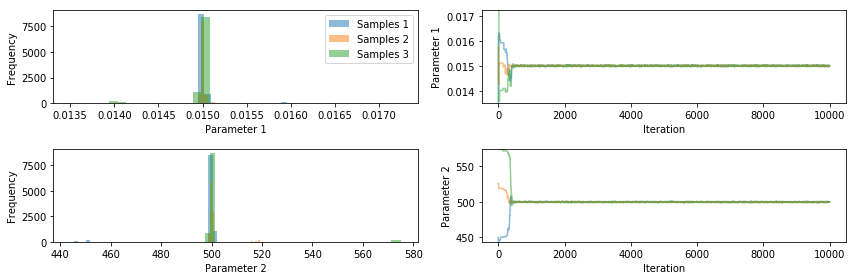

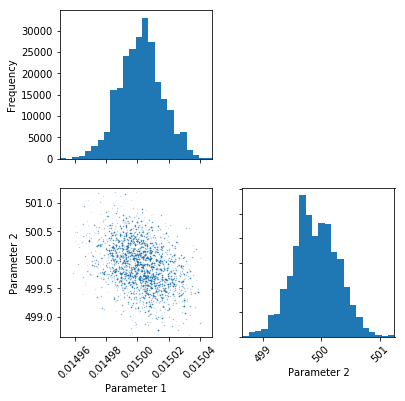

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0030813251751074, 1.0010790878610856]


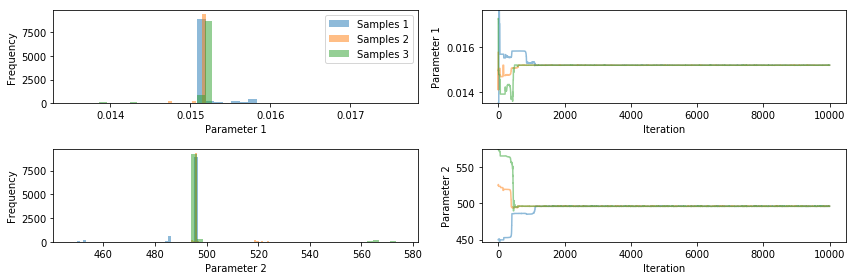

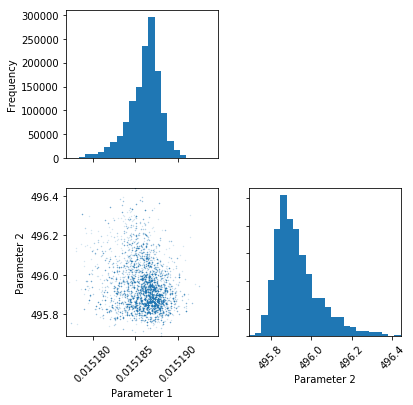

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

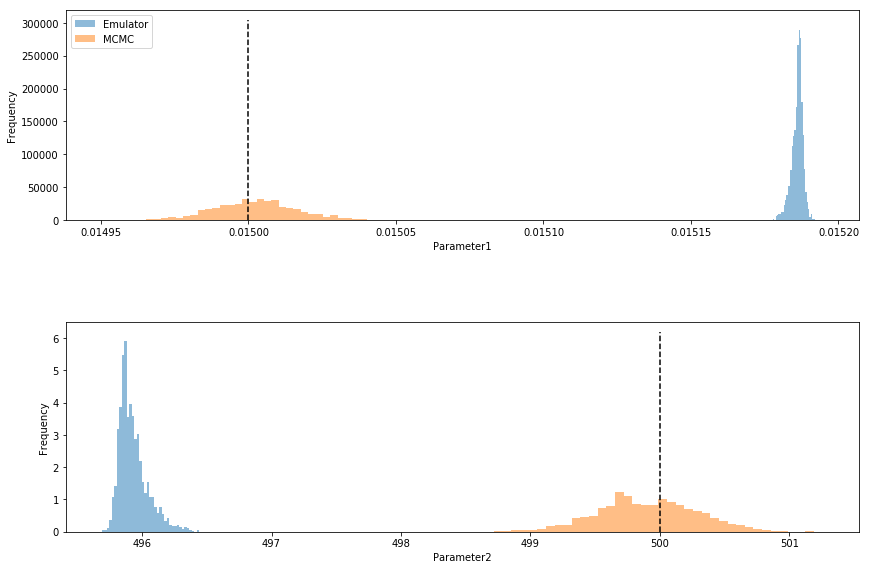

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

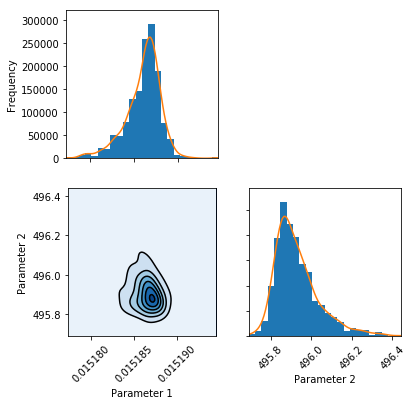

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

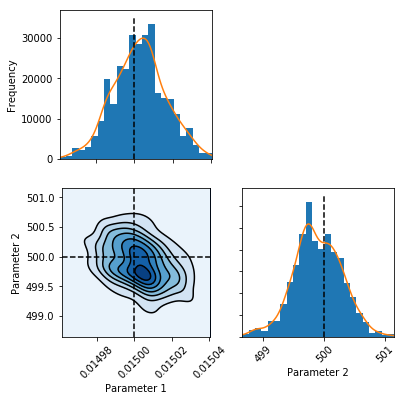

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

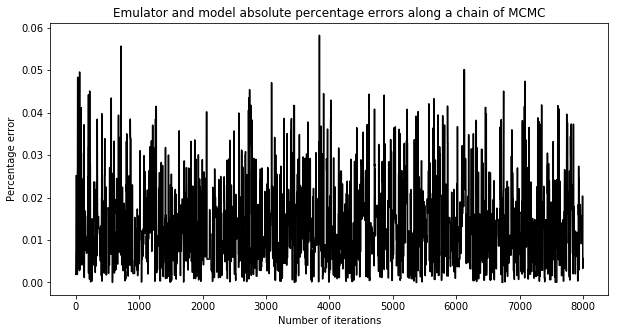

0.013012423217792363

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

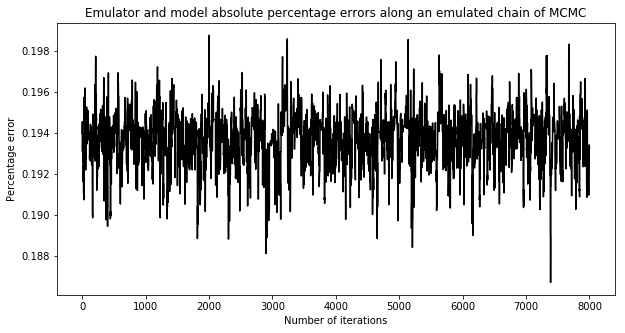

0.19370465615262816

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

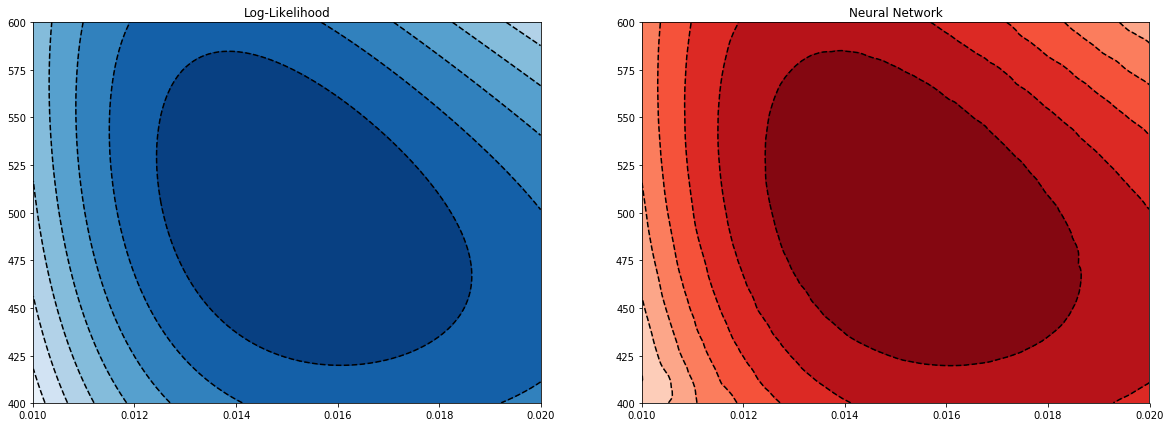

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

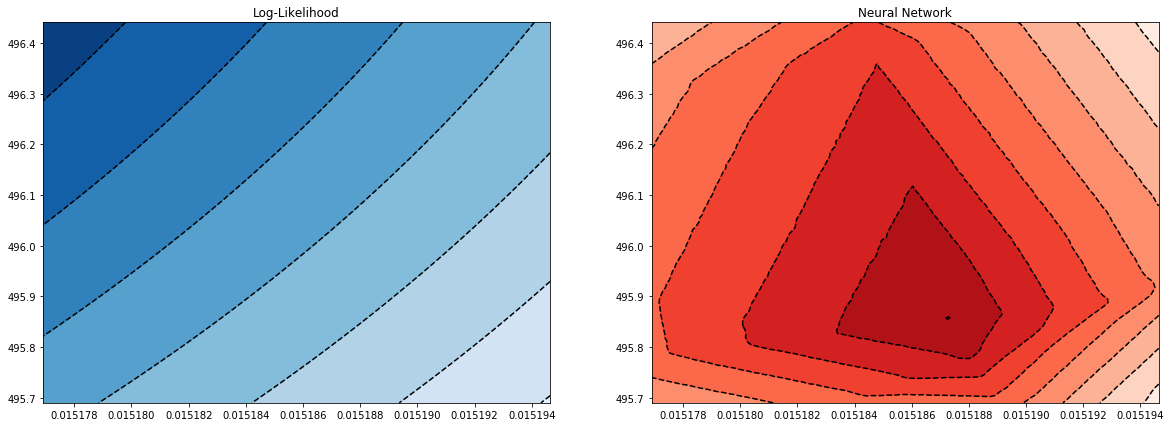

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

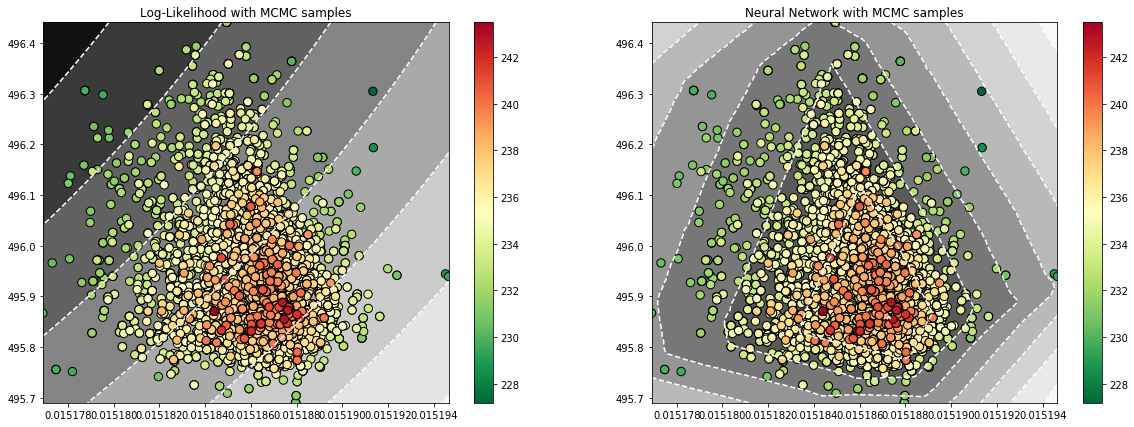

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

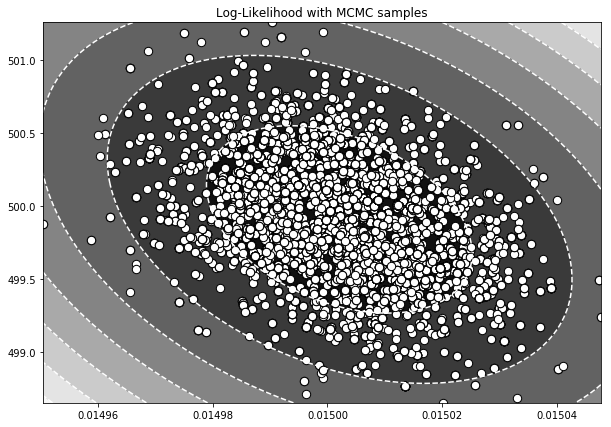

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()